In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
import scipy.sparse as sp
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

plt.rcParams['font.size'] = 12

# Load data

In [2]:
sp_data = sc.read('../datas/human_prefrontal_cortex/slide_tag_human_spatial.h5ad')
sp_data

AnnData object with n_obs × n_vars = 4065 × 28568
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'spatial'

In [3]:
sc_data = sc.read('../datas/human_prefrontal_cortex/GSE168408_10X_human_scrna.h5ad')
sc_data

AnnData object with n_obs × n_vars = 153473 × 26747
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_CLDN5_

In [4]:
cell_mapping = {
    "Vascular": "Endothelial",  
}

sc_data.obs['cell_type'] = sc_data.obs['celltype'].replace(cell_mapping)
sc_data.obs

batch     RL#   age chem concat_id  \
AAACCTGAGAGTCGGT-RL1612_34d_v2    RL1612_34d_v2  RL1612   34d   v2         0   
AAACCTGAGCCGCCTA-RL1612_34d_v2    RL1612_34d_v2  RL1612   34d   v2         0   
AAACCTGAGTCGAGTG-RL1612_34d_v2    RL1612_34d_v2  RL1612   34d   v2         0   
AAACCTGAGTGAACAT-RL1612_34d_v2    RL1612_34d_v2  RL1612   34d   v2         0   
AAACCTGCAAGGACTG-RL1612_34d_v2    RL1612_34d_v2  RL1612   34d   v2         0   
...                                         ...     ...   ...  ...       ...   
TTTGTTGCACCAGCGT-RL2132_25yr_v3  RL2132_25yr_v3  RL2132  25yr   v3        26   
TTTGTTGCACCGCTGA-RL2132_25yr_v3  RL2132_25yr_v3  RL2132  25yr   v3        26   
TTTGTTGGTAAGGTCG-RL2132_25yr_v3  RL2132_25yr_v3  RL2132  25yr   v3        26   
TTTGTTGGTTCGGCTG-RL2132_25yr_v3  RL2132_25yr_v3  RL2132  25yr   v3        26   
TTTGTTGTCGTCCTCA-RL2132_25yr_v3  RL2132_25yr_v3  RL2132  25yr   v3        26   

                                 numerical_age  stage_id Sex Race  PMI  ...  \
AAACCTGAGAGTCGGT-RL1612_34d_v2        0.093151  Neonatal   M   AA    5  ...   
AAACCTGAGCCGCCTA-RL1612_34d_v2        0.093151  Neonatal   M   AA    5  ...   
AAACCTGAGTCGAGTG-RL1612_34d_v2        0.093151  Neonatal   M   AA    5  ...   
AAACCTGAGTGAACAT-RL1612_34d_v2        0.093151  Neonatal   M   AA    5  ...   
AAACCTGCAAGGACTG-RL1612_34d_v2        0.093151  Neonatal   M   AA    5  ...   
...                                        ...       ...  ..  ...  ...  ...   
TTTGTTGCACCAGCGT-RL2132_25yr_v3      25.000000     Adult   F   AA   24  ...   
TTTGTTGCACCGCTGA-RL2132_25yr_v3      25.000000     Adult   F   AA   24  ...   
TTTGTTGGTAAGGTCG-RL2132_25yr_v3      25.000000     Adult   F   AA   24  ...   
TTTGTTGGTTCGGCTG-RL2132_25yr_v3      25.000000     Adult   F   AA   24  ...   
TTTGTTGTCGTCCTCA-RL2132_25yr_v3      25.000000     Adult   F   AA   24  ...   

                                mj_dev_traj_OPC mj_dev_traj_PV  \
AAACCTGAGAGTCGGT-RL1612_34d_v2             None           None   
AAACCTGAGCCGCCTA-RL1612_34d_v2             None           None   
AAACCTGAGTCGAGTG-RL1612_34d_v2             None           None   
AAACCTGAGTGAACAT-RL1612_34d_v2             None           None   
AAACCTGCAAGGACTG-RL1612_34d_v2             None           None   
...                                         ...            ...   
TTTGTTGCACCAGCGT-RL2132_25yr_v3            None           None   
TTTGTTGCACCGCTGA-RL2132_25yr_v3            None           None   
TTTGTTGGTAAGGTCG-RL2132_25yr_v3     mj_dev_traj           None   
TTTGTTGGTTCGGCTG-RL2132_25yr_v3            None           None   
TTTGTTGTCGTCCTCA-RL2132_25yr_v3            None           None   

                                mj_dev_traj_PV_SCUBE3 mj_dev_traj_ID2  \
AAACCTGAGAGTCGGT-RL1612_34d_v2                   None            None   
AAACCTGAGCCGCCTA-RL1612_34d_v2                   None            None   
AAACCTGAGTCGAGTG-RL1612_34d_v2                   None            None   
AAACCTGAGTGAACAT-RL1612_34d_v2                   None            None   
AAACCTGCAAGGACTG-RL1612_34d_v2                   None            None   
...                                               ...             ...   
TTTGTTGCACCAGCGT-RL2132_25yr_v3           mj_dev_traj            None   
TTTGTTGCACCGCTGA-RL2132_25yr_v3                  None     mj_dev_traj   
TTTGTTGGTAAGGTCG-RL2132_25yr_v3                  None            None   
TTTGTTGGTTCGGCTG-RL2132_25yr_v3                  None            None   
TTTGTTGTCGTCCTCA-RL2132_25yr_v3                  None            None   

                                mj_dev_traj_Oligo mj_dev_traj_LAMP5_NOS1  \
AAACCTGAGAGTCGGT-RL1612_34d_v2               None                   None   
AAACCTGAGCCGCCTA-RL1612_34d_v2               None                   None   
AAACCTGAGTCGAGTG-RL1612_34d_v2               None                   None   
AAACCTGAGTGAACAT-RL1612_34d_v2               None                   None   
AAACCTGCAAGGACTG-RL1612_34d_v2               None                   None   
...   

In [5]:
sp_data.obs['cell_type'] = sp_data.obs['celltype']

In [6]:
sc_data.obs['cell_type'].value_counts()

Excitatory     59369
Inhibitory     27561
Astrocyte      25053
Oligo          23450
OPC            11145
Microglia       5672
Endothelial     1223
Name: cell_type, dtype: int64

In [7]:
# # Find common cell types
common_cell_type = list(set(sp_data.obs['cell_type'].tolist()) & set(sc_data.obs['cell_type'].tolist()))
common_cell_type

['Oligo',
 'Microglia',
 'Inhibitory',
 'Excitatory',
 'Astrocyte',
 'Endothelial',
 'OPC']

In [8]:
sp_data = sp_data[sp_data.obs['cell_type'].isin(common_cell_type), :]
sp_data

View of AnnData object with n_obs × n_vars = 4065 × 28568
    obs: 'celltype', 'cell_type'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'spatial'

In [9]:
sc_data = sc_data[sc_data.obs['cell_type'].isin(common_cell_type), :]
sc_data

View of AnnData object with n_obs × n_vars = 153473 × 26747
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Va

# Process data

In [10]:
# Convert to row-sparse matrix
if not sp.issparse(sc_data.X):
    sc_data.X = sp.csr_matrix(sc_data.X)
    
if not sp.issparse(sp_data.X):
    temp = sp.csr_matrix(np.array(sp_data.X)).copy()
    del sp_data.X
    sp_data.X = temp.copy()
    del temp

In [11]:
# Please make sure cell_type is included in scRNA_data.obs
assert 'cell_type' in sc_data.obs

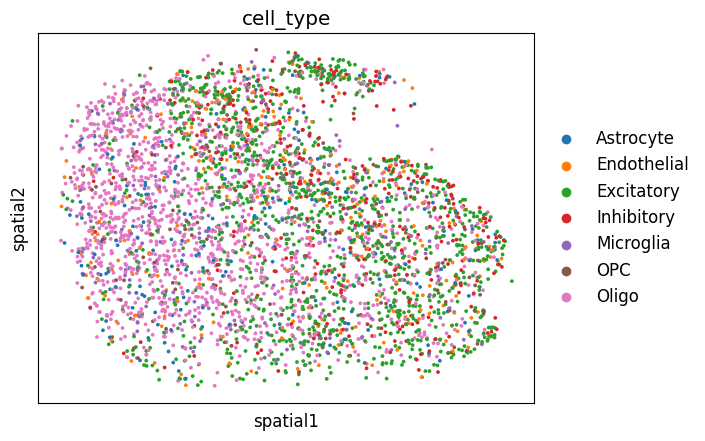

In [12]:
sc.pl.embedding(sp_data, basis='spatial', color='cell_type')

# Run code¶

In [13]:
import sys
sys.path.append('../')

import SpCAST
from SpCAST.utils import preprocess_datasets

In [14]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

In [15]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

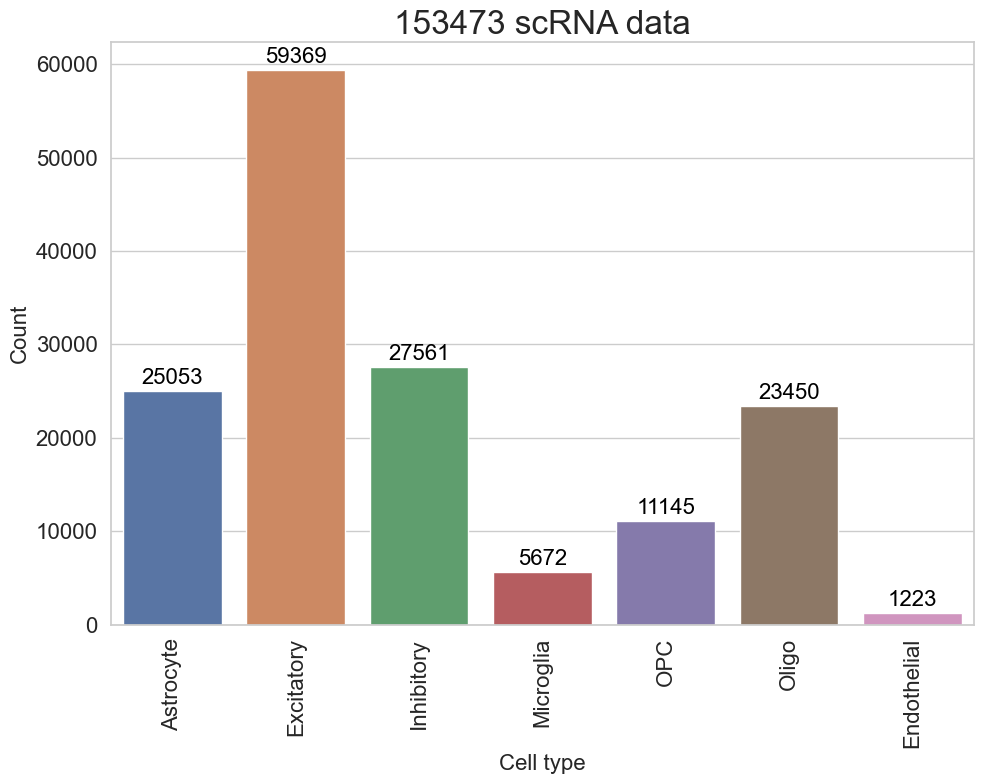

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Calculate the count for each category
sc_category_counts = scRNA_data.obs['cell_type'].value_counts().reset_index()
sc_category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10, 8))

# Draw barplot
ax = sns.barplot(x='Category', y='Count', data=sc_category_counts)

# Add title and labels
plt.title(f'{len(scRNA_data.obs)} scRNA data', fontsize=24)
plt.xlabel('Cell type', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=16)

# Increase font size for y-axis ticks
plt.yticks(fontsize=16)

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=16, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [17]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

datatype = 'Seq'
assert datatype in ['FISH', 'Seq']

scRNA_data, spRNA_data = preprocess_datasets(scRNA_data, spRNA_data, hvg_num=15000, 
                                             final_n_top_genes=2000, min_genes_in_cells=3, 
                                             datatype=datatype, include_markers=True)

Preprocessing scRNA-seq data ...
scRNA Data before filtering: 153473 cells  ||  scRNA Data after filtering: 153471 cells
Normalizing and log1p raw scRNA counts...
sc data nonzero expression ratio: 7.93%
-----------------------------------------------
Preprocessing spRNA-seq data ...
Normalizing and log1p raw spRNA counts...
-----------------------------------------------
Enhance spRNA Data expression ...


100%|███████████████████████████████████████████████████████████████████████████| 4065/4065 [00:00<00:00, 33048.81it/s]
Enhance gene expression data using spatial coordinates: 100%|████████████████████| 4065/4065 [00:01<00:00, 3103.03it/s]


sp data original nonzero expression ratio: 6.58%    sp data enhanced nonzero expression ratio: 21.33%
Concatenating datasets...
We have 6830 shared genes on scRNA and spatial RNA data
Computing scRNA data marker genes ...
We ultimately use 2056 genes for training ...
Preprocessing completed...


In [18]:
sc_obs = scRNA_data.obs
scRNA_data = ad.concat([scRNA_data, sc_data[:, "SLC17A7"]], axis=1).copy()
scRNA_data.obs = sc_obs

sp_obs = spRNA_data.obs
sp_obsm = spRNA_data.obsm
spRNA_data = ad.concat([spRNA_data, sp_data[:, "SLC17A7"]], axis=1).copy()
spRNA_data.obs = sp_obs
spRNA_data.obsm = sp_obsm

In [19]:
scRNA_data.X = scRNA_data.X.toarray()
spRNA_data.X = spRNA_data.X.toarray()

In [26]:
save_model_path='../model'
save_model_name='model_params.pth'

prob_df = SpCAST.train_SpCAST(scRNA_data=scRNA_data, spRNA_data=spRNA_data,
                              latent_dim1=30, latent_dim2=20, verbose=True,
                              batch_size=256, loss_step=10, n_epochs=50, device=device, 
                              save_model_path=save_model_path, save_model_name=save_model_name)

Size of scRNA-seq data Input:  (153471, 2057)
Size of spRNA-seq data Input:  (4065, 2057)
Class distribution: [25053  1223 59369 27561  5672 11145 23448]
Class weights: [0.13154223 0.18739607 0.12121713 0.13031478 0.15414677 0.14297531
 0.1324077 ]
Train the model..........


Training:  20%|██████████████▍                                                         | 10/50 [00:06<00:26,  1.51it/s]

Epoch:10 MMD Loss:0.536  Class Loss:0.222  Recon loss: 557.800  Train_Accuracy: 99.44% 


Training:  40%|████████████████████████████▊                                           | 20/50 [00:13<00:19,  1.50it/s]

Epoch:20 MMD Loss:0.455  Class Loss:0.124  Recon loss: 374.088  Train_Accuracy: 99.76% 


Training:  60%|███████████████████████████████████████████▏                            | 30/50 [00:19<00:13,  1.51it/s]

Epoch:30 MMD Loss:0.418  Class Loss:0.138  Recon loss: 341.690  Train_Accuracy: 99.73% 


Training:  80%|█████████████████████████████████████████████████████████▌              | 40/50 [00:26<00:06,  1.52it/s]

Epoch:40 MMD Loss:0.380  Class Loss:0.111  Recon loss: 329.954  Train_Accuracy: 99.78% 


Training: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch:50 MMD Loss:0.397  Class Loss:0.166  Recon loss: 323.694  Train_Accuracy: 99.66% 
Testing the model..........


Testing scRNA data: 100%|███████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 103.78it/s]


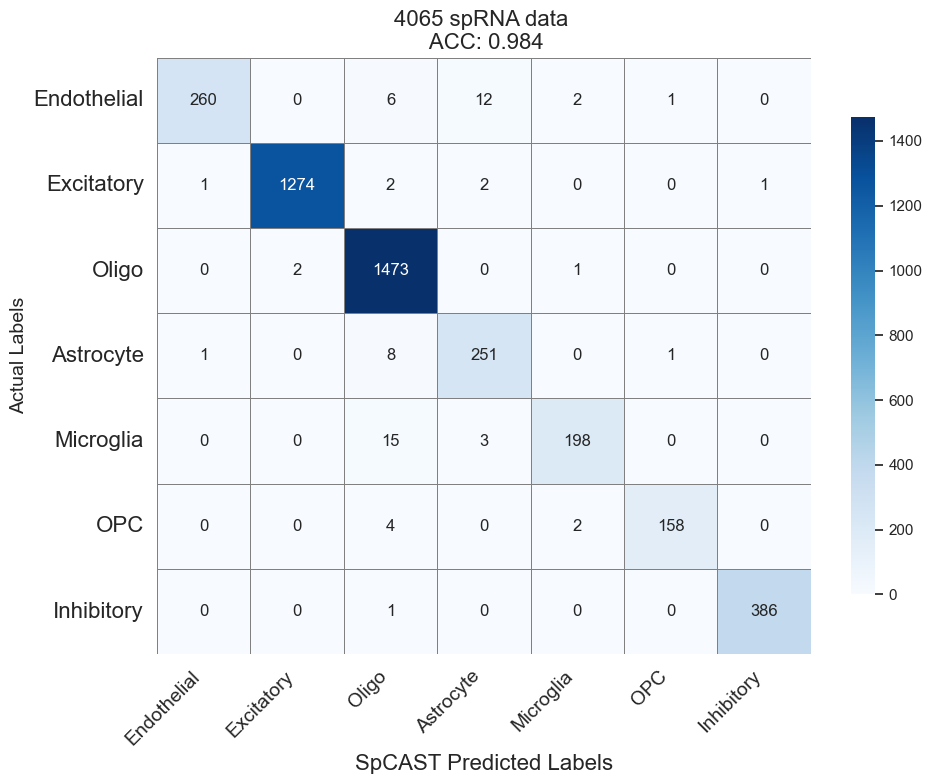

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Get unique category labels
cell_labels = spRNA_data.obs['cell_type'].unique().tolist()

spRNA_data.obs.cell_type = spRNA_data.obs.cell_type.astype(str)
spRNA_data.obs.SpCAST_predicted = spRNA_data.obs.SpCAST_predicted.astype(str)

# Calculate confusion matrix
conf_matrix = confusion_matrix(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], labels=cell_labels)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=cell_labels, columns=cell_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))  # Increase figure size
sns.heatmap(conf_matrix_df, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar_kws={'shrink': 0.8},  # Shrink color bar
            linewidths=0.5,  # Add grid line width
            linecolor='grey')  # Set grid line color

# Add axis labels and title
plt.xlabel('SpCAST Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=16)  # Keep y-axis labels horizontal

# Calculate accuracy and update the title
accuracy = accuracy_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'])
f1 = f1_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], average='macro')

plt.title(f'{len(spRNA_data.obs)} spRNA data \n ACC: {accuracy:.3f}', fontsize=16)
# Display the plot
plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure
plt.show()

# Identify marker genes

In [31]:
biomarkers =  {
    "Astrocyte": ["AQP4"],
    "Endothelial": ["ITIH5"],
    "Excitatory": ["SLC17A7"],
    "Inhibitory": ["GAD2"],
    "Microglia": ["APBB1IP"],
    "Oligo": ["PLP1"],
    "OPC": ["VCAN"]
}

In [50]:
spRNA_data.obs['cell_type'].astype('category').cat.categories.tolist()

['Astrocyte',
 'Endothelial',
 'Excitatory',
 'Inhibitory',
 'Microglia',
 'OPC',
 'Oligo']

In [51]:
biomarkers_list = []

for k in spRNA_data.obs['cell_type'].astype('category').cat.categories.tolist():
    if k in biomarkers.keys():
        biomarkers_list.extend(biomarkers[k])
biomarkers_list

['AQP4', 'ITIH5', 'SLC17A7', 'GAD2', 'APBB1IP', 'VCAN', 'PLP1']

Compute SHAP values using DeepExplainer ...


  0%|                                                                                         | 0/4065 [00:00<?, ?it/s]

  0%|                                                                               | 1/4065 [00:01<1:27:58,  1.30s/it]

  0%|                                                                               | 2/4065 [00:02<1:28:33,  1.31s/it]

  0%|                                                                               | 3/4065 [00:03<1:29:13,  1.32s/it]

  0%|                                                                               | 4/4065 [00:05<1:28:49,  1.31s/it]

  0%|                                                                               | 5/4065 [00:06<1:28:46,  1.31s/it]

  0%|                                                                               | 6/4065 [00:07<1:28:52,  1.31s/it]

  0%|▏                                                                              | 7/4065 [00:09<1:28:48,  1.31s/it]

  0%|▏                                                                              | 8/4065 [00:10<1:28:35,  1.31s/it]

  0%|▏                                                                              | 9/4065 [00:11<1:28:36,  1.31s/it]

  0%|▏                                                                             | 10/4065 [00:13<1:28:31,  1.31s/it]

  0%|▏                                                                             | 11/4065 [00:14<1:28:52,  1.32s/it]

  0%|▏                                                                             | 12/4065 [00:15<1:28:33,  1.31s/it]

  0%|▏                                                                             | 13/4065 [00:17<1:30:24,  1.34s/it]

  0%|▎                                                                             | 14/4065 [00:18<1:30:06,  1.33s/it]

  0%|▎                                                                             | 15/4065 [00:19<1:26:46,  1.29s/it]

  0%|▎                                                                             | 16/4065 [00:20<1:26:33,  1.28s/it]

  0%|▎                                                                             | 17/4065 [00:22<1:26:40,  1.28s/it]

  0%|▎                                                                             | 18/4065 [00:23<1:27:44,  1.30s/it]

  0%|▎                                                                             | 19/4065 [00:24<1:27:45,  1.30s/it]

  0%|▍                                                                             | 20/4065 [00:26<1:27:43,  1.30s/it]

  1%|▍                                                                             | 21/4065 [00:27<1:28:08,  1.31s/it]

  1%|▍                                                                             | 22/4065 [00:28<1:27:55,  1.30s/it]

  1%|▍                                                                             | 23/4065 [00:30<1:28:00,  1.31s/it]

  1%|▍                                                                             | 24/4065 [00:31<1:27:50,  1.30s/it]

  1%|▍                                                                             | 25/4065 [00:32<1:28:00,  1.31s/it]

  1%|▍                                                                             | 26/4065 [00:33<1:27:45,  1.30s/it]

  1%|▌                                                                             | 27/4065 [00:35<1:27:52,  1.31s/it]

  1%|▌                                                                             | 28/4065 [00:36<1:30:00,  1.34s/it]

  1%|▌                                                                             | 29/4065 [00:37<1:28:44,  1.32s/it]

  1%|▌                                                                             | 30/4065 [00:39<1:27:19,  1.30s/it]

  1%|▌                                                                             | 31/4065 [00:40<1:27:52,  1.31s/it]

  1%|▌                                                                             | 32/4065 [00:41<1:28:19,  1.31s/it]

  1%|▋                                                                             | 33/4065 [00:43<1:27:51,  1.31s/it]

  1%|▋                                                                             | 34/4065 [00:44<1:27:53,  1.31s/it]

  1%|▋                                                                             | 35/4065 [00:45<1:27:29,  1.30s/it]

  1%|▋                                                                             | 36/4065 [00:47<1:27:38,  1.31s/it]

  1%|▋                                                                             | 37/4065 [00:48<1:27:54,  1.31s/it]

  1%|▋                                                                             | 38/4065 [00:49<1:27:46,  1.31s/it]

  1%|▋                                                                             | 39/4065 [00:51<1:27:50,  1.31s/it]

  1%|▊                                                                             | 40/4065 [00:52<1:27:35,  1.31s/it]

  1%|▊                                                                             | 41/4065 [00:53<1:27:05,  1.30s/it]

  1%|▊                                                                             | 42/4065 [00:55<1:29:30,  1.34s/it]

  1%|▊                                                                             | 43/4065 [00:56<1:28:25,  1.32s/it]

  1%|▊                                                                             | 44/4065 [00:57<1:26:20,  1.29s/it]

  1%|▊                                                                             | 45/4065 [00:58<1:26:49,  1.30s/it]

  1%|▉                                                                             | 46/4065 [01:00<1:26:49,  1.30s/it]

  1%|▉                                                                             | 47/4065 [01:01<1:26:32,  1.29s/it]

  1%|▉                                                                             | 48/4065 [01:02<1:27:12,  1.30s/it]

  1%|▉                                                                             | 49/4065 [01:04<1:27:07,  1.30s/it]

  1%|▉                                                                             | 50/4065 [01:05<1:27:18,  1.30s/it]

  1%|▉                                                                             | 51/4065 [01:06<1:27:10,  1.30s/it]

  1%|▉                                                                             | 52/4065 [01:07<1:27:31,  1.31s/it]

  1%|█                                                                             | 53/4065 [01:09<1:27:46,  1.31s/it]

  1%|█                                                                             | 54/4065 [01:10<1:27:37,  1.31s/it]

  1%|█                                                                             | 55/4065 [01:11<1:27:48,  1.31s/it]

  1%|█                                                                             | 56/4065 [01:13<1:27:35,  1.31s/it]

  1%|█                                                                             | 57/4065 [01:14<1:29:43,  1.34s/it]

  1%|█                                                                             | 58/4065 [01:15<1:26:57,  1.30s/it]

  1%|█▏                                                                            | 59/4065 [01:17<1:27:44,  1.31s/it]

  1%|█▏                                                                            | 60/4065 [01:18<1:28:03,  1.32s/it]

  2%|█▏                                                                            | 61/4065 [01:19<1:27:51,  1.32s/it]

  2%|█▏                                                                            | 62/4065 [01:21<1:27:28,  1.31s/it]

  2%|█▏                                                                            | 63/4065 [01:22<1:27:17,  1.31s/it]

  2%|█▏                                                                            | 64/4065 [01:23<1:27:07,  1.31s/it]

  2%|█▏                                                                            | 65/4065 [01:25<1:26:38,  1.30s/it]

  2%|█▎                                                                            | 66/4065 [01:26<1:26:10,  1.29s/it]

  2%|█▎                                                                            | 67/4065 [01:27<1:26:53,  1.30s/it]

  2%|█▎                                                                            | 68/4065 [01:28<1:26:45,  1.30s/it]

  2%|█▎                                                                            | 69/4065 [01:30<1:26:48,  1.30s/it]

  2%|█▎                                                                            | 70/4065 [01:31<1:27:30,  1.31s/it]

  2%|█▎                                                                            | 71/4065 [01:32<1:29:16,  1.34s/it]

  2%|█▍                                                                            | 72/4065 [01:34<1:27:52,  1.32s/it]

  2%|█▍                                                                            | 73/4065 [01:35<1:25:59,  1.29s/it]

  2%|█▍                                                                            | 74/4065 [01:36<1:25:54,  1.29s/it]

  2%|█▍                                                                            | 75/4065 [01:38<1:26:23,  1.30s/it]

  2%|█▍                                                                            | 76/4065 [01:39<1:26:39,  1.30s/it]

  2%|█▍                                                                            | 77/4065 [01:40<1:26:42,  1.30s/it]

  2%|█▍                                                                            | 78/4065 [01:42<1:27:10,  1.31s/it]

  2%|█▌                                                                            | 79/4065 [01:43<1:27:36,  1.32s/it]

  2%|█▌                                                                            | 80/4065 [01:44<1:27:23,  1.32s/it]

  2%|█▌                                                                            | 81/4065 [01:45<1:27:18,  1.31s/it]

  2%|█▌                                                                            | 82/4065 [01:47<1:27:20,  1.32s/it]

  2%|█▌                                                                            | 83/4065 [01:48<1:26:35,  1.30s/it]

  2%|█▌                                                                            | 84/4065 [01:49<1:26:43,  1.31s/it]

  2%|█▋                                                                            | 85/4065 [01:51<1:27:04,  1.31s/it]

  2%|█▋                                                                            | 86/4065 [01:52<1:29:11,  1.34s/it]

  2%|█▋                                                                            | 87/4065 [01:53<1:26:27,  1.30s/it]

  2%|█▋                                                                            | 88/4065 [01:55<1:26:31,  1.31s/it]

  2%|█▋                                                                            | 89/4065 [01:56<1:26:31,  1.31s/it]

  2%|█▋                                                                            | 90/4065 [01:57<1:26:41,  1.31s/it]

  2%|█▋                                                                            | 91/4065 [01:59<1:26:36,  1.31s/it]

  2%|█▊                                                                            | 92/4065 [02:00<1:26:38,  1.31s/it]

  2%|█▊                                                                            | 93/4065 [02:01<1:26:45,  1.31s/it]

  2%|█▊                                                                            | 94/4065 [02:03<1:26:44,  1.31s/it]

  2%|█▊                                                                            | 95/4065 [02:04<1:26:44,  1.31s/it]

  2%|█▊                                                                            | 96/4065 [02:05<1:26:37,  1.31s/it]

  2%|█▊                                                                            | 97/4065 [02:06<1:26:09,  1.30s/it]

  2%|█▉                                                                            | 98/4065 [02:08<1:26:20,  1.31s/it]

  2%|█▉                                                                            | 99/4065 [02:09<1:26:07,  1.30s/it]

  2%|█▉                                                                           | 100/4065 [02:11<1:29:54,  1.36s/it]

  2%|█▉                                                                           | 101/4065 [02:12<1:29:10,  1.35s/it]

  3%|█▉                                                                           | 102/4065 [02:13<1:24:52,  1.29s/it]

  3%|█▉                                                                           | 103/4065 [02:14<1:24:28,  1.28s/it]

  3%|█▉                                                                           | 104/4065 [02:16<1:24:29,  1.28s/it]

  3%|█▉                                                                           | 105/4065 [02:17<1:25:25,  1.29s/it]

  3%|██                                                                           | 106/4065 [02:18<1:25:27,  1.30s/it]

  3%|██                                                                           | 107/4065 [02:19<1:25:46,  1.30s/it]

  3%|██                                                                           | 108/4065 [02:21<1:25:22,  1.29s/it]

  3%|██                                                                           | 109/4065 [02:22<1:25:24,  1.30s/it]

  3%|██                                                                           | 110/4065 [02:23<1:25:43,  1.30s/it]

  3%|██                                                                           | 111/4065 [02:25<1:25:37,  1.30s/it]

  3%|██                                                                           | 112/4065 [02:26<1:25:52,  1.30s/it]

  3%|██▏                                                                          | 113/4065 [02:27<1:24:47,  1.29s/it]

  3%|██▏                                                                          | 114/4065 [02:28<1:23:43,  1.27s/it]

  3%|██▏                                                                          | 115/4065 [02:30<1:26:40,  1.32s/it]

  3%|██▏                                                                          | 116/4065 [02:31<1:24:06,  1.28s/it]

  3%|██▏                                                                          | 117/4065 [02:32<1:24:09,  1.28s/it]

  3%|██▏                                                                          | 118/4065 [02:34<1:25:07,  1.29s/it]

  3%|██▎                                                                          | 119/4065 [02:35<1:25:27,  1.30s/it]

  3%|██▎                                                                          | 120/4065 [02:36<1:24:45,  1.29s/it]

  3%|██▎                                                                          | 121/4065 [02:38<1:24:16,  1.28s/it]

  3%|██▎                                                                          | 122/4065 [02:39<1:23:55,  1.28s/it]

  3%|██▎                                                                          | 123/4065 [02:40<1:24:17,  1.28s/it]

  3%|██▎                                                                          | 124/4065 [02:41<1:23:38,  1.27s/it]

  3%|██▎                                                                          | 125/4065 [02:43<1:24:23,  1.29s/it]

  3%|██▍                                                                          | 126/4065 [02:44<1:24:35,  1.29s/it]

  3%|██▍                                                                          | 127/4065 [02:45<1:24:07,  1.28s/it]

  3%|██▍                                                                          | 128/4065 [02:46<1:23:47,  1.28s/it]

  3%|██▍                                                                          | 129/4065 [02:48<1:28:09,  1.34s/it]

  3%|██▍                                                                          | 130/4065 [02:49<1:25:03,  1.30s/it]

  3%|██▍                                                                          | 131/4065 [02:50<1:24:06,  1.28s/it]

  3%|██▌                                                                          | 132/4065 [02:52<1:24:03,  1.28s/it]

  3%|██▌                                                                          | 133/4065 [02:53<1:23:58,  1.28s/it]

  3%|██▌                                                                          | 134/4065 [02:54<1:23:38,  1.28s/it]

  3%|██▌                                                                          | 135/4065 [02:56<1:23:42,  1.28s/it]

  3%|██▌                                                                          | 136/4065 [02:57<1:24:03,  1.28s/it]

  3%|██▌                                                                          | 137/4065 [02:58<1:24:36,  1.29s/it]

  3%|██▌                                                                          | 138/4065 [02:59<1:24:22,  1.29s/it]

  3%|██▋                                                                          | 139/4065 [03:01<1:24:50,  1.30s/it]

  3%|██▋                                                                          | 140/4065 [03:02<1:24:48,  1.30s/it]

  3%|██▋                                                                          | 141/4065 [03:03<1:24:47,  1.30s/it]

  3%|██▋                                                                          | 142/4065 [03:05<1:24:46,  1.30s/it]

  4%|██▋                                                                          | 143/4065 [03:06<1:27:31,  1.34s/it]

  4%|██▋                                                                          | 144/4065 [03:07<1:26:40,  1.33s/it]

  4%|██▋                                                                          | 145/4065 [03:09<1:23:55,  1.28s/it]

  4%|██▊                                                                          | 146/4065 [03:10<1:24:45,  1.30s/it]

  4%|██▊                                                                          | 147/4065 [03:12<1:36:03,  1.47s/it]

  4%|██▊                                                                          | 148/4065 [03:13<1:33:50,  1.44s/it]

  4%|██▊                                                                          | 149/4065 [03:14<1:31:22,  1.40s/it]

  4%|██▊                                                                          | 150/4065 [03:16<1:36:40,  1.48s/it]

  4%|██▊                                                                          | 151/4065 [03:17<1:33:39,  1.44s/it]

  4%|██▉                                                                          | 152/4065 [03:19<1:31:48,  1.41s/it]

  4%|██▉                                                                          | 153/4065 [03:20<1:30:32,  1.39s/it]

  4%|██▉                                                                          | 154/4065 [03:21<1:28:06,  1.35s/it]

  4%|██▉                                                                          | 155/4065 [03:23<1:26:42,  1.33s/it]

  4%|██▉                                                                          | 156/4065 [03:24<1:25:24,  1.31s/it]

  4%|██▉                                                                          | 157/4065 [03:25<1:25:07,  1.31s/it]

  4%|██▉                                                                          | 158/4065 [03:27<1:27:38,  1.35s/it]

  4%|███                                                                          | 159/4065 [03:28<1:24:50,  1.30s/it]

  4%|███                                                                          | 160/4065 [03:29<1:24:59,  1.31s/it]

  4%|███                                                                          | 161/4065 [03:30<1:24:47,  1.30s/it]

  4%|███                                                                          | 162/4065 [03:32<1:24:39,  1.30s/it]

  4%|███                                                                          | 163/4065 [03:33<1:24:32,  1.30s/it]

  4%|███                                                                          | 164/4065 [03:34<1:24:27,  1.30s/it]

  4%|███▏                                                                         | 165/4065 [03:36<1:24:25,  1.30s/it]

  4%|███▏                                                                         | 166/4065 [03:37<1:24:22,  1.30s/it]

  4%|███▏                                                                         | 167/4065 [03:38<1:24:19,  1.30s/it]

  4%|███▏                                                                         | 168/4065 [03:40<1:24:16,  1.30s/it]

  4%|███▏                                                                         | 169/4065 [03:41<1:24:14,  1.30s/it]

  4%|███▏                                                                         | 170/4065 [03:42<1:24:12,  1.30s/it]

  4%|███▏                                                                         | 171/4065 [03:43<1:24:10,  1.30s/it]

  4%|███▎                                                                         | 172/4065 [03:45<1:26:53,  1.34s/it]

  4%|███▎                                                                         | 173/4065 [03:46<1:25:26,  1.32s/it]

  4%|███▎                                                                         | 174/4065 [03:47<1:21:58,  1.26s/it]

  4%|███▎                                                                         | 175/4065 [03:49<1:22:35,  1.27s/it]

  4%|███▎                                                                         | 176/4065 [03:50<1:23:01,  1.28s/it]

  4%|███▎                                                                         | 177/4065 [03:51<1:23:00,  1.28s/it]

  4%|███▎                                                                         | 178/4065 [03:52<1:23:35,  1.29s/it]

  4%|███▍                                                                         | 179/4065 [03:54<1:23:23,  1.29s/it]

  4%|███▍                                                                         | 180/4065 [03:55<1:23:51,  1.30s/it]

  4%|███▍                                                                         | 181/4065 [03:56<1:23:52,  1.30s/it]

  4%|███▍                                                                         | 182/4065 [03:58<1:23:52,  1.30s/it]

  5%|███▍                                                                         | 183/4065 [03:59<1:24:10,  1.30s/it]

  5%|███▍                                                                         | 184/4065 [04:00<1:24:04,  1.30s/it]

  5%|███▌                                                                         | 185/4065 [04:02<1:24:17,  1.30s/it]

  5%|███▌                                                                         | 186/4065 [04:03<1:23:50,  1.30s/it]

  5%|███▌                                                                         | 187/4065 [04:04<1:25:38,  1.33s/it]

  5%|███▌                                                                         | 188/4065 [04:05<1:22:57,  1.28s/it]

  5%|███▌                                                                         | 189/4065 [04:07<1:23:29,  1.29s/it]

  5%|███▌                                                                         | 190/4065 [04:08<1:23:51,  1.30s/it]

  5%|███▌                                                                         | 191/4065 [04:09<1:23:30,  1.29s/it]

  5%|███▋                                                                         | 192/4065 [04:11<1:23:14,  1.29s/it]

  5%|███▋                                                                         | 193/4065 [04:12<1:23:03,  1.29s/it]

  5%|███▋                                                                         | 194/4065 [04:13<1:23:13,  1.29s/it]

  5%|███▋                                                                         | 195/4065 [04:15<1:23:20,  1.29s/it]

  5%|███▋                                                                         | 196/4065 [04:16<1:23:24,  1.29s/it]

  5%|███▋                                                                         | 197/4065 [04:17<1:23:45,  1.30s/it]

  5%|███▊                                                                         | 198/4065 [04:18<1:23:41,  1.30s/it]

  5%|███▊                                                                         | 199/4065 [04:20<1:23:56,  1.30s/it]

  5%|███▊                                                                         | 200/4065 [04:21<1:24:06,  1.31s/it]

  5%|███▊                                                                         | 201/4065 [04:23<1:27:50,  1.36s/it]

  5%|███▊                                                                         | 202/4065 [04:24<1:26:13,  1.34s/it]

  5%|███▊                                                                         | 203/4065 [04:25<1:23:16,  1.29s/it]

  5%|███▊                                                                         | 204/4065 [04:26<1:24:12,  1.31s/it]

  5%|███▉                                                                         | 205/4065 [04:28<1:24:15,  1.31s/it]

  5%|███▉                                                                         | 206/4065 [04:29<1:24:35,  1.32s/it]

  5%|███▉                                                                         | 207/4065 [04:30<1:23:18,  1.30s/it]

  5%|███▉                                                                         | 208/4065 [04:32<1:23:00,  1.29s/it]

  5%|███▉                                                                         | 209/4065 [04:33<1:22:29,  1.28s/it]

  5%|███▉                                                                         | 210/4065 [04:34<1:23:19,  1.30s/it]

  5%|███▉                                                                         | 211/4065 [04:35<1:22:42,  1.29s/it]

  5%|████                                                                         | 212/4065 [04:37<1:22:15,  1.28s/it]

  5%|████                                                                         | 213/4065 [04:38<1:22:32,  1.29s/it]

  5%|████                                                                         | 214/4065 [04:39<1:21:50,  1.28s/it]

  5%|████                                                                         | 215/4065 [04:40<1:21:36,  1.27s/it]

  5%|████                                                                         | 216/4065 [04:42<1:23:52,  1.31s/it]

  5%|████                                                                         | 217/4065 [04:43<1:21:14,  1.27s/it]

  5%|████▏                                                                        | 218/4065 [04:44<1:22:06,  1.28s/it]

  5%|████▏                                                                        | 219/4065 [04:46<1:22:59,  1.29s/it]

  5%|████▏                                                                        | 220/4065 [04:47<1:23:37,  1.30s/it]

  5%|████▏                                                                        | 221/4065 [04:48<1:23:08,  1.30s/it]

  5%|████▏                                                                        | 222/4065 [04:50<1:23:24,  1.30s/it]

  5%|████▏                                                                        | 223/4065 [04:51<1:23:16,  1.30s/it]

  6%|████▏                                                                        | 224/4065 [04:52<1:23:29,  1.30s/it]

  6%|████▎                                                                        | 225/4065 [04:54<1:23:36,  1.31s/it]

  6%|████▎                                                                        | 226/4065 [04:55<1:24:18,  1.32s/it]

  6%|████▎                                                                        | 227/4065 [04:56<1:23:53,  1.31s/it]

  6%|████▎                                                                        | 228/4065 [04:57<1:24:11,  1.32s/it]

  6%|████▎                                                                        | 229/4065 [04:59<1:24:23,  1.32s/it]

  6%|████▎                                                                        | 230/4065 [05:00<1:28:25,  1.38s/it]

  6%|████▍                                                                        | 231/4065 [05:02<1:25:14,  1.33s/it]

  6%|████▍                                                                        | 232/4065 [05:03<1:26:01,  1.35s/it]

  6%|████▍                                                                        | 233/4065 [05:04<1:25:02,  1.33s/it]

  6%|████▍                                                                        | 234/4065 [05:06<1:24:39,  1.33s/it]

  6%|████▍                                                                        | 235/4065 [05:07<1:24:04,  1.32s/it]

  6%|████▍                                                                        | 236/4065 [05:08<1:23:58,  1.32s/it]

  6%|████▍                                                                        | 237/4065 [05:09<1:23:35,  1.31s/it]

  6%|████▌                                                                        | 238/4065 [05:11<1:23:00,  1.30s/it]

  6%|████▌                                                                        | 239/4065 [05:12<1:23:12,  1.30s/it]

  6%|████▌                                                                        | 240/4065 [05:13<1:22:43,  1.30s/it]

  6%|████▌                                                                        | 241/4065 [05:15<1:22:59,  1.30s/it]

  6%|████▌                                                                        | 242/4065 [05:16<1:22:34,  1.30s/it]

  6%|████▌                                                                        | 243/4065 [05:17<1:22:51,  1.30s/it]

  6%|████▌                                                                        | 244/4065 [05:19<1:26:03,  1.35s/it]

  6%|████▋                                                                        | 245/4065 [05:20<1:25:35,  1.34s/it]

  6%|████▋                                                                        | 246/4065 [05:21<1:22:16,  1.29s/it]

  6%|████▋                                                                        | 247/4065 [05:23<1:22:55,  1.30s/it]

  6%|████▋                                                                        | 248/4065 [05:24<1:23:23,  1.31s/it]

  6%|████▋                                                                        | 249/4065 [05:25<1:23:41,  1.32s/it]

  6%|████▋                                                                        | 250/4065 [05:26<1:22:24,  1.30s/it]

  6%|████▊                                                                        | 251/4065 [05:28<1:22:24,  1.30s/it]

  6%|████▊                                                                        | 252/4065 [05:29<1:22:23,  1.30s/it]

  6%|████▊                                                                        | 253/4065 [05:30<1:22:40,  1.30s/it]

  6%|████▊                                                                        | 254/4065 [05:32<1:22:16,  1.30s/it]

  6%|████▊                                                                        | 255/4065 [05:33<1:22:52,  1.31s/it]

  6%|████▊                                                                        | 256/4065 [05:34<1:23:17,  1.31s/it]

  6%|████▊                                                                        | 257/4065 [05:36<1:22:58,  1.31s/it]

  6%|████▉                                                                        | 258/4065 [05:37<1:23:03,  1.31s/it]

  6%|████▉                                                                        | 259/4065 [05:38<1:25:28,  1.35s/it]

  6%|████▉                                                                        | 260/4065 [05:40<1:22:42,  1.30s/it]

  6%|████▉                                                                        | 261/4065 [05:41<1:22:51,  1.31s/it]

  6%|████▉                                                                        | 262/4065 [05:42<1:22:38,  1.30s/it]

  6%|████▉                                                                        | 263/4065 [05:43<1:22:11,  1.30s/it]

  6%|█████                                                                        | 264/4065 [05:45<1:22:09,  1.30s/it]

  7%|█████                                                                        | 265/4065 [05:46<1:22:44,  1.31s/it]

  7%|█████                                                                        | 266/4065 [05:47<1:22:32,  1.30s/it]

  7%|█████                                                                        | 267/4065 [05:49<1:22:23,  1.30s/it]

  7%|█████                                                                        | 268/4065 [05:50<1:21:58,  1.30s/it]

  7%|█████                                                                        | 269/4065 [05:51<1:22:34,  1.31s/it]

  7%|█████                                                                        | 270/4065 [05:53<1:22:23,  1.30s/it]

  7%|█████▏                                                                       | 271/4065 [05:54<1:22:15,  1.30s/it]

  7%|█████▏                                                                       | 272/4065 [05:55<1:21:52,  1.30s/it]

  7%|█████▏                                                                       | 273/4065 [05:57<1:24:15,  1.33s/it]

  7%|█████▏                                                                       | 274/4065 [05:58<1:23:32,  1.32s/it]

  7%|█████▏                                                                       | 275/4065 [05:59<1:20:58,  1.28s/it]

  7%|█████▏                                                                       | 276/4065 [06:00<1:22:07,  1.30s/it]

  7%|█████▏                                                                       | 277/4065 [06:02<1:23:12,  1.32s/it]

  7%|█████▎                                                                       | 278/4065 [06:03<1:23:40,  1.33s/it]

  7%|█████▎                                                                       | 279/4065 [06:04<1:23:59,  1.33s/it]

  7%|█████▎                                                                       | 280/4065 [06:06<1:23:37,  1.33s/it]

  7%|█████▎                                                                       | 281/4065 [06:07<1:23:03,  1.32s/it]

  7%|█████▎                                                                       | 282/4065 [06:08<1:22:21,  1.31s/it]

  7%|█████▎                                                                       | 283/4065 [06:10<1:22:45,  1.31s/it]

  7%|█████▍                                                                       | 284/4065 [06:11<1:22:43,  1.31s/it]

  7%|█████▍                                                                       | 285/4065 [06:12<1:22:41,  1.31s/it]

  7%|█████▍                                                                       | 286/4065 [06:14<1:22:22,  1.31s/it]

  7%|█████▍                                                                       | 287/4065 [06:15<1:22:08,  1.30s/it]

  7%|█████▍                                                                       | 288/4065 [06:16<1:25:48,  1.36s/it]

  7%|█████▍                                                                       | 289/4065 [06:18<1:22:46,  1.32s/it]

  7%|█████▍                                                                       | 290/4065 [06:19<1:22:41,  1.31s/it]

  7%|█████▌                                                                       | 291/4065 [06:20<1:22:38,  1.31s/it]

  7%|█████▌                                                                       | 292/4065 [06:21<1:22:00,  1.30s/it]

  7%|█████▌                                                                       | 293/4065 [06:23<1:21:33,  1.30s/it]

  7%|█████▌                                                                       | 294/4065 [06:24<1:22:06,  1.31s/it]

  7%|█████▌                                                                       | 295/4065 [06:25<1:21:54,  1.30s/it]

  7%|█████▌                                                                       | 296/4065 [06:27<1:21:45,  1.30s/it]

  7%|█████▋                                                                       | 297/4065 [06:28<1:21:39,  1.30s/it]

  7%|█████▋                                                                       | 298/4065 [06:29<1:21:34,  1.30s/it]

  7%|█████▋                                                                       | 299/4065 [06:31<1:21:12,  1.29s/it]

  7%|█████▋                                                                       | 300/4065 [06:32<1:21:14,  1.29s/it]

  7%|█████▋                                                                       | 301/4065 [06:33<1:20:58,  1.29s/it]

  7%|█████▋                                                                       | 302/4065 [06:35<1:23:25,  1.33s/it]

  7%|█████▋                                                                       | 303/4065 [06:36<1:20:41,  1.29s/it]

  7%|█████▊                                                                       | 304/4065 [06:37<1:21:44,  1.30s/it]

  8%|█████▊                                                                       | 305/4065 [06:38<1:21:35,  1.30s/it]

  8%|█████▊                                                                       | 306/4065 [06:40<1:21:51,  1.31s/it]

  8%|█████▊                                                                       | 307/4065 [06:41<1:21:34,  1.30s/it]

  8%|█████▊                                                                       | 308/4065 [06:42<1:21:46,  1.31s/it]

  8%|█████▊                                                                       | 309/4065 [06:44<1:21:32,  1.30s/it]

  8%|█████▊                                                                       | 310/4065 [06:45<1:21:24,  1.30s/it]

  8%|█████▉                                                                       | 311/4065 [06:46<1:21:20,  1.30s/it]

  8%|█████▉                                                                       | 312/4065 [06:47<1:21:31,  1.30s/it]

  8%|█████▉                                                                       | 313/4065 [06:49<1:21:41,  1.31s/it]

  8%|█████▉                                                                       | 314/4065 [06:50<1:22:04,  1.31s/it]

  8%|█████▉                                                                       | 315/4065 [06:51<1:21:45,  1.31s/it]

  8%|█████▉                                                                       | 316/4065 [06:53<1:21:48,  1.31s/it]

  8%|██████                                                                       | 317/4065 [06:54<1:23:37,  1.34s/it]

  8%|██████                                                                       | 318/4065 [06:55<1:19:51,  1.28s/it]

  8%|██████                                                                       | 319/4065 [06:57<1:20:20,  1.29s/it]

  8%|██████                                                                       | 320/4065 [06:58<1:20:39,  1.29s/it]

  8%|██████                                                                       | 321/4065 [06:59<1:20:40,  1.29s/it]

  8%|██████                                                                       | 322/4065 [07:01<1:21:03,  1.30s/it]

  8%|██████                                                                       | 323/4065 [07:02<1:21:12,  1.30s/it]

  8%|██████▏                                                                      | 324/4065 [07:03<1:21:10,  1.30s/it]

  8%|██████▏                                                                      | 325/4065 [07:04<1:21:09,  1.30s/it]

  8%|██████▏                                                                      | 326/4065 [07:06<1:21:14,  1.30s/it]

  8%|██████▏                                                                      | 327/4065 [07:07<1:21:04,  1.30s/it]

  8%|██████▏                                                                      | 328/4065 [07:08<1:21:12,  1.30s/it]

  8%|██████▏                                                                      | 329/4065 [07:10<1:21:20,  1.31s/it]

  8%|██████▎                                                                      | 330/4065 [07:11<1:21:22,  1.31s/it]

  8%|██████▎                                                                      | 331/4065 [07:12<1:23:33,  1.34s/it]

  8%|██████▎                                                                      | 332/4065 [07:14<1:20:37,  1.30s/it]

  8%|██████▎                                                                      | 333/4065 [07:15<1:20:56,  1.30s/it]

  8%|██████▎                                                                      | 334/4065 [07:16<1:20:52,  1.30s/it]

  8%|██████▎                                                                      | 335/4065 [07:18<1:21:24,  1.31s/it]

  8%|██████▎                                                                      | 336/4065 [07:19<1:20:49,  1.30s/it]

  8%|██████▍                                                                      | 337/4065 [07:20<1:20:34,  1.30s/it]

  8%|██████▍                                                                      | 338/4065 [07:21<1:20:56,  1.30s/it]

  8%|██████▍                                                                      | 339/4065 [07:23<1:20:49,  1.30s/it]

  8%|██████▍                                                                      | 340/4065 [07:24<1:20:45,  1.30s/it]

  8%|██████▍                                                                      | 341/4065 [07:25<1:20:58,  1.30s/it]

  8%|██████▍                                                                      | 342/4065 [07:27<1:20:55,  1.30s/it]

  8%|██████▍                                                                      | 343/4065 [07:28<1:21:02,  1.31s/it]

  8%|██████▌                                                                      | 344/4065 [07:29<1:20:42,  1.30s/it]

  8%|██████▌                                                                      | 345/4065 [07:31<1:23:38,  1.35s/it]

  9%|██████▌                                                                      | 346/4065 [07:32<1:23:23,  1.35s/it]

  9%|██████▌                                                                      | 347/4065 [07:33<1:20:07,  1.29s/it]

  9%|██████▌                                                                      | 348/4065 [07:34<1:20:03,  1.29s/it]

  9%|██████▌                                                                      | 349/4065 [07:36<1:20:18,  1.30s/it]

  9%|██████▋                                                                      | 350/4065 [07:37<1:20:15,  1.30s/it]

  9%|██████▋                                                                      | 351/4065 [07:38<1:19:57,  1.29s/it]

  9%|██████▋                                                                      | 352/4065 [07:40<1:20:24,  1.30s/it]

  9%|██████▋                                                                      | 353/4065 [07:41<1:20:15,  1.30s/it]

  9%|██████▋                                                                      | 354/4065 [07:42<1:20:35,  1.30s/it]

  9%|██████▋                                                                      | 355/4065 [07:44<1:20:23,  1.30s/it]

  9%|██████▋                                                                      | 356/4065 [07:45<1:20:38,  1.30s/it]

  9%|██████▊                                                                      | 357/4065 [07:46<1:20:25,  1.30s/it]

  9%|██████▊                                                                      | 358/4065 [07:47<1:20:20,  1.30s/it]

  9%|██████▊                                                                      | 359/4065 [07:49<1:20:30,  1.30s/it]

  9%|██████▊                                                                      | 360/4065 [07:50<1:22:23,  1.33s/it]

  9%|██████▊                                                                      | 361/4065 [07:51<1:19:40,  1.29s/it]

  9%|██████▊                                                                      | 362/4065 [07:53<1:20:21,  1.30s/it]

  9%|██████▉                                                                      | 363/4065 [07:54<1:20:27,  1.30s/it]

  9%|██████▉                                                                      | 364/4065 [07:55<1:20:30,  1.31s/it]

  9%|██████▉                                                                      | 365/4065 [07:57<1:20:11,  1.30s/it]

  9%|██████▉                                                                      | 366/4065 [07:58<1:20:22,  1.30s/it]

  9%|██████▉                                                                      | 367/4065 [07:59<1:20:32,  1.31s/it]

  9%|██████▉                                                                      | 368/4065 [08:01<1:20:19,  1.30s/it]

  9%|██████▉                                                                      | 369/4065 [08:02<1:20:27,  1.31s/it]

  9%|███████                                                                      | 370/4065 [08:03<1:20:51,  1.31s/it]

  9%|███████                                                                      | 371/4065 [08:05<1:21:05,  1.32s/it]

  9%|███████                                                                      | 372/4065 [08:07<1:38:01,  1.59s/it]

  9%|███████                                                                      | 373/4065 [08:08<1:34:08,  1.53s/it]

  9%|███████                                                                      | 374/4065 [08:10<1:33:26,  1.52s/it]

  9%|███████                                                                      | 375/4065 [08:11<1:29:18,  1.45s/it]

  9%|███████                                                                      | 376/4065 [08:12<1:24:22,  1.37s/it]

  9%|███████▏                                                                     | 377/4065 [08:13<1:23:39,  1.36s/it]

  9%|███████▏                                                                     | 378/4065 [08:15<1:21:46,  1.33s/it]

  9%|███████▏                                                                     | 379/4065 [08:16<1:21:04,  1.32s/it]

  9%|███████▏                                                                     | 380/4065 [08:17<1:20:06,  1.30s/it]

  9%|███████▏                                                                     | 381/4065 [08:19<1:20:18,  1.31s/it]

  9%|███████▏                                                                     | 382/4065 [08:20<1:20:16,  1.31s/it]

  9%|███████▎                                                                     | 383/4065 [08:21<1:20:03,  1.30s/it]

  9%|███████▎                                                                     | 384/4065 [08:22<1:19:53,  1.30s/it]

  9%|███████▎                                                                     | 385/4065 [08:24<1:20:14,  1.31s/it]

  9%|███████▎                                                                     | 386/4065 [08:25<1:19:50,  1.30s/it]

 10%|███████▎                                                                     | 387/4065 [08:26<1:20:15,  1.31s/it]

 10%|███████▎                                                                     | 388/4065 [08:28<1:19:44,  1.30s/it]

 10%|███████▎                                                                     | 389/4065 [08:29<1:21:59,  1.34s/it]

 10%|███████▍                                                                     | 390/4065 [08:30<1:18:34,  1.28s/it]

 10%|███████▍                                                                     | 391/4065 [08:32<1:18:35,  1.28s/it]

 10%|███████▍                                                                     | 392/4065 [08:33<1:18:46,  1.29s/it]

 10%|███████▍                                                                     | 393/4065 [08:34<1:19:08,  1.29s/it]

 10%|███████▍                                                                     | 394/4065 [08:35<1:19:35,  1.30s/it]

 10%|███████▍                                                                     | 395/4065 [08:37<1:19:26,  1.30s/it]

 10%|███████▌                                                                     | 396/4065 [08:38<1:19:22,  1.30s/it]

 10%|███████▌                                                                     | 397/4065 [08:39<1:19:38,  1.30s/it]

 10%|███████▌                                                                     | 398/4065 [08:41<1:19:16,  1.30s/it]

 10%|███████▌                                                                     | 399/4065 [08:42<1:19:31,  1.30s/it]

 10%|███████▌                                                                     | 400/4065 [08:43<1:19:04,  1.29s/it]

 10%|███████▌                                                                     | 401/4065 [08:45<1:19:15,  1.30s/it]

 10%|███████▌                                                                     | 402/4065 [08:46<1:19:37,  1.30s/it]

 10%|███████▋                                                                     | 403/4065 [08:47<1:22:38,  1.35s/it]

 10%|███████▋                                                                     | 404/4065 [08:49<1:21:51,  1.34s/it]

 10%|███████▋                                                                     | 405/4065 [08:50<1:17:49,  1.28s/it]

 10%|███████▋                                                                     | 406/4065 [08:51<1:18:09,  1.28s/it]

 10%|███████▋                                                                     | 407/4065 [08:52<1:18:12,  1.28s/it]

 10%|███████▋                                                                     | 408/4065 [08:54<1:21:13,  1.33s/it]

 10%|███████▋                                                                     | 409/4065 [08:55<1:23:29,  1.37s/it]

 10%|███████▊                                                                     | 410/4065 [08:57<1:22:06,  1.35s/it]

 10%|███████▊                                                                     | 411/4065 [08:58<1:21:18,  1.34s/it]

 10%|███████▊                                                                     | 412/4065 [08:59<1:20:25,  1.32s/it]

 10%|███████▊                                                                     | 413/4065 [09:00<1:20:15,  1.32s/it]

 10%|███████▊                                                                     | 414/4065 [09:02<1:19:54,  1.31s/it]

 10%|███████▊                                                                     | 415/4065 [09:03<1:19:30,  1.31s/it]

 10%|███████▉                                                                     | 416/4065 [09:04<1:19:47,  1.31s/it]

 10%|███████▉                                                                     | 417/4065 [09:06<1:19:33,  1.31s/it]

 10%|███████▉                                                                     | 418/4065 [09:07<1:21:21,  1.34s/it]

 10%|███████▉                                                                     | 419/4065 [09:08<1:18:17,  1.29s/it]

 10%|███████▉                                                                     | 420/4065 [09:10<1:19:12,  1.30s/it]

 10%|███████▉                                                                     | 421/4065 [09:11<1:19:50,  1.31s/it]

 10%|███████▉                                                                     | 422/4065 [09:12<1:20:02,  1.32s/it]

 10%|████████                                                                     | 423/4065 [09:14<1:20:04,  1.32s/it]

 10%|████████                                                                     | 424/4065 [09:15<1:19:21,  1.31s/it]

 10%|████████                                                                     | 425/4065 [09:16<1:18:52,  1.30s/it]

 10%|████████                                                                     | 426/4065 [09:17<1:19:00,  1.30s/it]

 11%|████████                                                                     | 427/4065 [09:19<1:18:38,  1.30s/it]

 11%|████████                                                                     | 428/4065 [09:20<1:18:54,  1.30s/it]

 11%|████████▏                                                                    | 429/4065 [09:21<1:19:34,  1.31s/it]

 11%|████████▏                                                                    | 430/4065 [09:23<1:19:02,  1.30s/it]

 11%|████████▏                                                                    | 431/4065 [09:24<1:19:28,  1.31s/it]

 11%|████████▏                                                                    | 432/4065 [09:26<1:22:49,  1.37s/it]

 11%|████████▏                                                                    | 433/4065 [09:27<1:21:32,  1.35s/it]

 11%|████████▏                                                                    | 434/4065 [09:28<1:18:12,  1.29s/it]

 11%|████████▏                                                                    | 435/4065 [09:29<1:17:50,  1.29s/it]

 11%|████████▎                                                                    | 436/4065 [09:31<1:18:22,  1.30s/it]

 11%|████████▎                                                                    | 437/4065 [09:32<1:18:16,  1.29s/it]

 11%|████████▎                                                                    | 438/4065 [09:33<1:18:34,  1.30s/it]

 11%|████████▎                                                                    | 439/4065 [09:34<1:18:41,  1.30s/it]

 11%|████████▎                                                                    | 440/4065 [09:36<1:18:23,  1.30s/it]

 11%|████████▎                                                                    | 441/4065 [09:37<1:18:49,  1.31s/it]

 11%|████████▎                                                                    | 442/4065 [09:38<1:18:28,  1.30s/it]

 11%|████████▍                                                                    | 443/4065 [09:40<1:18:41,  1.30s/it]

 11%|████████▍                                                                    | 444/4065 [09:41<1:18:46,  1.31s/it]

 11%|████████▍                                                                    | 445/4065 [09:42<1:18:22,  1.30s/it]

 11%|████████▍                                                                    | 446/4065 [09:44<1:21:30,  1.35s/it]

 11%|████████▍                                                                    | 447/4065 [09:45<1:20:01,  1.33s/it]

 11%|████████▍                                                                    | 448/4065 [09:46<1:18:06,  1.30s/it]

 11%|████████▌                                                                    | 449/4065 [09:48<1:18:21,  1.30s/it]

 11%|████████▌                                                                    | 450/4065 [09:49<1:18:38,  1.31s/it]

 11%|████████▌                                                                    | 451/4065 [09:50<1:18:38,  1.31s/it]

 11%|████████▌                                                                    | 452/4065 [09:51<1:18:32,  1.30s/it]

 11%|████████▌                                                                    | 453/4065 [09:53<1:18:42,  1.31s/it]

 11%|████████▌                                                                    | 454/4065 [09:54<1:18:56,  1.31s/it]

 11%|████████▌                                                                    | 455/4065 [09:55<1:18:51,  1.31s/it]

 11%|████████▋                                                                    | 456/4065 [09:57<1:18:28,  1.30s/it]

 11%|████████▋                                                                    | 457/4065 [09:58<1:18:54,  1.31s/it]

 11%|████████▋                                                                    | 458/4065 [09:59<1:18:35,  1.31s/it]

 11%|████████▋                                                                    | 459/4065 [10:01<1:19:14,  1.32s/it]

 11%|████████▋                                                                    | 460/4065 [10:02<1:18:55,  1.31s/it]

 11%|████████▋                                                                    | 461/4065 [10:03<1:20:51,  1.35s/it]

 11%|████████▊                                                                    | 462/4065 [10:05<1:20:07,  1.33s/it]

 11%|████████▊                                                                    | 463/4065 [10:06<1:17:04,  1.28s/it]

 11%|████████▊                                                                    | 464/4065 [10:07<1:17:26,  1.29s/it]

 11%|████████▊                                                                    | 465/4065 [10:09<1:17:43,  1.30s/it]

 11%|████████▊                                                                    | 466/4065 [10:10<1:17:45,  1.30s/it]

 11%|████████▊                                                                    | 467/4065 [10:11<1:17:51,  1.30s/it]

 12%|████████▊                                                                    | 468/4065 [10:12<1:17:57,  1.30s/it]

 12%|████████▉                                                                    | 469/4065 [10:14<1:18:32,  1.31s/it]

 12%|████████▉                                                                    | 470/4065 [10:15<1:18:34,  1.31s/it]

 12%|████████▉                                                                    | 471/4065 [10:16<1:18:25,  1.31s/it]

 12%|████████▉                                                                    | 472/4065 [10:18<1:18:31,  1.31s/it]

 12%|████████▉                                                                    | 473/4065 [10:19<1:18:43,  1.32s/it]

 12%|████████▉                                                                    | 474/4065 [10:20<1:18:29,  1.31s/it]

 12%|████████▉                                                                    | 475/4065 [10:22<1:20:31,  1.35s/it]

 12%|█████████                                                                    | 476/4065 [10:23<1:19:35,  1.33s/it]

 12%|█████████                                                                    | 477/4065 [10:24<1:16:20,  1.28s/it]

 12%|█████████                                                                    | 478/4065 [10:25<1:16:07,  1.27s/it]

 12%|█████████                                                                    | 479/4065 [10:27<1:17:10,  1.29s/it]

 12%|█████████                                                                    | 480/4065 [10:28<1:16:52,  1.29s/it]

 12%|█████████                                                                    | 481/4065 [10:29<1:17:29,  1.30s/it]

 12%|█████████▏                                                                   | 482/4065 [10:31<1:17:35,  1.30s/it]

 12%|█████████▏                                                                   | 483/4065 [10:32<1:17:51,  1.30s/it]

 12%|█████████▏                                                                   | 484/4065 [10:33<1:17:50,  1.30s/it]

 12%|█████████▏                                                                   | 485/4065 [10:35<1:17:59,  1.31s/it]

 12%|█████████▏                                                                   | 486/4065 [10:36<1:17:50,  1.31s/it]

 12%|█████████▏                                                                   | 487/4065 [10:37<1:17:39,  1.30s/it]

 12%|█████████▏                                                                   | 488/4065 [10:39<1:17:50,  1.31s/it]

 12%|█████████▎                                                                   | 489/4065 [10:40<1:17:38,  1.30s/it]

 12%|█████████▎                                                                   | 490/4065 [10:41<1:19:22,  1.33s/it]

 12%|█████████▎                                                                   | 491/4065 [10:43<1:18:49,  1.32s/it]

 12%|█████████▎                                                                   | 492/4065 [10:44<1:17:08,  1.30s/it]

 12%|█████████▎                                                                   | 493/4065 [10:45<1:17:13,  1.30s/it]

 12%|█████████▎                                                                   | 494/4065 [10:46<1:17:21,  1.30s/it]

 12%|█████████▍                                                                   | 495/4065 [10:48<1:17:22,  1.30s/it]

 12%|█████████▍                                                                   | 496/4065 [10:49<1:17:20,  1.30s/it]

 12%|█████████▍                                                                   | 497/4065 [10:50<1:17:43,  1.31s/it]

 12%|█████████▍                                                                   | 498/4065 [10:52<1:17:40,  1.31s/it]

 12%|█████████▍                                                                   | 499/4065 [10:53<1:17:41,  1.31s/it]

 12%|█████████▍                                                                   | 500/4065 [10:54<1:17:11,  1.30s/it]

 12%|█████████▍                                                                   | 501/4065 [10:55<1:17:24,  1.30s/it]

 12%|█████████▌                                                                   | 502/4065 [10:57<1:17:21,  1.30s/it]

 12%|█████████▌                                                                   | 503/4065 [10:58<1:17:24,  1.30s/it]

 12%|█████████▌                                                                   | 504/4065 [11:00<1:19:35,  1.34s/it]

 12%|█████████▌                                                                   | 505/4065 [11:01<1:18:55,  1.33s/it]

 12%|█████████▌                                                                   | 506/4065 [11:02<1:16:40,  1.29s/it]

 12%|█████████▌                                                                   | 507/4065 [11:03<1:17:00,  1.30s/it]

 12%|█████████▌                                                                   | 508/4065 [11:05<1:17:13,  1.30s/it]

 13%|█████████▋                                                                   | 509/4065 [11:06<1:17:09,  1.30s/it]

 13%|█████████▋                                                                   | 510/4065 [11:07<1:17:33,  1.31s/it]

 13%|█████████▋                                                                   | 511/4065 [11:09<1:17:19,  1.31s/it]

 13%|█████████▋                                                                   | 512/4065 [11:10<1:17:09,  1.30s/it]

 13%|█████████▋                                                                   | 513/4065 [11:11<1:16:58,  1.30s/it]

 13%|█████████▋                                                                   | 514/4065 [11:12<1:17:22,  1.31s/it]

 13%|█████████▊                                                                   | 515/4065 [11:14<1:17:00,  1.30s/it]

 13%|█████████▊                                                                   | 516/4065 [11:15<1:16:53,  1.30s/it]

 13%|█████████▊                                                                   | 517/4065 [11:16<1:16:51,  1.30s/it]

 13%|█████████▊                                                                   | 518/4065 [11:18<1:16:44,  1.30s/it]

 13%|█████████▊                                                                   | 519/4065 [11:19<1:19:30,  1.35s/it]

 13%|█████████▊                                                                   | 520/4065 [11:20<1:18:52,  1.34s/it]

 13%|█████████▊                                                                   | 521/4065 [11:22<1:15:41,  1.28s/it]

 13%|█████████▉                                                                   | 522/4065 [11:23<1:16:12,  1.29s/it]

 13%|█████████▉                                                                   | 523/4065 [11:24<1:16:02,  1.29s/it]

 13%|█████████▉                                                                   | 524/4065 [11:25<1:15:52,  1.29s/it]

 13%|█████████▉                                                                   | 525/4065 [11:27<1:16:04,  1.29s/it]

 13%|█████████▉                                                                   | 526/4065 [11:28<1:16:15,  1.29s/it]

 13%|█████████▉                                                                   | 527/4065 [11:29<1:16:14,  1.29s/it]

 13%|██████████                                                                   | 528/4065 [11:31<1:16:00,  1.29s/it]

 13%|██████████                                                                   | 529/4065 [11:32<1:16:22,  1.30s/it]

 13%|██████████                                                                   | 530/4065 [11:33<1:16:06,  1.29s/it]

 13%|██████████                                                                   | 531/4065 [11:35<1:16:10,  1.29s/it]

 13%|██████████                                                                   | 532/4065 [11:36<1:16:29,  1.30s/it]

 13%|██████████                                                                   | 533/4065 [11:37<1:17:48,  1.32s/it]

 13%|██████████                                                                   | 534/4065 [11:39<1:17:19,  1.31s/it]

 13%|██████████▏                                                                  | 535/4065 [11:40<1:14:15,  1.26s/it]

 13%|██████████▏                                                                  | 536/4065 [11:41<1:14:51,  1.27s/it]

 13%|██████████▏                                                                  | 537/4065 [11:42<1:14:59,  1.28s/it]

 13%|██████████▏                                                                  | 538/4065 [11:44<1:15:37,  1.29s/it]

 13%|██████████▏                                                                  | 539/4065 [11:45<1:15:31,  1.29s/it]

 13%|██████████▏                                                                  | 540/4065 [11:46<1:15:58,  1.29s/it]

 13%|██████████▏                                                                  | 541/4065 [11:47<1:15:44,  1.29s/it]

 13%|██████████▎                                                                  | 542/4065 [11:49<1:16:28,  1.30s/it]

 13%|██████████▎                                                                  | 543/4065 [11:50<1:16:16,  1.30s/it]

 13%|██████████▎                                                                  | 544/4065 [11:51<1:16:20,  1.30s/it]

 13%|██████████▎                                                                  | 545/4065 [11:53<1:16:22,  1.30s/it]

 13%|██████████▎                                                                  | 546/4065 [11:54<1:16:15,  1.30s/it]

 13%|██████████▎                                                                  | 547/4065 [11:55<1:18:40,  1.34s/it]

 13%|██████████▍                                                                  | 548/4065 [11:57<1:18:24,  1.34s/it]

 14%|██████████▍                                                                  | 549/4065 [11:58<1:17:07,  1.32s/it]

 14%|██████████▍                                                                  | 550/4065 [11:59<1:14:33,  1.27s/it]

 14%|██████████▍                                                                  | 551/4065 [12:00<1:15:15,  1.28s/it]

 14%|██████████▍                                                                  | 552/4065 [12:02<1:15:58,  1.30s/it]

 14%|██████████▍                                                                  | 553/4065 [12:03<1:16:28,  1.31s/it]

 14%|██████████▍                                                                  | 554/4065 [12:04<1:16:33,  1.31s/it]

 14%|██████████▌                                                                  | 555/4065 [12:06<1:16:37,  1.31s/it]

 14%|██████████▌                                                                  | 556/4065 [12:07<1:16:04,  1.30s/it]

 14%|██████████▌                                                                  | 557/4065 [12:08<1:15:39,  1.29s/it]

 14%|██████████▌                                                                  | 558/4065 [12:10<1:15:29,  1.29s/it]

 14%|██████████▌                                                                  | 559/4065 [12:11<1:15:33,  1.29s/it]

 14%|██████████▌                                                                  | 560/4065 [12:12<1:15:51,  1.30s/it]

 14%|██████████▋                                                                  | 561/4065 [12:13<1:15:33,  1.29s/it]

 14%|██████████▋                                                                  | 562/4065 [12:15<1:19:07,  1.36s/it]

 14%|██████████▋                                                                  | 563/4065 [12:16<1:18:19,  1.34s/it]

 14%|██████████▋                                                                  | 564/4065 [12:17<1:15:06,  1.29s/it]

 14%|██████████▋                                                                  | 565/4065 [12:19<1:14:58,  1.29s/it]

 14%|██████████▋                                                                  | 566/4065 [12:20<1:15:02,  1.29s/it]

 14%|██████████▋                                                                  | 567/4065 [12:21<1:15:01,  1.29s/it]

 14%|██████████▊                                                                  | 568/4065 [12:23<1:15:27,  1.29s/it]

 14%|██████████▊                                                                  | 569/4065 [12:24<1:15:28,  1.30s/it]

 14%|██████████▊                                                                  | 570/4065 [12:25<1:15:28,  1.30s/it]

 14%|██████████▊                                                                  | 571/4065 [12:27<1:15:45,  1.30s/it]

 14%|██████████▊                                                                  | 572/4065 [12:28<1:15:39,  1.30s/it]

 14%|██████████▊                                                                  | 573/4065 [12:29<1:15:52,  1.30s/it]

 14%|██████████▊                                                                  | 574/4065 [12:30<1:15:43,  1.30s/it]

 14%|██████████▉                                                                  | 575/4065 [12:32<1:15:36,  1.30s/it]

 14%|██████████▉                                                                  | 576/4065 [12:33<1:17:44,  1.34s/it]

 14%|██████████▉                                                                  | 577/4065 [12:34<1:16:28,  1.32s/it]

 14%|██████████▉                                                                  | 578/4065 [12:36<1:16:22,  1.31s/it]

 14%|██████████▉                                                                  | 579/4065 [12:37<1:14:44,  1.29s/it]

 14%|██████████▉                                                                  | 580/4065 [12:38<1:14:34,  1.28s/it]

 14%|███████████                                                                  | 581/4065 [12:40<1:15:19,  1.30s/it]

 14%|███████████                                                                  | 582/4065 [12:41<1:14:46,  1.29s/it]

 14%|███████████                                                                  | 583/4065 [12:42<1:15:10,  1.30s/it]

 14%|███████████                                                                  | 584/4065 [12:43<1:14:53,  1.29s/it]

 14%|███████████                                                                  | 585/4065 [12:45<1:15:30,  1.30s/it]

 14%|███████████                                                                  | 586/4065 [12:46<1:15:25,  1.30s/it]

 14%|███████████                                                                  | 587/4065 [12:47<1:15:04,  1.30s/it]

 14%|███████████▏                                                                 | 588/4065 [12:49<1:15:03,  1.30s/it]

 14%|███████████▏                                                                 | 589/4065 [12:50<1:15:21,  1.30s/it]

 15%|███████████▏                                                                 | 590/4065 [12:51<1:15:14,  1.30s/it]

 15%|███████████▏                                                                 | 591/4065 [12:53<1:17:55,  1.35s/it]

 15%|███████████▏                                                                 | 592/4065 [12:54<1:17:34,  1.34s/it]

 15%|███████████▏                                                                 | 593/4065 [12:55<1:14:38,  1.29s/it]

 15%|███████████▎                                                                 | 594/4065 [12:56<1:14:43,  1.29s/it]

 15%|███████████▎                                                                 | 595/4065 [12:58<1:15:04,  1.30s/it]

 15%|███████████▎                                                                 | 596/4065 [12:59<1:15:02,  1.30s/it]

 15%|███████████▎                                                                 | 597/4065 [13:00<1:15:16,  1.30s/it]

 15%|███████████▎                                                                 | 598/4065 [13:02<1:14:53,  1.30s/it]

 15%|███████████▎                                                                 | 599/4065 [13:03<1:15:07,  1.30s/it]

 15%|███████████▎                                                                 | 600/4065 [13:04<1:14:48,  1.30s/it]

 15%|███████████▍                                                                 | 601/4065 [13:06<1:15:04,  1.30s/it]

 15%|███████████▍                                                                 | 602/4065 [13:07<1:14:41,  1.29s/it]

 15%|███████████▍                                                                 | 603/4065 [13:08<1:14:44,  1.30s/it]

 15%|███████████▍                                                                 | 604/4065 [13:09<1:14:45,  1.30s/it]

 15%|███████████▍                                                                 | 605/4065 [13:11<1:18:31,  1.36s/it]

 15%|███████████▍                                                                 | 606/4065 [13:12<1:17:22,  1.34s/it]

 15%|███████████▍                                                                 | 607/4065 [13:13<1:14:40,  1.30s/it]

 15%|███████████▌                                                                 | 608/4065 [13:15<1:15:12,  1.31s/it]

 15%|███████████▌                                                                 | 609/4065 [13:16<1:15:18,  1.31s/it]

 15%|███████████▌                                                                 | 610/4065 [13:17<1:15:05,  1.30s/it]

 15%|███████████▌                                                                 | 611/4065 [13:19<1:14:57,  1.30s/it]

 15%|███████████▌                                                                 | 612/4065 [13:20<1:14:51,  1.30s/it]

 15%|███████████▌                                                                 | 613/4065 [13:21<1:14:46,  1.30s/it]

 15%|███████████▋                                                                 | 614/4065 [13:23<1:14:41,  1.30s/it]

 15%|███████████▋                                                                 | 615/4065 [13:24<1:14:55,  1.30s/it]

 15%|███████████▋                                                                 | 616/4065 [13:25<1:14:48,  1.30s/it]

 15%|███████████▋                                                                 | 617/4065 [13:26<1:14:24,  1.29s/it]

 15%|███████████▋                                                                 | 618/4065 [13:28<1:14:26,  1.30s/it]

 15%|███████████▋                                                                 | 619/4065 [13:29<1:14:40,  1.30s/it]

 15%|███████████▋                                                                 | 620/4065 [13:31<1:16:54,  1.34s/it]

 15%|███████████▊                                                                 | 621/4065 [13:32<1:15:44,  1.32s/it]

 15%|███████████▊                                                                 | 622/4065 [13:33<1:13:26,  1.28s/it]

 15%|███████████▊                                                                 | 623/4065 [13:34<1:13:58,  1.29s/it]

 15%|███████████▊                                                                 | 624/4065 [13:36<1:13:32,  1.28s/it]

 15%|███████████▊                                                                 | 625/4065 [13:37<1:13:55,  1.29s/it]

 15%|███████████▊                                                                 | 626/4065 [13:38<1:13:38,  1.28s/it]

 15%|███████████▉                                                                 | 627/4065 [13:39<1:13:48,  1.29s/it]

 15%|███████████▉                                                                 | 628/4065 [13:41<1:14:12,  1.30s/it]

 15%|███████████▉                                                                 | 629/4065 [13:42<1:14:12,  1.30s/it]

 15%|███████████▉                                                                 | 630/4065 [13:43<1:14:11,  1.30s/it]

 16%|███████████▉                                                                 | 631/4065 [13:45<1:14:12,  1.30s/it]

 16%|███████████▉                                                                 | 632/4065 [13:46<1:13:54,  1.29s/it]

 16%|███████████▉                                                                 | 633/4065 [13:47<1:14:15,  1.30s/it]

 16%|████████████                                                                 | 634/4065 [13:49<1:17:41,  1.36s/it]

 16%|████████████                                                                 | 635/4065 [13:50<1:16:51,  1.34s/it]

 16%|████████████                                                                 | 636/4065 [13:51<1:13:53,  1.29s/it]

 16%|████████████                                                                 | 637/4065 [13:53<1:14:12,  1.30s/it]

 16%|████████████                                                                 | 638/4065 [13:54<1:15:29,  1.32s/it]

 16%|████████████                                                                 | 639/4065 [13:55<1:15:34,  1.32s/it]

 16%|████████████                                                                 | 640/4065 [13:57<1:15:38,  1.32s/it]

 16%|████████████▏                                                                | 641/4065 [13:58<1:15:24,  1.32s/it]

 16%|████████████▏                                                                | 642/4065 [13:59<1:14:34,  1.31s/it]

 16%|████████████▏                                                                | 643/4065 [14:00<1:14:29,  1.31s/it]

 16%|████████████▏                                                                | 644/4065 [14:02<1:14:16,  1.30s/it]

 16%|████████████▏                                                                | 645/4065 [14:03<1:13:55,  1.30s/it]

 16%|████████████▏                                                                | 646/4065 [14:04<1:13:53,  1.30s/it]

 16%|████████████▎                                                                | 647/4065 [14:06<1:13:52,  1.30s/it]

 16%|████████████▎                                                                | 648/4065 [14:07<1:16:44,  1.35s/it]

 16%|████████████▎                                                                | 649/4065 [14:08<1:16:10,  1.34s/it]

 16%|████████████▎                                                                | 650/4065 [14:10<1:15:43,  1.33s/it]

 16%|████████████▎                                                                | 651/4065 [14:11<1:12:58,  1.28s/it]

 16%|████████████▎                                                                | 652/4065 [14:12<1:13:12,  1.29s/it]

 16%|████████████▎                                                                | 653/4065 [14:13<1:13:04,  1.28s/it]

 16%|████████████▍                                                                | 654/4065 [14:15<1:13:16,  1.29s/it]

 16%|████████████▍                                                                | 655/4065 [14:16<1:13:54,  1.30s/it]

 16%|████████████▍                                                                | 656/4065 [14:17<1:13:34,  1.29s/it]

 16%|████████████▍                                                                | 657/4065 [14:19<1:13:34,  1.30s/it]

 16%|████████████▍                                                                | 658/4065 [14:20<1:13:34,  1.30s/it]

 16%|████████████▍                                                                | 659/4065 [14:21<1:13:35,  1.30s/it]

 16%|████████████▌                                                                | 660/4065 [14:23<1:13:34,  1.30s/it]

 16%|████████████▌                                                                | 661/4065 [14:24<1:13:49,  1.30s/it]

 16%|████████████▌                                                                | 662/4065 [14:25<1:13:43,  1.30s/it]

 16%|████████████▌                                                                | 663/4065 [14:27<1:15:14,  1.33s/it]

 16%|████████████▌                                                                | 664/4065 [14:28<1:14:27,  1.31s/it]

 16%|████████████▌                                                                | 665/4065 [14:29<1:12:33,  1.28s/it]

 16%|████████████▌                                                                | 666/4065 [14:30<1:13:19,  1.29s/it]

 16%|████████████▋                                                                | 667/4065 [14:32<1:13:06,  1.29s/it]

 16%|████████████▋                                                                | 668/4065 [14:33<1:13:27,  1.30s/it]

 16%|████████████▋                                                                | 669/4065 [14:34<1:13:41,  1.30s/it]

 16%|████████████▋                                                                | 670/4065 [14:36<1:13:33,  1.30s/it]

 17%|████████████▋                                                                | 671/4065 [14:37<1:13:29,  1.30s/it]

 17%|████████████▋                                                                | 672/4065 [14:38<1:13:24,  1.30s/it]

 17%|████████████▋                                                                | 673/4065 [14:39<1:13:22,  1.30s/it]

 17%|████████████▊                                                                | 674/4065 [14:41<1:13:20,  1.30s/it]

 17%|████████████▊                                                                | 675/4065 [14:42<1:13:16,  1.30s/it]

 17%|████████████▊                                                                | 676/4065 [14:43<1:13:16,  1.30s/it]

 17%|████████████▊                                                                | 677/4065 [14:45<1:15:38,  1.34s/it]

 17%|████████████▊                                                                | 678/4065 [14:46<1:14:38,  1.32s/it]

 17%|████████████▊                                                                | 679/4065 [14:47<1:14:10,  1.31s/it]

 17%|████████████▉                                                                | 680/4065 [14:49<1:11:59,  1.28s/it]

 17%|████████████▉                                                                | 681/4065 [14:50<1:12:51,  1.29s/it]

 17%|████████████▉                                                                | 682/4065 [14:51<1:13:12,  1.30s/it]

 17%|████████████▉                                                                | 683/4065 [14:53<1:13:24,  1.30s/it]

 17%|████████████▉                                                                | 684/4065 [14:54<1:13:34,  1.31s/it]

 17%|████████████▉                                                                | 685/4065 [14:55<1:13:56,  1.31s/it]

 17%|████████████▉                                                                | 686/4065 [14:56<1:13:06,  1.30s/it]

 17%|█████████████                                                                | 687/4065 [14:58<1:12:48,  1.29s/it]

 17%|█████████████                                                                | 688/4065 [14:59<1:13:15,  1.30s/it]

 17%|█████████████                                                                | 689/4065 [15:00<1:12:44,  1.29s/it]

 17%|█████████████                                                                | 690/4065 [15:02<1:13:11,  1.30s/it]

 17%|█████████████                                                                | 691/4065 [15:03<1:12:58,  1.30s/it]

 17%|█████████████                                                                | 692/4065 [15:04<1:15:00,  1.33s/it]

 17%|█████████████▏                                                               | 693/4065 [15:06<1:14:24,  1.32s/it]

 17%|█████████████▏                                                               | 694/4065 [15:07<1:11:31,  1.27s/it]

 17%|█████████████▏                                                               | 695/4065 [15:08<1:12:57,  1.30s/it]

 17%|█████████████▏                                                               | 696/4065 [15:09<1:13:11,  1.30s/it]

 17%|█████████████▏                                                               | 697/4065 [15:11<1:13:03,  1.30s/it]

 17%|█████████████▏                                                               | 698/4065 [15:12<1:12:57,  1.30s/it]

 17%|█████████████▏                                                               | 699/4065 [15:13<1:12:43,  1.30s/it]

 17%|█████████████▎                                                               | 700/4065 [15:15<1:12:52,  1.30s/it]

 17%|█████████████▎                                                               | 701/4065 [15:16<1:12:46,  1.30s/it]

 17%|█████████████▎                                                               | 702/4065 [15:17<1:12:30,  1.29s/it]

 17%|█████████████▎                                                               | 703/4065 [15:19<1:12:31,  1.29s/it]

 17%|█████████████▎                                                               | 704/4065 [15:20<1:12:18,  1.29s/it]

 17%|█████████████▎                                                               | 705/4065 [15:21<1:12:22,  1.29s/it]

 17%|█████████████▎                                                               | 706/4065 [15:23<1:14:16,  1.33s/it]

 17%|█████████████▍                                                               | 707/4065 [15:24<1:13:44,  1.32s/it]

 17%|█████████████▍                                                               | 708/4065 [15:25<1:13:22,  1.31s/it]

 17%|█████████████▍                                                               | 709/4065 [15:26<1:10:13,  1.26s/it]

 17%|█████████████▍                                                               | 710/4065 [15:28<1:10:53,  1.27s/it]

 17%|█████████████▍                                                               | 711/4065 [15:29<1:11:06,  1.27s/it]

 18%|█████████████▍                                                               | 712/4065 [15:30<1:11:45,  1.28s/it]

 18%|█████████████▌                                                               | 713/4065 [15:31<1:11:39,  1.28s/it]

 18%|█████████████▌                                                               | 714/4065 [15:33<1:12:08,  1.29s/it]

 18%|█████████████▌                                                               | 715/4065 [15:34<1:12:17,  1.29s/it]

 18%|█████████████▌                                                               | 716/4065 [15:35<1:12:13,  1.29s/it]

 18%|█████████████▌                                                               | 717/4065 [15:37<1:12:20,  1.30s/it]

 18%|█████████████▌                                                               | 718/4065 [15:38<1:12:16,  1.30s/it]

 18%|█████████████▌                                                               | 719/4065 [15:39<1:11:59,  1.29s/it]

 18%|█████████████▋                                                               | 720/4065 [15:40<1:11:33,  1.28s/it]

 18%|█████████████▋                                                               | 721/4065 [15:42<1:13:18,  1.32s/it]

 18%|█████████████▋                                                               | 722/4065 [15:43<1:12:43,  1.31s/it]

 18%|█████████████▋                                                               | 723/4065 [15:44<1:10:13,  1.26s/it]

 18%|█████████████▋                                                               | 724/4065 [15:46<1:10:48,  1.27s/it]

 18%|█████████████▋                                                               | 725/4065 [15:47<1:11:26,  1.28s/it]

 18%|█████████████▊                                                               | 726/4065 [15:48<1:10:36,  1.27s/it]

 18%|█████████████▊                                                               | 727/4065 [15:49<1:10:37,  1.27s/it]

 18%|█████████████▊                                                               | 728/4065 [15:51<1:10:43,  1.27s/it]

 18%|█████████████▊                                                               | 729/4065 [15:52<1:10:51,  1.27s/it]

 18%|█████████████▊                                                               | 730/4065 [15:53<1:10:42,  1.27s/it]

 18%|█████████████▊                                                               | 731/4065 [15:54<1:10:33,  1.27s/it]

 18%|█████████████▊                                                               | 732/4065 [15:56<1:10:44,  1.27s/it]

 18%|█████████████▉                                                               | 733/4065 [15:57<1:10:50,  1.28s/it]

 18%|█████████████▉                                                               | 734/4065 [15:58<1:11:26,  1.29s/it]

 18%|█████████████▉                                                               | 735/4065 [16:00<1:13:46,  1.33s/it]

 18%|█████████████▉                                                               | 736/4065 [16:01<1:13:08,  1.32s/it]

 18%|█████████████▉                                                               | 737/4065 [16:02<1:12:58,  1.32s/it]

 18%|█████████████▉                                                               | 738/4065 [16:04<1:09:49,  1.26s/it]

 18%|█████████████▉                                                               | 739/4065 [16:05<1:10:31,  1.27s/it]

 18%|██████████████                                                               | 740/4065 [16:06<1:11:04,  1.28s/it]

 18%|██████████████                                                               | 741/4065 [16:07<1:11:24,  1.29s/it]

 18%|██████████████                                                               | 742/4065 [16:09<1:11:07,  1.28s/it]

 18%|██████████████                                                               | 743/4065 [16:10<1:11:33,  1.29s/it]

 18%|██████████████                                                               | 744/4065 [16:11<1:11:46,  1.30s/it]

 18%|██████████████                                                               | 745/4065 [16:13<1:11:36,  1.29s/it]

 18%|██████████████▏                                                              | 746/4065 [16:14<1:12:07,  1.30s/it]

 18%|██████████████▏                                                              | 747/4065 [16:15<1:11:35,  1.29s/it]

 18%|██████████████▏                                                              | 748/4065 [16:16<1:11:30,  1.29s/it]

 18%|██████████████▏                                                              | 749/4065 [16:18<1:13:52,  1.34s/it]

 18%|██████████████▏                                                              | 750/4065 [16:19<1:12:55,  1.32s/it]

 18%|██████████████▏                                                              | 751/4065 [16:20<1:12:16,  1.31s/it]

 18%|██████████████▏                                                              | 752/4065 [16:22<1:10:46,  1.28s/it]

 19%|██████████████▎                                                              | 753/4065 [16:23<1:11:31,  1.30s/it]

 19%|██████████████▎                                                              | 754/4065 [16:24<1:11:30,  1.30s/it]

 19%|██████████████▎                                                              | 755/4065 [16:26<1:11:35,  1.30s/it]

 19%|██████████████▎                                                              | 756/4065 [16:27<1:11:27,  1.30s/it]

 19%|██████████████▎                                                              | 757/4065 [16:28<1:11:43,  1.30s/it]

 19%|██████████████▎                                                              | 758/4065 [16:30<1:11:52,  1.30s/it]

 19%|██████████████▍                                                              | 759/4065 [16:31<1:12:31,  1.32s/it]

 19%|██████████████▍                                                              | 760/4065 [16:32<1:11:39,  1.30s/it]

 19%|██████████████▍                                                              | 761/4065 [16:33<1:11:34,  1.30s/it]

 19%|██████████████▍                                                              | 762/4065 [16:35<1:11:31,  1.30s/it]

 19%|██████████████▍                                                              | 763/4065 [16:36<1:11:27,  1.30s/it]

 19%|██████████████▍                                                              | 764/4065 [16:37<1:12:41,  1.32s/it]

 19%|██████████████▍                                                              | 765/4065 [16:39<1:11:59,  1.31s/it]

 19%|██████████████▌                                                              | 766/4065 [16:40<1:11:43,  1.30s/it]

 19%|██████████████▌                                                              | 767/4065 [16:41<1:09:35,  1.27s/it]

 19%|██████████████▌                                                              | 768/4065 [16:43<1:10:35,  1.28s/it]

 19%|██████████████▌                                                              | 769/4065 [16:44<1:11:15,  1.30s/it]

 19%|██████████████▌                                                              | 770/4065 [16:45<1:10:43,  1.29s/it]

 19%|██████████████▌                                                              | 771/4065 [16:46<1:10:15,  1.28s/it]

 19%|██████████████▌                                                              | 772/4065 [16:48<1:10:20,  1.28s/it]

 19%|██████████████▋                                                              | 773/4065 [16:49<1:10:23,  1.28s/it]

 19%|██████████████▋                                                              | 774/4065 [16:50<1:10:00,  1.28s/it]

 19%|██████████████▋                                                              | 775/4065 [16:51<1:09:33,  1.27s/it]

 19%|██████████████▋                                                              | 776/4065 [16:53<1:09:59,  1.28s/it]

 19%|██████████████▋                                                              | 777/4065 [16:54<1:10:50,  1.29s/it]

 19%|██████████████▋                                                              | 778/4065 [16:55<1:12:40,  1.33s/it]

 19%|██████████████▊                                                              | 779/4065 [16:57<1:11:55,  1.31s/it]

 19%|██████████████▊                                                              | 780/4065 [16:58<1:12:07,  1.32s/it]

 19%|██████████████▊                                                              | 781/4065 [16:59<1:09:59,  1.28s/it]

 19%|██████████████▊                                                              | 782/4065 [17:01<1:11:00,  1.30s/it]

 19%|██████████████▊                                                              | 783/4065 [17:02<1:11:14,  1.30s/it]

 19%|██████████████▊                                                              | 784/4065 [17:03<1:10:52,  1.30s/it]

 19%|██████████████▊                                                              | 785/4065 [17:05<1:11:07,  1.30s/it]

 19%|██████████████▉                                                              | 786/4065 [17:06<1:10:47,  1.30s/it]

 19%|██████████████▉                                                              | 787/4065 [17:07<1:10:30,  1.29s/it]

 19%|██████████████▉                                                              | 788/4065 [17:08<1:09:50,  1.28s/it]

 19%|██████████████▉                                                              | 789/4065 [17:10<1:10:01,  1.28s/it]

 19%|██████████████▉                                                              | 790/4065 [17:11<1:10:19,  1.29s/it]

 19%|██████████████▉                                                              | 791/4065 [17:12<1:09:56,  1.28s/it]

 19%|███████████████                                                              | 792/4065 [17:13<1:09:54,  1.28s/it]

 20%|███████████████                                                              | 793/4065 [17:15<1:13:03,  1.34s/it]

 20%|███████████████                                                              | 794/4065 [17:16<1:11:42,  1.32s/it]

 20%|███████████████                                                              | 795/4065 [17:17<1:10:52,  1.30s/it]

 20%|███████████████                                                              | 796/4065 [17:19<1:09:15,  1.27s/it]

 20%|███████████████                                                              | 797/4065 [17:20<1:09:39,  1.28s/it]

 20%|███████████████                                                              | 798/4065 [17:21<1:09:26,  1.28s/it]

 20%|███████████████▏                                                             | 799/4065 [17:23<1:09:14,  1.27s/it]

 20%|███████████████▏                                                             | 800/4065 [17:24<1:10:08,  1.29s/it]

 20%|███████████████▏                                                             | 801/4065 [17:25<1:10:30,  1.30s/it]

 20%|███████████████▏                                                             | 802/4065 [17:26<1:10:29,  1.30s/it]

 20%|███████████████▏                                                             | 803/4065 [17:28<1:10:59,  1.31s/it]

 20%|███████████████▏                                                             | 804/4065 [17:29<1:11:04,  1.31s/it]

 20%|███████████████▏                                                             | 805/4065 [17:30<1:11:23,  1.31s/it]

 20%|███████████████▎                                                             | 806/4065 [17:32<1:11:21,  1.31s/it]

 20%|███████████████▎                                                             | 807/4065 [17:33<1:13:05,  1.35s/it]

 20%|███████████████▎                                                             | 808/4065 [17:34<1:12:15,  1.33s/it]

 20%|███████████████▎                                                             | 809/4065 [17:36<1:11:41,  1.32s/it]

 20%|███████████████▎                                                             | 810/4065 [17:37<1:09:14,  1.28s/it]

 20%|███████████████▎                                                             | 811/4065 [17:38<1:08:31,  1.26s/it]

 20%|███████████████▍                                                             | 812/4065 [17:39<1:09:02,  1.27s/it]

 20%|███████████████▍                                                             | 813/4065 [17:41<1:09:24,  1.28s/it]

 20%|███████████████▍                                                             | 814/4065 [17:42<1:09:08,  1.28s/it]

 20%|███████████████▍                                                             | 815/4065 [17:43<1:09:27,  1.28s/it]

 20%|███████████████▍                                                             | 816/4065 [17:45<1:09:10,  1.28s/it]

 20%|███████████████▍                                                             | 817/4065 [17:46<1:09:12,  1.28s/it]

 20%|███████████████▍                                                             | 818/4065 [17:47<1:09:29,  1.28s/it]

 20%|███████████████▌                                                             | 819/4065 [17:48<1:09:25,  1.28s/it]

 20%|███████████████▌                                                             | 820/4065 [17:50<1:09:22,  1.28s/it]

 20%|███████████████▌                                                             | 821/4065 [17:51<1:09:28,  1.29s/it]

 20%|███████████████▌                                                             | 822/4065 [17:52<1:12:31,  1.34s/it]

 20%|███████████████▌                                                             | 823/4065 [17:54<1:11:30,  1.32s/it]

 20%|███████████████▌                                                             | 824/4065 [17:55<1:10:17,  1.30s/it]

 20%|███████████████▋                                                             | 825/4065 [17:56<1:08:10,  1.26s/it]

 20%|███████████████▋                                                             | 826/4065 [17:57<1:08:13,  1.26s/it]

 20%|███████████████▋                                                             | 827/4065 [17:59<1:07:58,  1.26s/it]

 20%|███████████████▋                                                             | 828/4065 [18:00<1:08:25,  1.27s/it]

 20%|███████████████▋                                                             | 829/4065 [18:01<1:08:13,  1.27s/it]

 20%|███████████████▋                                                             | 830/4065 [18:03<1:08:28,  1.27s/it]

 20%|███████████████▋                                                             | 831/4065 [18:04<1:09:24,  1.29s/it]

 20%|███████████████▊                                                             | 832/4065 [18:05<1:10:01,  1.30s/it]

 20%|███████████████▊                                                             | 833/4065 [18:06<1:09:27,  1.29s/it]

 21%|███████████████▊                                                             | 834/4065 [18:08<1:09:18,  1.29s/it]

 21%|███████████████▊                                                             | 835/4065 [18:09<1:09:25,  1.29s/it]

 21%|███████████████▊                                                             | 836/4065 [18:10<1:11:47,  1.33s/it]

 21%|███████████████▊                                                             | 837/4065 [18:12<1:11:55,  1.34s/it]

 21%|███████████████▊                                                             | 838/4065 [18:13<1:11:45,  1.33s/it]

 21%|███████████████▉                                                             | 839/4065 [18:14<1:10:08,  1.30s/it]

 21%|███████████████▉                                                             | 840/4065 [18:16<1:09:59,  1.30s/it]

 21%|███████████████▉                                                             | 841/4065 [18:17<1:10:27,  1.31s/it]

 21%|███████████████▉                                                             | 842/4065 [18:18<1:09:22,  1.29s/it]

 21%|███████████████▉                                                             | 843/4065 [18:20<1:09:26,  1.29s/it]

 21%|███████████████▉                                                             | 844/4065 [18:21<1:09:44,  1.30s/it]

 21%|████████████████                                                             | 845/4065 [18:22<1:09:41,  1.30s/it]

 21%|████████████████                                                             | 846/4065 [18:23<1:09:37,  1.30s/it]

 21%|████████████████                                                             | 847/4065 [18:25<1:08:50,  1.28s/it]

 21%|████████████████                                                             | 848/4065 [18:26<1:08:40,  1.28s/it]

 21%|████████████████                                                             | 849/4065 [18:27<1:08:16,  1.27s/it]

 21%|████████████████                                                             | 850/4065 [18:29<1:10:27,  1.31s/it]

 21%|████████████████                                                             | 851/4065 [18:30<1:10:18,  1.31s/it]

 21%|████████████████▏                                                            | 852/4065 [18:31<1:09:02,  1.29s/it]

 21%|████████████████▏                                                            | 853/4065 [18:32<1:08:53,  1.29s/it]

 21%|████████████████▏                                                            | 854/4065 [18:34<1:07:46,  1.27s/it]

 21%|████████████████▏                                                            | 855/4065 [18:35<1:07:49,  1.27s/it]

 21%|████████████████▏                                                            | 856/4065 [18:36<1:08:11,  1.27s/it]

 21%|████████████████▏                                                            | 857/4065 [18:38<1:09:00,  1.29s/it]

 21%|████████████████▎                                                            | 858/4065 [18:39<1:08:50,  1.29s/it]

 21%|████████████████▎                                                            | 859/4065 [18:40<1:08:43,  1.29s/it]

 21%|████████████████▎                                                            | 860/4065 [18:41<1:09:36,  1.30s/it]

 21%|████████████████▎                                                            | 861/4065 [18:43<1:10:38,  1.32s/it]

 21%|████████████████▎                                                            | 862/4065 [18:44<1:10:18,  1.32s/it]

 21%|████████████████▎                                                            | 863/4065 [18:45<1:09:42,  1.31s/it]

 21%|████████████████▎                                                            | 864/4065 [18:47<1:09:47,  1.31s/it]

 21%|████████████████▍                                                            | 865/4065 [18:48<1:12:12,  1.35s/it]

 21%|████████████████▍                                                            | 866/4065 [18:49<1:11:08,  1.33s/it]

 21%|████████████████▍                                                            | 867/4065 [18:51<1:11:01,  1.33s/it]

 21%|████████████████▍                                                            | 868/4065 [18:52<1:08:25,  1.28s/it]

 21%|████████████████▍                                                            | 869/4065 [18:53<1:08:36,  1.29s/it]

 21%|████████████████▍                                                            | 870/4065 [18:55<1:08:43,  1.29s/it]

 21%|████████████████▍                                                            | 871/4065 [18:56<1:08:49,  1.29s/it]

 21%|████████████████▌                                                            | 872/4065 [18:57<1:08:51,  1.29s/it]

 21%|████████████████▌                                                            | 873/4065 [18:58<1:08:53,  1.30s/it]

 22%|████████████████▌                                                            | 874/4065 [19:00<1:08:52,  1.30s/it]

 22%|████████████████▌                                                            | 875/4065 [19:01<1:09:08,  1.30s/it]

 22%|████████████████▌                                                            | 876/4065 [19:02<1:08:49,  1.30s/it]

 22%|████████████████▌                                                            | 877/4065 [19:04<1:08:50,  1.30s/it]

 22%|████████████████▋                                                            | 878/4065 [19:05<1:09:04,  1.30s/it]

 22%|████████████████▋                                                            | 879/4065 [19:06<1:10:29,  1.33s/it]

 22%|████████████████▋                                                            | 880/4065 [19:08<1:09:43,  1.31s/it]

 22%|████████████████▋                                                            | 881/4065 [19:09<1:09:41,  1.31s/it]

 22%|████████████████▋                                                            | 882/4065 [19:10<1:09:09,  1.30s/it]

 22%|████████████████▋                                                            | 883/4065 [19:11<1:07:46,  1.28s/it]

 22%|████████████████▋                                                            | 884/4065 [19:13<1:07:49,  1.28s/it]

 22%|████████████████▊                                                            | 885/4065 [19:14<1:08:05,  1.28s/it]

 22%|████████████████▊                                                            | 886/4065 [19:15<1:08:15,  1.29s/it]

 22%|████████████████▊                                                            | 887/4065 [19:17<1:08:22,  1.29s/it]

 22%|████████████████▊                                                            | 888/4065 [19:18<1:08:26,  1.29s/it]

 22%|████████████████▊                                                            | 889/4065 [19:19<1:08:28,  1.29s/it]

 22%|████████████████▊                                                            | 890/4065 [19:21<1:08:33,  1.30s/it]

 22%|████████████████▉                                                            | 891/4065 [19:22<1:08:30,  1.30s/it]

 22%|████████████████▉                                                            | 892/4065 [19:23<1:08:31,  1.30s/it]

 22%|████████████████▉                                                            | 893/4065 [19:24<1:08:30,  1.30s/it]

 22%|████████████████▉                                                            | 894/4065 [19:26<1:10:15,  1.33s/it]

 22%|████████████████▉                                                            | 895/4065 [19:27<1:09:27,  1.31s/it]

 22%|████████████████▉                                                            | 896/4065 [19:28<1:09:08,  1.31s/it]

 22%|████████████████▉                                                            | 897/4065 [19:30<1:07:27,  1.28s/it]

 22%|█████████████████                                                            | 898/4065 [19:31<1:07:45,  1.28s/it]

 22%|█████████████████                                                            | 899/4065 [19:32<1:08:06,  1.29s/it]

 22%|█████████████████                                                            | 900/4065 [19:33<1:07:45,  1.28s/it]

 22%|█████████████████                                                            | 901/4065 [19:35<1:07:56,  1.29s/it]

 22%|█████████████████                                                            | 902/4065 [19:36<1:08:02,  1.29s/it]

 22%|█████████████████                                                            | 903/4065 [19:37<1:08:07,  1.29s/it]

 22%|█████████████████                                                            | 904/4065 [19:39<1:08:09,  1.29s/it]

 22%|█████████████████▏                                                           | 905/4065 [19:40<1:08:12,  1.30s/it]

 22%|█████████████████▏                                                           | 906/4065 [19:41<1:08:12,  1.30s/it]

 22%|█████████████████▏                                                           | 907/4065 [19:43<1:08:31,  1.30s/it]

 22%|█████████████████▏                                                           | 908/4065 [19:44<1:10:04,  1.33s/it]

 22%|█████████████████▏                                                           | 909/4065 [19:45<1:09:15,  1.32s/it]

 22%|█████████████████▏                                                           | 910/4065 [19:47<1:08:56,  1.31s/it]

 22%|█████████████████▎                                                           | 911/4065 [19:48<1:06:56,  1.27s/it]

 22%|█████████████████▎                                                           | 912/4065 [19:49<1:06:03,  1.26s/it]

 22%|█████████████████▎                                                           | 913/4065 [19:50<1:06:25,  1.26s/it]

 22%|█████████████████▎                                                           | 914/4065 [19:52<1:06:25,  1.26s/it]

 23%|█████████████████▎                                                           | 915/4065 [19:53<1:06:24,  1.26s/it]

 23%|█████████████████▎                                                           | 916/4065 [19:54<1:06:24,  1.27s/it]

 23%|█████████████████▎                                                           | 917/4065 [19:55<1:06:37,  1.27s/it]

 23%|█████████████████▍                                                           | 918/4065 [19:57<1:06:27,  1.27s/it]

 23%|█████████████████▍                                                           | 919/4065 [19:58<1:06:15,  1.26s/it]

 23%|█████████████████▍                                                           | 920/4065 [19:59<1:06:14,  1.26s/it]

 23%|█████████████████▍                                                           | 921/4065 [20:00<1:06:15,  1.26s/it]

 23%|█████████████████▍                                                           | 922/4065 [20:02<1:06:31,  1.27s/it]

 23%|█████████████████▍                                                           | 923/4065 [20:03<1:10:06,  1.34s/it]

 23%|█████████████████▌                                                           | 924/4065 [20:04<1:09:26,  1.33s/it]

 23%|█████████████████▌                                                           | 925/4065 [20:06<1:08:55,  1.32s/it]

 23%|█████████████████▌                                                           | 926/4065 [20:07<1:06:09,  1.26s/it]

 23%|█████████████████▌                                                           | 927/4065 [20:08<1:06:38,  1.27s/it]

 23%|█████████████████▌                                                           | 928/4065 [20:09<1:06:13,  1.27s/it]

 23%|█████████████████▌                                                           | 929/4065 [20:11<1:06:10,  1.27s/it]

 23%|█████████████████▌                                                           | 930/4065 [20:12<1:06:54,  1.28s/it]

 23%|█████████████████▋                                                           | 931/4065 [20:13<1:06:24,  1.27s/it]

 23%|█████████████████▋                                                           | 932/4065 [20:15<1:07:36,  1.29s/it]

 23%|█████████████████▋                                                           | 933/4065 [20:16<1:07:02,  1.28s/it]

 23%|█████████████████▋                                                           | 934/4065 [20:17<1:06:42,  1.28s/it]

 23%|█████████████████▋                                                           | 935/4065 [20:18<1:06:44,  1.28s/it]

 23%|█████████████████▋                                                           | 936/4065 [20:20<1:06:15,  1.27s/it]

 23%|█████████████████▋                                                           | 937/4065 [20:21<1:07:51,  1.30s/it]

 23%|█████████████████▊                                                           | 938/4065 [20:22<1:07:03,  1.29s/it]

 23%|█████████████████▊                                                           | 939/4065 [20:24<1:06:26,  1.28s/it]

 23%|█████████████████▊                                                           | 940/4065 [20:25<1:04:38,  1.24s/it]

 23%|█████████████████▊                                                           | 941/4065 [20:26<1:04:41,  1.24s/it]

 23%|█████████████████▊                                                           | 942/4065 [20:27<1:05:17,  1.25s/it]

 23%|█████████████████▊                                                           | 943/4065 [20:29<1:05:55,  1.27s/it]

 23%|█████████████████▉                                                           | 944/4065 [20:30<1:06:07,  1.27s/it]

 23%|█████████████████▉                                                           | 945/4065 [20:31<1:06:24,  1.28s/it]

 23%|█████████████████▉                                                           | 946/4065 [20:32<1:05:18,  1.26s/it]

 23%|█████████████████▉                                                           | 947/4065 [20:34<1:04:57,  1.25s/it]

 23%|█████████████████▉                                                           | 948/4065 [20:35<1:04:50,  1.25s/it]

 23%|█████████████████▉                                                           | 949/4065 [20:36<1:04:55,  1.25s/it]

 23%|█████████████████▉                                                           | 950/4065 [20:37<1:05:09,  1.26s/it]

 23%|██████████████████                                                           | 951/4065 [20:39<1:06:31,  1.28s/it]

 23%|██████████████████                                                           | 952/4065 [20:40<1:06:00,  1.27s/it]

 23%|██████████████████                                                           | 953/4065 [20:41<1:05:52,  1.27s/it]

 23%|██████████████████                                                           | 954/4065 [20:42<1:06:16,  1.28s/it]

 23%|██████████████████                                                           | 955/4065 [20:44<1:04:51,  1.25s/it]

 24%|██████████████████                                                           | 956/4065 [20:45<1:05:32,  1.26s/it]

 24%|██████████████████▏                                                          | 957/4065 [20:46<1:05:16,  1.26s/it]

 24%|██████████████████▏                                                          | 958/4065 [20:48<1:05:59,  1.27s/it]

 24%|██████████████████▏                                                          | 959/4065 [20:49<1:05:55,  1.27s/it]

 24%|██████████████████▏                                                          | 960/4065 [20:50<1:06:16,  1.28s/it]

 24%|██████████████████▏                                                          | 961/4065 [20:51<1:06:14,  1.28s/it]

 24%|██████████████████▏                                                          | 962/4065 [20:53<1:06:15,  1.28s/it]

 24%|██████████████████▏                                                          | 963/4065 [20:54<1:06:27,  1.29s/it]

 24%|██████████████████▎                                                          | 964/4065 [20:55<1:06:08,  1.28s/it]

 24%|██████████████████▎                                                          | 965/4065 [20:57<1:06:30,  1.29s/it]

 24%|██████████████████▎                                                          | 966/4065 [20:58<1:08:12,  1.32s/it]

 24%|██████████████████▎                                                          | 967/4065 [20:59<1:07:31,  1.31s/it]

 24%|██████████████████▎                                                          | 968/4065 [21:00<1:07:07,  1.30s/it]

 24%|██████████████████▎                                                          | 969/4065 [21:02<1:05:21,  1.27s/it]

 24%|██████████████████▎                                                          | 970/4065 [21:03<1:05:04,  1.26s/it]

 24%|██████████████████▍                                                          | 971/4065 [21:04<1:05:21,  1.27s/it]

 24%|██████████████████▍                                                          | 972/4065 [21:05<1:05:34,  1.27s/it]

 24%|██████████████████▍                                                          | 973/4065 [21:07<1:05:55,  1.28s/it]

 24%|██████████████████▍                                                          | 974/4065 [21:08<1:06:25,  1.29s/it]

 24%|██████████████████▍                                                          | 975/4065 [21:09<1:06:16,  1.29s/it]

 24%|██████████████████▍                                                          | 976/4065 [21:11<1:06:09,  1.28s/it]

 24%|██████████████████▌                                                          | 977/4065 [21:12<1:06:20,  1.29s/it]

 24%|██████████████████▌                                                          | 978/4065 [21:13<1:06:10,  1.29s/it]

 24%|██████████████████▌                                                          | 979/4065 [21:14<1:06:00,  1.28s/it]

 24%|██████████████████▌                                                          | 980/4065 [21:16<1:07:56,  1.32s/it]

 24%|██████████████████▌                                                          | 981/4065 [21:17<1:07:33,  1.31s/it]

 24%|██████████████████▌                                                          | 982/4065 [21:18<1:06:47,  1.30s/it]

 24%|██████████████████▌                                                          | 983/4065 [21:20<1:06:28,  1.29s/it]

 24%|██████████████████▋                                                          | 984/4065 [21:21<1:05:03,  1.27s/it]

 24%|██████████████████▋                                                          | 985/4065 [21:22<1:05:14,  1.27s/it]

 24%|██████████████████▋                                                          | 986/4065 [21:24<1:05:33,  1.28s/it]

 24%|██████████████████▋                                                          | 987/4065 [21:25<1:05:40,  1.28s/it]

 24%|██████████████████▋                                                          | 988/4065 [21:26<1:05:40,  1.28s/it]

 24%|██████████████████▋                                                          | 989/4065 [21:27<1:05:40,  1.28s/it]

 24%|██████████████████▊                                                          | 990/4065 [21:29<1:05:38,  1.28s/it]

 24%|██████████████████▊                                                          | 991/4065 [21:30<1:05:36,  1.28s/it]

 24%|██████████████████▊                                                          | 992/4065 [21:31<1:05:37,  1.28s/it]

 24%|██████████████████▊                                                          | 993/4065 [21:32<1:05:20,  1.28s/it]

 24%|██████████████████▊                                                          | 994/4065 [21:34<1:05:38,  1.28s/it]

 24%|██████████████████▊                                                          | 995/4065 [21:35<1:07:12,  1.31s/it]

 25%|██████████████████▊                                                          | 996/4065 [21:36<1:06:31,  1.30s/it]

 25%|██████████████████▉                                                          | 997/4065 [21:38<1:05:58,  1.29s/it]

 25%|██████████████████▉                                                          | 998/4065 [21:39<1:04:33,  1.26s/it]

 25%|██████████████████▉                                                          | 999/4065 [21:40<1:04:52,  1.27s/it]

 25%|██████████████████▋                                                         | 1000/4065 [21:41<1:04:47,  1.27s/it]

 25%|██████████████████▋                                                         | 1001/4065 [21:43<1:05:12,  1.28s/it]

 25%|██████████████████▋                                                         | 1002/4065 [21:44<1:05:00,  1.27s/it]

 25%|██████████████████▊                                                         | 1003/4065 [21:45<1:05:06,  1.28s/it]

 25%|██████████████████▊                                                         | 1004/4065 [21:47<1:05:23,  1.28s/it]

 25%|██████████████████▊                                                         | 1005/4065 [21:48<1:05:36,  1.29s/it]

 25%|██████████████████▊                                                         | 1006/4065 [21:49<1:05:31,  1.29s/it]

 25%|██████████████████▊                                                         | 1007/4065 [21:50<1:05:11,  1.28s/it]

 25%|██████████████████▊                                                         | 1008/4065 [21:52<1:05:12,  1.28s/it]

 25%|██████████████████▊                                                         | 1009/4065 [21:53<1:06:51,  1.31s/it]

 25%|██████████████████▉                                                         | 1010/4065 [21:54<1:06:08,  1.30s/it]

 25%|██████████████████▉                                                         | 1011/4065 [21:56<1:05:51,  1.29s/it]

 25%|██████████████████▉                                                         | 1012/4065 [21:57<1:05:43,  1.29s/it]

 25%|██████████████████▉                                                         | 1013/4065 [21:58<1:04:01,  1.26s/it]

 25%|██████████████████▉                                                         | 1014/4065 [21:59<1:04:35,  1.27s/it]

 25%|██████████████████▉                                                         | 1015/4065 [22:01<1:04:44,  1.27s/it]

 25%|██████████████████▉                                                         | 1016/4065 [22:02<1:04:35,  1.27s/it]

 25%|███████████████████                                                         | 1017/4065 [22:03<1:04:50,  1.28s/it]

 25%|███████████████████                                                         | 1018/4065 [22:05<1:04:47,  1.28s/it]

 25%|███████████████████                                                         | 1019/4065 [22:06<1:04:51,  1.28s/it]

 25%|███████████████████                                                         | 1020/4065 [22:07<1:04:52,  1.28s/it]

 25%|███████████████████                                                         | 1021/4065 [22:08<1:05:07,  1.28s/it]

 25%|███████████████████                                                         | 1022/4065 [22:10<1:05:02,  1.28s/it]

 25%|███████████████████▏                                                        | 1023/4065 [22:11<1:05:01,  1.28s/it]

 25%|███████████████████▏                                                        | 1024/4065 [22:12<1:06:26,  1.31s/it]

 25%|███████████████████▏                                                        | 1025/4065 [22:14<1:05:57,  1.30s/it]

 25%|███████████████████▏                                                        | 1026/4065 [22:15<1:05:56,  1.30s/it]

 25%|███████████████████▏                                                        | 1027/4065 [22:16<1:04:06,  1.27s/it]

 25%|███████████████████▏                                                        | 1028/4065 [22:17<1:04:18,  1.27s/it]

 25%|███████████████████▏                                                        | 1029/4065 [22:19<1:04:29,  1.27s/it]

 25%|███████████████████▎                                                        | 1030/4065 [22:20<1:04:40,  1.28s/it]

 25%|███████████████████▎                                                        | 1031/4065 [22:21<1:04:33,  1.28s/it]

 25%|███████████████████▎                                                        | 1032/4065 [22:22<1:04:35,  1.28s/it]

 25%|███████████████████▎                                                        | 1033/4065 [22:24<1:04:23,  1.27s/it]

 25%|███████████████████▎                                                        | 1034/4065 [22:25<1:04:43,  1.28s/it]

 25%|███████████████████▎                                                        | 1035/4065 [22:26<1:04:41,  1.28s/it]

 25%|███████████████████▎                                                        | 1036/4065 [22:28<1:04:47,  1.28s/it]

 26%|███████████████████▍                                                        | 1037/4065 [22:29<1:05:08,  1.29s/it]

 26%|███████████████████▍                                                        | 1038/4065 [22:30<1:06:08,  1.31s/it]

 26%|███████████████████▍                                                        | 1039/4065 [22:32<1:05:24,  1.30s/it]

 26%|███████████████████▍                                                        | 1040/4065 [22:33<1:05:08,  1.29s/it]

 26%|███████████████████▍                                                        | 1041/4065 [22:34<1:04:57,  1.29s/it]

 26%|███████████████████▍                                                        | 1042/4065 [22:35<1:03:35,  1.26s/it]

 26%|███████████████████▌                                                        | 1043/4065 [22:37<1:03:54,  1.27s/it]

 26%|███████████████████▌                                                        | 1044/4065 [22:38<1:04:18,  1.28s/it]

 26%|███████████████████▌                                                        | 1045/4065 [22:39<1:04:21,  1.28s/it]

 26%|███████████████████▌                                                        | 1046/4065 [22:40<1:04:42,  1.29s/it]

 26%|███████████████████▌                                                        | 1047/4065 [22:42<1:05:05,  1.29s/it]

 26%|███████████████████▌                                                        | 1048/4065 [22:43<1:04:32,  1.28s/it]

 26%|███████████████████▌                                                        | 1049/4065 [22:44<1:04:56,  1.29s/it]

 26%|███████████████████▋                                                        | 1050/4065 [22:46<1:04:32,  1.28s/it]

 26%|███████████████████▋                                                        | 1051/4065 [22:47<1:04:28,  1.28s/it]

 26%|███████████████████▋                                                        | 1052/4065 [22:48<1:05:49,  1.31s/it]

 26%|███████████████████▋                                                        | 1053/4065 [22:50<1:05:07,  1.30s/it]

 26%|███████████████████▋                                                        | 1054/4065 [22:51<1:04:37,  1.29s/it]

 26%|███████████████████▋                                                        | 1055/4065 [22:52<1:04:29,  1.29s/it]

 26%|███████████████████▋                                                        | 1056/4065 [22:53<1:02:59,  1.26s/it]

 26%|███████████████████▊                                                        | 1057/4065 [22:55<1:03:21,  1.26s/it]

 26%|███████████████████▊                                                        | 1058/4065 [22:56<1:03:21,  1.26s/it]

 26%|███████████████████▊                                                        | 1059/4065 [22:57<1:03:38,  1.27s/it]

 26%|███████████████████▊                                                        | 1060/4065 [22:58<1:04:10,  1.28s/it]

 26%|███████████████████▊                                                        | 1061/4065 [23:00<1:03:57,  1.28s/it]

 26%|███████████████████▊                                                        | 1062/4065 [23:01<1:03:59,  1.28s/it]

 26%|███████████████████▊                                                        | 1063/4065 [23:02<1:04:00,  1.28s/it]

 26%|███████████████████▉                                                        | 1064/4065 [23:04<1:04:01,  1.28s/it]

 26%|███████████████████▉                                                        | 1065/4065 [23:05<1:03:46,  1.28s/it]

 26%|███████████████████▉                                                        | 1066/4065 [23:06<1:04:04,  1.28s/it]

 26%|███████████████████▉                                                        | 1067/4065 [23:07<1:05:27,  1.31s/it]

 26%|███████████████████▉                                                        | 1068/4065 [23:09<1:05:01,  1.30s/it]

 26%|███████████████████▉                                                        | 1069/4065 [23:10<1:05:09,  1.30s/it]

 26%|████████████████████                                                        | 1070/4065 [23:11<1:04:32,  1.29s/it]

 26%|████████████████████                                                        | 1071/4065 [23:13<1:03:24,  1.27s/it]

 26%|████████████████████                                                        | 1072/4065 [23:14<1:03:49,  1.28s/it]

 26%|████████████████████                                                        | 1073/4065 [23:15<1:03:33,  1.27s/it]

 26%|████████████████████                                                        | 1074/4065 [23:16<1:03:51,  1.28s/it]

 26%|████████████████████                                                        | 1075/4065 [23:18<1:04:04,  1.29s/it]

 26%|████████████████████                                                        | 1076/4065 [23:19<1:04:08,  1.29s/it]

 26%|████████████████████▏                                                       | 1077/4065 [23:20<1:03:51,  1.28s/it]

 27%|████████████████████▏                                                       | 1078/4065 [23:22<1:04:06,  1.29s/it]

 27%|████████████████████▏                                                       | 1079/4065 [23:23<1:04:23,  1.29s/it]

 27%|████████████████████▏                                                       | 1080/4065 [23:24<1:04:21,  1.29s/it]

 27%|████████████████████▏                                                       | 1081/4065 [23:26<1:05:36,  1.32s/it]

 27%|████████████████████▏                                                       | 1082/4065 [23:27<1:04:59,  1.31s/it]

 27%|████████████████████▏                                                       | 1083/4065 [23:28<1:04:23,  1.30s/it]

 27%|████████████████████▎                                                       | 1084/4065 [23:29<1:04:23,  1.30s/it]

 27%|████████████████████▎                                                       | 1085/4065 [23:31<1:02:45,  1.26s/it]

 27%|████████████████████▎                                                       | 1086/4065 [23:32<1:03:15,  1.27s/it]

 27%|████████████████████▎                                                       | 1087/4065 [23:33<1:03:02,  1.27s/it]

 27%|████████████████████▎                                                       | 1088/4065 [23:34<1:03:13,  1.27s/it]

 27%|████████████████████▎                                                       | 1089/4065 [23:36<1:03:20,  1.28s/it]

 27%|████████████████████▍                                                       | 1090/4065 [23:37<1:03:07,  1.27s/it]

 27%|████████████████████▍                                                       | 1091/4065 [23:38<1:03:46,  1.29s/it]

 27%|████████████████████▍                                                       | 1092/4065 [23:40<1:03:34,  1.28s/it]

 27%|████████████████████▍                                                       | 1093/4065 [23:41<1:03:16,  1.28s/it]

 27%|████████████████████▍                                                       | 1094/4065 [23:42<1:03:26,  1.28s/it]

 27%|████████████████████▍                                                       | 1095/4065 [23:43<1:03:04,  1.27s/it]

 27%|████████████████████▍                                                       | 1096/4065 [23:45<1:04:56,  1.31s/it]

 27%|████████████████████▌                                                       | 1097/4065 [23:46<1:04:04,  1.30s/it]

 27%|████████████████████▌                                                       | 1098/4065 [23:47<1:03:36,  1.29s/it]

 27%|████████████████████▌                                                       | 1099/4065 [23:48<1:02:10,  1.26s/it]

 27%|████████████████████▌                                                       | 1100/4065 [23:50<1:02:41,  1.27s/it]

 27%|████████████████████▌                                                       | 1101/4065 [23:51<1:03:04,  1.28s/it]

 27%|████████████████████▌                                                       | 1102/4065 [23:52<1:03:25,  1.28s/it]

 27%|████████████████████▌                                                       | 1103/4065 [23:54<1:03:27,  1.29s/it]

 27%|████████████████████▋                                                       | 1104/4065 [23:55<1:03:21,  1.28s/it]

 27%|████████████████████▋                                                       | 1105/4065 [23:56<1:03:08,  1.28s/it]

 27%|████████████████████▋                                                       | 1106/4065 [23:58<1:03:17,  1.28s/it]

 27%|████████████████████▋                                                       | 1107/4065 [23:59<1:03:38,  1.29s/it]

 27%|████████████████████▋                                                       | 1108/4065 [24:00<1:03:36,  1.29s/it]

 27%|████████████████████▋                                                       | 1109/4065 [24:01<1:03:29,  1.29s/it]

 27%|████████████████████▊                                                       | 1110/4065 [24:03<1:04:51,  1.32s/it]

 27%|████████████████████▊                                                       | 1111/4065 [24:04<1:04:34,  1.31s/it]

 27%|████████████████████▊                                                       | 1112/4065 [24:05<1:04:18,  1.31s/it]

 27%|████████████████████▊                                                       | 1113/4065 [24:07<1:03:55,  1.30s/it]

 27%|████████████████████▊                                                       | 1114/4065 [24:08<1:02:04,  1.26s/it]

 27%|████████████████████▊                                                       | 1115/4065 [24:09<1:02:49,  1.28s/it]

 27%|████████████████████▊                                                       | 1116/4065 [24:10<1:03:01,  1.28s/it]

 27%|████████████████████▉                                                       | 1117/4065 [24:12<1:03:02,  1.28s/it]

 28%|████████████████████▉                                                       | 1118/4065 [24:13<1:03:34,  1.29s/it]

 28%|████████████████████▉                                                       | 1119/4065 [24:14<1:03:26,  1.29s/it]

 28%|████████████████████▉                                                       | 1120/4065 [24:16<1:03:16,  1.29s/it]

 28%|████████████████████▉                                                       | 1121/4065 [24:17<1:03:21,  1.29s/it]

 28%|████████████████████▉                                                       | 1122/4065 [24:18<1:03:16,  1.29s/it]

 28%|████████████████████▉                                                       | 1123/4065 [24:19<1:03:02,  1.29s/it]

 28%|█████████████████████                                                       | 1124/4065 [24:21<1:02:57,  1.28s/it]

 28%|█████████████████████                                                       | 1125/4065 [24:22<1:04:44,  1.32s/it]

 28%|█████████████████████                                                       | 1126/4065 [24:23<1:04:01,  1.31s/it]

 28%|█████████████████████                                                       | 1127/4065 [24:25<1:03:30,  1.30s/it]

 28%|█████████████████████                                                       | 1128/4065 [24:26<1:02:13,  1.27s/it]

 28%|█████████████████████                                                       | 1129/4065 [24:27<1:02:24,  1.28s/it]

 28%|█████████████████████▏                                                      | 1130/4065 [24:28<1:02:30,  1.28s/it]

 28%|█████████████████████▏                                                      | 1131/4065 [24:30<1:02:33,  1.28s/it]

 28%|█████████████████████▏                                                      | 1132/4065 [24:31<1:02:33,  1.28s/it]

 28%|█████████████████████▏                                                      | 1133/4065 [24:32<1:02:38,  1.28s/it]

 28%|█████████████████████▏                                                      | 1134/4065 [24:34<1:02:42,  1.28s/it]

 28%|█████████████████████▏                                                      | 1135/4065 [24:35<1:02:55,  1.29s/it]

 28%|█████████████████████▏                                                      | 1136/4065 [24:36<1:02:39,  1.28s/it]

 28%|█████████████████████▎                                                      | 1137/4065 [24:37<1:02:29,  1.28s/it]

 28%|█████████████████████▎                                                      | 1138/4065 [24:39<1:02:43,  1.29s/it]

 28%|█████████████████████▎                                                      | 1139/4065 [24:40<1:04:22,  1.32s/it]

 28%|█████████████████████▎                                                      | 1140/4065 [24:41<1:03:38,  1.31s/it]

 28%|█████████████████████▎                                                      | 1141/4065 [24:43<1:03:21,  1.30s/it]

 28%|█████████████████████▎                                                      | 1142/4065 [24:44<1:02:58,  1.29s/it]

 28%|█████████████████████▎                                                      | 1143/4065 [24:45<1:01:36,  1.27s/it]

 28%|█████████████████████▍                                                      | 1144/4065 [24:46<1:01:51,  1.27s/it]

 28%|█████████████████████▍                                                      | 1145/4065 [24:48<1:02:06,  1.28s/it]

 28%|█████████████████████▍                                                      | 1146/4065 [24:49<1:02:15,  1.28s/it]

 28%|█████████████████████▍                                                      | 1147/4065 [24:50<1:02:15,  1.28s/it]

 28%|█████████████████████▍                                                      | 1148/4065 [24:52<1:02:16,  1.28s/it]

 28%|█████████████████████▍                                                      | 1149/4065 [24:53<1:02:28,  1.29s/it]

 28%|█████████████████████▌                                                      | 1150/4065 [24:54<1:02:25,  1.29s/it]

 28%|█████████████████████▌                                                      | 1151/4065 [24:56<1:02:25,  1.29s/it]

 28%|█████████████████████▌                                                      | 1152/4065 [24:57<1:02:14,  1.28s/it]

 28%|█████████████████████▌                                                      | 1153/4065 [24:58<1:03:47,  1.31s/it]

 28%|█████████████████████▌                                                      | 1154/4065 [24:59<1:03:31,  1.31s/it]

 28%|█████████████████████▌                                                      | 1155/4065 [25:01<1:02:51,  1.30s/it]

 28%|█████████████████████▌                                                      | 1156/4065 [25:02<1:02:55,  1.30s/it]

 28%|█████████████████████▋                                                      | 1157/4065 [25:03<1:00:46,  1.25s/it]

 28%|█████████████████████▋                                                      | 1158/4065 [25:04<1:01:29,  1.27s/it]

 29%|█████████████████████▋                                                      | 1159/4065 [25:06<1:01:59,  1.28s/it]

 29%|█████████████████████▋                                                      | 1160/4065 [25:07<1:01:31,  1.27s/it]

 29%|█████████████████████▋                                                      | 1161/4065 [25:08<1:01:56,  1.28s/it]

 29%|█████████████████████▋                                                      | 1162/4065 [25:10<1:02:01,  1.28s/it]

 29%|█████████████████████▋                                                      | 1163/4065 [25:11<1:02:04,  1.28s/it]

 29%|█████████████████████▊                                                      | 1164/4065 [25:12<1:02:18,  1.29s/it]

 29%|█████████████████████▊                                                      | 1165/4065 [25:13<1:02:07,  1.29s/it]

 29%|█████████████████████▊                                                      | 1166/4065 [25:15<1:02:10,  1.29s/it]

 29%|█████████████████████▊                                                      | 1167/4065 [25:16<1:02:08,  1.29s/it]

 29%|█████████████████████▊                                                      | 1168/4065 [25:17<1:03:25,  1.31s/it]

 29%|█████████████████████▊                                                      | 1169/4065 [25:19<1:03:01,  1.31s/it]

 29%|█████████████████████▊                                                      | 1170/4065 [25:20<1:02:33,  1.30s/it]

 29%|█████████████████████▉                                                      | 1171/4065 [25:21<1:02:32,  1.30s/it]

 29%|█████████████████████▉                                                      | 1172/4065 [25:22<1:00:57,  1.26s/it]

 29%|█████████████████████▉                                                      | 1173/4065 [25:24<1:01:22,  1.27s/it]

 29%|█████████████████████▉                                                      | 1174/4065 [25:25<1:01:28,  1.28s/it]

 29%|█████████████████████▉                                                      | 1175/4065 [25:26<1:01:56,  1.29s/it]

 29%|█████████████████████▉                                                      | 1176/4065 [25:28<1:02:07,  1.29s/it]

 29%|██████████████████████                                                      | 1177/4065 [25:29<1:01:45,  1.28s/it]

 29%|██████████████████████                                                      | 1178/4065 [25:30<1:02:07,  1.29s/it]

 29%|██████████████████████                                                      | 1179/4065 [25:32<1:02:02,  1.29s/it]

 29%|██████████████████████                                                      | 1180/4065 [25:33<1:01:53,  1.29s/it]

 29%|██████████████████████                                                      | 1181/4065 [25:34<1:01:44,  1.28s/it]

 29%|██████████████████████                                                      | 1182/4065 [25:36<1:03:18,  1.32s/it]

 29%|██████████████████████                                                      | 1183/4065 [25:37<1:02:29,  1.30s/it]

 29%|██████████████████████▏                                                     | 1184/4065 [25:38<1:02:22,  1.30s/it]

 29%|██████████████████████▏                                                     | 1185/4065 [25:39<1:02:21,  1.30s/it]

 29%|██████████████████████▏                                                     | 1186/4065 [25:41<1:00:49,  1.27s/it]

 29%|██████████████████████▏                                                     | 1187/4065 [25:42<1:00:52,  1.27s/it]

 29%|██████████████████████▏                                                     | 1188/4065 [25:43<1:01:07,  1.27s/it]

 29%|██████████████████████▏                                                     | 1189/4065 [25:44<1:01:07,  1.28s/it]

 29%|██████████████████████▏                                                     | 1190/4065 [25:46<1:01:17,  1.28s/it]

 29%|██████████████████████▎                                                     | 1191/4065 [25:47<1:01:12,  1.28s/it]

 29%|██████████████████████▎                                                     | 1192/4065 [25:48<1:01:35,  1.29s/it]

 29%|██████████████████████▎                                                     | 1193/4065 [25:50<1:01:22,  1.28s/it]

 29%|██████████████████████▎                                                     | 1194/4065 [25:51<1:01:19,  1.28s/it]

 29%|██████████████████████▎                                                     | 1195/4065 [25:52<1:01:44,  1.29s/it]

 29%|██████████████████████▎                                                     | 1196/4065 [25:53<1:01:35,  1.29s/it]

 29%|██████████████████████▍                                                     | 1197/4065 [25:55<1:03:05,  1.32s/it]

 29%|██████████████████████▍                                                     | 1198/4065 [25:56<1:02:14,  1.30s/it]

 29%|██████████████████████▍                                                     | 1199/4065 [25:57<1:02:03,  1.30s/it]

 30%|██████████████████████▍                                                     | 1200/4065 [25:59<1:01:37,  1.29s/it]

 30%|██████████████████████▍                                                     | 1201/4065 [26:00<1:01:10,  1.28s/it]

 30%|██████████████████████▍                                                     | 1202/4065 [26:01<1:01:00,  1.28s/it]

 30%|██████████████████████▍                                                     | 1203/4065 [26:02<1:01:33,  1.29s/it]

 30%|██████████████████████▌                                                     | 1204/4065 [26:04<1:01:18,  1.29s/it]

 30%|██████████████████████▌                                                     | 1205/4065 [26:05<1:01:13,  1.28s/it]

 30%|██████████████████████▌                                                     | 1206/4065 [26:06<1:01:12,  1.28s/it]

 30%|██████████████████████▌                                                     | 1207/4065 [26:08<1:01:06,  1.28s/it]

 30%|██████████████████████▌                                                     | 1208/4065 [26:09<1:01:22,  1.29s/it]

 30%|██████████████████████▌                                                     | 1209/4065 [26:10<1:01:08,  1.28s/it]

 30%|██████████████████████▌                                                     | 1210/4065 [26:11<1:01:16,  1.29s/it]

 30%|██████████████████████▋                                                     | 1211/4065 [26:13<1:02:31,  1.31s/it]

 30%|██████████████████████▋                                                     | 1212/4065 [26:14<1:02:12,  1.31s/it]

 30%|██████████████████████▋                                                     | 1213/4065 [26:15<1:01:50,  1.30s/it]

 30%|██████████████████████▋                                                     | 1214/4065 [26:17<1:01:58,  1.30s/it]

 30%|██████████████████████▋                                                     | 1215/4065 [26:18<1:00:37,  1.28s/it]

 30%|██████████████████████▋                                                     | 1216/4065 [26:19<1:00:50,  1.28s/it]

 30%|██████████████████████▊                                                     | 1217/4065 [26:21<1:00:59,  1.28s/it]

 30%|██████████████████████▊                                                     | 1218/4065 [26:22<1:01:02,  1.29s/it]

 30%|██████████████████████▊                                                     | 1219/4065 [26:23<1:01:07,  1.29s/it]

 30%|██████████████████████▊                                                     | 1220/4065 [26:24<1:00:54,  1.28s/it]

 30%|██████████████████████▊                                                     | 1221/4065 [26:26<1:01:07,  1.29s/it]

 30%|██████████████████████▊                                                     | 1222/4065 [26:27<1:00:42,  1.28s/it]

 30%|██████████████████████▊                                                     | 1223/4065 [26:28<1:00:50,  1.28s/it]

 30%|██████████████████████▉                                                     | 1224/4065 [26:30<1:00:50,  1.28s/it]

 30%|██████████████████████▉                                                     | 1225/4065 [26:31<1:01:01,  1.29s/it]

 30%|██████████████████████▉                                                     | 1226/4065 [26:32<1:02:10,  1.31s/it]

 30%|██████████████████████▉                                                     | 1227/4065 [26:34<1:01:59,  1.31s/it]

 30%|██████████████████████▉                                                     | 1228/4065 [26:35<1:01:41,  1.30s/it]

 30%|██████████████████████▉                                                     | 1229/4065 [26:36<1:00:12,  1.27s/it]

 30%|██████████████████████▉                                                     | 1230/4065 [26:37<1:00:31,  1.28s/it]

 30%|███████████████████████                                                     | 1231/4065 [26:39<1:00:30,  1.28s/it]

 30%|███████████████████████                                                     | 1232/4065 [26:40<1:00:47,  1.29s/it]

 30%|███████████████████████                                                     | 1233/4065 [26:41<1:00:50,  1.29s/it]

 30%|███████████████████████                                                     | 1234/4065 [26:42<1:00:47,  1.29s/it]

 30%|███████████████████████                                                     | 1235/4065 [26:44<1:00:35,  1.28s/it]

 30%|███████████████████████                                                     | 1236/4065 [26:45<1:00:49,  1.29s/it]

 30%|███████████████████████▏                                                    | 1237/4065 [26:46<1:00:48,  1.29s/it]

 30%|███████████████████████▏                                                    | 1238/4065 [26:48<1:00:47,  1.29s/it]

 30%|███████████████████████▏                                                    | 1239/4065 [26:49<1:00:57,  1.29s/it]

 31%|███████████████████████▏                                                    | 1240/4065 [26:50<1:02:19,  1.32s/it]

 31%|███████████████████████▏                                                    | 1241/4065 [26:52<1:01:27,  1.31s/it]

 31%|███████████████████████▏                                                    | 1242/4065 [26:53<1:01:20,  1.30s/it]

 31%|███████████████████████▏                                                    | 1243/4065 [26:54<1:00:58,  1.30s/it]

 31%|███████████████████████▊                                                      | 1244/4065 [26:55<59:50,  1.27s/it]

 31%|███████████████████████▉                                                      | 1245/4065 [26:57<59:57,  1.28s/it]

 31%|███████████████████████▎                                                    | 1246/4065 [26:58<1:00:00,  1.28s/it]

 31%|███████████████████████▎                                                    | 1247/4065 [26:59<1:00:18,  1.28s/it]

 31%|███████████████████████▎                                                    | 1248/4065 [27:01<1:00:11,  1.28s/it]

 31%|███████████████████████▎                                                    | 1249/4065 [27:02<1:00:23,  1.29s/it]

 31%|███████████████████████▎                                                    | 1250/4065 [27:03<1:00:17,  1.29s/it]

 31%|███████████████████████▍                                                    | 1251/4065 [27:04<1:00:22,  1.29s/it]

 31%|███████████████████████▍                                                    | 1252/4065 [27:06<1:00:31,  1.29s/it]

 31%|███████████████████████▍                                                    | 1253/4065 [27:07<1:00:23,  1.29s/it]

 31%|███████████████████████▍                                                    | 1254/4065 [27:08<1:02:08,  1.33s/it]

 31%|███████████████████████▍                                                    | 1255/4065 [27:10<1:01:19,  1.31s/it]

 31%|███████████████████████▍                                                    | 1256/4065 [27:11<1:00:57,  1.30s/it]

 31%|███████████████████████▌                                                    | 1257/4065 [27:12<1:00:49,  1.30s/it]

 31%|████████████████████████▏                                                     | 1258/4065 [27:13<58:48,  1.26s/it]

 31%|████████████████████████▏                                                     | 1259/4065 [27:15<59:27,  1.27s/it]

 31%|███████████████████████▌                                                    | 1260/4065 [27:16<1:00:02,  1.28s/it]

 31%|███████████████████████▌                                                    | 1261/4065 [27:17<1:00:19,  1.29s/it]

 31%|███████████████████████▌                                                    | 1262/4065 [27:19<1:00:28,  1.29s/it]

 31%|███████████████████████▌                                                    | 1263/4065 [27:20<1:00:21,  1.29s/it]

 31%|███████████████████████▋                                                    | 1264/4065 [27:21<1:00:40,  1.30s/it]

 31%|███████████████████████▋                                                    | 1265/4065 [27:23<1:00:36,  1.30s/it]

 31%|███████████████████████▋                                                    | 1266/4065 [27:24<1:00:31,  1.30s/it]

 31%|███████████████████████▋                                                    | 1267/4065 [27:25<1:00:39,  1.30s/it]

 31%|███████████████████████▋                                                    | 1268/4065 [27:26<1:00:38,  1.30s/it]

 31%|███████████████████████▋                                                    | 1269/4065 [27:28<1:02:31,  1.34s/it]

 31%|███████████████████████▋                                                    | 1270/4065 [27:29<1:02:05,  1.33s/it]

 31%|███████████████████████▊                                                    | 1271/4065 [27:30<1:01:21,  1.32s/it]

 31%|███████████████████████▊                                                    | 1272/4065 [27:32<1:01:02,  1.31s/it]

 31%|████████████████████████▍                                                     | 1273/4065 [27:33<59:25,  1.28s/it]

 31%|████████████████████████▍                                                     | 1274/4065 [27:34<59:32,  1.28s/it]

 31%|████████████████████████▍                                                     | 1275/4065 [27:36<59:45,  1.29s/it]

 31%|███████████████████████▊                                                    | 1276/4065 [27:37<1:00:07,  1.29s/it]

 31%|███████████████████████▉                                                    | 1277/4065 [27:38<1:00:08,  1.29s/it]

 31%|████████████████████████▌                                                     | 1278/4065 [27:39<59:42,  1.29s/it]

 31%|████████████████████████▌                                                     | 1279/4065 [27:41<59:51,  1.29s/it]

 31%|███████████████████████▉                                                    | 1280/4065 [27:42<1:00:00,  1.29s/it]

 32%|████████████████████████▌                                                     | 1281/4065 [27:43<59:51,  1.29s/it]

 32%|████████████████████████▌                                                     | 1282/4065 [27:45<59:44,  1.29s/it]

 32%|███████████████████████▉                                                    | 1283/4065 [27:46<1:01:08,  1.32s/it]

 32%|████████████████████████                                                    | 1284/4065 [27:47<1:00:29,  1.31s/it]

 32%|████████████████████████                                                    | 1285/4065 [27:49<1:00:32,  1.31s/it]

 32%|████████████████████████                                                    | 1286/4065 [27:50<1:00:11,  1.30s/it]

 32%|████████████████████████▋                                                     | 1287/4065 [27:51<58:37,  1.27s/it]

 32%|████████████████████████▋                                                     | 1288/4065 [27:52<59:01,  1.28s/it]

 32%|████████████████████████▋                                                     | 1289/4065 [27:54<59:08,  1.28s/it]

 32%|████████████████████████▊                                                     | 1290/4065 [27:55<59:19,  1.28s/it]

 32%|████████████████████████▊                                                     | 1291/4065 [27:56<59:33,  1.29s/it]

 32%|████████████████████████▊                                                     | 1292/4065 [27:57<59:22,  1.28s/it]

 32%|████████████████████████▊                                                     | 1293/4065 [27:59<59:31,  1.29s/it]

 32%|████████████████████████▊                                                     | 1294/4065 [28:00<59:11,  1.28s/it]

 32%|████████████████████████▊                                                     | 1295/4065 [28:01<59:28,  1.29s/it]

 32%|████████████████████████▊                                                     | 1296/4065 [28:03<59:30,  1.29s/it]

 32%|████████████████████████▉                                                     | 1297/4065 [28:04<59:20,  1.29s/it]

 32%|████████████████████████▎                                                   | 1298/4065 [28:05<1:00:53,  1.32s/it]

 32%|████████████████████████▎                                                   | 1299/4065 [28:07<1:00:12,  1.31s/it]

 32%|████████████████████████▉                                                     | 1300/4065 [28:08<59:49,  1.30s/it]

 32%|████████████████████████▉                                                     | 1301/4065 [28:09<59:20,  1.29s/it]

 32%|████████████████████████▉                                                     | 1302/4065 [28:10<57:28,  1.25s/it]

 32%|█████████████████████████                                                     | 1303/4065 [28:12<57:43,  1.25s/it]

 32%|█████████████████████████                                                     | 1304/4065 [28:13<58:13,  1.27s/it]

 32%|█████████████████████████                                                     | 1305/4065 [28:14<58:17,  1.27s/it]

 32%|█████████████████████████                                                     | 1306/4065 [28:15<58:50,  1.28s/it]

 32%|█████████████████████████                                                     | 1307/4065 [28:17<58:59,  1.28s/it]

 32%|█████████████████████████                                                     | 1308/4065 [28:18<59:04,  1.29s/it]

 32%|█████████████████████████                                                     | 1309/4065 [28:19<58:58,  1.28s/it]

 32%|█████████████████████████▏                                                    | 1310/4065 [28:21<59:10,  1.29s/it]

 32%|█████████████████████████▏                                                    | 1311/4065 [28:22<58:59,  1.29s/it]

 32%|████████████████████████▌                                                   | 1312/4065 [28:23<1:00:26,  1.32s/it]

 32%|████████████████████████▌                                                   | 1313/4065 [28:25<1:00:10,  1.31s/it]

 32%|█████████████████████████▏                                                    | 1314/4065 [28:26<59:41,  1.30s/it]

 32%|█████████████████████████▏                                                    | 1315/4065 [28:27<59:33,  1.30s/it]

 32%|█████████████████████████▎                                                    | 1316/4065 [28:28<58:02,  1.27s/it]

 32%|█████████████████████████▎                                                    | 1317/4065 [28:30<58:31,  1.28s/it]

 32%|█████████████████████████▎                                                    | 1318/4065 [28:31<58:39,  1.28s/it]

 32%|█████████████████████████▎                                                    | 1319/4065 [28:32<58:44,  1.28s/it]

 32%|█████████████████████████▎                                                    | 1320/4065 [28:33<58:35,  1.28s/it]

 32%|█████████████████████████▎                                                    | 1321/4065 [28:35<58:46,  1.29s/it]

 33%|█████████████████████████▎                                                    | 1322/4065 [28:36<58:53,  1.29s/it]

 33%|█████████████████████████▍                                                    | 1323/4065 [28:37<58:57,  1.29s/it]

 33%|█████████████████████████▍                                                    | 1324/4065 [28:39<58:48,  1.29s/it]

 33%|█████████████████████████▍                                                    | 1325/4065 [28:40<58:34,  1.28s/it]

 33%|█████████████████████████▍                                                    | 1326/4065 [28:41<58:56,  1.29s/it]

 33%|████████████████████████▊                                                   | 1327/4065 [28:43<1:00:04,  1.32s/it]

 33%|█████████████████████████▍                                                    | 1328/4065 [28:44<59:56,  1.31s/it]

 33%|█████████████████████████▌                                                    | 1329/4065 [28:45<59:32,  1.31s/it]

 33%|█████████████████████████▌                                                    | 1330/4065 [28:46<59:11,  1.30s/it]

 33%|█████████████████████████▌                                                    | 1331/4065 [28:48<58:04,  1.27s/it]

 33%|█████████████████████████▌                                                    | 1332/4065 [28:49<58:21,  1.28s/it]

 33%|█████████████████████████▌                                                    | 1333/4065 [28:50<58:25,  1.28s/it]

 33%|█████████████████████████▌                                                    | 1334/4065 [28:52<58:30,  1.29s/it]

 33%|█████████████████████████▌                                                    | 1335/4065 [28:53<58:26,  1.28s/it]

 33%|█████████████████████████▋                                                    | 1336/4065 [28:54<58:22,  1.28s/it]

 33%|█████████████████████████▋                                                    | 1337/4065 [28:55<58:39,  1.29s/it]

 33%|█████████████████████████▋                                                    | 1338/4065 [28:57<58:35,  1.29s/it]

 33%|█████████████████████████▋                                                    | 1339/4065 [28:58<58:36,  1.29s/it]

 33%|█████████████████████████▋                                                    | 1340/4065 [28:59<58:31,  1.29s/it]

 33%|█████████████████████████▋                                                    | 1341/4065 [29:01<59:58,  1.32s/it]

 33%|█████████████████████████▊                                                    | 1342/4065 [29:02<59:19,  1.31s/it]

 33%|█████████████████████████▊                                                    | 1343/4065 [29:03<59:02,  1.30s/it]

 33%|█████████████████████████▊                                                    | 1344/4065 [29:05<58:54,  1.30s/it]

 33%|█████████████████████████▊                                                    | 1345/4065 [29:06<57:09,  1.26s/it]

 33%|█████████████████████████▊                                                    | 1346/4065 [29:07<57:45,  1.27s/it]

 33%|█████████████████████████▊                                                    | 1347/4065 [29:08<57:26,  1.27s/it]

 33%|█████████████████████████▊                                                    | 1348/4065 [29:10<57:43,  1.27s/it]

 33%|█████████████████████████▉                                                    | 1349/4065 [29:11<57:53,  1.28s/it]

 33%|█████████████████████████▉                                                    | 1350/4065 [29:12<57:57,  1.28s/it]

 33%|█████████████████████████▉                                                    | 1351/4065 [29:13<58:12,  1.29s/it]

 33%|█████████████████████████▉                                                    | 1352/4065 [29:15<58:08,  1.29s/it]

 33%|█████████████████████████▉                                                    | 1353/4065 [29:16<57:55,  1.28s/it]

 33%|█████████████████████████▉                                                    | 1354/4065 [29:17<58:14,  1.29s/it]

 33%|██████████████████████████                                                    | 1355/4065 [29:19<59:28,  1.32s/it]

 33%|██████████████████████████                                                    | 1356/4065 [29:20<58:56,  1.31s/it]

 33%|██████████████████████████                                                    | 1357/4065 [29:21<58:36,  1.30s/it]

 33%|██████████████████████████                                                    | 1358/4065 [29:23<58:33,  1.30s/it]

 33%|██████████████████████████                                                    | 1359/4065 [29:24<58:06,  1.29s/it]

 33%|██████████████████████████                                                    | 1360/4065 [29:25<57:02,  1.27s/it]

 33%|██████████████████████████                                                    | 1361/4065 [29:26<57:20,  1.27s/it]

 34%|██████████████████████████▏                                                   | 1362/4065 [29:28<57:50,  1.28s/it]

 34%|██████████████████████████▏                                                   | 1363/4065 [29:29<57:35,  1.28s/it]

 34%|██████████████████████████▏                                                   | 1364/4065 [29:30<57:36,  1.28s/it]

 34%|██████████████████████████▏                                                   | 1365/4065 [29:31<57:38,  1.28s/it]

 34%|██████████████████████████▏                                                   | 1366/4065 [29:33<57:47,  1.28s/it]

 34%|██████████████████████████▏                                                   | 1367/4065 [29:34<57:46,  1.28s/it]

 34%|██████████████████████████▏                                                   | 1368/4065 [29:35<57:38,  1.28s/it]

 34%|██████████████████████████▎                                                   | 1369/4065 [29:37<57:52,  1.29s/it]

 34%|██████████████████████████▎                                                   | 1370/4065 [29:38<59:11,  1.32s/it]

 34%|██████████████████████████▎                                                   | 1371/4065 [29:39<58:47,  1.31s/it]

 34%|██████████████████████████▎                                                   | 1372/4065 [29:41<58:16,  1.30s/it]

 34%|██████████████████████████▎                                                   | 1373/4065 [29:42<58:25,  1.30s/it]

 34%|██████████████████████████▎                                                   | 1374/4065 [29:43<57:00,  1.27s/it]

 34%|██████████████████████████▍                                                   | 1375/4065 [29:44<57:40,  1.29s/it]

 34%|██████████████████████████▍                                                   | 1376/4065 [29:46<57:44,  1.29s/it]

 34%|██████████████████████████▍                                                   | 1377/4065 [29:47<57:50,  1.29s/it]

 34%|██████████████████████████▍                                                   | 1378/4065 [29:48<57:53,  1.29s/it]

 34%|██████████████████████████▍                                                   | 1379/4065 [29:50<57:54,  1.29s/it]

 34%|██████████████████████████▍                                                   | 1380/4065 [29:51<57:44,  1.29s/it]

 34%|██████████████████████████▍                                                   | 1381/4065 [29:52<58:02,  1.30s/it]

 34%|██████████████████████████▌                                                   | 1382/4065 [29:53<57:46,  1.29s/it]

 34%|██████████████████████████▌                                                   | 1383/4065 [29:55<57:50,  1.29s/it]

 34%|██████████████████████████▌                                                   | 1384/4065 [29:56<59:13,  1.33s/it]

 34%|██████████████████████████▌                                                   | 1385/4065 [29:57<58:41,  1.31s/it]

 34%|██████████████████████████▌                                                   | 1386/4065 [29:59<58:35,  1.31s/it]

 34%|██████████████████████████▌                                                   | 1387/4065 [30:00<58:09,  1.30s/it]

 34%|██████████████████████████▋                                                   | 1388/4065 [30:01<57:41,  1.29s/it]

 34%|██████████████████████████▋                                                   | 1389/4065 [30:03<56:51,  1.27s/it]

 34%|██████████████████████████▋                                                   | 1390/4065 [30:04<57:02,  1.28s/it]

 34%|██████████████████████████▋                                                   | 1391/4065 [30:05<57:11,  1.28s/it]

 34%|██████████████████████████▋                                                   | 1392/4065 [30:06<57:12,  1.28s/it]

 34%|██████████████████████████▋                                                   | 1393/4065 [30:08<57:28,  1.29s/it]

 34%|██████████████████████████▋                                                   | 1394/4065 [30:09<57:37,  1.29s/it]

 34%|██████████████████████████▊                                                   | 1395/4065 [30:10<57:19,  1.29s/it]

 34%|██████████████████████████▊                                                   | 1396/4065 [30:12<57:32,  1.29s/it]

 34%|██████████████████████████▊                                                   | 1397/4065 [30:13<57:14,  1.29s/it]

 34%|██████████████████████████▊                                                   | 1398/4065 [30:14<57:31,  1.29s/it]

 34%|██████████████████████████▊                                                   | 1399/4065 [30:16<58:44,  1.32s/it]

 34%|██████████████████████████▊                                                   | 1400/4065 [30:17<58:26,  1.32s/it]

 34%|██████████████████████████▉                                                   | 1401/4065 [30:18<57:57,  1.31s/it]

 34%|██████████████████████████▉                                                   | 1402/4065 [30:19<58:00,  1.31s/it]

 35%|██████████████████████████▉                                                   | 1403/4065 [30:21<56:50,  1.28s/it]

 35%|██████████████████████████▉                                                   | 1404/4065 [30:22<57:03,  1.29s/it]

 35%|██████████████████████████▉                                                   | 1405/4065 [30:23<56:56,  1.28s/it]

 35%|██████████████████████████▉                                                   | 1406/4065 [30:25<57:21,  1.29s/it]

 35%|██████████████████████████▉                                                   | 1407/4065 [30:26<57:06,  1.29s/it]

 35%|███████████████████████████                                                   | 1408/4065 [30:27<57:07,  1.29s/it]

 35%|███████████████████████████                                                   | 1409/4065 [30:28<57:12,  1.29s/it]

 35%|███████████████████████████                                                   | 1410/4065 [30:30<57:04,  1.29s/it]

 35%|███████████████████████████                                                   | 1411/4065 [30:31<57:11,  1.29s/it]

 35%|███████████████████████████                                                   | 1412/4065 [30:32<57:08,  1.29s/it]

 35%|███████████████████████████                                                   | 1413/4065 [30:34<58:29,  1.32s/it]

 35%|███████████████████████████▏                                                  | 1414/4065 [30:35<57:59,  1.31s/it]

 35%|███████████████████████████▏                                                  | 1415/4065 [30:36<57:27,  1.30s/it]

 35%|███████████████████████████▏                                                  | 1416/4065 [30:38<57:23,  1.30s/it]

 35%|███████████████████████████▏                                                  | 1417/4065 [30:39<55:57,  1.27s/it]

 35%|███████████████████████████▏                                                  | 1418/4065 [30:40<56:29,  1.28s/it]

 35%|███████████████████████████▏                                                  | 1419/4065 [30:41<56:48,  1.29s/it]

 35%|███████████████████████████▏                                                  | 1420/4065 [30:43<56:49,  1.29s/it]

 35%|███████████████████████████▎                                                  | 1421/4065 [30:44<56:37,  1.28s/it]

 35%|███████████████████████████▎                                                  | 1422/4065 [30:45<56:45,  1.29s/it]

 35%|███████████████████████████▎                                                  | 1423/4065 [30:47<56:53,  1.29s/it]

 35%|███████████████████████████▎                                                  | 1424/4065 [30:48<56:53,  1.29s/it]

 35%|███████████████████████████▎                                                  | 1425/4065 [30:49<56:47,  1.29s/it]

 35%|███████████████████████████▎                                                  | 1426/4065 [30:50<56:46,  1.29s/it]

 35%|███████████████████████████▍                                                  | 1427/4065 [30:52<56:49,  1.29s/it]

 35%|███████████████████████████▍                                                  | 1428/4065 [30:53<58:10,  1.32s/it]

 35%|███████████████████████████▍                                                  | 1429/4065 [30:54<57:48,  1.32s/it]

 35%|███████████████████████████▍                                                  | 1430/4065 [30:56<57:20,  1.31s/it]

 35%|███████████████████████████▍                                                  | 1431/4065 [30:57<57:00,  1.30s/it]

 35%|███████████████████████████▍                                                  | 1432/4065 [30:58<55:38,  1.27s/it]

 35%|███████████████████████████▍                                                  | 1433/4065 [30:59<56:19,  1.28s/it]

 35%|███████████████████████████▌                                                  | 1434/4065 [31:01<56:21,  1.29s/it]

 35%|███████████████████████████▌                                                  | 1435/4065 [31:02<56:43,  1.29s/it]

 35%|███████████████████████████▌                                                  | 1436/4065 [31:03<56:29,  1.29s/it]

 35%|███████████████████████████▌                                                  | 1437/4065 [31:05<56:35,  1.29s/it]

 35%|███████████████████████████▌                                                  | 1438/4065 [31:06<56:24,  1.29s/it]

 35%|███████████████████████████▌                                                  | 1439/4065 [31:07<56:42,  1.30s/it]

 35%|███████████████████████████▋                                                  | 1440/4065 [31:09<56:29,  1.29s/it]

 35%|███████████████████████████▋                                                  | 1441/4065 [31:10<56:47,  1.30s/it]

 35%|███████████████████████████▋                                                  | 1442/4065 [31:11<58:07,  1.33s/it]

 35%|███████████████████████████▋                                                  | 1443/4065 [31:13<57:28,  1.32s/it]

 36%|███████████████████████████▋                                                  | 1444/4065 [31:14<57:12,  1.31s/it]

 36%|███████████████████████████▋                                                  | 1445/4065 [31:15<56:56,  1.30s/it]

 36%|███████████████████████████▋                                                  | 1446/4065 [31:16<55:16,  1.27s/it]

 36%|███████████████████████████▊                                                  | 1447/4065 [31:18<55:48,  1.28s/it]

 36%|███████████████████████████▊                                                  | 1448/4065 [31:19<55:51,  1.28s/it]

 36%|███████████████████████████▊                                                  | 1449/4065 [31:20<56:03,  1.29s/it]

 36%|███████████████████████████▊                                                  | 1450/4065 [31:21<56:10,  1.29s/it]

 36%|███████████████████████████▊                                                  | 1451/4065 [31:23<56:12,  1.29s/it]

 36%|███████████████████████████▊                                                  | 1452/4065 [31:24<56:07,  1.29s/it]

 36%|███████████████████████████▉                                                  | 1453/4065 [31:25<56:14,  1.29s/it]

 36%|███████████████████████████▉                                                  | 1454/4065 [31:27<56:14,  1.29s/it]

 36%|███████████████████████████▉                                                  | 1455/4065 [31:28<56:10,  1.29s/it]

 36%|███████████████████████████▉                                                  | 1456/4065 [31:29<57:34,  1.32s/it]

 36%|███████████████████████████▉                                                  | 1457/4065 [31:31<56:59,  1.31s/it]

 36%|███████████████████████████▉                                                  | 1458/4065 [31:32<56:47,  1.31s/it]

 36%|███████████████████████████▉                                                  | 1459/4065 [31:33<56:24,  1.30s/it]

 36%|████████████████████████████                                                  | 1460/4065 [31:35<56:30,  1.30s/it]

 36%|████████████████████████████                                                  | 1461/4065 [31:36<54:51,  1.26s/it]

 36%|████████████████████████████                                                  | 1462/4065 [31:37<55:09,  1.27s/it]

 36%|████████████████████████████                                                  | 1463/4065 [31:38<54:58,  1.27s/it]

 36%|████████████████████████████                                                  | 1464/4065 [31:40<55:10,  1.27s/it]

 36%|████████████████████████████                                                  | 1465/4065 [31:41<55:07,  1.27s/it]

 36%|████████████████████████████▏                                                 | 1466/4065 [31:42<55:09,  1.27s/it]

 36%|████████████████████████████▏                                                 | 1467/4065 [31:43<55:24,  1.28s/it]

 36%|████████████████████████████▏                                                 | 1468/4065 [31:45<55:18,  1.28s/it]

 36%|████████████████████████████▏                                                 | 1469/4065 [31:46<55:25,  1.28s/it]

 36%|████████████████████████████▏                                                 | 1470/4065 [31:47<55:51,  1.29s/it]

 36%|████████████████████████████▏                                                 | 1471/4065 [31:49<57:04,  1.32s/it]

 36%|████████████████████████████▏                                                 | 1472/4065 [31:50<56:45,  1.31s/it]

 36%|████████████████████████████▎                                                 | 1473/4065 [31:51<56:24,  1.31s/it]

 36%|████████████████████████████▎                                                 | 1474/4065 [31:52<55:58,  1.30s/it]

 36%|████████████████████████████▎                                                 | 1475/4065 [31:54<54:38,  1.27s/it]

 36%|████████████████████████████▎                                                 | 1476/4065 [31:55<54:54,  1.27s/it]

 36%|████████████████████████████▎                                                 | 1477/4065 [31:56<55:13,  1.28s/it]

 36%|████████████████████████████▎                                                 | 1478/4065 [31:58<55:22,  1.28s/it]

 36%|████████████████████████████▍                                                 | 1479/4065 [31:59<55:43,  1.29s/it]

 36%|████████████████████████████▍                                                 | 1480/4065 [32:00<55:35,  1.29s/it]

 36%|████████████████████████████▍                                                 | 1481/4065 [32:01<55:38,  1.29s/it]

 36%|████████████████████████████▍                                                 | 1482/4065 [32:03<55:29,  1.29s/it]

 36%|████████████████████████████▍                                                 | 1483/4065 [32:04<55:37,  1.29s/it]

 37%|████████████████████████████▍                                                 | 1484/4065 [32:05<55:35,  1.29s/it]

 37%|████████████████████████████▍                                                 | 1485/4065 [32:07<57:00,  1.33s/it]

 37%|████████████████████████████▌                                                 | 1486/4065 [32:08<56:15,  1.31s/it]

 37%|████████████████████████████▌                                                 | 1487/4065 [32:09<56:09,  1.31s/it]

 37%|████████████████████████████▌                                                 | 1488/4065 [32:11<55:55,  1.30s/it]

 37%|████████████████████████████▌                                                 | 1489/4065 [32:12<55:43,  1.30s/it]

 37%|████████████████████████████▌                                                 | 1490/4065 [32:13<54:43,  1.28s/it]

 37%|████████████████████████████▌                                                 | 1491/4065 [32:14<54:49,  1.28s/it]

 37%|████████████████████████████▋                                                 | 1492/4065 [32:16<54:54,  1.28s/it]

 37%|████████████████████████████▋                                                 | 1493/4065 [32:17<55:02,  1.28s/it]

 37%|████████████████████████████▋                                                 | 1494/4065 [32:18<55:04,  1.29s/it]

 37%|████████████████████████████▋                                                 | 1495/4065 [32:20<55:06,  1.29s/it]

 37%|████████████████████████████▋                                                 | 1496/4065 [32:21<55:14,  1.29s/it]

 37%|████████████████████████████▋                                                 | 1497/4065 [32:22<55:19,  1.29s/it]

 37%|████████████████████████████▋                                                 | 1498/4065 [32:23<55:20,  1.29s/it]

 37%|████████████████████████████▊                                                 | 1499/4065 [32:25<55:25,  1.30s/it]

 37%|████████████████████████████▊                                                 | 1500/4065 [32:26<56:27,  1.32s/it]

 37%|████████████████████████████▊                                                 | 1501/4065 [32:27<56:00,  1.31s/it]

 37%|████████████████████████████▊                                                 | 1502/4065 [32:29<55:45,  1.31s/it]

 37%|████████████████████████████▊                                                 | 1503/4065 [32:30<55:29,  1.30s/it]

 37%|████████████████████████████▊                                                 | 1504/4065 [32:31<54:34,  1.28s/it]

 37%|████████████████████████████▉                                                 | 1505/4065 [32:32<54:27,  1.28s/it]

 37%|████████████████████████████▉                                                 | 1506/4065 [32:34<54:45,  1.28s/it]

 37%|████████████████████████████▉                                                 | 1507/4065 [32:35<54:38,  1.28s/it]

 37%|████████████████████████████▉                                                 | 1508/4065 [32:36<55:01,  1.29s/it]

 37%|████████████████████████████▉                                                 | 1509/4065 [32:38<54:39,  1.28s/it]

 37%|████████████████████████████▉                                                 | 1510/4065 [32:39<54:56,  1.29s/it]

 37%|████████████████████████████▉                                                 | 1511/4065 [32:40<54:53,  1.29s/it]

 37%|█████████████████████████████                                                 | 1512/4065 [32:42<55:04,  1.29s/it]

 37%|█████████████████████████████                                                 | 1513/4065 [32:43<54:57,  1.29s/it]

 37%|█████████████████████████████                                                 | 1514/4065 [32:44<56:00,  1.32s/it]

 37%|█████████████████████████████                                                 | 1515/4065 [32:46<55:43,  1.31s/it]

 37%|█████████████████████████████                                                 | 1516/4065 [32:47<55:38,  1.31s/it]

 37%|█████████████████████████████                                                 | 1517/4065 [32:48<55:31,  1.31s/it]

 37%|█████████████████████████████▏                                                | 1518/4065 [32:49<53:47,  1.27s/it]

 37%|█████████████████████████████▏                                                | 1519/4065 [32:51<54:19,  1.28s/it]

 37%|█████████████████████████████▏                                                | 1520/4065 [32:52<54:29,  1.28s/it]

 37%|█████████████████████████████▏                                                | 1521/4065 [32:53<54:26,  1.28s/it]

 37%|█████████████████████████████▏                                                | 1522/4065 [32:54<54:35,  1.29s/it]

 37%|█████████████████████████████▏                                                | 1523/4065 [32:56<54:47,  1.29s/it]

 37%|█████████████████████████████▏                                                | 1524/4065 [32:57<54:46,  1.29s/it]

 38%|█████████████████████████████▎                                                | 1525/4065 [32:58<54:31,  1.29s/it]

 38%|█████████████████████████████▎                                                | 1526/4065 [33:00<54:36,  1.29s/it]

 38%|█████████████████████████████▎                                                | 1527/4065 [33:01<54:40,  1.29s/it]

 38%|█████████████████████████████▎                                                | 1528/4065 [33:02<54:42,  1.29s/it]

 38%|█████████████████████████████▎                                                | 1529/4065 [33:04<55:51,  1.32s/it]

 38%|█████████████████████████████▎                                                | 1530/4065 [33:05<55:24,  1.31s/it]

 38%|█████████████████████████████▍                                                | 1531/4065 [33:06<55:19,  1.31s/it]

 38%|█████████████████████████████▍                                                | 1532/4065 [33:08<55:00,  1.30s/it]

 38%|█████████████████████████████▍                                                | 1533/4065 [33:09<53:48,  1.27s/it]

 38%|█████████████████████████████▍                                                | 1534/4065 [33:10<53:46,  1.27s/it]

 38%|█████████████████████████████▍                                                | 1535/4065 [33:11<54:11,  1.29s/it]

 38%|█████████████████████████████▍                                                | 1536/4065 [33:13<54:21,  1.29s/it]

 38%|█████████████████████████████▍                                                | 1537/4065 [33:14<54:25,  1.29s/it]

 38%|█████████████████████████████▌                                                | 1538/4065 [33:15<54:27,  1.29s/it]

 38%|█████████████████████████████▌                                                | 1539/4065 [33:16<54:21,  1.29s/it]

 38%|█████████████████████████████▌                                                | 1540/4065 [33:18<54:13,  1.29s/it]

 38%|█████████████████████████████▌                                                | 1541/4065 [33:19<54:23,  1.29s/it]

 38%|█████████████████████████████▌                                                | 1542/4065 [33:20<54:20,  1.29s/it]

 38%|█████████████████████████████▌                                                | 1543/4065 [33:22<55:34,  1.32s/it]

 38%|█████████████████████████████▋                                                | 1544/4065 [33:23<55:10,  1.31s/it]

 38%|█████████████████████████████▋                                                | 1545/4065 [33:24<54:43,  1.30s/it]

 38%|█████████████████████████████▋                                                | 1546/4065 [33:26<54:37,  1.30s/it]

 38%|█████████████████████████████▋                                                | 1547/4065 [33:27<53:30,  1.27s/it]

 38%|█████████████████████████████▋                                                | 1548/4065 [33:28<53:36,  1.28s/it]

 38%|█████████████████████████████▋                                                | 1549/4065 [33:29<53:49,  1.28s/it]

 38%|█████████████████████████████▋                                                | 1550/4065 [33:31<53:59,  1.29s/it]

 38%|█████████████████████████████▊                                                | 1551/4065 [33:32<53:53,  1.29s/it]

 38%|█████████████████████████████▊                                                | 1552/4065 [33:33<54:06,  1.29s/it]

 38%|█████████████████████████████▊                                                | 1553/4065 [33:35<54:02,  1.29s/it]

 38%|█████████████████████████████▊                                                | 1554/4065 [33:36<54:11,  1.29s/it]

 38%|█████████████████████████████▊                                                | 1555/4065 [33:37<54:05,  1.29s/it]

 38%|█████████████████████████████▊                                                | 1556/4065 [33:38<53:55,  1.29s/it]

 38%|█████████████████████████████▉                                                | 1557/4065 [33:40<55:46,  1.33s/it]

 38%|█████████████████████████████▉                                                | 1558/4065 [33:41<55:05,  1.32s/it]

 38%|█████████████████████████████▉                                                | 1559/4065 [33:42<54:36,  1.31s/it]

 38%|█████████████████████████████▉                                                | 1560/4065 [33:44<54:25,  1.30s/it]

 38%|█████████████████████████████▉                                                | 1561/4065 [33:45<54:05,  1.30s/it]

 38%|█████████████████████████████▉                                                | 1562/4065 [33:46<52:59,  1.27s/it]

 38%|█████████████████████████████▉                                                | 1563/4065 [33:48<53:13,  1.28s/it]

 38%|██████████████████████████████                                                | 1564/4065 [33:49<53:28,  1.28s/it]

 38%|██████████████████████████████                                                | 1565/4065 [33:50<53:27,  1.28s/it]

 39%|██████████████████████████████                                                | 1566/4065 [33:51<53:24,  1.28s/it]

 39%|██████████████████████████████                                                | 1567/4065 [33:53<53:25,  1.28s/it]

 39%|██████████████████████████████                                                | 1568/4065 [33:54<53:31,  1.29s/it]

 39%|██████████████████████████████                                                | 1569/4065 [33:55<53:44,  1.29s/it]

 39%|██████████████████████████████▏                                               | 1570/4065 [33:57<53:40,  1.29s/it]

 39%|██████████████████████████████▏                                               | 1571/4065 [33:58<53:31,  1.29s/it]

 39%|██████████████████████████████▏                                               | 1572/4065 [33:59<54:58,  1.32s/it]

 39%|██████████████████████████████▏                                               | 1573/4065 [34:01<54:30,  1.31s/it]

 39%|██████████████████████████████▏                                               | 1574/4065 [34:02<54:13,  1.31s/it]

 39%|██████████████████████████████▏                                               | 1575/4065 [34:03<54:06,  1.30s/it]

 39%|██████████████████████████████▏                                               | 1576/4065 [34:04<52:37,  1.27s/it]

 39%|██████████████████████████████▎                                               | 1577/4065 [34:06<53:17,  1.29s/it]

 39%|██████████████████████████████▎                                               | 1578/4065 [34:07<53:27,  1.29s/it]

 39%|██████████████████████████████▎                                               | 1579/4065 [34:08<53:39,  1.30s/it]

 39%|██████████████████████████████▎                                               | 1580/4065 [34:10<53:39,  1.30s/it]

 39%|██████████████████████████████▎                                               | 1581/4065 [34:11<53:31,  1.29s/it]

 39%|██████████████████████████████▎                                               | 1582/4065 [34:12<53:31,  1.29s/it]

 39%|██████████████████████████████▎                                               | 1583/4065 [34:13<53:32,  1.29s/it]

 39%|██████████████████████████████▍                                               | 1584/4065 [34:15<53:23,  1.29s/it]

 39%|██████████████████████████████▍                                               | 1585/4065 [34:16<53:19,  1.29s/it]

 39%|██████████████████████████████▍                                               | 1586/4065 [34:17<54:50,  1.33s/it]

 39%|██████████████████████████████▍                                               | 1587/4065 [34:19<54:07,  1.31s/it]

 39%|██████████████████████████████▍                                               | 1588/4065 [34:20<53:56,  1.31s/it]

 39%|██████████████████████████████▍                                               | 1589/4065 [34:21<53:50,  1.30s/it]

 39%|██████████████████████████████▌                                               | 1590/4065 [34:23<53:26,  1.30s/it]

 39%|██████████████████████████████▌                                               | 1591/4065 [34:24<52:35,  1.28s/it]

 39%|██████████████████████████████▌                                               | 1592/4065 [34:25<52:51,  1.28s/it]

 39%|██████████████████████████████▌                                               | 1593/4065 [34:26<52:51,  1.28s/it]

 39%|██████████████████████████████▌                                               | 1594/4065 [34:28<53:01,  1.29s/it]

 39%|██████████████████████████████▌                                               | 1595/4065 [34:29<53:02,  1.29s/it]

 39%|██████████████████████████████▌                                               | 1596/4065 [34:30<52:59,  1.29s/it]

 39%|██████████████████████████████▋                                               | 1597/4065 [34:32<53:04,  1.29s/it]

 39%|██████████████████████████████▋                                               | 1598/4065 [34:33<53:09,  1.29s/it]

 39%|██████████████████████████████▋                                               | 1599/4065 [34:34<53:02,  1.29s/it]

 39%|██████████████████████████████▋                                               | 1600/4065 [34:35<53:06,  1.29s/it]

 39%|██████████████████████████████▋                                               | 1601/4065 [34:37<54:13,  1.32s/it]

 39%|██████████████████████████████▋                                               | 1602/4065 [34:38<53:43,  1.31s/it]

 39%|██████████████████████████████▊                                               | 1603/4065 [34:39<53:36,  1.31s/it]

 39%|██████████████████████████████▊                                               | 1604/4065 [34:41<53:13,  1.30s/it]

 39%|██████████████████████████████▊                                               | 1605/4065 [34:42<52:26,  1.28s/it]

 40%|██████████████████████████████▊                                               | 1606/4065 [34:43<52:25,  1.28s/it]

 40%|██████████████████████████████▊                                               | 1607/4065 [34:44<52:45,  1.29s/it]

 40%|██████████████████████████████▊                                               | 1608/4065 [34:46<52:40,  1.29s/it]

 40%|██████████████████████████████▊                                               | 1609/4065 [34:47<52:38,  1.29s/it]

 40%|██████████████████████████████▉                                               | 1610/4065 [34:48<52:32,  1.28s/it]

 40%|██████████████████████████████▉                                               | 1611/4065 [34:50<52:49,  1.29s/it]

 40%|██████████████████████████████▉                                               | 1612/4065 [34:51<52:54,  1.29s/it]

 40%|██████████████████████████████▉                                               | 1613/4065 [34:52<53:04,  1.30s/it]

 40%|██████████████████████████████▉                                               | 1614/4065 [34:54<52:40,  1.29s/it]

 40%|██████████████████████████████▉                                               | 1615/4065 [34:55<53:53,  1.32s/it]

 40%|███████████████████████████████                                               | 1616/4065 [34:56<53:36,  1.31s/it]

 40%|███████████████████████████████                                               | 1617/4065 [34:57<53:10,  1.30s/it]

 40%|███████████████████████████████                                               | 1618/4065 [34:59<53:03,  1.30s/it]

 40%|███████████████████████████████                                               | 1619/4065 [35:00<51:40,  1.27s/it]

 40%|███████████████████████████████                                               | 1620/4065 [35:01<52:11,  1.28s/it]

 40%|███████████████████████████████                                               | 1621/4065 [35:03<52:21,  1.29s/it]

 40%|███████████████████████████████                                               | 1622/4065 [35:04<52:17,  1.28s/it]

 40%|███████████████████████████████▏                                              | 1623/4065 [35:05<52:37,  1.29s/it]

 40%|███████████████████████████████▏                                              | 1624/4065 [35:06<52:28,  1.29s/it]

 40%|███████████████████████████████▏                                              | 1625/4065 [35:08<52:47,  1.30s/it]

 40%|███████████████████████████████▏                                              | 1626/4065 [35:09<52:48,  1.30s/it]

 40%|███████████████████████████████▏                                              | 1627/4065 [35:10<52:37,  1.30s/it]

 40%|███████████████████████████████▏                                              | 1628/4065 [35:12<52:41,  1.30s/it]

 40%|███████████████████████████████▎                                              | 1629/4065 [35:13<52:36,  1.30s/it]

 40%|███████████████████████████████▎                                              | 1630/4065 [35:14<53:40,  1.32s/it]

 40%|███████████████████████████████▎                                              | 1631/4065 [35:16<53:18,  1.31s/it]

 40%|███████████████████████████████▎                                              | 1632/4065 [35:17<52:59,  1.31s/it]

 40%|███████████████████████████████▎                                              | 1633/4065 [35:18<52:52,  1.30s/it]

 40%|███████████████████████████████▎                                              | 1634/4065 [35:19<51:35,  1.27s/it]

 40%|███████████████████████████████▎                                              | 1635/4065 [35:21<51:48,  1.28s/it]

 40%|███████████████████████████████▍                                              | 1636/4065 [35:22<51:52,  1.28s/it]

 40%|███████████████████████████████▍                                              | 1637/4065 [35:23<52:02,  1.29s/it]

 40%|███████████████████████████████▍                                              | 1638/4065 [35:25<52:14,  1.29s/it]

 40%|███████████████████████████████▍                                              | 1639/4065 [35:26<52:10,  1.29s/it]

 40%|███████████████████████████████▍                                              | 1640/4065 [35:27<52:11,  1.29s/it]

 40%|███████████████████████████████▍                                              | 1641/4065 [35:28<52:06,  1.29s/it]

 40%|███████████████████████████████▌                                              | 1642/4065 [35:30<52:12,  1.29s/it]

 40%|███████████████████████████████▌                                              | 1643/4065 [35:31<52:11,  1.29s/it]

 40%|███████████████████████████████▌                                              | 1644/4065 [35:32<53:39,  1.33s/it]

 40%|███████████████████████████████▌                                              | 1645/4065 [35:34<53:07,  1.32s/it]

 40%|███████████████████████████████▌                                              | 1646/4065 [35:35<52:35,  1.30s/it]

 41%|███████████████████████████████▌                                              | 1647/4065 [35:36<52:21,  1.30s/it]

 41%|███████████████████████████████▌                                              | 1648/4065 [35:38<51:06,  1.27s/it]

 41%|███████████████████████████████▋                                              | 1649/4065 [35:39<51:40,  1.28s/it]

 41%|███████████████████████████████▋                                              | 1650/4065 [35:40<51:33,  1.28s/it]

 41%|███████████████████████████████▋                                              | 1651/4065 [35:41<51:39,  1.28s/it]

 41%|███████████████████████████████▋                                              | 1652/4065 [35:43<51:56,  1.29s/it]

 41%|███████████████████████████████▋                                              | 1653/4065 [35:44<51:52,  1.29s/it]

 41%|███████████████████████████████▋                                              | 1654/4065 [35:45<51:49,  1.29s/it]

 41%|███████████████████████████████▊                                              | 1655/4065 [35:47<51:39,  1.29s/it]

 41%|███████████████████████████████▊                                              | 1656/4065 [35:48<51:27,  1.28s/it]

 41%|███████████████████████████████▊                                              | 1657/4065 [35:49<51:49,  1.29s/it]

 41%|███████████████████████████████▊                                              | 1658/4065 [35:51<52:59,  1.32s/it]

 41%|███████████████████████████████▊                                              | 1659/4065 [35:52<52:26,  1.31s/it]

 41%|███████████████████████████████▊                                              | 1660/4065 [35:53<52:08,  1.30s/it]

 41%|███████████████████████████████▊                                              | 1661/4065 [35:54<52:11,  1.30s/it]

 41%|███████████████████████████████▉                                              | 1662/4065 [35:56<51:58,  1.30s/it]

 41%|███████████████████████████████▉                                              | 1663/4065 [35:57<50:45,  1.27s/it]

 41%|███████████████████████████████▉                                              | 1664/4065 [35:58<50:58,  1.27s/it]

 41%|███████████████████████████████▉                                              | 1665/4065 [35:59<51:19,  1.28s/it]

 41%|███████████████████████████████▉                                              | 1666/4065 [36:01<51:22,  1.28s/it]

 41%|███████████████████████████████▉                                              | 1667/4065 [36:02<51:49,  1.30s/it]

 41%|████████████████████████████████                                              | 1668/4065 [36:03<51:50,  1.30s/it]

 41%|████████████████████████████████                                              | 1669/4065 [36:05<51:41,  1.29s/it]

 41%|████████████████████████████████                                              | 1670/4065 [36:06<51:38,  1.29s/it]

 41%|████████████████████████████████                                              | 1671/4065 [36:07<51:43,  1.30s/it]

 41%|████████████████████████████████                                              | 1672/4065 [36:09<51:36,  1.29s/it]

 41%|████████████████████████████████                                              | 1673/4065 [36:10<52:35,  1.32s/it]

 41%|████████████████████████████████                                              | 1674/4065 [36:11<52:19,  1.31s/it]

 41%|████████████████████████████████▏                                             | 1675/4065 [36:13<51:53,  1.30s/it]

 41%|████████████████████████████████▏                                             | 1676/4065 [36:14<51:50,  1.30s/it]

 41%|████████████████████████████████▏                                             | 1677/4065 [36:15<50:02,  1.26s/it]

 41%|████████████████████████████████▏                                             | 1678/4065 [36:16<50:47,  1.28s/it]

 41%|████████████████████████████████▏                                             | 1679/4065 [36:18<51:04,  1.28s/it]

 41%|████████████████████████████████▏                                             | 1680/4065 [36:19<51:23,  1.29s/it]

 41%|████████████████████████████████▎                                             | 1681/4065 [36:20<51:33,  1.30s/it]

 41%|████████████████████████████████▎                                             | 1682/4065 [36:22<51:23,  1.29s/it]

 41%|████████████████████████████████▎                                             | 1683/4065 [36:23<51:40,  1.30s/it]

 41%|████████████████████████████████▎                                             | 1684/4065 [36:24<51:58,  1.31s/it]

 41%|████████████████████████████████▎                                             | 1685/4065 [36:25<51:42,  1.30s/it]

 41%|████████████████████████████████▎                                             | 1686/4065 [36:27<51:38,  1.30s/it]

 42%|████████████████████████████████▎                                             | 1687/4065 [36:28<52:57,  1.34s/it]

 42%|████████████████████████████████▍                                             | 1688/4065 [36:29<52:19,  1.32s/it]

 42%|████████████████████████████████▍                                             | 1689/4065 [36:31<51:50,  1.31s/it]

 42%|████████████████████████████████▍                                             | 1690/4065 [36:32<51:46,  1.31s/it]

 42%|████████████████████████████████▍                                             | 1691/4065 [36:33<51:22,  1.30s/it]

 42%|████████████████████████████████▍                                             | 1692/4065 [36:35<50:27,  1.28s/it]

 42%|████████████████████████████████▍                                             | 1693/4065 [36:36<50:36,  1.28s/it]

 42%|████████████████████████████████▌                                             | 1694/4065 [36:37<50:35,  1.28s/it]

 42%|████████████████████████████████▌                                             | 1695/4065 [36:38<50:49,  1.29s/it]

 42%|████████████████████████████████▌                                             | 1696/4065 [36:40<50:55,  1.29s/it]

 42%|████████████████████████████████▌                                             | 1697/4065 [36:41<50:44,  1.29s/it]

 42%|████████████████████████████████▌                                             | 1698/4065 [36:42<50:55,  1.29s/it]

 42%|████████████████████████████████▌                                             | 1699/4065 [36:44<50:53,  1.29s/it]

 42%|████████████████████████████████▌                                             | 1700/4065 [36:45<51:02,  1.29s/it]

 42%|████████████████████████████████▋                                             | 1701/4065 [36:46<50:54,  1.29s/it]

 42%|████████████████████████████████▋                                             | 1702/4065 [36:48<52:09,  1.32s/it]

 42%|████████████████████████████████▋                                             | 1703/4065 [36:49<51:34,  1.31s/it]

 42%|████████████████████████████████▋                                             | 1704/4065 [36:50<51:23,  1.31s/it]

 42%|████████████████████████████████▋                                             | 1705/4065 [36:51<51:15,  1.30s/it]

 42%|████████████████████████████████▋                                             | 1706/4065 [36:53<50:08,  1.28s/it]

 42%|████████████████████████████████▊                                             | 1707/4065 [36:54<50:07,  1.28s/it]

 42%|████████████████████████████████▊                                             | 1708/4065 [36:55<50:21,  1.28s/it]

 42%|████████████████████████████████▊                                             | 1709/4065 [36:57<50:29,  1.29s/it]

 42%|████████████████████████████████▊                                             | 1710/4065 [36:58<50:26,  1.29s/it]

 42%|████████████████████████████████▊                                             | 1711/4065 [36:59<50:20,  1.28s/it]

 42%|████████████████████████████████▊                                             | 1712/4065 [37:00<50:34,  1.29s/it]

 42%|████████████████████████████████▊                                             | 1713/4065 [37:02<50:33,  1.29s/it]

 42%|████████████████████████████████▉                                             | 1714/4065 [37:03<50:35,  1.29s/it]

 42%|████████████████████████████████▉                                             | 1715/4065 [37:04<50:28,  1.29s/it]

 42%|████████████████████████████████▉                                             | 1716/4065 [37:06<51:53,  1.33s/it]

 42%|████████████████████████████████▉                                             | 1717/4065 [37:07<51:29,  1.32s/it]

 42%|████████████████████████████████▉                                             | 1718/4065 [37:08<51:06,  1.31s/it]

 42%|████████████████████████████████▉                                             | 1719/4065 [37:10<50:55,  1.30s/it]

 42%|█████████████████████████████████                                             | 1720/4065 [37:11<49:22,  1.26s/it]

 42%|█████████████████████████████████                                             | 1721/4065 [37:12<49:54,  1.28s/it]

 42%|█████████████████████████████████                                             | 1722/4065 [37:13<49:57,  1.28s/it]

 42%|█████████████████████████████████                                             | 1723/4065 [37:15<50:03,  1.28s/it]

 42%|█████████████████████████████████                                             | 1724/4065 [37:16<50:17,  1.29s/it]

 42%|█████████████████████████████████                                             | 1725/4065 [37:17<50:19,  1.29s/it]

 42%|█████████████████████████████████                                             | 1726/4065 [37:18<50:24,  1.29s/it]

 42%|█████████████████████████████████▏                                            | 1727/4065 [37:20<50:21,  1.29s/it]

 43%|█████████████████████████████████▏                                            | 1728/4065 [37:21<50:18,  1.29s/it]

 43%|█████████████████████████████████▏                                            | 1729/4065 [37:22<50:13,  1.29s/it]

 43%|█████████████████████████████████▏                                            | 1730/4065 [37:24<50:15,  1.29s/it]

 43%|█████████████████████████████████▏                                            | 1731/4065 [37:25<51:08,  1.31s/it]

 43%|█████████████████████████████████▏                                            | 1732/4065 [37:26<50:55,  1.31s/it]

 43%|█████████████████████████████████▎                                            | 1733/4065 [37:28<50:43,  1.31s/it]

 43%|█████████████████████████████████▎                                            | 1734/4065 [37:29<50:37,  1.30s/it]

 43%|█████████████████████████████████▎                                            | 1735/4065 [37:30<49:25,  1.27s/it]

 43%|█████████████████████████████████▎                                            | 1736/4065 [37:31<49:31,  1.28s/it]

 43%|█████████████████████████████████▎                                            | 1737/4065 [37:33<49:49,  1.28s/it]

 43%|█████████████████████████████████▎                                            | 1738/4065 [37:34<49:42,  1.28s/it]

 43%|█████████████████████████████████▎                                            | 1739/4065 [37:35<49:59,  1.29s/it]

 43%|█████████████████████████████████▍                                            | 1740/4065 [37:37<49:55,  1.29s/it]

 43%|█████████████████████████████████▍                                            | 1741/4065 [37:38<49:59,  1.29s/it]

 43%|█████████████████████████████████▍                                            | 1742/4065 [37:39<50:07,  1.29s/it]

 43%|█████████████████████████████████▍                                            | 1743/4065 [37:40<49:52,  1.29s/it]

 43%|█████████████████████████████████▍                                            | 1744/4065 [37:42<49:58,  1.29s/it]

 43%|█████████████████████████████████▍                                            | 1745/4065 [37:43<51:13,  1.32s/it]

 43%|█████████████████████████████████▌                                            | 1746/4065 [37:44<50:43,  1.31s/it]

 43%|█████████████████████████████████▌                                            | 1747/4065 [37:46<50:20,  1.30s/it]

 43%|█████████████████████████████████▌                                            | 1748/4065 [37:47<50:35,  1.31s/it]

 43%|█████████████████████████████████▌                                            | 1749/4065 [37:48<48:59,  1.27s/it]

 43%|█████████████████████████████████▌                                            | 1750/4065 [37:50<49:28,  1.28s/it]

 43%|█████████████████████████████████▌                                            | 1751/4065 [37:51<49:25,  1.28s/it]

 43%|█████████████████████████████████▌                                            | 1752/4065 [37:52<49:43,  1.29s/it]

 43%|█████████████████████████████████▋                                            | 1753/4065 [37:53<49:37,  1.29s/it]

 43%|█████████████████████████████████▋                                            | 1754/4065 [37:55<49:43,  1.29s/it]

 43%|█████████████████████████████████▋                                            | 1755/4065 [37:56<49:38,  1.29s/it]

 43%|█████████████████████████████████▋                                            | 1756/4065 [37:57<49:38,  1.29s/it]

 43%|█████████████████████████████████▋                                            | 1757/4065 [37:59<49:32,  1.29s/it]

 43%|█████████████████████████████████▋                                            | 1758/4065 [38:00<49:36,  1.29s/it]

 43%|█████████████████████████████████▊                                            | 1759/4065 [38:01<50:45,  1.32s/it]

 43%|█████████████████████████████████▊                                            | 1760/4065 [38:03<50:16,  1.31s/it]

 43%|█████████████████████████████████▊                                            | 1761/4065 [38:04<50:07,  1.31s/it]

 43%|█████████████████████████████████▊                                            | 1762/4065 [38:05<50:00,  1.30s/it]

 43%|█████████████████████████████████▊                                            | 1763/4065 [38:06<49:59,  1.30s/it]

 43%|█████████████████████████████████▊                                            | 1764/4065 [38:08<48:45,  1.27s/it]

 43%|█████████████████████████████████▊                                            | 1765/4065 [38:09<48:56,  1.28s/it]

 43%|█████████████████████████████████▉                                            | 1766/4065 [38:10<49:03,  1.28s/it]

 43%|█████████████████████████████████▉                                            | 1767/4065 [38:11<49:05,  1.28s/it]

 43%|█████████████████████████████████▉                                            | 1768/4065 [38:13<49:00,  1.28s/it]

 44%|█████████████████████████████████▉                                            | 1769/4065 [38:14<49:21,  1.29s/it]

 44%|█████████████████████████████████▉                                            | 1770/4065 [38:15<49:14,  1.29s/it]

 44%|█████████████████████████████████▉                                            | 1771/4065 [38:17<49:19,  1.29s/it]

 44%|██████████████████████████████████                                            | 1772/4065 [38:18<49:12,  1.29s/it]

 44%|██████████████████████████████████                                            | 1773/4065 [38:19<49:21,  1.29s/it]

 44%|██████████████████████████████████                                            | 1774/4065 [38:21<50:13,  1.32s/it]

 44%|██████████████████████████████████                                            | 1775/4065 [38:22<50:06,  1.31s/it]

 44%|██████████████████████████████████                                            | 1776/4065 [38:23<49:47,  1.31s/it]

 44%|██████████████████████████████████                                            | 1777/4065 [38:24<49:41,  1.30s/it]

 44%|██████████████████████████████████                                            | 1778/4065 [38:26<48:08,  1.26s/it]

 44%|██████████████████████████████████▏                                           | 1779/4065 [38:27<47:59,  1.26s/it]

 44%|██████████████████████████████████▏                                           | 1780/4065 [38:28<48:12,  1.27s/it]

 44%|██████████████████████████████████▏                                           | 1781/4065 [38:29<48:34,  1.28s/it]

 44%|██████████████████████████████████▏                                           | 1782/4065 [38:31<48:51,  1.28s/it]

 44%|██████████████████████████████████▏                                           | 1783/4065 [38:32<48:51,  1.28s/it]

 44%|██████████████████████████████████▏                                           | 1784/4065 [38:33<48:58,  1.29s/it]

 44%|██████████████████████████████████▎                                           | 1785/4065 [38:35<48:55,  1.29s/it]

 44%|██████████████████████████████████▎                                           | 1786/4065 [38:36<48:48,  1.28s/it]

 44%|██████████████████████████████████▎                                           | 1787/4065 [38:37<48:44,  1.28s/it]

 44%|██████████████████████████████████▎                                           | 1788/4065 [38:39<50:01,  1.32s/it]

 44%|██████████████████████████████████▎                                           | 1789/4065 [38:40<49:40,  1.31s/it]

 44%|██████████████████████████████████▎                                           | 1790/4065 [38:41<49:31,  1.31s/it]

 44%|██████████████████████████████████▎                                           | 1791/4065 [38:43<49:22,  1.30s/it]

 44%|██████████████████████████████████▍                                           | 1792/4065 [38:44<49:10,  1.30s/it]

 44%|██████████████████████████████████▍                                           | 1793/4065 [38:45<48:00,  1.27s/it]

 44%|██████████████████████████████████▍                                           | 1794/4065 [38:46<48:15,  1.27s/it]

 44%|██████████████████████████████████▍                                           | 1795/4065 [38:48<48:22,  1.28s/it]

 44%|██████████████████████████████████▍                                           | 1796/4065 [38:49<48:28,  1.28s/it]

 44%|██████████████████████████████████▍                                           | 1797/4065 [38:50<48:31,  1.28s/it]

 44%|██████████████████████████████████▌                                           | 1798/4065 [38:51<48:39,  1.29s/it]

 44%|██████████████████████████████████▌                                           | 1799/4065 [38:53<48:46,  1.29s/it]

 44%|██████████████████████████████████▌                                           | 1800/4065 [38:54<48:47,  1.29s/it]

 44%|██████████████████████████████████▌                                           | 1801/4065 [38:55<48:47,  1.29s/it]

 44%|██████████████████████████████████▌                                           | 1802/4065 [38:57<48:28,  1.29s/it]

 44%|██████████████████████████████████▌                                           | 1803/4065 [38:58<49:44,  1.32s/it]

 44%|██████████████████████████████████▌                                           | 1804/4065 [38:59<49:11,  1.31s/it]

 44%|██████████████████████████████████▋                                           | 1805/4065 [39:01<49:06,  1.30s/it]

 44%|██████████████████████████████████▋                                           | 1806/4065 [39:02<48:58,  1.30s/it]

 44%|██████████████████████████████████▋                                           | 1807/4065 [39:03<47:53,  1.27s/it]

 44%|██████████████████████████████████▋                                           | 1808/4065 [39:04<48:02,  1.28s/it]

 45%|██████████████████████████████████▋                                           | 1809/4065 [39:06<48:08,  1.28s/it]

 45%|██████████████████████████████████▋                                           | 1810/4065 [39:07<48:18,  1.29s/it]

 45%|██████████████████████████████████▋                                           | 1811/4065 [39:08<48:11,  1.28s/it]

 45%|██████████████████████████████████▊                                           | 1812/4065 [39:10<48:11,  1.28s/it]

 45%|██████████████████████████████████▊                                           | 1813/4065 [39:11<48:16,  1.29s/it]

 45%|██████████████████████████████████▊                                           | 1814/4065 [39:12<48:15,  1.29s/it]

 45%|██████████████████████████████████▊                                           | 1815/4065 [39:13<48:19,  1.29s/it]

 45%|██████████████████████████████████▊                                           | 1816/4065 [39:15<48:14,  1.29s/it]

 45%|██████████████████████████████████▊                                           | 1817/4065 [39:16<49:21,  1.32s/it]

 45%|██████████████████████████████████▉                                           | 1818/4065 [39:17<48:56,  1.31s/it]

 45%|██████████████████████████████████▉                                           | 1819/4065 [39:19<48:56,  1.31s/it]

 45%|██████████████████████████████████▉                                           | 1820/4065 [39:20<48:41,  1.30s/it]

 45%|██████████████████████████████████▉                                           | 1821/4065 [39:21<48:26,  1.30s/it]

 45%|██████████████████████████████████▉                                           | 1822/4065 [39:22<47:27,  1.27s/it]

 45%|██████████████████████████████████▉                                           | 1823/4065 [39:24<47:38,  1.28s/it]

 45%|██████████████████████████████████▉                                           | 1824/4065 [39:25<47:53,  1.28s/it]

 45%|███████████████████████████████████                                           | 1825/4065 [39:26<47:41,  1.28s/it]

 45%|███████████████████████████████████                                           | 1826/4065 [39:28<47:54,  1.28s/it]

 45%|███████████████████████████████████                                           | 1827/4065 [39:29<47:49,  1.28s/it]

 45%|███████████████████████████████████                                           | 1828/4065 [39:30<48:01,  1.29s/it]

 45%|███████████████████████████████████                                           | 1829/4065 [39:31<48:00,  1.29s/it]

 45%|███████████████████████████████████                                           | 1830/4065 [39:33<47:56,  1.29s/it]

 45%|███████████████████████████████████▏                                          | 1831/4065 [39:34<48:04,  1.29s/it]

 45%|███████████████████████████████████▏                                          | 1832/4065 [39:35<49:07,  1.32s/it]

 45%|███████████████████████████████████▏                                          | 1833/4065 [39:37<48:39,  1.31s/it]

 45%|███████████████████████████████████▏                                          | 1834/4065 [39:38<48:20,  1.30s/it]

 45%|███████████████████████████████████▏                                          | 1835/4065 [39:39<48:13,  1.30s/it]

 45%|███████████████████████████████████▏                                          | 1836/4065 [39:40<47:13,  1.27s/it]

 45%|███████████████████████████████████▏                                          | 1837/4065 [39:42<47:18,  1.27s/it]

 45%|███████████████████████████████████▎                                          | 1838/4065 [39:43<47:36,  1.28s/it]

 45%|███████████████████████████████████▎                                          | 1839/4065 [39:44<47:29,  1.28s/it]

 45%|███████████████████████████████████▎                                          | 1840/4065 [39:46<47:34,  1.28s/it]

 45%|███████████████████████████████████▎                                          | 1841/4065 [39:47<47:38,  1.29s/it]

 45%|███████████████████████████████████▎                                          | 1842/4065 [39:48<47:36,  1.29s/it]

 45%|███████████████████████████████████▎                                          | 1843/4065 [39:49<47:30,  1.28s/it]

 45%|███████████████████████████████████▍                                          | 1844/4065 [39:51<47:37,  1.29s/it]

 45%|███████████████████████████████████▍                                          | 1845/4065 [39:52<47:36,  1.29s/it]

 45%|███████████████████████████████████▍                                          | 1846/4065 [39:53<48:43,  1.32s/it]

 45%|███████████████████████████████████▍                                          | 1847/4065 [39:55<48:22,  1.31s/it]

 45%|███████████████████████████████████▍                                          | 1848/4065 [39:56<48:12,  1.30s/it]

 45%|███████████████████████████████████▍                                          | 1849/4065 [39:57<48:00,  1.30s/it]

 46%|███████████████████████████████████▍                                          | 1850/4065 [39:59<46:43,  1.27s/it]

 46%|███████████████████████████████████▌                                          | 1851/4065 [40:00<47:03,  1.28s/it]

 46%|███████████████████████████████████▌                                          | 1852/4065 [40:01<47:25,  1.29s/it]

 46%|███████████████████████████████████▌                                          | 1853/4065 [40:02<47:22,  1.29s/it]

 46%|███████████████████████████████████▌                                          | 1854/4065 [40:04<47:28,  1.29s/it]

 46%|███████████████████████████████████▌                                          | 1855/4065 [40:05<47:22,  1.29s/it]

 46%|███████████████████████████████████▌                                          | 1856/4065 [40:06<47:32,  1.29s/it]

 46%|███████████████████████████████████▋                                          | 1857/4065 [40:08<47:41,  1.30s/it]

 46%|███████████████████████████████████▋                                          | 1858/4065 [40:09<47:31,  1.29s/it]

 46%|███████████████████████████████████▋                                          | 1859/4065 [40:10<47:33,  1.29s/it]

 46%|███████████████████████████████████▋                                          | 1860/4065 [40:12<48:46,  1.33s/it]

 46%|███████████████████████████████████▋                                          | 1861/4065 [40:13<48:14,  1.31s/it]

 46%|███████████████████████████████████▋                                          | 1862/4065 [40:14<47:42,  1.30s/it]

 46%|███████████████████████████████████▋                                          | 1863/4065 [40:15<47:46,  1.30s/it]

 46%|███████████████████████████████████▊                                          | 1864/4065 [40:17<47:48,  1.30s/it]

 46%|███████████████████████████████████▊                                          | 1865/4065 [40:18<46:37,  1.27s/it]

 46%|███████████████████████████████████▊                                          | 1866/4065 [40:19<46:39,  1.27s/it]

 46%|███████████████████████████████████▊                                          | 1867/4065 [40:20<46:46,  1.28s/it]

 46%|███████████████████████████████████▊                                          | 1868/4065 [40:22<46:54,  1.28s/it]

 46%|███████████████████████████████████▊                                          | 1869/4065 [40:23<46:57,  1.28s/it]

 46%|███████████████████████████████████▉                                          | 1870/4065 [40:24<46:58,  1.28s/it]

 46%|███████████████████████████████████▉                                          | 1871/4065 [40:26<46:51,  1.28s/it]

 46%|███████████████████████████████████▉                                          | 1872/4065 [40:27<47:11,  1.29s/it]

 46%|███████████████████████████████████▉                                          | 1873/4065 [40:28<47:02,  1.29s/it]

 46%|███████████████████████████████████▉                                          | 1874/4065 [40:30<47:08,  1.29s/it]

 46%|███████████████████████████████████▉                                          | 1875/4065 [40:31<48:12,  1.32s/it]

 46%|███████████████████████████████████▉                                          | 1876/4065 [40:32<47:44,  1.31s/it]

 46%|████████████████████████████████████                                          | 1877/4065 [40:33<47:35,  1.31s/it]

 46%|████████████████████████████████████                                          | 1878/4065 [40:35<47:33,  1.30s/it]

 46%|████████████████████████████████████                                          | 1879/4065 [40:36<45:58,  1.26s/it]

 46%|████████████████████████████████████                                          | 1880/4065 [40:37<46:23,  1.27s/it]

 46%|████████████████████████████████████                                          | 1881/4065 [40:39<46:35,  1.28s/it]

 46%|████████████████████████████████████                                          | 1882/4065 [40:40<46:45,  1.29s/it]

 46%|████████████████████████████████████▏                                         | 1883/4065 [40:41<46:30,  1.28s/it]

 46%|████████████████████████████████████▏                                         | 1884/4065 [40:42<46:26,  1.28s/it]

 46%|████████████████████████████████████▏                                         | 1885/4065 [40:44<46:37,  1.28s/it]

 46%|████████████████████████████████████▏                                         | 1886/4065 [40:45<46:31,  1.28s/it]

 46%|████████████████████████████████████▏                                         | 1887/4065 [40:46<46:44,  1.29s/it]

 46%|████████████████████████████████████▏                                         | 1888/4065 [40:48<46:39,  1.29s/it]

 46%|████████████████████████████████████▏                                         | 1889/4065 [40:49<47:40,  1.31s/it]

 46%|████████████████████████████████████▎                                         | 1890/4065 [40:50<47:17,  1.30s/it]

 47%|████████████████████████████████████▎                                         | 1891/4065 [40:52<47:12,  1.30s/it]

 47%|████████████████████████████████████▎                                         | 1892/4065 [40:53<46:56,  1.30s/it]

 47%|████████████████████████████████████▎                                         | 1893/4065 [40:54<47:03,  1.30s/it]

 47%|████████████████████████████████████▎                                         | 1894/4065 [40:55<46:01,  1.27s/it]

 47%|████████████████████████████████████▎                                         | 1895/4065 [40:57<46:06,  1.27s/it]

 47%|████████████████████████████████████▍                                         | 1896/4065 [40:58<46:09,  1.28s/it]

 47%|████████████████████████████████████▍                                         | 1897/4065 [40:59<46:20,  1.28s/it]

 47%|████████████████████████████████████▍                                         | 1898/4065 [41:00<46:23,  1.28s/it]

 47%|████████████████████████████████████▍                                         | 1899/4065 [41:02<46:15,  1.28s/it]

 47%|████████████████████████████████████▍                                         | 1900/4065 [41:03<46:24,  1.29s/it]

 47%|████████████████████████████████████▍                                         | 1901/4065 [41:04<46:21,  1.29s/it]

 47%|████████████████████████████████████▍                                         | 1902/4065 [41:06<46:16,  1.28s/it]

 47%|████████████████████████████████████▌                                         | 1903/4065 [41:07<46:35,  1.29s/it]

 47%|████████████████████████████████████▌                                         | 1904/4065 [41:08<47:34,  1.32s/it]

 47%|████████████████████████████████████▌                                         | 1905/4065 [41:10<46:58,  1.30s/it]

 47%|████████████████████████████████████▌                                         | 1906/4065 [41:11<46:57,  1.31s/it]

 47%|████████████████████████████████████▌                                         | 1907/4065 [41:12<46:44,  1.30s/it]

 47%|████████████████████████████████████▌                                         | 1908/4065 [41:13<45:39,  1.27s/it]

 47%|████████████████████████████████████▋                                         | 1909/4065 [41:15<45:47,  1.27s/it]

 47%|████████████████████████████████████▋                                         | 1910/4065 [41:16<46:03,  1.28s/it]

 47%|████████████████████████████████████▋                                         | 1911/4065 [41:17<45:48,  1.28s/it]

 47%|████████████████████████████████████▋                                         | 1912/4065 [41:18<46:05,  1.28s/it]

 47%|████████████████████████████████████▋                                         | 1913/4065 [41:20<46:06,  1.29s/it]

 47%|████████████████████████████████████▋                                         | 1914/4065 [41:21<46:19,  1.29s/it]

 47%|████████████████████████████████████▋                                         | 1915/4065 [41:22<46:17,  1.29s/it]

 47%|████████████████████████████████████▊                                         | 1916/4065 [41:24<46:07,  1.29s/it]

 47%|████████████████████████████████████▊                                         | 1917/4065 [41:25<46:15,  1.29s/it]

 47%|████████████████████████████████████▊                                         | 1918/4065 [41:26<47:04,  1.32s/it]

 47%|████████████████████████████████████▊                                         | 1919/4065 [41:28<46:54,  1.31s/it]

 47%|████████████████████████████████████▊                                         | 1920/4065 [41:29<46:30,  1.30s/it]

 47%|████████████████████████████████████▊                                         | 1921/4065 [41:30<46:23,  1.30s/it]

 47%|████████████████████████████████████▉                                         | 1922/4065 [41:31<46:03,  1.29s/it]

 47%|████████████████████████████████████▉                                         | 1923/4065 [41:33<45:25,  1.27s/it]

 47%|████████████████████████████████████▉                                         | 1924/4065 [41:34<45:38,  1.28s/it]

 47%|████████████████████████████████████▉                                         | 1925/4065 [41:35<45:33,  1.28s/it]

 47%|████████████████████████████████████▉                                         | 1926/4065 [41:37<45:42,  1.28s/it]

 47%|████████████████████████████████████▉                                         | 1927/4065 [41:38<45:47,  1.29s/it]

 47%|████████████████████████████████████▉                                         | 1928/4065 [41:39<45:51,  1.29s/it]

 47%|█████████████████████████████████████                                         | 1929/4065 [41:40<45:45,  1.29s/it]

 47%|█████████████████████████████████████                                         | 1930/4065 [41:42<45:47,  1.29s/it]

 48%|█████████████████████████████████████                                         | 1931/4065 [41:43<45:49,  1.29s/it]

 48%|█████████████████████████████████████                                         | 1932/4065 [41:44<45:47,  1.29s/it]

 48%|█████████████████████████████████████                                         | 1933/4065 [41:46<46:41,  1.31s/it]

 48%|█████████████████████████████████████                                         | 1934/4065 [41:47<46:28,  1.31s/it]

 48%|█████████████████████████████████████▏                                        | 1935/4065 [41:48<46:09,  1.30s/it]

 48%|█████████████████████████████████████▏                                        | 1936/4065 [41:50<46:05,  1.30s/it]

 48%|█████████████████████████████████████▏                                        | 1937/4065 [41:51<45:00,  1.27s/it]

 48%|█████████████████████████████████████▏                                        | 1938/4065 [41:52<45:11,  1.27s/it]

 48%|█████████████████████████████████████▏                                        | 1939/4065 [41:53<45:29,  1.28s/it]

 48%|█████████████████████████████████████▏                                        | 1940/4065 [41:55<45:20,  1.28s/it]

 48%|█████████████████████████████████████▏                                        | 1941/4065 [41:56<45:32,  1.29s/it]

 48%|█████████████████████████████████████▎                                        | 1942/4065 [41:57<45:33,  1.29s/it]

 48%|█████████████████████████████████████▎                                        | 1943/4065 [41:58<45:34,  1.29s/it]

 48%|█████████████████████████████████████▎                                        | 1944/4065 [42:00<45:40,  1.29s/it]

 48%|█████████████████████████████████████▎                                        | 1945/4065 [42:01<45:25,  1.29s/it]

 48%|█████████████████████████████████████▎                                        | 1946/4065 [42:02<45:40,  1.29s/it]

 48%|█████████████████████████████████████▎                                        | 1947/4065 [42:04<46:29,  1.32s/it]

 48%|█████████████████████████████████████▍                                        | 1948/4065 [42:05<46:07,  1.31s/it]

 48%|█████████████████████████████████████▍                                        | 1949/4065 [42:06<45:52,  1.30s/it]

 48%|█████████████████████████████████████▍                                        | 1950/4065 [42:08<45:45,  1.30s/it]

 48%|█████████████████████████████████████▍                                        | 1951/4065 [42:09<45:39,  1.30s/it]

 48%|█████████████████████████████████████▍                                        | 1952/4065 [42:10<44:43,  1.27s/it]

 48%|█████████████████████████████████████▍                                        | 1953/4065 [42:11<44:59,  1.28s/it]

 48%|█████████████████████████████████████▍                                        | 1954/4065 [42:13<45:10,  1.28s/it]

 48%|█████████████████████████████████████▌                                        | 1955/4065 [42:14<45:10,  1.28s/it]

 48%|█████████████████████████████████████▌                                        | 1956/4065 [42:15<45:13,  1.29s/it]

 48%|█████████████████████████████████████▌                                        | 1957/4065 [42:17<45:11,  1.29s/it]

 48%|█████████████████████████████████████▌                                        | 1958/4065 [42:18<45:13,  1.29s/it]

 48%|█████████████████████████████████████▌                                        | 1959/4065 [42:19<45:09,  1.29s/it]

 48%|█████████████████████████████████████▌                                        | 1960/4065 [42:20<45:03,  1.28s/it]

 48%|█████████████████████████████████████▋                                        | 1961/4065 [42:22<46:19,  1.32s/it]

 48%|█████████████████████████████████████▋                                        | 1962/4065 [42:23<45:59,  1.31s/it]

 48%|█████████████████████████████████████▋                                        | 1963/4065 [42:24<45:42,  1.30s/it]

 48%|█████████████████████████████████████▋                                        | 1964/4065 [42:26<45:33,  1.30s/it]

 48%|█████████████████████████████████████▋                                        | 1965/4065 [42:27<45:12,  1.29s/it]

 48%|█████████████████████████████████████▋                                        | 1966/4065 [42:28<44:22,  1.27s/it]

 48%|█████████████████████████████████████▋                                        | 1967/4065 [42:29<44:40,  1.28s/it]

 48%|█████████████████████████████████████▊                                        | 1968/4065 [42:31<44:45,  1.28s/it]

 48%|█████████████████████████████████████▊                                        | 1969/4065 [42:32<44:51,  1.28s/it]

 48%|█████████████████████████████████████▊                                        | 1970/4065 [42:33<45:02,  1.29s/it]

 48%|█████████████████████████████████████▊                                        | 1971/4065 [42:35<44:54,  1.29s/it]

 49%|█████████████████████████████████████▊                                        | 1972/4065 [42:36<44:56,  1.29s/it]

 49%|█████████████████████████████████████▊                                        | 1973/4065 [42:37<44:54,  1.29s/it]

 49%|█████████████████████████████████████▉                                        | 1974/4065 [42:39<45:02,  1.29s/it]

 49%|█████████████████████████████████████▉                                        | 1975/4065 [42:40<44:46,  1.29s/it]

 49%|█████████████████████████████████████▉                                        | 1976/4065 [42:41<45:51,  1.32s/it]

 49%|█████████████████████████████████████▉                                        | 1977/4065 [42:42<45:40,  1.31s/it]

 49%|█████████████████████████████████████▉                                        | 1978/4065 [42:44<45:25,  1.31s/it]

 49%|█████████████████████████████████████▉                                        | 1979/4065 [42:45<45:19,  1.30s/it]

 49%|█████████████████████████████████████▉                                        | 1980/4065 [42:46<43:55,  1.26s/it]

 49%|██████████████████████████████████████                                        | 1981/4065 [42:48<44:26,  1.28s/it]

 49%|██████████████████████████████████████                                        | 1982/4065 [42:49<44:24,  1.28s/it]

 49%|██████████████████████████████████████                                        | 1983/4065 [42:50<44:38,  1.29s/it]

 49%|██████████████████████████████████████                                        | 1984/4065 [42:51<44:45,  1.29s/it]

 49%|██████████████████████████████████████                                        | 1985/4065 [42:53<44:32,  1.29s/it]

 49%|██████████████████████████████████████                                        | 1986/4065 [42:54<44:42,  1.29s/it]

 49%|██████████████████████████████████████▏                                       | 1987/4065 [42:55<44:38,  1.29s/it]

 49%|██████████████████████████████████████▏                                       | 1988/4065 [42:57<44:36,  1.29s/it]

 49%|██████████████████████████████████████▏                                       | 1989/4065 [42:58<44:40,  1.29s/it]

 49%|██████████████████████████████████████▏                                       | 1990/4065 [42:59<45:36,  1.32s/it]

 49%|██████████████████████████████████████▏                                       | 1991/4065 [43:01<45:15,  1.31s/it]

 49%|██████████████████████████████████████▏                                       | 1992/4065 [43:02<45:27,  1.32s/it]

 49%|██████████████████████████████████████▏                                       | 1993/4065 [43:03<45:16,  1.31s/it]

 49%|██████████████████████████████████████▎                                       | 1994/4065 [43:04<44:59,  1.30s/it]

 49%|██████████████████████████████████████▎                                       | 1995/4065 [43:06<43:54,  1.27s/it]

 49%|██████████████████████████████████████▎                                       | 1996/4065 [43:07<43:53,  1.27s/it]

 49%|██████████████████████████████████████▎                                       | 1997/4065 [43:08<44:17,  1.28s/it]

 49%|██████████████████████████████████████▎                                       | 1998/4065 [43:10<44:13,  1.28s/it]

 49%|██████████████████████████████████████▎                                       | 1999/4065 [43:11<44:16,  1.29s/it]

 49%|██████████████████████████████████████▍                                       | 2000/4065 [43:12<44:05,  1.28s/it]

 49%|██████████████████████████████████████▍                                       | 2001/4065 [43:13<44:17,  1.29s/it]

 49%|██████████████████████████████████████▍                                       | 2002/4065 [43:15<44:08,  1.28s/it]

 49%|██████████████████████████████████████▍                                       | 2003/4065 [43:16<44:19,  1.29s/it]

 49%|██████████████████████████████████████▍                                       | 2004/4065 [43:17<44:10,  1.29s/it]

 49%|██████████████████████████████████████▍                                       | 2005/4065 [43:19<45:20,  1.32s/it]

 49%|██████████████████████████████████████▍                                       | 2006/4065 [43:20<44:57,  1.31s/it]

 49%|██████████████████████████████████████▌                                       | 2007/4065 [43:21<44:47,  1.31s/it]

 49%|██████████████████████████████████████▌                                       | 2008/4065 [43:23<44:36,  1.30s/it]

 49%|██████████████████████████████████████▌                                       | 2009/4065 [43:24<43:29,  1.27s/it]

 49%|██████████████████████████████████████▌                                       | 2010/4065 [43:25<43:52,  1.28s/it]

 49%|██████████████████████████████████████▌                                       | 2011/4065 [43:26<43:54,  1.28s/it]

 49%|██████████████████████████████████████▌                                       | 2012/4065 [43:28<43:56,  1.28s/it]

 50%|██████████████████████████████████████▋                                       | 2013/4065 [43:29<44:07,  1.29s/it]

 50%|██████████████████████████████████████▋                                       | 2014/4065 [43:30<44:00,  1.29s/it]

 50%|██████████████████████████████████████▋                                       | 2015/4065 [43:32<44:12,  1.29s/it]

 50%|██████████████████████████████████████▋                                       | 2016/4065 [43:33<43:56,  1.29s/it]

 50%|██████████████████████████████████████▋                                       | 2017/4065 [43:34<44:01,  1.29s/it]

 50%|██████████████████████████████████████▋                                       | 2018/4065 [43:35<44:01,  1.29s/it]

 50%|██████████████████████████████████████▋                                       | 2019/4065 [43:37<44:45,  1.31s/it]

 50%|██████████████████████████████████████▊                                       | 2020/4065 [43:38<44:37,  1.31s/it]

 50%|██████████████████████████████████████▊                                       | 2021/4065 [43:39<44:15,  1.30s/it]

 50%|██████████████████████████████████████▊                                       | 2022/4065 [43:41<44:11,  1.30s/it]

 50%|██████████████████████████████████████▊                                       | 2023/4065 [43:42<44:01,  1.29s/it]

 50%|██████████████████████████████████████▊                                       | 2024/4065 [43:43<43:04,  1.27s/it]

 50%|██████████████████████████████████████▊                                       | 2025/4065 [43:44<43:21,  1.28s/it]

 50%|██████████████████████████████████████▉                                       | 2026/4065 [43:46<43:24,  1.28s/it]

 50%|██████████████████████████████████████▉                                       | 2027/4065 [43:47<43:40,  1.29s/it]

 50%|██████████████████████████████████████▉                                       | 2028/4065 [43:48<43:43,  1.29s/it]

 50%|██████████████████████████████████████▉                                       | 2029/4065 [43:50<43:35,  1.28s/it]

 50%|██████████████████████████████████████▉                                       | 2030/4065 [43:51<43:44,  1.29s/it]

 50%|██████████████████████████████████████▉                                       | 2031/4065 [43:52<43:39,  1.29s/it]

 50%|██████████████████████████████████████▉                                       | 2032/4065 [43:53<43:39,  1.29s/it]

 50%|███████████████████████████████████████                                       | 2033/4065 [43:55<43:42,  1.29s/it]

 50%|███████████████████████████████████████                                       | 2034/4065 [43:56<44:33,  1.32s/it]

 50%|███████████████████████████████████████                                       | 2035/4065 [43:57<44:19,  1.31s/it]

 50%|███████████████████████████████████████                                       | 2036/4065 [43:59<44:00,  1.30s/it]

 50%|███████████████████████████████████████                                       | 2037/4065 [44:00<44:03,  1.30s/it]

 50%|███████████████████████████████████████                                       | 2038/4065 [44:01<42:54,  1.27s/it]

 50%|███████████████████████████████████████                                       | 2039/4065 [44:02<43:09,  1.28s/it]

 50%|███████████████████████████████████████▏                                      | 2040/4065 [44:04<43:18,  1.28s/it]

 50%|███████████████████████████████████████▏                                      | 2041/4065 [44:05<43:17,  1.28s/it]

 50%|███████████████████████████████████████▏                                      | 2042/4065 [44:06<43:24,  1.29s/it]

 50%|███████████████████████████████████████▏                                      | 2043/4065 [44:08<43:30,  1.29s/it]

 50%|███████████████████████████████████████▏                                      | 2044/4065 [44:09<43:31,  1.29s/it]

 50%|███████████████████████████████████████▏                                      | 2045/4065 [44:10<43:32,  1.29s/it]

 50%|███████████████████████████████████████▎                                      | 2046/4065 [44:12<43:34,  1.29s/it]

 50%|███████████████████████████████████████▎                                      | 2047/4065 [44:13<43:28,  1.29s/it]

 50%|███████████████████████████████████████▎                                      | 2048/4065 [44:14<44:24,  1.32s/it]

 50%|███████████████████████████████████████▎                                      | 2049/4065 [44:15<44:00,  1.31s/it]

 50%|███████████████████████████████████████▎                                      | 2050/4065 [44:17<43:35,  1.30s/it]

 50%|███████████████████████████████████████▎                                      | 2051/4065 [44:18<43:26,  1.29s/it]

 50%|███████████████████████████████████████▎                                      | 2052/4065 [44:19<43:20,  1.29s/it]

 51%|███████████████████████████████████████▍                                      | 2053/4065 [44:21<42:13,  1.26s/it]

 51%|███████████████████████████████████████▍                                      | 2054/4065 [44:22<42:40,  1.27s/it]

 51%|███████████████████████████████████████▍                                      | 2055/4065 [44:23<42:29,  1.27s/it]

 51%|███████████████████████████████████████▍                                      | 2056/4065 [44:24<42:42,  1.28s/it]

 51%|███████████████████████████████████████▍                                      | 2057/4065 [44:26<42:46,  1.28s/it]

 51%|███████████████████████████████████████▍                                      | 2058/4065 [44:27<42:55,  1.28s/it]

 51%|███████████████████████████████████████▌                                      | 2059/4065 [44:28<43:03,  1.29s/it]

 51%|███████████████████████████████████████▌                                      | 2060/4065 [44:30<43:09,  1.29s/it]

 51%|███████████████████████████████████████▌                                      | 2061/4065 [44:31<43:09,  1.29s/it]

 51%|███████████████████████████████████████▌                                      | 2062/4065 [44:32<43:59,  1.32s/it]

 51%|███████████████████████████████████████▌                                      | 2063/4065 [44:34<43:46,  1.31s/it]

 51%|███████████████████████████████████████▌                                      | 2064/4065 [44:35<43:25,  1.30s/it]

 51%|███████████████████████████████████████▌                                      | 2065/4065 [44:36<43:21,  1.30s/it]

 51%|███████████████████████████████████████▋                                      | 2066/4065 [44:37<43:23,  1.30s/it]

 51%|███████████████████████████████████████▋                                      | 2067/4065 [44:39<42:25,  1.27s/it]

 51%|███████████████████████████████████████▋                                      | 2068/4065 [44:40<42:38,  1.28s/it]

 51%|███████████████████████████████████████▋                                      | 2069/4065 [44:41<42:45,  1.29s/it]

 51%|███████████████████████████████████████▋                                      | 2070/4065 [44:42<42:45,  1.29s/it]

 51%|███████████████████████████████████████▋                                      | 2071/4065 [44:44<42:47,  1.29s/it]

 51%|███████████████████████████████████████▊                                      | 2072/4065 [44:45<42:51,  1.29s/it]

 51%|███████████████████████████████████████▊                                      | 2073/4065 [44:46<42:54,  1.29s/it]

 51%|███████████████████████████████████████▊                                      | 2074/4065 [44:48<42:49,  1.29s/it]

 51%|███████████████████████████████████████▊                                      | 2075/4065 [44:49<42:49,  1.29s/it]

 51%|███████████████████████████████████████▊                                      | 2076/4065 [44:50<42:52,  1.29s/it]

 51%|███████████████████████████████████████▊                                      | 2077/4065 [44:52<43:56,  1.33s/it]

 51%|███████████████████████████████████████▊                                      | 2078/4065 [44:53<43:35,  1.32s/it]

 51%|███████████████████████████████████████▉                                      | 2079/4065 [44:54<43:15,  1.31s/it]

 51%|███████████████████████████████████████▉                                      | 2080/4065 [44:56<43:10,  1.31s/it]

 51%|███████████████████████████████████████▉                                      | 2081/4065 [44:57<42:57,  1.30s/it]

 51%|███████████████████████████████████████▉                                      | 2082/4065 [44:58<42:16,  1.28s/it]

 51%|███████████████████████████████████████▉                                      | 2083/4065 [44:59<42:12,  1.28s/it]

 51%|███████████████████████████████████████▉                                      | 2084/4065 [45:01<42:29,  1.29s/it]

 51%|████████████████████████████████████████                                      | 2085/4065 [45:02<42:28,  1.29s/it]

 51%|████████████████████████████████████████                                      | 2086/4065 [45:03<42:29,  1.29s/it]

 51%|████████████████████████████████████████                                      | 2087/4065 [45:05<42:36,  1.29s/it]

 51%|████████████████████████████████████████                                      | 2088/4065 [45:06<42:31,  1.29s/it]

 51%|████████████████████████████████████████                                      | 2089/4065 [45:07<42:35,  1.29s/it]

 51%|████████████████████████████████████████                                      | 2090/4065 [45:08<42:41,  1.30s/it]

 51%|████████████████████████████████████████                                      | 2091/4065 [45:10<43:34,  1.32s/it]

 51%|████████████████████████████████████████▏                                     | 2092/4065 [45:11<43:07,  1.31s/it]

 51%|████████████████████████████████████████▏                                     | 2093/4065 [45:12<43:00,  1.31s/it]

 52%|████████████████████████████████████████▏                                     | 2094/4065 [45:14<42:50,  1.30s/it]

 52%|████████████████████████████████████████▏                                     | 2095/4065 [45:15<42:40,  1.30s/it]

 52%|████████████████████████████████████████▏                                     | 2096/4065 [45:16<41:52,  1.28s/it]

 52%|████████████████████████████████████████▏                                     | 2097/4065 [45:17<42:06,  1.28s/it]

 52%|████████████████████████████████████████▎                                     | 2098/4065 [45:19<42:10,  1.29s/it]

 52%|████████████████████████████████████████▎                                     | 2099/4065 [45:20<42:09,  1.29s/it]

 52%|████████████████████████████████████████▎                                     | 2100/4065 [45:21<42:13,  1.29s/it]

 52%|████████████████████████████████████████▎                                     | 2101/4065 [45:23<42:16,  1.29s/it]

 52%|████████████████████████████████████████▎                                     | 2102/4065 [45:24<42:33,  1.30s/it]

 52%|████████████████████████████████████████▎                                     | 2103/4065 [45:25<42:26,  1.30s/it]

 52%|████████████████████████████████████████▎                                     | 2104/4065 [45:27<42:12,  1.29s/it]

 52%|████████████████████████████████████████▍                                     | 2105/4065 [45:28<42:20,  1.30s/it]

 52%|████████████████████████████████████████▍                                     | 2106/4065 [45:29<43:18,  1.33s/it]

 52%|████████████████████████████████████████▍                                     | 2107/4065 [45:31<42:59,  1.32s/it]

 52%|████████████████████████████████████████▍                                     | 2108/4065 [45:32<42:40,  1.31s/it]

 52%|████████████████████████████████████████▍                                     | 2109/4065 [45:33<42:28,  1.30s/it]

 52%|████████████████████████████████████████▍                                     | 2110/4065 [45:34<41:19,  1.27s/it]

 52%|████████████████████████████████████████▌                                     | 2111/4065 [45:36<41:25,  1.27s/it]

 52%|████████████████████████████████████████▌                                     | 2112/4065 [45:37<41:49,  1.28s/it]

 52%|████████████████████████████████████████▌                                     | 2113/4065 [45:38<41:54,  1.29s/it]

 52%|████████████████████████████████████████▌                                     | 2114/4065 [45:40<41:58,  1.29s/it]

 52%|████████████████████████████████████████▌                                     | 2115/4065 [45:41<42:31,  1.31s/it]

 52%|████████████████████████████████████████▌                                     | 2116/4065 [45:42<42:20,  1.30s/it]

 52%|████████████████████████████████████████▌                                     | 2117/4065 [45:43<42:16,  1.30s/it]

 52%|████████████████████████████████████████▋                                     | 2118/4065 [45:45<42:10,  1.30s/it]

 52%|████████████████████████████████████████▋                                     | 2119/4065 [45:46<42:16,  1.30s/it]

 52%|████████████████████████████████████████▋                                     | 2120/4065 [45:47<42:56,  1.32s/it]

 52%|████████████████████████████████████████▋                                     | 2121/4065 [45:49<42:42,  1.32s/it]

 52%|████████████████████████████████████████▋                                     | 2122/4065 [45:50<42:25,  1.31s/it]

 52%|████████████████████████████████████████▋                                     | 2123/4065 [45:51<42:17,  1.31s/it]

 52%|████████████████████████████████████████▊                                     | 2124/4065 [45:53<42:00,  1.30s/it]

 52%|████████████████████████████████████████▊                                     | 2125/4065 [45:54<40:58,  1.27s/it]

 52%|████████████████████████████████████████▊                                     | 2126/4065 [45:55<41:19,  1.28s/it]

 52%|████████████████████████████████████████▊                                     | 2127/4065 [45:56<41:33,  1.29s/it]

 52%|████████████████████████████████████████▊                                     | 2128/4065 [45:58<41:43,  1.29s/it]

 52%|████████████████████████████████████████▊                                     | 2129/4065 [45:59<41:52,  1.30s/it]

 52%|████████████████████████████████████████▊                                     | 2130/4065 [46:00<41:59,  1.30s/it]

 52%|████████████████████████████████████████▉                                     | 2131/4065 [46:02<42:51,  1.33s/it]

 52%|████████████████████████████████████████▉                                     | 2132/4065 [46:03<43:34,  1.35s/it]

 52%|████████████████████████████████████████▉                                     | 2133/4065 [46:04<42:24,  1.32s/it]

 52%|████████████████████████████████████████▉                                     | 2134/4065 [46:06<41:53,  1.30s/it]

 53%|████████████████████████████████████████▉                                     | 2135/4065 [46:07<42:34,  1.32s/it]

 53%|████████████████████████████████████████▉                                     | 2136/4065 [46:08<42:08,  1.31s/it]

 53%|█████████████████████████████████████████                                     | 2137/4065 [46:10<41:50,  1.30s/it]

 53%|█████████████████████████████████████████                                     | 2138/4065 [46:11<41:37,  1.30s/it]

 53%|█████████████████████████████████████████                                     | 2139/4065 [46:12<40:33,  1.26s/it]

 53%|█████████████████████████████████████████                                     | 2140/4065 [46:13<40:51,  1.27s/it]

 53%|█████████████████████████████████████████                                     | 2141/4065 [46:15<40:45,  1.27s/it]

 53%|█████████████████████████████████████████                                     | 2142/4065 [46:16<40:41,  1.27s/it]

 53%|█████████████████████████████████████████                                     | 2143/4065 [46:17<40:46,  1.27s/it]

 53%|█████████████████████████████████████████▏                                    | 2144/4065 [46:18<40:50,  1.28s/it]

 53%|█████████████████████████████████████████▏                                    | 2145/4065 [46:20<40:52,  1.28s/it]

 53%|█████████████████████████████████████████▏                                    | 2146/4065 [46:21<40:53,  1.28s/it]

 53%|█████████████████████████████████████████▏                                    | 2147/4065 [46:22<40:53,  1.28s/it]

 53%|█████████████████████████████████████████▏                                    | 2148/4065 [46:24<40:44,  1.28s/it]

 53%|█████████████████████████████████████████▏                                    | 2149/4065 [46:25<41:40,  1.31s/it]

 53%|█████████████████████████████████████████▎                                    | 2150/4065 [46:26<41:25,  1.30s/it]

 53%|█████████████████████████████████████████▎                                    | 2151/4065 [46:27<41:05,  1.29s/it]

 53%|█████████████████████████████████████████▎                                    | 2152/4065 [46:29<41:00,  1.29s/it]

 53%|█████████████████████████████████████████▎                                    | 2153/4065 [46:30<40:56,  1.28s/it]

 53%|█████████████████████████████████████████▎                                    | 2154/4065 [46:31<39:59,  1.26s/it]

 53%|█████████████████████████████████████████▎                                    | 2155/4065 [46:32<40:03,  1.26s/it]

 53%|█████████████████████████████████████████▎                                    | 2156/4065 [46:34<40:06,  1.26s/it]

 53%|█████████████████████████████████████████▍                                    | 2157/4065 [46:35<40:17,  1.27s/it]

 53%|█████████████████████████████████████████▍                                    | 2158/4065 [46:36<40:24,  1.27s/it]

 53%|█████████████████████████████████████████▍                                    | 2159/4065 [46:38<40:37,  1.28s/it]

 53%|█████████████████████████████████████████▍                                    | 2160/4065 [46:39<40:28,  1.27s/it]

 53%|█████████████████████████████████████████▍                                    | 2161/4065 [46:40<40:31,  1.28s/it]

 53%|█████████████████████████████████████████▍                                    | 2162/4065 [46:41<40:32,  1.28s/it]

 53%|█████████████████████████████████████████▌                                    | 2163/4065 [46:43<41:26,  1.31s/it]

 53%|█████████████████████████████████████████▌                                    | 2164/4065 [46:44<41:01,  1.29s/it]

 53%|█████████████████████████████████████████▌                                    | 2165/4065 [46:45<40:52,  1.29s/it]

 53%|█████████████████████████████████████████▌                                    | 2166/4065 [46:47<40:45,  1.29s/it]

 53%|█████████████████████████████████████████▌                                    | 2167/4065 [46:48<40:49,  1.29s/it]

 53%|█████████████████████████████████████████▌                                    | 2168/4065 [46:49<39:40,  1.25s/it]

 53%|█████████████████████████████████████████▌                                    | 2169/4065 [46:50<40:03,  1.27s/it]

 53%|█████████████████████████████████████████▋                                    | 2170/4065 [46:52<40:00,  1.27s/it]

 53%|█████████████████████████████████████████▋                                    | 2171/4065 [46:53<39:58,  1.27s/it]

 53%|█████████████████████████████████████████▋                                    | 2172/4065 [46:54<39:57,  1.27s/it]

 53%|█████████████████████████████████████████▋                                    | 2173/4065 [46:55<39:46,  1.26s/it]

 53%|█████████████████████████████████████████▋                                    | 2174/4065 [46:57<39:38,  1.26s/it]

 54%|█████████████████████████████████████████▋                                    | 2175/4065 [46:58<39:41,  1.26s/it]

 54%|█████████████████████████████████████████▊                                    | 2176/4065 [46:59<39:43,  1.26s/it]

 54%|█████████████████████████████████████████▊                                    | 2177/4065 [47:00<39:44,  1.26s/it]

 54%|█████████████████████████████████████████▊                                    | 2178/4065 [47:02<41:30,  1.32s/it]

 54%|█████████████████████████████████████████▊                                    | 2179/4065 [47:03<40:41,  1.29s/it]

 54%|█████████████████████████████████████████▊                                    | 2180/4065 [47:04<40:32,  1.29s/it]

 54%|█████████████████████████████████████████▊                                    | 2181/4065 [47:06<40:34,  1.29s/it]

 54%|█████████████████████████████████████████▊                                    | 2182/4065 [47:07<40:27,  1.29s/it]

 54%|█████████████████████████████████████████▉                                    | 2183/4065 [47:08<39:37,  1.26s/it]

 54%|█████████████████████████████████████████▉                                    | 2184/4065 [47:10<39:37,  1.26s/it]

 54%|█████████████████████████████████████████▉                                    | 2185/4065 [47:11<39:54,  1.27s/it]

 54%|█████████████████████████████████████████▉                                    | 2186/4065 [47:12<39:57,  1.28s/it]

 54%|█████████████████████████████████████████▉                                    | 2187/4065 [47:13<39:59,  1.28s/it]

 54%|█████████████████████████████████████████▉                                    | 2188/4065 [47:15<39:51,  1.27s/it]

 54%|██████████████████████████████████████████                                    | 2189/4065 [47:16<39:54,  1.28s/it]

 54%|██████████████████████████████████████████                                    | 2190/4065 [47:17<39:55,  1.28s/it]

 54%|██████████████████████████████████████████                                    | 2191/4065 [47:18<39:47,  1.27s/it]

 54%|██████████████████████████████████████████                                    | 2192/4065 [47:20<40:51,  1.31s/it]

 54%|██████████████████████████████████████████                                    | 2193/4065 [47:21<40:26,  1.30s/it]

 54%|██████████████████████████████████████████                                    | 2194/4065 [47:22<40:16,  1.29s/it]

 54%|██████████████████████████████████████████                                    | 2195/4065 [47:24<40:09,  1.29s/it]

 54%|██████████████████████████████████████████▏                                   | 2196/4065 [47:25<40:12,  1.29s/it]

 54%|██████████████████████████████████████████▏                                   | 2197/4065 [47:26<39:13,  1.26s/it]

 54%|██████████████████████████████████████████▏                                   | 2198/4065 [47:27<39:15,  1.26s/it]

 54%|██████████████████████████████████████████▏                                   | 2199/4065 [47:29<39:33,  1.27s/it]

 54%|██████████████████████████████████████████▏                                   | 2200/4065 [47:30<39:37,  1.27s/it]

 54%|██████████████████████████████████████████▏                                   | 2201/4065 [47:31<39:48,  1.28s/it]

 54%|██████████████████████████████████████████▎                                   | 2202/4065 [47:33<39:38,  1.28s/it]

 54%|██████████████████████████████████████████▎                                   | 2203/4065 [47:34<39:31,  1.27s/it]

 54%|██████████████████████████████████████████▎                                   | 2204/4065 [47:35<39:34,  1.28s/it]

 54%|██████████████████████████████████████████▎                                   | 2205/4065 [47:36<39:35,  1.28s/it]

 54%|██████████████████████████████████████████▎                                   | 2206/4065 [47:38<39:36,  1.28s/it]

 54%|██████████████████████████████████████████▎                                   | 2207/4065 [47:39<40:29,  1.31s/it]

 54%|██████████████████████████████████████████▎                                   | 2208/4065 [47:40<40:13,  1.30s/it]

 54%|██████████████████████████████████████████▍                                   | 2209/4065 [47:42<40:01,  1.29s/it]

 54%|██████████████████████████████████████████▍                                   | 2210/4065 [47:43<39:53,  1.29s/it]

 54%|██████████████████████████████████████████▍                                   | 2211/4065 [47:44<39:38,  1.28s/it]

 54%|██████████████████████████████████████████▍                                   | 2212/4065 [47:45<38:52,  1.26s/it]

 54%|██████████████████████████████████████████▍                                   | 2213/4065 [47:47<39:03,  1.27s/it]

 54%|██████████████████████████████████████████▍                                   | 2214/4065 [47:48<39:11,  1.27s/it]

 54%|██████████████████████████████████████████▌                                   | 2215/4065 [47:49<39:16,  1.27s/it]

 55%|██████████████████████████████████████████▌                                   | 2216/4065 [47:50<39:19,  1.28s/it]

 55%|██████████████████████████████████████████▌                                   | 2217/4065 [47:52<39:38,  1.29s/it]

 55%|██████████████████████████████████████████▌                                   | 2218/4065 [47:53<39:42,  1.29s/it]

 55%|██████████████████████████████████████████▌                                   | 2219/4065 [47:54<40:27,  1.31s/it]

 55%|██████████████████████████████████████████▌                                   | 2220/4065 [47:56<40:54,  1.33s/it]

 55%|██████████████████████████████████████████▌                                   | 2221/4065 [47:57<42:07,  1.37s/it]

 55%|██████████████████████████████████████████▋                                   | 2222/4065 [47:59<41:48,  1.36s/it]

 55%|██████████████████████████████████████████▋                                   | 2223/4065 [48:00<41:35,  1.35s/it]

 55%|██████████████████████████████████████████▋                                   | 2224/4065 [48:01<41:04,  1.34s/it]

 55%|██████████████████████████████████████████▋                                   | 2225/4065 [48:03<40:37,  1.32s/it]

 55%|██████████████████████████████████████████▋                                   | 2226/4065 [48:04<39:23,  1.29s/it]

 55%|██████████████████████████████████████████▋                                   | 2227/4065 [48:05<39:27,  1.29s/it]

 55%|██████████████████████████████████████████▊                                   | 2228/4065 [48:06<39:23,  1.29s/it]

 55%|██████████████████████████████████████████▊                                   | 2229/4065 [48:08<39:27,  1.29s/it]

 55%|██████████████████████████████████████████▊                                   | 2230/4065 [48:09<39:33,  1.29s/it]

 55%|██████████████████████████████████████████▊                                   | 2231/4065 [48:10<39:34,  1.29s/it]

 55%|██████████████████████████████████████████▊                                   | 2232/4065 [48:12<39:32,  1.29s/it]

 55%|██████████████████████████████████████████▊                                   | 2233/4065 [48:13<39:30,  1.29s/it]

 55%|██████████████████████████████████████████▊                                   | 2234/4065 [48:14<39:35,  1.30s/it]

 55%|██████████████████████████████████████████▉                                   | 2235/4065 [48:15<39:21,  1.29s/it]

 55%|██████████████████████████████████████████▉                                   | 2236/4065 [48:17<40:20,  1.32s/it]

 55%|██████████████████████████████████████████▉                                   | 2237/4065 [48:18<39:50,  1.31s/it]

 55%|██████████████████████████████████████████▉                                   | 2238/4065 [48:19<39:44,  1.31s/it]

 55%|██████████████████████████████████████████▉                                   | 2239/4065 [48:21<39:35,  1.30s/it]

 55%|██████████████████████████████████████████▉                                   | 2240/4065 [48:22<38:34,  1.27s/it]

 55%|███████████████████████████████████████████                                   | 2241/4065 [48:23<38:48,  1.28s/it]

 55%|███████████████████████████████████████████                                   | 2242/4065 [48:24<38:53,  1.28s/it]

 55%|███████████████████████████████████████████                                   | 2243/4065 [48:26<38:57,  1.28s/it]

 55%|███████████████████████████████████████████                                   | 2244/4065 [48:27<39:00,  1.29s/it]

 55%|███████████████████████████████████████████                                   | 2245/4065 [48:28<38:52,  1.28s/it]

 55%|███████████████████████████████████████████                                   | 2246/4065 [48:30<38:53,  1.28s/it]

 55%|███████████████████████████████████████████                                   | 2247/4065 [48:31<38:48,  1.28s/it]

 55%|███████████████████████████████████████████▏                                  | 2248/4065 [48:32<38:55,  1.29s/it]

 55%|███████████████████████████████████████████▏                                  | 2249/4065 [48:33<38:56,  1.29s/it]

 55%|███████████████████████████████████████████▏                                  | 2250/4065 [48:35<39:50,  1.32s/it]

 55%|███████████████████████████████████████████▏                                  | 2251/4065 [48:36<39:26,  1.30s/it]

 55%|███████████████████████████████████████████▏                                  | 2252/4065 [48:37<39:25,  1.30s/it]

 55%|███████████████████████████████████████████▏                                  | 2253/4065 [48:39<39:20,  1.30s/it]

 55%|███████████████████████████████████████████▎                                  | 2254/4065 [48:40<39:11,  1.30s/it]

 55%|███████████████████████████████████████████▎                                  | 2255/4065 [48:41<38:16,  1.27s/it]

 55%|███████████████████████████████████████████▎                                  | 2256/4065 [48:42<38:15,  1.27s/it]

 56%|███████████████████████████████████████████▎                                  | 2257/4065 [48:44<38:27,  1.28s/it]

 56%|███████████████████████████████████████████▎                                  | 2258/4065 [48:45<38:28,  1.28s/it]

 56%|███████████████████████████████████████████▎                                  | 2259/4065 [48:46<38:39,  1.28s/it]

 56%|███████████████████████████████████████████▎                                  | 2260/4065 [48:48<38:28,  1.28s/it]

 56%|███████████████████████████████████████████▍                                  | 2261/4065 [48:49<38:36,  1.28s/it]

 56%|███████████████████████████████████████████▍                                  | 2262/4065 [48:50<38:34,  1.28s/it]

 56%|███████████████████████████████████████████▍                                  | 2263/4065 [48:51<38:38,  1.29s/it]

 56%|███████████████████████████████████████████▍                                  | 2264/4065 [48:53<39:34,  1.32s/it]

 56%|███████████████████████████████████████████▍                                  | 2265/4065 [48:54<39:17,  1.31s/it]

 56%|███████████████████████████████████████████▍                                  | 2266/4065 [48:55<38:56,  1.30s/it]

 56%|███████████████████████████████████████████▍                                  | 2267/4065 [48:57<38:50,  1.30s/it]

 56%|███████████████████████████████████████████▌                                  | 2268/4065 [48:58<38:36,  1.29s/it]

 56%|███████████████████████████████████████████▌                                  | 2269/4065 [48:59<37:47,  1.26s/it]

 56%|███████████████████████████████████████████▌                                  | 2270/4065 [49:01<38:06,  1.27s/it]

 56%|███████████████████████████████████████████▌                                  | 2271/4065 [49:02<38:12,  1.28s/it]

 56%|███████████████████████████████████████████▌                                  | 2272/4065 [49:03<38:17,  1.28s/it]

 56%|███████████████████████████████████████████▌                                  | 2273/4065 [49:04<38:16,  1.28s/it]

 56%|███████████████████████████████████████████▋                                  | 2274/4065 [49:06<38:15,  1.28s/it]

 56%|███████████████████████████████████████████▋                                  | 2275/4065 [49:07<38:16,  1.28s/it]

 56%|███████████████████████████████████████████▋                                  | 2276/4065 [49:08<38:10,  1.28s/it]

 56%|███████████████████████████████████████████▋                                  | 2277/4065 [49:10<38:22,  1.29s/it]

 56%|███████████████████████████████████████████▋                                  | 2278/4065 [49:11<38:22,  1.29s/it]

 56%|███████████████████████████████████████████▋                                  | 2279/4065 [49:12<39:16,  1.32s/it]

 56%|███████████████████████████████████████████▋                                  | 2280/4065 [49:13<39:01,  1.31s/it]

 56%|███████████████████████████████████████████▊                                  | 2281/4065 [49:15<38:43,  1.30s/it]

 56%|███████████████████████████████████████████▊                                  | 2282/4065 [49:16<38:31,  1.30s/it]

 56%|███████████████████████████████████████████▊                                  | 2283/4065 [49:17<38:23,  1.29s/it]

 56%|███████████████████████████████████████████▊                                  | 2284/4065 [49:19<37:15,  1.26s/it]

 56%|███████████████████████████████████████████▊                                  | 2285/4065 [49:20<37:37,  1.27s/it]

 56%|███████████████████████████████████████████▊                                  | 2286/4065 [49:21<37:57,  1.28s/it]

 56%|███████████████████████████████████████████▉                                  | 2287/4065 [49:22<38:13,  1.29s/it]

 56%|███████████████████████████████████████████▉                                  | 2288/4065 [49:24<38:18,  1.29s/it]

 56%|███████████████████████████████████████████▉                                  | 2289/4065 [49:25<38:22,  1.30s/it]

 56%|███████████████████████████████████████████▉                                  | 2290/4065 [49:26<38:01,  1.29s/it]

 56%|███████████████████████████████████████████▉                                  | 2291/4065 [49:28<38:04,  1.29s/it]

 56%|███████████████████████████████████████████▉                                  | 2292/4065 [49:29<37:53,  1.28s/it]

 56%|███████████████████████████████████████████▉                                  | 2293/4065 [49:30<38:55,  1.32s/it]

 56%|████████████████████████████████████████████                                  | 2294/4065 [49:32<38:29,  1.30s/it]

 56%|████████████████████████████████████████████                                  | 2295/4065 [49:33<38:25,  1.30s/it]

 56%|████████████████████████████████████████████                                  | 2296/4065 [49:34<38:10,  1.29s/it]

 57%|████████████████████████████████████████████                                  | 2297/4065 [49:35<38:06,  1.29s/it]

 57%|████████████████████████████████████████████                                  | 2298/4065 [49:37<37:05,  1.26s/it]

 57%|████████████████████████████████████████████                                  | 2299/4065 [49:38<37:15,  1.27s/it]

 57%|████████████████████████████████████████████▏                                 | 2300/4065 [49:39<37:30,  1.27s/it]

 57%|████████████████████████████████████████████▏                                 | 2301/4065 [49:40<37:31,  1.28s/it]

 57%|████████████████████████████████████████████▏                                 | 2302/4065 [49:42<37:42,  1.28s/it]

 57%|████████████████████████████████████████████▏                                 | 2303/4065 [49:43<37:41,  1.28s/it]

 57%|████████████████████████████████████████████▏                                 | 2304/4065 [49:44<37:28,  1.28s/it]

 57%|████████████████████████████████████████████▏                                 | 2305/4065 [49:46<37:38,  1.28s/it]

 57%|████████████████████████████████████████████▏                                 | 2306/4065 [49:47<37:44,  1.29s/it]

 57%|████████████████████████████████████████████▎                                 | 2307/4065 [49:48<37:51,  1.29s/it]

 57%|████████████████████████████████████████████▎                                 | 2308/4065 [49:50<38:46,  1.32s/it]

 57%|████████████████████████████████████████████▎                                 | 2309/4065 [49:51<38:18,  1.31s/it]

 57%|████████████████████████████████████████████▎                                 | 2310/4065 [49:52<37:59,  1.30s/it]

 57%|████████████████████████████████████████████▎                                 | 2311/4065 [49:53<37:54,  1.30s/it]

 57%|████████████████████████████████████████████▎                                 | 2312/4065 [49:55<37:53,  1.30s/it]

 57%|████████████████████████████████████████████▍                                 | 2313/4065 [49:56<36:56,  1.26s/it]

 57%|████████████████████████████████████████████▍                                 | 2314/4065 [49:57<37:11,  1.27s/it]

 57%|████████████████████████████████████████████▍                                 | 2315/4065 [49:59<37:29,  1.29s/it]

 57%|████████████████████████████████████████████▍                                 | 2316/4065 [50:00<37:18,  1.28s/it]

 57%|████████████████████████████████████████████▍                                 | 2317/4065 [50:01<37:36,  1.29s/it]

 57%|████████████████████████████████████████████▍                                 | 2318/4065 [50:02<37:28,  1.29s/it]

 57%|████████████████████████████████████████████▍                                 | 2319/4065 [50:04<37:29,  1.29s/it]

 57%|████████████████████████████████████████████▌                                 | 2320/4065 [50:05<37:26,  1.29s/it]

 57%|████████████████████████████████████████████▌                                 | 2321/4065 [50:06<37:14,  1.28s/it]

 57%|████████████████████████████████████████████▌                                 | 2322/4065 [50:08<38:10,  1.31s/it]

 57%|████████████████████████████████████████████▌                                 | 2323/4065 [50:09<38:00,  1.31s/it]

 57%|████████████████████████████████████████████▌                                 | 2324/4065 [50:10<37:36,  1.30s/it]

 57%|████████████████████████████████████████████▌                                 | 2325/4065 [50:11<37:27,  1.29s/it]

 57%|████████████████████████████████████████████▋                                 | 2326/4065 [50:13<37:20,  1.29s/it]

 57%|████████████████████████████████████████████▋                                 | 2327/4065 [50:14<36:34,  1.26s/it]

 57%|████████████████████████████████████████████▋                                 | 2328/4065 [50:15<36:43,  1.27s/it]

 57%|████████████████████████████████████████████▋                                 | 2329/4065 [50:16<36:40,  1.27s/it]

 57%|████████████████████████████████████████████▋                                 | 2330/4065 [50:18<36:46,  1.27s/it]

 57%|████████████████████████████████████████████▋                                 | 2331/4065 [50:19<36:41,  1.27s/it]

 57%|████████████████████████████████████████████▋                                 | 2332/4065 [50:20<36:46,  1.27s/it]

 57%|████████████████████████████████████████████▊                                 | 2333/4065 [50:22<36:41,  1.27s/it]

 57%|████████████████████████████████████████████▊                                 | 2334/4065 [50:23<36:45,  1.27s/it]

 57%|████████████████████████████████████████████▊                                 | 2335/4065 [50:24<36:39,  1.27s/it]

 57%|████████████████████████████████████████████▊                                 | 2336/4065 [50:25<36:43,  1.27s/it]

 57%|████████████████████████████████████████████▊                                 | 2337/4065 [50:27<37:26,  1.30s/it]

 58%|████████████████████████████████████████████▊                                 | 2338/4065 [50:28<37:15,  1.29s/it]

 58%|████████████████████████████████████████████▉                                 | 2339/4065 [50:29<37:07,  1.29s/it]

 58%|████████████████████████████████████████████▉                                 | 2340/4065 [50:31<37:01,  1.29s/it]

 58%|████████████████████████████████████████████▉                                 | 2341/4065 [50:32<36:48,  1.28s/it]

 58%|████████████████████████████████████████████▉                                 | 2342/4065 [50:33<36:15,  1.26s/it]

 58%|████████████████████████████████████████████▉                                 | 2343/4065 [50:34<36:21,  1.27s/it]

 58%|████████████████████████████████████████████▉                                 | 2344/4065 [50:36<36:29,  1.27s/it]

 58%|████████████████████████████████████████████▉                                 | 2345/4065 [50:37<36:24,  1.27s/it]

 58%|█████████████████████████████████████████████                                 | 2346/4065 [50:38<36:29,  1.27s/it]

 58%|█████████████████████████████████████████████                                 | 2347/4065 [50:39<36:40,  1.28s/it]

 58%|█████████████████████████████████████████████                                 | 2348/4065 [50:41<36:31,  1.28s/it]

 58%|█████████████████████████████████████████████                                 | 2349/4065 [50:42<36:24,  1.27s/it]

 58%|█████████████████████████████████████████████                                 | 2350/4065 [50:43<36:19,  1.27s/it]

 58%|█████████████████████████████████████████████                                 | 2351/4065 [50:45<37:19,  1.31s/it]

 58%|█████████████████████████████████████████████▏                                | 2352/4065 [50:46<36:49,  1.29s/it]

 58%|█████████████████████████████████████████████▏                                | 2353/4065 [50:47<36:43,  1.29s/it]

 58%|█████████████████████████████████████████████▏                                | 2354/4065 [50:48<36:31,  1.28s/it]

 58%|█████████████████████████████████████████████▏                                | 2355/4065 [50:50<36:30,  1.28s/it]

 58%|█████████████████████████████████████████████▏                                | 2356/4065 [50:51<35:41,  1.25s/it]

 58%|█████████████████████████████████████████████▏                                | 2357/4065 [50:52<35:46,  1.26s/it]

 58%|█████████████████████████████████████████████▏                                | 2358/4065 [50:53<35:57,  1.26s/it]

 58%|█████████████████████████████████████████████▎                                | 2359/4065 [50:55<35:57,  1.26s/it]

 58%|█████████████████████████████████████████████▎                                | 2360/4065 [50:56<35:56,  1.26s/it]

 58%|█████████████████████████████████████████████▎                                | 2361/4065 [50:57<36:11,  1.27s/it]

 58%|█████████████████████████████████████████████▎                                | 2362/4065 [50:59<36:05,  1.27s/it]

 58%|█████████████████████████████████████████████▎                                | 2363/4065 [51:00<36:09,  1.27s/it]

 58%|█████████████████████████████████████████████▎                                | 2364/4065 [51:01<36:19,  1.28s/it]

 58%|█████████████████████████████████████████████▍                                | 2365/4065 [51:03<37:13,  1.31s/it]

 58%|█████████████████████████████████████████████▍                                | 2366/4065 [51:04<36:47,  1.30s/it]

 58%|█████████████████████████████████████████████▍                                | 2367/4065 [51:05<36:37,  1.29s/it]

 58%|█████████████████████████████████████████████▍                                | 2368/4065 [51:06<36:29,  1.29s/it]

 58%|█████████████████████████████████████████████▍                                | 2369/4065 [51:08<36:23,  1.29s/it]

 58%|█████████████████████████████████████████████▍                                | 2370/4065 [51:09<35:31,  1.26s/it]

 58%|█████████████████████████████████████████████▍                                | 2371/4065 [51:10<35:42,  1.26s/it]

 58%|█████████████████████████████████████████████▌                                | 2372/4065 [51:11<35:49,  1.27s/it]

 58%|█████████████████████████████████████████████▌                                | 2373/4065 [51:13<35:54,  1.27s/it]

 58%|█████████████████████████████████████████████▌                                | 2374/4065 [51:14<35:49,  1.27s/it]

 58%|█████████████████████████████████████████████▌                                | 2375/4065 [51:15<35:53,  1.27s/it]

 58%|█████████████████████████████████████████████▌                                | 2376/4065 [51:17<35:55,  1.28s/it]

 58%|█████████████████████████████████████████████▌                                | 2377/4065 [51:18<35:56,  1.28s/it]

 58%|█████████████████████████████████████████████▋                                | 2378/4065 [51:19<35:57,  1.28s/it]

 59%|█████████████████████████████████████████████▋                                | 2379/4065 [51:20<35:57,  1.28s/it]

 59%|█████████████████████████████████████████████▋                                | 2380/4065 [51:22<36:44,  1.31s/it]

 59%|█████████████████████████████████████████████▋                                | 2381/4065 [51:23<36:37,  1.30s/it]

 59%|█████████████████████████████████████████████▋                                | 2382/4065 [51:24<36:24,  1.30s/it]

 59%|█████████████████████████████████████████████▋                                | 2383/4065 [51:26<35:58,  1.28s/it]

 59%|█████████████████████████████████████████████▋                                | 2384/4065 [51:27<35:56,  1.28s/it]

 59%|█████████████████████████████████████████████▊                                | 2385/4065 [51:28<35:14,  1.26s/it]

 59%|█████████████████████████████████████████████▊                                | 2386/4065 [51:29<32:08,  1.15s/it]

 59%|█████████████████████████████████████████████▊                                | 2387/4065 [51:30<28:07,  1.01s/it]

 59%|█████████████████████████████████████████████▊                                | 2388/4065 [51:30<25:34,  1.09it/s]

 59%|█████████████████████████████████████████████▊                                | 2389/4065 [51:31<23:46,  1.17it/s]

 59%|█████████████████████████████████████████████▊                                | 2390/4065 [51:32<24:05,  1.16it/s]

 59%|█████████████████████████████████████████████▉                                | 2391/4065 [51:33<22:36,  1.23it/s]

 59%|█████████████████████████████████████████████▉                                | 2392/4065 [51:33<21:26,  1.30it/s]

 59%|█████████████████████████████████████████████▉                                | 2393/4065 [51:34<20:36,  1.35it/s]

 59%|█████████████████████████████████████████████▉                                | 2394/4065 [51:35<21:20,  1.31it/s]

 59%|█████████████████████████████████████████████▉                                | 2395/4065 [51:35<20:32,  1.36it/s]

 59%|█████████████████████████████████████████████▉                                | 2396/4065 [51:36<20:06,  1.38it/s]

 59%|█████████████████████████████████████████████▉                                | 2397/4065 [51:37<19:47,  1.40it/s]

 59%|██████████████████████████████████████████████                                | 2398/4065 [51:37<19:27,  1.43it/s]

 59%|██████████████████████████████████████████████                                | 2399/4065 [51:38<19:12,  1.45it/s]

 59%|██████████████████████████████████████████████                                | 2400/4065 [51:39<19:09,  1.45it/s]

 59%|██████████████████████████████████████████████                                | 2401/4065 [51:40<18:59,  1.46it/s]

 59%|██████████████████████████████████████████████                                | 2402/4065 [51:40<19:00,  1.46it/s]

 59%|██████████████████████████████████████████████                                | 2403/4065 [51:41<19:00,  1.46it/s]

 59%|██████████████████████████████████████████████▏                               | 2404/4065 [51:42<19:00,  1.46it/s]

 59%|██████████████████████████████████████████████▏                               | 2405/4065 [51:42<18:52,  1.47it/s]

 59%|██████████████████████████████████████████████▏                               | 2406/4065 [51:43<19:48,  1.40it/s]

 59%|██████████████████████████████████████████████▏                               | 2407/4065 [51:44<19:25,  1.42it/s]

 59%|██████████████████████████████████████████████▏                               | 2408/4065 [51:44<19:17,  1.43it/s]

 59%|██████████████████████████████████████████████▏                               | 2409/4065 [51:45<20:13,  1.36it/s]

 59%|██████████████████████████████████████████████▏                               | 2410/4065 [51:46<19:50,  1.39it/s]

 59%|██████████████████████████████████████████████▎                               | 2411/4065 [51:47<19:25,  1.42it/s]

 59%|██████████████████████████████████████████████▎                               | 2412/4065 [51:47<19:08,  1.44it/s]

 59%|██████████████████████████████████████████████▎                               | 2413/4065 [51:48<19:04,  1.44it/s]

 59%|██████████████████████████████████████████████▎                               | 2414/4065 [51:49<19:01,  1.45it/s]

 59%|██████████████████████████████████████████████▎                               | 2415/4065 [51:49<18:50,  1.46it/s]

 59%|██████████████████████████████████████████████▎                               | 2416/4065 [51:50<18:51,  1.46it/s]

 59%|██████████████████████████████████████████████▍                               | 2417/4065 [51:51<18:51,  1.46it/s]

 59%|██████████████████████████████████████████████▍                               | 2418/4065 [51:51<18:43,  1.47it/s]

 60%|██████████████████████████████████████████████▍                               | 2419/4065 [51:52<18:45,  1.46it/s]

 60%|██████████████████████████████████████████████▍                               | 2420/4065 [51:53<18:54,  1.45it/s]

 60%|██████████████████████████████████████████████▍                               | 2421/4065 [51:53<18:44,  1.46it/s]

 60%|██████████████████████████████████████████████▍                               | 2422/4065 [51:54<18:53,  1.45it/s]

 60%|██████████████████████████████████████████████▍                               | 2423/4065 [51:55<20:24,  1.34it/s]

 60%|██████████████████████████████████████████████▌                               | 2424/4065 [51:56<19:39,  1.39it/s]

 60%|██████████████████████████████████████████████▌                               | 2425/4065 [51:56<19:23,  1.41it/s]

 60%|██████████████████████████████████████████████▌                               | 2426/4065 [51:57<19:04,  1.43it/s]

 60%|██████████████████████████████████████████████▌                               | 2427/4065 [51:58<18:58,  1.44it/s]

 60%|██████████████████████████████████████████████▌                               | 2428/4065 [51:58<18:46,  1.45it/s]

 60%|██████████████████████████████████████████████▌                               | 2429/4065 [51:59<18:37,  1.46it/s]

 60%|██████████████████████████████████████████████▋                               | 2430/4065 [52:00<18:39,  1.46it/s]

 60%|██████████████████████████████████████████████▋                               | 2431/4065 [52:00<18:32,  1.47it/s]

 60%|██████████████████████████████████████████████▋                               | 2432/4065 [52:01<18:27,  1.47it/s]

 60%|██████████████████████████████████████████████▋                               | 2433/4065 [52:02<18:31,  1.47it/s]

 60%|██████████████████████████████████████████████▋                               | 2434/4065 [52:02<18:26,  1.47it/s]

 60%|██████████████████████████████████████████████▋                               | 2435/4065 [52:03<18:30,  1.47it/s]

 60%|██████████████████████████████████████████████▋                               | 2436/4065 [52:04<18:24,  1.47it/s]

 60%|██████████████████████████████████████████████▊                               | 2437/4065 [52:04<18:21,  1.48it/s]

 60%|██████████████████████████████████████████████▊                               | 2438/4065 [52:05<19:37,  1.38it/s]

 60%|██████████████████████████████████████████████▊                               | 2439/4065 [52:06<19:08,  1.42it/s]

 60%|██████████████████████████████████████████████▊                               | 2440/4065 [52:07<18:58,  1.43it/s]

 60%|██████████████████████████████████████████████▊                               | 2441/4065 [52:07<18:49,  1.44it/s]

 60%|██████████████████████████████████████████████▊                               | 2442/4065 [52:08<18:39,  1.45it/s]

 60%|██████████████████████████████████████████████▉                               | 2443/4065 [52:09<18:29,  1.46it/s]

 60%|██████████████████████████████████████████████▉                               | 2444/4065 [52:09<18:30,  1.46it/s]

 60%|██████████████████████████████████████████████▉                               | 2445/4065 [52:10<18:23,  1.47it/s]

 60%|██████████████████████████████████████████████▉                               | 2446/4065 [52:11<18:18,  1.47it/s]

 60%|██████████████████████████████████████████████▉                               | 2447/4065 [52:11<18:22,  1.47it/s]

 60%|██████████████████████████████████████████████▉                               | 2448/4065 [52:12<18:16,  1.47it/s]

 60%|██████████████████████████████████████████████▉                               | 2449/4065 [52:13<18:13,  1.48it/s]

 60%|███████████████████████████████████████████████                               | 2450/4065 [52:13<18:10,  1.48it/s]

 60%|███████████████████████████████████████████████                               | 2451/4065 [52:14<18:08,  1.48it/s]

 60%|███████████████████████████████████████████████                               | 2452/4065 [52:15<19:14,  1.40it/s]

 60%|███████████████████████████████████████████████                               | 2453/4065 [52:16<18:59,  1.41it/s]

 60%|███████████████████████████████████████████████                               | 2454/4065 [52:16<18:57,  1.42it/s]

 60%|███████████████████████████████████████████████                               | 2455/4065 [52:17<18:47,  1.43it/s]

 60%|███████████████████████████████████████████████▏                              | 2456/4065 [52:18<18:48,  1.43it/s]

 60%|███████████████████████████████████████████████▏                              | 2457/4065 [52:18<18:40,  1.43it/s]

 60%|███████████████████████████████████████████████▏                              | 2458/4065 [52:19<18:35,  1.44it/s]

 60%|███████████████████████████████████████████████▏                              | 2459/4065 [52:20<18:31,  1.44it/s]

 61%|███████████████████████████████████████████████▏                              | 2460/4065 [52:20<18:36,  1.44it/s]

 61%|███████████████████████████████████████████████▏                              | 2461/4065 [52:21<18:24,  1.45it/s]

 61%|███████████████████████████████████████████████▏                              | 2462/4065 [52:22<18:30,  1.44it/s]

 61%|███████████████████████████████████████████████▎                              | 2463/4065 [52:23<18:27,  1.45it/s]

 61%|███████████████████████████████████████████████▎                              | 2464/4065 [52:23<18:24,  1.45it/s]

 61%|███████████████████████████████████████████████▎                              | 2465/4065 [52:24<18:22,  1.45it/s]

 61%|███████████████████████████████████████████████▎                              | 2466/4065 [52:25<19:28,  1.37it/s]

 61%|███████████████████████████████████████████████▎                              | 2467/4065 [52:25<19:07,  1.39it/s]

 61%|███████████████████████████████████████████████▎                              | 2468/4065 [52:26<18:51,  1.41it/s]

 61%|███████████████████████████████████████████████▍                              | 2469/4065 [52:27<18:41,  1.42it/s]

 61%|███████████████████████████████████████████████▍                              | 2470/4065 [52:27<18:25,  1.44it/s]

 61%|███████████████████████████████████████████████▍                              | 2471/4065 [52:28<18:14,  1.46it/s]

 61%|███████████████████████████████████████████████▍                              | 2472/4065 [52:29<18:06,  1.47it/s]

 61%|███████████████████████████████████████████████▍                              | 2473/4065 [52:29<18:01,  1.47it/s]

 61%|███████████████████████████████████████████████▍                              | 2474/4065 [52:30<18:04,  1.47it/s]

 61%|███████████████████████████████████████████████▍                              | 2475/4065 [52:31<17:59,  1.47it/s]

 61%|███████████████████████████████████████████████▌                              | 2476/4065 [52:31<17:55,  1.48it/s]

 61%|███████████████████████████████████████████████▌                              | 2477/4065 [52:32<17:44,  1.49it/s]

 61%|███████████████████████████████████████████████▌                              | 2478/4065 [52:33<17:44,  1.49it/s]

 61%|███████████████████████████████████████████████▌                              | 2479/4065 [52:33<17:44,  1.49it/s]

 61%|███████████████████████████████████████████████▌                              | 2480/4065 [52:34<17:51,  1.48it/s]

 61%|███████████████████████████████████████████████▌                              | 2481/4065 [52:35<18:55,  1.39it/s]

 61%|███████████████████████████████████████████████▋                              | 2482/4065 [52:36<18:26,  1.43it/s]

 61%|███████████████████████████████████████████████▋                              | 2483/4065 [52:36<18:12,  1.45it/s]

 61%|███████████████████████████████████████████████▋                              | 2484/4065 [52:37<18:10,  1.45it/s]

 61%|███████████████████████████████████████████████▋                              | 2485/4065 [52:38<18:01,  1.46it/s]

 61%|███████████████████████████████████████████████▋                              | 2486/4065 [52:38<17:47,  1.48it/s]

 61%|███████████████████████████████████████████████▋                              | 2487/4065 [52:39<17:52,  1.47it/s]

 61%|███████████████████████████████████████████████▋                              | 2488/4065 [52:40<17:47,  1.48it/s]

 61%|███████████████████████████████████████████████▊                              | 2489/4065 [52:40<17:44,  1.48it/s]

 61%|███████████████████████████████████████████████▊                              | 2490/4065 [52:41<17:49,  1.47it/s]

 61%|███████████████████████████████████████████████▊                              | 2491/4065 [52:42<17:45,  1.48it/s]

 61%|███████████████████████████████████████████████▊                              | 2492/4065 [52:42<17:42,  1.48it/s]

 61%|███████████████████████████████████████████████▊                              | 2493/4065 [52:43<17:40,  1.48it/s]

 61%|███████████████████████████████████████████████▊                              | 2494/4065 [52:44<17:38,  1.48it/s]

 61%|███████████████████████████████████████████████▊                              | 2495/4065 [52:45<18:50,  1.39it/s]

 61%|███████████████████████████████████████████████▉                              | 2496/4065 [52:45<18:27,  1.42it/s]

 61%|███████████████████████████████████████████████▉                              | 2497/4065 [52:46<18:17,  1.43it/s]

 61%|███████████████████████████████████████████████▉                              | 2498/4065 [52:47<17:56,  1.46it/s]

 61%|███████████████████████████████████████████████▉                              | 2499/4065 [52:47<17:48,  1.47it/s]

 62%|███████████████████████████████████████████████▉                              | 2500/4065 [52:48<17:43,  1.47it/s]

 62%|███████████████████████████████████████████████▉                              | 2501/4065 [52:49<17:46,  1.47it/s]

 62%|████████████████████████████████████████████████                              | 2502/4065 [52:49<17:33,  1.48it/s]

 62%|████████████████████████████████████████████████                              | 2503/4065 [52:50<17:31,  1.48it/s]

 62%|████████████████████████████████████████████████                              | 2504/4065 [52:51<17:37,  1.48it/s]

 62%|████████████████████████████████████████████████                              | 2505/4065 [52:51<17:34,  1.48it/s]

 62%|████████████████████████████████████████████████                              | 2506/4065 [52:52<17:31,  1.48it/s]

 62%|████████████████████████████████████████████████                              | 2507/4065 [52:53<17:29,  1.48it/s]

 62%|████████████████████████████████████████████████                              | 2508/4065 [52:53<17:28,  1.49it/s]

 62%|████████████████████████████████████████████████▏                             | 2509/4065 [52:54<17:26,  1.49it/s]

 62%|████████████████████████████████████████████████▏                             | 2510/4065 [52:55<18:31,  1.40it/s]

 62%|████████████████████████████████████████████████▏                             | 2511/4065 [52:55<18:10,  1.42it/s]

 62%|████████████████████████████████████████████████▏                             | 2512/4065 [52:56<17:56,  1.44it/s]

 62%|████████████████████████████████████████████████▏                             | 2513/4065 [52:57<17:45,  1.46it/s]

 62%|████████████████████████████████████████████████▏                             | 2514/4065 [52:57<17:38,  1.47it/s]

 62%|████████████████████████████████████████████████▎                             | 2515/4065 [52:58<17:32,  1.47it/s]

 62%|████████████████████████████████████████████████▎                             | 2516/4065 [52:59<17:28,  1.48it/s]

 62%|████████████████████████████████████████████████▎                             | 2517/4065 [53:00<17:25,  1.48it/s]

 62%|████████████████████████████████████████████████▎                             | 2518/4065 [53:00<17:23,  1.48it/s]

 62%|████████████████████████████████████████████████▎                             | 2519/4065 [53:01<17:21,  1.48it/s]

 62%|████████████████████████████████████████████████▎                             | 2520/4065 [53:02<17:19,  1.49it/s]

 62%|████████████████████████████████████████████████▎                             | 2521/4065 [53:02<17:25,  1.48it/s]

 62%|████████████████████████████████████████████████▍                             | 2522/4065 [53:03<17:15,  1.49it/s]

 62%|████████████████████████████████████████████████▍                             | 2523/4065 [53:04<17:07,  1.50it/s]

 62%|████████████████████████████████████████████████▍                             | 2524/4065 [53:04<18:14,  1.41it/s]

 62%|████████████████████████████████████████████████▍                             | 2525/4065 [53:05<17:56,  1.43it/s]

 62%|████████████████████████████████████████████████▍                             | 2526/4065 [53:06<17:50,  1.44it/s]

 62%|████████████████████████████████████████████████▍                             | 2527/4065 [53:06<17:38,  1.45it/s]

 62%|████████████████████████████████████████████████▌                             | 2528/4065 [53:07<17:30,  1.46it/s]

 62%|████████████████████████████████████████████████▌                             | 2529/4065 [53:08<17:24,  1.47it/s]

 62%|████████████████████████████████████████████████▌                             | 2530/4065 [53:08<17:20,  1.48it/s]

 62%|████████████████████████████████████████████████▌                             | 2531/4065 [53:09<17:16,  1.48it/s]

 62%|████████████████████████████████████████████████▌                             | 2532/4065 [53:10<17:14,  1.48it/s]

 62%|████████████████████████████████████████████████▌                             | 2533/4065 [53:10<17:12,  1.48it/s]

 62%|████████████████████████████████████████████████▌                             | 2534/4065 [53:11<17:10,  1.49it/s]

 62%|████████████████████████████████████████████████▋                             | 2535/4065 [53:12<17:09,  1.49it/s]

 62%|████████████████████████████████████████████████▋                             | 2536/4065 [53:12<17:08,  1.49it/s]

 62%|████████████████████████████████████████████████▋                             | 2537/4065 [53:13<17:14,  1.48it/s]

 62%|████████████████████████████████████████████████▋                             | 2538/4065 [53:14<17:11,  1.48it/s]

 62%|████████████████████████████████████████████████▋                             | 2539/4065 [53:15<18:06,  1.40it/s]

 62%|████████████████████████████████████████████████▋                             | 2540/4065 [53:15<17:47,  1.43it/s]

 63%|████████████████████████████████████████████████▊                             | 2541/4065 [53:16<17:33,  1.45it/s]

 63%|████████████████████████████████████████████████▊                             | 2542/4065 [53:17<17:24,  1.46it/s]

 63%|████████████████████████████████████████████████▊                             | 2543/4065 [53:17<17:17,  1.47it/s]

 63%|████████████████████████████████████████████████▊                             | 2544/4065 [53:18<17:12,  1.47it/s]

 63%|████████████████████████████████████████████████▊                             | 2545/4065 [53:19<17:15,  1.47it/s]

 63%|████████████████████████████████████████████████▊                             | 2546/4065 [53:19<17:03,  1.48it/s]

 63%|████████████████████████████████████████████████▊                             | 2547/4065 [53:20<17:01,  1.49it/s]

 63%|████████████████████████████████████████████████▉                             | 2548/4065 [53:21<17:00,  1.49it/s]

 63%|████████████████████████████████████████████████▉                             | 2549/4065 [53:21<16:59,  1.49it/s]

 63%|████████████████████████████████████████████████▉                             | 2550/4065 [53:22<17:05,  1.48it/s]

 63%|████████████████████████████████████████████████▉                             | 2551/4065 [53:23<17:02,  1.48it/s]

 63%|████████████████████████████████████████████████▉                             | 2552/4065 [53:23<17:00,  1.48it/s]

 63%|████████████████████████████████████████████████▉                             | 2553/4065 [53:24<18:02,  1.40it/s]

 63%|█████████████████████████████████████████████████                             | 2554/4065 [53:25<17:41,  1.42it/s]

 63%|█████████████████████████████████████████████████                             | 2555/4065 [53:25<17:27,  1.44it/s]

 63%|█████████████████████████████████████████████████                             | 2556/4065 [53:26<17:09,  1.47it/s]

 63%|█████████████████████████████████████████████████                             | 2557/4065 [53:27<17:04,  1.47it/s]

 63%|█████████████████████████████████████████████████                             | 2558/4065 [53:27<17:00,  1.48it/s]

 63%|█████████████████████████████████████████████████                             | 2559/4065 [53:28<16:57,  1.48it/s]

 63%|█████████████████████████████████████████████████                             | 2560/4065 [53:29<16:54,  1.48it/s]

 63%|█████████████████████████████████████████████████▏                            | 2561/4065 [53:29<16:53,  1.48it/s]

 63%|█████████████████████████████████████████████████▏                            | 2562/4065 [53:30<16:51,  1.49it/s]

 63%|█████████████████████████████████████████████████▏                            | 2563/4065 [53:31<16:57,  1.48it/s]

 63%|█████████████████████████████████████████████████▏                            | 2564/4065 [53:32<16:54,  1.48it/s]

 63%|█████████████████████████████████████████████████▏                            | 2565/4065 [53:32<16:51,  1.48it/s]

 63%|█████████████████████████████████████████████████▏                            | 2566/4065 [53:33<16:49,  1.48it/s]

 63%|█████████████████████████████████████████████████▎                            | 2567/4065 [53:34<17:44,  1.41it/s]

 63%|█████████████████████████████████████████████████▎                            | 2568/4065 [53:34<17:26,  1.43it/s]

 63%|█████████████████████████████████████████████████▎                            | 2569/4065 [53:35<17:13,  1.45it/s]

 63%|█████████████████████████████████████████████████▎                            | 2570/4065 [53:36<17:04,  1.46it/s]

 63%|█████████████████████████████████████████████████▎                            | 2571/4065 [53:36<16:57,  1.47it/s]

 63%|█████████████████████████████████████████████████▎                            | 2572/4065 [53:37<16:59,  1.46it/s]

 63%|█████████████████████████████████████████████████▎                            | 2573/4065 [53:38<16:54,  1.47it/s]

 63%|█████████████████████████████████████████████████▍                            | 2574/4065 [53:38<16:49,  1.48it/s]

 63%|█████████████████████████████████████████████████▍                            | 2575/4065 [53:39<16:46,  1.48it/s]

 63%|█████████████████████████████████████████████████▍                            | 2576/4065 [53:40<16:44,  1.48it/s]

 63%|█████████████████████████████████████████████████▍                            | 2577/4065 [53:40<16:42,  1.48it/s]

 63%|█████████████████████████████████████████████████▍                            | 2578/4065 [53:41<16:34,  1.50it/s]

 63%|█████████████████████████████████████████████████▍                            | 2579/4065 [53:42<16:34,  1.49it/s]

 63%|█████████████████████████████████████████████████▌                            | 2580/4065 [53:42<16:42,  1.48it/s]

 63%|█████████████████████████████████████████████████▌                            | 2581/4065 [53:43<16:40,  1.48it/s]

 64%|█████████████████████████████████████████████████▌                            | 2582/4065 [53:44<17:48,  1.39it/s]

 64%|█████████████████████████████████████████████████▌                            | 2583/4065 [53:45<17:25,  1.42it/s]

 64%|█████████████████████████████████████████████████▌                            | 2584/4065 [53:45<17:10,  1.44it/s]

 64%|█████████████████████████████████████████████████▌                            | 2585/4065 [53:46<17:05,  1.44it/s]

 64%|█████████████████████████████████████████████████▌                            | 2586/4065 [53:47<16:55,  1.46it/s]

 64%|█████████████████████████████████████████████████▋                            | 2587/4065 [53:47<16:48,  1.47it/s]

 64%|█████████████████████████████████████████████████▋                            | 2588/4065 [53:48<16:50,  1.46it/s]

 64%|█████████████████████████████████████████████████▋                            | 2589/4065 [53:49<16:44,  1.47it/s]

 64%|█████████████████████████████████████████████████▋                            | 2590/4065 [53:49<16:39,  1.48it/s]

 64%|█████████████████████████████████████████████████▋                            | 2591/4065 [53:50<16:36,  1.48it/s]

 64%|█████████████████████████████████████████████████▋                            | 2592/4065 [53:51<16:40,  1.47it/s]

 64%|█████████████████████████████████████████████████▊                            | 2593/4065 [53:51<16:29,  1.49it/s]

 64%|█████████████████████████████████████████████████▊                            | 2594/4065 [53:52<16:35,  1.48it/s]

 64%|█████████████████████████████████████████████████▊                            | 2595/4065 [53:53<16:32,  1.48it/s]

 64%|█████████████████████████████████████████████████▊                            | 2596/4065 [53:53<17:25,  1.40it/s]

 64%|█████████████████████████████████████████████████▊                            | 2597/4065 [53:54<17:07,  1.43it/s]

 64%|█████████████████████████████████████████████████▊                            | 2598/4065 [53:55<17:01,  1.44it/s]

 64%|█████████████████████████████████████████████████▊                            | 2599/4065 [53:56<16:49,  1.45it/s]

 64%|█████████████████████████████████████████████████▉                            | 2600/4065 [53:56<16:41,  1.46it/s]

 64%|█████████████████████████████████████████████████▉                            | 2601/4065 [53:57<16:42,  1.46it/s]

 64%|█████████████████████████████████████████████████▉                            | 2602/4065 [53:58<16:36,  1.47it/s]

 64%|█████████████████████████████████████████████████▉                            | 2603/4065 [53:58<16:24,  1.48it/s]

 64%|█████████████████████████████████████████████████▉                            | 2604/4065 [53:59<16:30,  1.48it/s]

 64%|█████████████████████████████████████████████████▉                            | 2605/4065 [54:00<16:20,  1.49it/s]

 64%|██████████████████████████████████████████████████                            | 2606/4065 [54:00<16:26,  1.48it/s]

 64%|██████████████████████████████████████████████████                            | 2607/4065 [54:01<16:23,  1.48it/s]

 64%|██████████████████████████████████████████████████                            | 2608/4065 [54:02<16:21,  1.48it/s]

 64%|██████████████████████████████████████████████████                            | 2609/4065 [54:02<16:27,  1.47it/s]

 64%|██████████████████████████████████████████████████                            | 2610/4065 [54:03<16:23,  1.48it/s]

 64%|██████████████████████████████████████████████████                            | 2611/4065 [54:04<17:15,  1.40it/s]

 64%|██████████████████████████████████████████████████                            | 2612/4065 [54:04<16:57,  1.43it/s]

 64%|██████████████████████████████████████████████████▏                           | 2613/4065 [54:05<16:44,  1.45it/s]

 64%|██████████████████████████████████████████████████▏                           | 2614/4065 [54:06<16:35,  1.46it/s]

 64%|██████████████████████████████████████████████████▏                           | 2615/4065 [54:06<16:28,  1.47it/s]

 64%|██████████████████████████████████████████████████▏                           | 2616/4065 [54:07<16:23,  1.47it/s]

 64%|██████████████████████████████████████████████████▏                           | 2617/4065 [54:08<16:26,  1.47it/s]

 64%|██████████████████████████████████████████████████▏                           | 2618/4065 [54:08<16:21,  1.47it/s]

 64%|██████████████████████████████████████████████████▎                           | 2619/4065 [54:09<16:18,  1.48it/s]

 64%|██████████████████████████████████████████████████▎                           | 2620/4065 [54:10<16:15,  1.48it/s]

 64%|██████████████████████████████████████████████████▎                           | 2621/4065 [54:10<16:13,  1.48it/s]

 65%|██████████████████████████████████████████████████▎                           | 2622/4065 [54:11<16:11,  1.48it/s]

 65%|██████████████████████████████████████████████████▎                           | 2623/4065 [54:12<16:10,  1.49it/s]

 65%|██████████████████████████████████████████████████▎                           | 2624/4065 [54:12<16:09,  1.49it/s]

 65%|██████████████████████████████████████████████████▎                           | 2625/4065 [54:13<17:09,  1.40it/s]

 65%|██████████████████████████████████████████████████▍                           | 2626/4065 [54:14<16:49,  1.42it/s]

 65%|██████████████████████████████████████████████████▍                           | 2627/4065 [54:15<16:36,  1.44it/s]

 65%|██████████████████████████████████████████████████▍                           | 2628/4065 [54:15<16:26,  1.46it/s]

 65%|██████████████████████████████████████████████████▍                           | 2629/4065 [54:16<16:19,  1.47it/s]

 65%|██████████████████████████████████████████████████▍                           | 2630/4065 [54:17<16:14,  1.47it/s]

 65%|██████████████████████████████████████████████████▍                           | 2631/4065 [54:17<16:10,  1.48it/s]

 65%|██████████████████████████████████████████████████▌                           | 2632/4065 [54:18<16:07,  1.48it/s]

 65%|██████████████████████████████████████████████████▌                           | 2633/4065 [54:19<16:12,  1.47it/s]

 65%|██████████████████████████████████████████████████▌                           | 2634/4065 [54:19<16:08,  1.48it/s]

 65%|██████████████████████████████████████████████████▌                           | 2635/4065 [54:20<16:05,  1.48it/s]

 65%|██████████████████████████████████████████████████▌                           | 2636/4065 [54:21<16:03,  1.48it/s]

 65%|██████████████████████████████████████████████████▌                           | 2637/4065 [54:21<16:01,  1.48it/s]

 65%|██████████████████████████████████████████████████▌                           | 2638/4065 [54:22<16:00,  1.49it/s]

 65%|██████████████████████████████████████████████████▋                           | 2639/4065 [54:23<15:59,  1.49it/s]

 65%|██████████████████████████████████████████████████▋                           | 2640/4065 [54:24<16:51,  1.41it/s]

 65%|██████████████████████████████████████████████████▋                           | 2641/4065 [54:24<16:41,  1.42it/s]

 65%|██████████████████████████████████████████████████▋                           | 2642/4065 [54:25<16:27,  1.44it/s]

 65%|██████████████████████████████████████████████████▋                           | 2643/4065 [54:26<16:17,  1.46it/s]

 65%|██████████████████████████████████████████████████▋                           | 2644/4065 [54:26<16:10,  1.46it/s]

 65%|██████████████████████████████████████████████████▊                           | 2645/4065 [54:27<16:04,  1.47it/s]

 65%|██████████████████████████████████████████████████▊                           | 2646/4065 [54:28<16:00,  1.48it/s]

 65%|██████████████████████████████████████████████████▊                           | 2647/4065 [54:28<15:57,  1.48it/s]

 65%|██████████████████████████████████████████████████▊                           | 2648/4065 [54:29<15:55,  1.48it/s]

 65%|██████████████████████████████████████████████████▊                           | 2649/4065 [54:30<15:53,  1.48it/s]

 65%|██████████████████████████████████████████████████▊                           | 2650/4065 [54:30<15:59,  1.48it/s]

 65%|██████████████████████████████████████████████████▊                           | 2651/4065 [54:31<15:55,  1.48it/s]

 65%|██████████████████████████████████████████████████▉                           | 2652/4065 [54:32<15:53,  1.48it/s]

 65%|██████████████████████████████████████████████████▉                           | 2653/4065 [54:32<15:51,  1.48it/s]

 65%|██████████████████████████████████████████████████▉                           | 2654/4065 [54:33<16:49,  1.40it/s]

 65%|██████████████████████████████████████████████████▉                           | 2655/4065 [54:34<16:37,  1.41it/s]

 65%|██████████████████████████████████████████████████▉                           | 2656/4065 [54:34<16:21,  1.44it/s]

 65%|██████████████████████████████████████████████████▉                           | 2657/4065 [54:35<16:10,  1.45it/s]

 65%|███████████████████████████████████████████████████                           | 2658/4065 [54:36<16:02,  1.46it/s]

 65%|███████████████████████████████████████████████████                           | 2659/4065 [54:36<16:03,  1.46it/s]

 65%|███████████████████████████████████████████████████                           | 2660/4065 [54:37<15:56,  1.47it/s]

 65%|███████████████████████████████████████████████████                           | 2661/4065 [54:38<15:52,  1.47it/s]

 65%|███████████████████████████████████████████████████                           | 2662/4065 [54:39<15:48,  1.48it/s]

 66%|███████████████████████████████████████████████████                           | 2663/4065 [54:39<15:46,  1.48it/s]

 66%|███████████████████████████████████████████████████                           | 2664/4065 [54:40<15:44,  1.48it/s]

 66%|███████████████████████████████████████████████████▏                          | 2665/4065 [54:41<15:42,  1.48it/s]

 66%|███████████████████████████████████████████████████▏                          | 2666/4065 [54:41<15:41,  1.49it/s]

 66%|███████████████████████████████████████████████████▏                          | 2667/4065 [54:42<15:40,  1.49it/s]

 66%|███████████████████████████████████████████████████▏                          | 2668/4065 [54:43<16:31,  1.41it/s]

 66%|███████████████████████████████████████████████████▏                          | 2669/4065 [54:43<16:15,  1.43it/s]

 66%|███████████████████████████████████████████████████▏                          | 2670/4065 [54:44<16:09,  1.44it/s]

 66%|███████████████████████████████████████████████████▎                          | 2671/4065 [54:45<15:59,  1.45it/s]

 66%|███████████████████████████████████████████████████▎                          | 2672/4065 [54:45<15:51,  1.46it/s]

 66%|███████████████████████████████████████████████████▎                          | 2673/4065 [54:46<15:46,  1.47it/s]

 66%|███████████████████████████████████████████████████▎                          | 2674/4065 [54:47<15:42,  1.48it/s]

 66%|███████████████████████████████████████████████████▎                          | 2675/4065 [54:47<15:39,  1.48it/s]

 66%|███████████████████████████████████████████████████▎                          | 2676/4065 [54:48<15:30,  1.49it/s]

 66%|███████████████████████████████████████████████████▎                          | 2677/4065 [54:49<15:30,  1.49it/s]

 66%|███████████████████████████████████████████████████▍                          | 2678/4065 [54:49<15:30,  1.49it/s]

 66%|███████████████████████████████████████████████████▍                          | 2679/4065 [54:50<15:36,  1.48it/s]

 66%|███████████████████████████████████████████████████▍                          | 2680/4065 [54:51<15:27,  1.49it/s]

 66%|███████████████████████████████████████████████████▍                          | 2681/4065 [54:51<15:34,  1.48it/s]

 66%|███████████████████████████████████████████████████▍                          | 2682/4065 [54:52<15:32,  1.48it/s]

 66%|███████████████████████████████████████████████████▍                          | 2683/4065 [54:53<16:29,  1.40it/s]

 66%|███████████████████████████████████████████████████▌                          | 2684/4065 [54:54<16:10,  1.42it/s]

 66%|███████████████████████████████████████████████████▌                          | 2685/4065 [54:54<15:56,  1.44it/s]

 66%|███████████████████████████████████████████████████▌                          | 2686/4065 [54:55<15:47,  1.46it/s]

 66%|███████████████████████████████████████████████████▌                          | 2687/4065 [54:56<15:46,  1.46it/s]

 66%|███████████████████████████████████████████████████▌                          | 2688/4065 [54:56<15:39,  1.47it/s]

 66%|███████████████████████████████████████████████████▌                          | 2689/4065 [54:57<15:34,  1.47it/s]

 66%|███████████████████████████████████████████████████▌                          | 2690/4065 [54:58<15:31,  1.48it/s]

 66%|███████████████████████████████████████████████████▋                          | 2691/4065 [54:58<15:28,  1.48it/s]

 66%|███████████████████████████████████████████████████▋                          | 2692/4065 [54:59<15:26,  1.48it/s]

 66%|███████████████████████████████████████████████████▋                          | 2693/4065 [55:00<15:24,  1.48it/s]

 66%|███████████████████████████████████████████████████▋                          | 2694/4065 [55:00<15:22,  1.49it/s]

 66%|███████████████████████████████████████████████████▋                          | 2695/4065 [55:01<15:28,  1.48it/s]

 66%|███████████████████████████████████████████████████▋                          | 2696/4065 [55:02<15:25,  1.48it/s]

 66%|███████████████████████████████████████████████████▊                          | 2697/4065 [55:02<16:20,  1.40it/s]

 66%|███████████████████████████████████████████████████▊                          | 2698/4065 [55:03<15:55,  1.43it/s]

 66%|███████████████████████████████████████████████████▊                          | 2699/4065 [55:04<15:43,  1.45it/s]

 66%|███████████████████████████████████████████████████▊                          | 2700/4065 [55:04<15:41,  1.45it/s]

 66%|███████████████████████████████████████████████████▊                          | 2701/4065 [55:05<15:27,  1.47it/s]

 66%|███████████████████████████████████████████████████▊                          | 2702/4065 [55:06<15:23,  1.48it/s]

 66%|███████████████████████████████████████████████████▊                          | 2703/4065 [55:07<15:26,  1.47it/s]

 67%|███████████████████████████████████████████████████▉                          | 2704/4065 [55:07<15:22,  1.48it/s]

 67%|███████████████████████████████████████████████████▉                          | 2705/4065 [55:08<15:19,  1.48it/s]

 67%|███████████████████████████████████████████████████▉                          | 2706/4065 [55:09<15:17,  1.48it/s]

 67%|███████████████████████████████████████████████████▉                          | 2707/4065 [55:09<15:15,  1.48it/s]

 67%|███████████████████████████████████████████████████▉                          | 2708/4065 [55:10<15:13,  1.49it/s]

 67%|███████████████████████████████████████████████████▉                          | 2709/4065 [55:11<15:18,  1.48it/s]

 67%|████████████████████████████████████████████████████                          | 2710/4065 [55:11<15:15,  1.48it/s]

 67%|████████████████████████████████████████████████████                          | 2711/4065 [55:12<15:19,  1.47it/s]

 67%|████████████████████████████████████████████████████                          | 2712/4065 [55:13<16:06,  1.40it/s]

 67%|████████████████████████████████████████████████████                          | 2713/4065 [55:13<15:55,  1.42it/s]

 67%|████████████████████████████████████████████████████                          | 2714/4065 [55:14<15:40,  1.44it/s]

 67%|████████████████████████████████████████████████████                          | 2715/4065 [55:15<15:29,  1.45it/s]

 67%|████████████████████████████████████████████████████                          | 2716/4065 [55:15<15:22,  1.46it/s]

 67%|████████████████████████████████████████████████████▏                         | 2717/4065 [55:16<15:16,  1.47it/s]

 67%|████████████████████████████████████████████████████▏                         | 2718/4065 [55:17<15:12,  1.48it/s]

 67%|████████████████████████████████████████████████████▏                         | 2719/4065 [55:17<15:09,  1.48it/s]

 67%|████████████████████████████████████████████████████▏                         | 2720/4065 [55:18<15:07,  1.48it/s]

 67%|████████████████████████████████████████████████████▏                         | 2721/4065 [55:19<15:05,  1.48it/s]

 67%|████████████████████████████████████████████████████▏                         | 2722/4065 [55:19<15:10,  1.48it/s]

 67%|████████████████████████████████████████████████████▏                         | 2723/4065 [55:20<15:07,  1.48it/s]

 67%|████████████████████████████████████████████████████▎                         | 2724/4065 [55:21<15:04,  1.48it/s]

 67%|████████████████████████████████████████████████████▎                         | 2725/4065 [55:21<15:03,  1.48it/s]

 67%|████████████████████████████████████████████████████▎                         | 2726/4065 [55:22<15:51,  1.41it/s]

 67%|████████████████████████████████████████████████████▎                         | 2727/4065 [55:23<15:35,  1.43it/s]

 67%|████████████████████████████████████████████████████▎                         | 2728/4065 [55:24<15:23,  1.45it/s]

 67%|████████████████████████████████████████████████████▎                         | 2729/4065 [55:24<15:21,  1.45it/s]

 67%|████████████████████████████████████████████████████▍                         | 2730/4065 [55:25<15:13,  1.46it/s]

 67%|████████████████████████████████████████████████████▍                         | 2731/4065 [55:26<15:08,  1.47it/s]

 67%|████████████████████████████████████████████████████▍                         | 2732/4065 [55:26<15:03,  1.47it/s]

 67%|████████████████████████████████████████████████████▍                         | 2733/4065 [55:27<15:06,  1.47it/s]

 67%|████████████████████████████████████████████████████▍                         | 2734/4065 [55:28<15:02,  1.47it/s]

 67%|████████████████████████████████████████████████████▍                         | 2735/4065 [55:28<14:59,  1.48it/s]

 67%|████████████████████████████████████████████████████▍                         | 2736/4065 [55:29<14:57,  1.48it/s]

 67%|████████████████████████████████████████████████████▌                         | 2737/4065 [55:30<15:01,  1.47it/s]

 67%|████████████████████████████████████████████████████▌                         | 2738/4065 [55:30<14:57,  1.48it/s]

 67%|████████████████████████████████████████████████████▌                         | 2739/4065 [55:31<14:55,  1.48it/s]

 67%|████████████████████████████████████████████████████▌                         | 2740/4065 [55:32<14:47,  1.49it/s]

 67%|████████████████████████████████████████████████████▌                         | 2741/4065 [55:33<15:49,  1.39it/s]

 67%|████████████████████████████████████████████████████▌                         | 2742/4065 [55:33<15:30,  1.42it/s]

 67%|████████████████████████████████████████████████████▋                         | 2743/4065 [55:34<15:11,  1.45it/s]

 68%|████████████████████████████████████████████████████▋                         | 2744/4065 [55:35<15:03,  1.46it/s]

 68%|████████████████████████████████████████████████████▋                         | 2745/4065 [55:35<15:04,  1.46it/s]

 68%|████████████████████████████████████████████████████▋                         | 2746/4065 [55:36<14:58,  1.47it/s]

 68%|████████████████████████████████████████████████████▋                         | 2747/4065 [55:37<14:54,  1.47it/s]

 68%|████████████████████████████████████████████████████▋                         | 2748/4065 [55:37<14:50,  1.48it/s]

 68%|████████████████████████████████████████████████████▋                         | 2749/4065 [55:38<14:48,  1.48it/s]

 68%|████████████████████████████████████████████████████▊                         | 2750/4065 [55:39<14:46,  1.48it/s]

 68%|████████████████████████████████████████████████████▊                         | 2751/4065 [55:39<14:51,  1.47it/s]

 68%|████████████████████████████████████████████████████▊                         | 2752/4065 [55:40<14:47,  1.48it/s]

 68%|████████████████████████████████████████████████████▊                         | 2753/4065 [55:41<14:45,  1.48it/s]

 68%|████████████████████████████████████████████████████▊                         | 2754/4065 [55:41<14:43,  1.48it/s]

 68%|████████████████████████████████████████████████████▊                         | 2755/4065 [55:42<15:37,  1.40it/s]

 68%|████████████████████████████████████████████████████▉                         | 2756/4065 [55:43<15:19,  1.42it/s]

 68%|████████████████████████████████████████████████████▉                         | 2757/4065 [55:43<15:00,  1.45it/s]

 68%|████████████████████████████████████████████████████▉                         | 2758/4065 [55:44<14:59,  1.45it/s]

 68%|████████████████████████████████████████████████████▉                         | 2759/4065 [55:45<14:52,  1.46it/s]

 68%|████████████████████████████████████████████████████▉                         | 2760/4065 [55:45<14:47,  1.47it/s]

 68%|████████████████████████████████████████████████████▉                         | 2761/4065 [55:46<14:43,  1.48it/s]

 68%|████████████████████████████████████████████████████▉                         | 2762/4065 [55:47<14:40,  1.48it/s]

 68%|█████████████████████████████████████████████████████                         | 2763/4065 [55:47<14:44,  1.47it/s]

 68%|█████████████████████████████████████████████████████                         | 2764/4065 [55:48<14:34,  1.49it/s]

 68%|█████████████████████████████████████████████████████                         | 2765/4065 [55:49<14:33,  1.49it/s]

 68%|█████████████████████████████████████████████████████                         | 2766/4065 [55:50<14:39,  1.48it/s]

 68%|█████████████████████████████████████████████████████                         | 2767/4065 [55:50<14:36,  1.48it/s]

 68%|█████████████████████████████████████████████████████                         | 2768/4065 [55:51<14:34,  1.48it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2769/4065 [55:52<15:27,  1.40it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2770/4065 [55:52<15:09,  1.42it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2771/4065 [55:53<14:57,  1.44it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2772/4065 [55:54<14:54,  1.45it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2773/4065 [55:54<14:45,  1.46it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2774/4065 [55:55<14:39,  1.47it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2775/4065 [55:56<14:35,  1.47it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2776/4065 [55:56<14:32,  1.48it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2777/4065 [55:57<14:35,  1.47it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2778/4065 [55:58<14:31,  1.48it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2779/4065 [55:58<14:29,  1.48it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2780/4065 [55:59<14:32,  1.47it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2781/4065 [56:00<14:29,  1.48it/s]

 68%|█████████████████████████████████████████████████████▍                        | 2782/4065 [56:00<14:26,  1.48it/s]

 68%|█████████████████████████████████████████████████████▍                        | 2783/4065 [56:01<14:24,  1.48it/s]

 68%|█████████████████████████████████████████████████████▍                        | 2784/4065 [56:02<15:23,  1.39it/s]

 69%|█████████████████████████████████████████████████████▍                        | 2785/4065 [56:03<15:03,  1.42it/s]

 69%|█████████████████████████████████████████████████████▍                        | 2786/4065 [56:03<14:55,  1.43it/s]

 69%|█████████████████████████████████████████████████████▍                        | 2787/4065 [56:04<14:38,  1.46it/s]

 69%|█████████████████████████████████████████████████████▍                        | 2788/4065 [56:05<14:37,  1.46it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2789/4065 [56:05<14:31,  1.46it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2790/4065 [56:06<14:26,  1.47it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2791/4065 [56:07<14:22,  1.48it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2792/4065 [56:07<14:20,  1.48it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2793/4065 [56:08<14:17,  1.48it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2794/4065 [56:09<14:22,  1.47it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2795/4065 [56:09<14:19,  1.48it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2796/4065 [56:10<14:16,  1.48it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2797/4065 [56:11<14:14,  1.48it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2798/4065 [56:12<15:06,  1.40it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2799/4065 [56:12<14:49,  1.42it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2800/4065 [56:13<14:43,  1.43it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2801/4065 [56:14<14:32,  1.45it/s]

 69%|█████████████████████████████████████████████████████▊                        | 2802/4065 [56:14<14:24,  1.46it/s]

 69%|█████████████████████████████████████████████████████▊                        | 2803/4065 [56:15<14:25,  1.46it/s]

 69%|█████████████████████████████████████████████████████▊                        | 2804/4065 [56:16<14:19,  1.47it/s]

 69%|█████████████████████████████████████████████████████▊                        | 2805/4065 [56:16<14:14,  1.47it/s]

 69%|█████████████████████████████████████████████████████▊                        | 2806/4065 [56:17<14:11,  1.48it/s]

 69%|█████████████████████████████████████████████████████▊                        | 2807/4065 [56:18<14:09,  1.48it/s]

 69%|█████████████████████████████████████████████████████▉                        | 2808/4065 [56:18<14:07,  1.48it/s]

 69%|█████████████████████████████████████████████████████▉                        | 2809/4065 [56:19<14:05,  1.48it/s]

 69%|█████████████████████████████████████████████████████▉                        | 2810/4065 [56:20<14:10,  1.48it/s]

 69%|█████████████████████████████████████████████████████▉                        | 2811/4065 [56:20<14:07,  1.48it/s]

 69%|█████████████████████████████████████████████████████▉                        | 2812/4065 [56:21<14:05,  1.48it/s]

 69%|█████████████████████████████████████████████████████▉                        | 2813/4065 [56:22<15:02,  1.39it/s]

 69%|█████████████████████████████████████████████████████▉                        | 2814/4065 [56:22<14:43,  1.42it/s]

 69%|██████████████████████████████████████████████████████                        | 2815/4065 [56:23<14:29,  1.44it/s]

 69%|██████████████████████████████████████████████████████                        | 2816/4065 [56:24<14:20,  1.45it/s]

 69%|██████████████████████████████████████████████████████                        | 2817/4065 [56:24<14:13,  1.46it/s]

 69%|██████████████████████████████████████████████████████                        | 2818/4065 [56:25<14:08,  1.47it/s]

 69%|██████████████████████████████████████████████████████                        | 2819/4065 [56:26<14:04,  1.48it/s]

 69%|██████████████████████████████████████████████████████                        | 2820/4065 [56:27<14:01,  1.48it/s]

 69%|██████████████████████████████████████████████████████▏                       | 2821/4065 [56:27<13:59,  1.48it/s]

 69%|██████████████████████████████████████████████████████▏                       | 2822/4065 [56:28<13:57,  1.48it/s]

 69%|██████████████████████████████████████████████████████▏                       | 2823/4065 [56:29<13:56,  1.49it/s]

 69%|██████████████████████████████████████████████████████▏                       | 2824/4065 [56:29<14:00,  1.48it/s]

 69%|██████████████████████████████████████████████████████▏                       | 2825/4065 [56:30<13:58,  1.48it/s]

 70%|██████████████████████████████████████████████████████▏                       | 2826/4065 [56:31<13:55,  1.48it/s]

 70%|██████████████████████████████████████████████████████▏                       | 2827/4065 [56:31<14:46,  1.40it/s]

 70%|██████████████████████████████████████████████████████▎                       | 2828/4065 [56:32<14:29,  1.42it/s]

 70%|██████████████████████████████████████████████████████▎                       | 2829/4065 [56:33<14:17,  1.44it/s]

 70%|██████████████████████████████████████████████████████▎                       | 2830/4065 [56:33<14:14,  1.45it/s]

 70%|██████████████████████████████████████████████████████▎                       | 2831/4065 [56:34<14:00,  1.47it/s]

 70%|██████████████████████████████████████████████████████▎                       | 2832/4065 [56:35<13:56,  1.47it/s]

 70%|██████████████████████████████████████████████████████▎                       | 2833/4065 [56:35<13:59,  1.47it/s]

 70%|██████████████████████████████████████████████████████▍                       | 2834/4065 [56:36<13:54,  1.47it/s]

 70%|██████████████████████████████████████████████████████▍                       | 2835/4065 [56:37<13:51,  1.48it/s]

 70%|██████████████████████████████████████████████████████▍                       | 2836/4065 [56:37<13:49,  1.48it/s]

 70%|██████████████████████████████████████████████████████▍                       | 2837/4065 [56:38<13:47,  1.48it/s]

 70%|██████████████████████████████████████████████████████▍                       | 2838/4065 [56:39<13:46,  1.48it/s]

 70%|██████████████████████████████████████████████████████▍                       | 2839/4065 [56:39<13:50,  1.48it/s]

 70%|██████████████████████████████████████████████████████▍                       | 2840/4065 [56:40<13:47,  1.48it/s]

 70%|██████████████████████████████████████████████████████▌                       | 2841/4065 [56:41<13:40,  1.49it/s]

 70%|██████████████████████████████████████████████████████▌                       | 2842/4065 [56:42<14:31,  1.40it/s]

 70%|██████████████████████████████████████████████████████▌                       | 2843/4065 [56:42<14:16,  1.43it/s]

 70%|██████████████████████████████████████████████████████▌                       | 2844/4065 [56:43<14:04,  1.45it/s]

 70%|██████████████████████████████████████████████████████▌                       | 2845/4065 [56:44<14:02,  1.45it/s]

 70%|██████████████████████████████████████████████████████▌                       | 2846/4065 [56:44<13:54,  1.46it/s]

 70%|██████████████████████████████████████████████████████▋                       | 2847/4065 [56:45<13:49,  1.47it/s]

 70%|██████████████████████████████████████████████████████▋                       | 2848/4065 [56:46<13:45,  1.47it/s]

 70%|██████████████████████████████████████████████████████▋                       | 2849/4065 [56:46<13:48,  1.47it/s]

 70%|██████████████████████████████████████████████████████▋                       | 2850/4065 [56:47<13:49,  1.46it/s]

 70%|██████████████████████████████████████████████████████▋                       | 2851/4065 [56:48<13:45,  1.47it/s]

 70%|██████████████████████████████████████████████████████▋                       | 2852/4065 [56:48<13:41,  1.48it/s]

 70%|██████████████████████████████████████████████████████▋                       | 2853/4065 [56:49<13:38,  1.48it/s]

 70%|██████████████████████████████████████████████████████▊                       | 2854/4065 [56:50<13:36,  1.48it/s]

 70%|██████████████████████████████████████████████████████▊                       | 2855/4065 [56:50<13:35,  1.48it/s]

 70%|██████████████████████████████████████████████████████▊                       | 2856/4065 [56:51<14:24,  1.40it/s]

 70%|██████████████████████████████████████████████████████▊                       | 2857/4065 [56:52<14:14,  1.41it/s]

 70%|██████████████████████████████████████████████████████▊                       | 2858/4065 [56:53<14:00,  1.44it/s]

 70%|██████████████████████████████████████████████████████▊                       | 2859/4065 [56:53<13:51,  1.45it/s]

 70%|██████████████████████████████████████████████████████▉                       | 2860/4065 [56:54<13:49,  1.45it/s]

 70%|██████████████████████████████████████████████████████▉                       | 2861/4065 [56:55<13:43,  1.46it/s]

 70%|██████████████████████████████████████████████████████▉                       | 2862/4065 [56:55<13:38,  1.47it/s]

 70%|██████████████████████████████████████████████████████▉                       | 2863/4065 [56:56<13:34,  1.48it/s]

 70%|██████████████████████████████████████████████████████▉                       | 2864/4065 [56:57<13:37,  1.47it/s]

 70%|██████████████████████████████████████████████████████▉                       | 2865/4065 [56:57<13:33,  1.47it/s]

 71%|██████████████████████████████████████████████████████▉                       | 2866/4065 [56:58<13:25,  1.49it/s]

 71%|███████████████████████████████████████████████████████                       | 2867/4065 [56:59<13:24,  1.49it/s]

 71%|███████████████████████████████████████████████████████                       | 2868/4065 [56:59<13:29,  1.48it/s]

 71%|███████████████████████████████████████████████████████                       | 2869/4065 [57:00<13:27,  1.48it/s]

 71%|███████████████████████████████████████████████████████                       | 2870/4065 [57:01<14:15,  1.40it/s]

 71%|███████████████████████████████████████████████████████                       | 2871/4065 [57:01<13:59,  1.42it/s]

 71%|███████████████████████████████████████████████████████                       | 2872/4065 [57:02<13:47,  1.44it/s]

 71%|███████████████████████████████████████████████████████▏                      | 2873/4065 [57:03<13:44,  1.45it/s]

 71%|███████████████████████████████████████████████████████▏                      | 2874/4065 [57:03<13:36,  1.46it/s]

 71%|███████████████████████████████████████████████████████▏                      | 2875/4065 [57:04<13:31,  1.47it/s]

 71%|███████████████████████████████████████████████████████▏                      | 2876/4065 [57:05<13:26,  1.47it/s]

 71%|███████████████████████████████████████████████████████▏                      | 2877/4065 [57:06<13:23,  1.48it/s]

 71%|███████████████████████████████████████████████████████▏                      | 2878/4065 [57:06<13:21,  1.48it/s]

 71%|███████████████████████████████████████████████████████▏                      | 2879/4065 [57:07<13:19,  1.48it/s]

 71%|███████████████████████████████████████████████████████▎                      | 2880/4065 [57:08<13:18,  1.48it/s]

 71%|███████████████████████████████████████████████████████▎                      | 2881/4065 [57:08<13:16,  1.49it/s]

 71%|███████████████████████████████████████████████████████▎                      | 2882/4065 [57:09<13:21,  1.48it/s]

 71%|███████████████████████████████████████████████████████▎                      | 2883/4065 [57:10<13:18,  1.48it/s]

 71%|███████████████████████████████████████████████████████▎                      | 2884/4065 [57:10<13:16,  1.48it/s]

 71%|███████████████████████████████████████████████████████▎                      | 2885/4065 [57:11<14:10,  1.39it/s]

 71%|███████████████████████████████████████████████████████▍                      | 2886/4065 [57:12<13:52,  1.42it/s]

 71%|███████████████████████████████████████████████████████▍                      | 2887/4065 [57:12<13:39,  1.44it/s]

 71%|███████████████████████████████████████████████████████▍                      | 2888/4065 [57:13<13:30,  1.45it/s]

 71%|███████████████████████████████████████████████████████▍                      | 2889/4065 [57:14<13:23,  1.46it/s]

 71%|███████████████████████████████████████████████████████▍                      | 2890/4065 [57:14<13:19,  1.47it/s]

 71%|███████████████████████████████████████████████████████▍                      | 2891/4065 [57:15<13:15,  1.48it/s]

 71%|███████████████████████████████████████████████████████▍                      | 2892/4065 [57:16<13:12,  1.48it/s]

 71%|███████████████████████████████████████████████████████▌                      | 2893/4065 [57:16<13:10,  1.48it/s]

 71%|███████████████████████████████████████████████████████▌                      | 2894/4065 [57:17<13:09,  1.48it/s]

 71%|███████████████████████████████████████████████████████▌                      | 2895/4065 [57:18<13:07,  1.49it/s]

 71%|███████████████████████████████████████████████████████▌                      | 2896/4065 [57:18<13:01,  1.50it/s]

 71%|███████████████████████████████████████████████████████▌                      | 2897/4065 [57:19<13:07,  1.48it/s]

 71%|███████████████████████████████████████████████████████▌                      | 2898/4065 [57:20<13:05,  1.49it/s]

 71%|███████████████████████████████████████████████████████▋                      | 2899/4065 [57:21<13:59,  1.39it/s]

 71%|███████████████████████████████████████████████████████▋                      | 2900/4065 [57:21<13:41,  1.42it/s]

 71%|███████████████████████████████████████████████████████▋                      | 2901/4065 [57:22<13:23,  1.45it/s]

 71%|███████████████████████████████████████████████████████▋                      | 2902/4065 [57:23<13:22,  1.45it/s]

 71%|███████████████████████████████████████████████████████▋                      | 2903/4065 [57:23<13:15,  1.46it/s]

 71%|███████████████████████████████████████████████████████▋                      | 2904/4065 [57:24<13:10,  1.47it/s]

 71%|███████████████████████████████████████████████████████▋                      | 2905/4065 [57:25<13:06,  1.47it/s]

 71%|███████████████████████████████████████████████████████▊                      | 2906/4065 [57:25<13:09,  1.47it/s]

 72%|███████████████████████████████████████████████████████▊                      | 2907/4065 [57:26<13:05,  1.47it/s]

 72%|███████████████████████████████████████████████████████▊                      | 2908/4065 [57:27<13:02,  1.48it/s]

 72%|███████████████████████████████████████████████████████▊                      | 2909/4065 [57:27<13:05,  1.47it/s]

 72%|███████████████████████████████████████████████████████▊                      | 2910/4065 [57:28<13:02,  1.48it/s]

 72%|███████████████████████████████████████████████████████▊                      | 2911/4065 [57:29<12:59,  1.48it/s]

 72%|███████████████████████████████████████████████████████▉                      | 2912/4065 [57:29<13:03,  1.47it/s]

 72%|███████████████████████████████████████████████████████▉                      | 2913/4065 [57:30<12:59,  1.48it/s]

 72%|███████████████████████████████████████████████████████▉                      | 2914/4065 [57:31<13:46,  1.39it/s]

 72%|███████████████████████████████████████████████████████▉                      | 2915/4065 [57:32<13:29,  1.42it/s]

 72%|███████████████████████████████████████████████████████▉                      | 2916/4065 [57:32<13:17,  1.44it/s]

 72%|███████████████████████████████████████████████████████▉                      | 2917/4065 [57:33<13:14,  1.44it/s]

 72%|███████████████████████████████████████████████████████▉                      | 2918/4065 [57:34<13:07,  1.46it/s]

 72%|████████████████████████████████████████████████████████                      | 2919/4065 [57:34<13:01,  1.47it/s]

 72%|████████████████████████████████████████████████████████                      | 2920/4065 [57:35<13:02,  1.46it/s]

 72%|████████████████████████████████████████████████████████                      | 2921/4065 [57:36<12:57,  1.47it/s]

 72%|████████████████████████████████████████████████████████                      | 2922/4065 [57:36<12:54,  1.48it/s]

 72%|████████████████████████████████████████████████████████                      | 2923/4065 [57:37<12:46,  1.49it/s]

 72%|████████████████████████████████████████████████████████                      | 2924/4065 [57:38<12:46,  1.49it/s]

 72%|████████████████████████████████████████████████████████▏                     | 2925/4065 [57:38<12:50,  1.48it/s]

 72%|████████████████████████████████████████████████████████▏                     | 2926/4065 [57:39<12:48,  1.48it/s]

 72%|████████████████████████████████████████████████████████▏                     | 2927/4065 [57:40<12:47,  1.48it/s]

 72%|████████████████████████████████████████████████████████▏                     | 2928/4065 [57:40<13:44,  1.38it/s]

 72%|████████████████████████████████████████████████████████▏                     | 2929/4065 [57:41<13:20,  1.42it/s]

 72%|████████████████████████████████████████████████████████▏                     | 2930/4065 [57:42<13:13,  1.43it/s]

 72%|████████████████████████████████████████████████████████▏                     | 2931/4065 [57:43<13:03,  1.45it/s]

 72%|████████████████████████████████████████████████████████▎                     | 2932/4065 [57:43<12:56,  1.46it/s]

 72%|████████████████████████████████████████████████████████▎                     | 2933/4065 [57:44<12:51,  1.47it/s]

 72%|████████████████████████████████████████████████████████▎                     | 2934/4065 [57:45<12:47,  1.47it/s]

 72%|████████████████████████████████████████████████████████▎                     | 2935/4065 [57:45<12:49,  1.47it/s]

 72%|████████████████████████████████████████████████████████▎                     | 2936/4065 [57:46<12:45,  1.47it/s]

 72%|████████████████████████████████████████████████████████▎                     | 2937/4065 [57:47<12:43,  1.48it/s]

 72%|████████████████████████████████████████████████████████▎                     | 2938/4065 [57:47<12:40,  1.48it/s]

 72%|████████████████████████████████████████████████████████▍                     | 2939/4065 [57:48<12:44,  1.47it/s]

 72%|████████████████████████████████████████████████████████▍                     | 2940/4065 [57:49<12:41,  1.48it/s]

 72%|████████████████████████████████████████████████████████▍                     | 2941/4065 [57:49<12:39,  1.48it/s]

 72%|████████████████████████████████████████████████████████▍                     | 2942/4065 [57:50<12:42,  1.47it/s]

 72%|████████████████████████████████████████████████████████▍                     | 2943/4065 [57:51<13:21,  1.40it/s]

 72%|████████████████████████████████████████████████████████▍                     | 2944/4065 [57:51<13:06,  1.43it/s]

 72%|████████████████████████████████████████████████████████▌                     | 2945/4065 [57:52<12:55,  1.44it/s]

 72%|████████████████████████████████████████████████████████▌                     | 2946/4065 [57:53<12:53,  1.45it/s]

 72%|████████████████████████████████████████████████████████▌                     | 2947/4065 [57:53<12:40,  1.47it/s]

 73%|████████████████████████████████████████████████████████▌                     | 2948/4065 [57:54<12:42,  1.46it/s]

 73%|████████████████████████████████████████████████████████▌                     | 2949/4065 [57:55<12:38,  1.47it/s]

 73%|████████████████████████████████████████████████████████▌                     | 2950/4065 [57:55<12:35,  1.48it/s]

 73%|████████████████████████████████████████████████████████▌                     | 2951/4065 [57:56<12:32,  1.48it/s]

 73%|████████████████████████████████████████████████████████▋                     | 2952/4065 [57:57<12:35,  1.47it/s]

 73%|████████████████████████████████████████████████████████▋                     | 2953/4065 [57:57<12:27,  1.49it/s]

 73%|████████████████████████████████████████████████████████▋                     | 2954/4065 [57:58<12:26,  1.49it/s]

 73%|████████████████████████████████████████████████████████▋                     | 2955/4065 [57:59<12:31,  1.48it/s]

 73%|████████████████████████████████████████████████████████▋                     | 2956/4065 [58:00<12:28,  1.48it/s]

 73%|████████████████████████████████████████████████████████▋                     | 2957/4065 [58:00<13:13,  1.40it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2958/4065 [58:01<12:58,  1.42it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2959/4065 [58:02<12:47,  1.44it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2960/4065 [58:02<12:34,  1.47it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2961/4065 [58:03<12:35,  1.46it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2962/4065 [58:04<12:30,  1.47it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2963/4065 [58:04<12:26,  1.48it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2964/4065 [58:05<12:24,  1.48it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2965/4065 [58:06<12:27,  1.47it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2966/4065 [58:06<12:24,  1.48it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2967/4065 [58:07<12:21,  1.48it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2968/4065 [58:08<12:19,  1.48it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2969/4065 [58:08<12:18,  1.48it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2970/4065 [58:09<12:22,  1.48it/s]

 73%|█████████████████████████████████████████████████████████                     | 2971/4065 [58:10<13:05,  1.39it/s]

 73%|█████████████████████████████████████████████████████████                     | 2972/4065 [58:11<12:44,  1.43it/s]

 73%|█████████████████████████████████████████████████████████                     | 2973/4065 [58:11<12:40,  1.44it/s]

 73%|█████████████████████████████████████████████████████████                     | 2974/4065 [58:12<12:31,  1.45it/s]

 73%|█████████████████████████████████████████████████████████                     | 2975/4065 [58:13<12:25,  1.46it/s]

 73%|█████████████████████████████████████████████████████████                     | 2976/4065 [58:13<12:25,  1.46it/s]

 73%|█████████████████████████████████████████████████████████                     | 2977/4065 [58:14<12:20,  1.47it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 2978/4065 [58:15<12:17,  1.47it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 2979/4065 [58:15<12:19,  1.47it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 2980/4065 [58:16<12:15,  1.47it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 2981/4065 [58:17<12:13,  1.48it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 2982/4065 [58:17<12:16,  1.47it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 2983/4065 [58:18<12:12,  1.48it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 2984/4065 [58:19<12:10,  1.48it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 2985/4065 [58:19<12:08,  1.48it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 2986/4065 [58:20<12:52,  1.40it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 2987/4065 [58:21<12:42,  1.41it/s]

 74%|█████████████████████████████████████████████████████████▎                    | 2988/4065 [58:22<12:30,  1.44it/s]

 74%|█████████████████████████████████████████████████████████▎                    | 2989/4065 [58:22<12:21,  1.45it/s]

 74%|█████████████████████████████████████████████████████████▎                    | 2990/4065 [58:23<12:15,  1.46it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 2991/4065 [58:24<12:10,  1.47it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 2992/4065 [58:24<12:12,  1.47it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 2993/4065 [58:25<12:13,  1.46it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 2994/4065 [58:26<12:03,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 2995/4065 [58:26<12:01,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 2996/4065 [58:27<12:05,  1.47it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 2997/4065 [58:28<11:57,  1.49it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 2998/4065 [58:28<12:01,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 2999/4065 [58:29<11:59,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 3000/4065 [58:30<12:42,  1.40it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 3001/4065 [58:30<12:27,  1.42it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 3002/4065 [58:31<12:22,  1.43it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 3003/4065 [58:32<12:13,  1.45it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 3004/4065 [58:32<12:11,  1.45it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 3005/4065 [58:33<12:05,  1.46it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 3006/4065 [58:34<11:55,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 3007/4065 [58:34<11:58,  1.47it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 3008/4065 [58:35<11:55,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 3009/4065 [58:36<11:53,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 3010/4065 [58:37<11:51,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 3011/4065 [58:37<11:50,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 3012/4065 [58:38<11:53,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 3013/4065 [58:39<11:46,  1.49it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 3014/4065 [58:39<11:45,  1.49it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 3015/4065 [58:40<12:34,  1.39it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 3016/4065 [58:41<12:19,  1.42it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 3017/4065 [58:41<12:08,  1.44it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 3018/4065 [58:42<12:00,  1.45it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 3019/4065 [58:43<11:59,  1.45it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 3020/4065 [58:43<11:53,  1.46it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 3021/4065 [58:44<11:44,  1.48it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 3022/4065 [58:45<11:43,  1.48it/s]

 74%|██████████████████████████████████████████████████████████                    | 3023/4065 [58:45<11:41,  1.49it/s]

 74%|██████████████████████████████████████████████████████████                    | 3024/4065 [58:46<11:40,  1.49it/s]

 74%|██████████████████████████████████████████████████████████                    | 3025/4065 [58:47<11:39,  1.49it/s]

 74%|██████████████████████████████████████████████████████████                    | 3026/4065 [58:47<11:43,  1.48it/s]

 74%|██████████████████████████████████████████████████████████                    | 3027/4065 [58:48<11:41,  1.48it/s]

 74%|██████████████████████████████████████████████████████████                    | 3028/4065 [58:49<11:44,  1.47it/s]

 75%|██████████████████████████████████████████████████████████                    | 3029/4065 [58:50<12:34,  1.37it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 3030/4065 [58:50<12:16,  1.41it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 3031/4065 [58:51<12:03,  1.43it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 3032/4065 [58:52<11:54,  1.45it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 3033/4065 [58:52<11:47,  1.46it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 3034/4065 [58:53<11:47,  1.46it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 3035/4065 [58:54<11:42,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 3036/4065 [58:54<11:43,  1.46it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 3037/4065 [58:55<11:39,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 3038/4065 [58:56<11:35,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 3039/4065 [58:56<11:33,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 3040/4065 [58:57<11:31,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 3041/4065 [58:58<11:30,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 3042/4065 [58:58<11:33,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 3043/4065 [58:59<11:30,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 3044/4065 [59:00<12:12,  1.39it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 3045/4065 [59:01<11:57,  1.42it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 3046/4065 [59:01<11:47,  1.44it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 3047/4065 [59:02<11:39,  1.45it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 3048/4065 [59:03<11:39,  1.45it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 3049/4065 [59:03<11:33,  1.46it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 3050/4065 [59:04<11:29,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 3051/4065 [59:05<11:31,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 3052/4065 [59:05<11:27,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 3053/4065 [59:06<11:24,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 3054/4065 [59:07<11:22,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 3055/4065 [59:07<11:21,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 3056/4065 [59:08<11:24,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 3057/4065 [59:09<11:21,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 3058/4065 [59:09<12:02,  1.39it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 3059/4065 [59:10<11:47,  1.42it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 3060/4065 [59:11<11:37,  1.44it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 3061/4065 [59:12<11:34,  1.44it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 3062/4065 [59:12<11:23,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 3063/4065 [59:13<11:24,  1.46it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 3064/4065 [59:14<11:20,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 3065/4065 [59:14<11:17,  1.48it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 3066/4065 [59:15<11:19,  1.47it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 3067/4065 [59:16<11:11,  1.49it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 3068/4065 [59:16<11:10,  1.49it/s]

 75%|██████████████████████████████████████████████████████████▉                   | 3069/4065 [59:17<11:14,  1.48it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 3070/4065 [59:18<11:07,  1.49it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 3071/4065 [59:18<11:07,  1.49it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 3072/4065 [59:19<11:48,  1.40it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 3073/4065 [59:20<11:35,  1.43it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 3074/4065 [59:20<11:26,  1.44it/s]

 76%|███████████████████████████████████████████████████████████                   | 3075/4065 [59:21<11:23,  1.45it/s]

 76%|███████████████████████████████████████████████████████████                   | 3076/4065 [59:22<11:17,  1.46it/s]

 76%|███████████████████████████████████████████████████████████                   | 3077/4065 [59:22<11:13,  1.47it/s]

 76%|███████████████████████████████████████████████████████████                   | 3078/4065 [59:23<11:14,  1.46it/s]

 76%|███████████████████████████████████████████████████████████                   | 3079/4065 [59:24<11:10,  1.47it/s]

 76%|███████████████████████████████████████████████████████████                   | 3080/4065 [59:24<11:07,  1.48it/s]

 76%|███████████████████████████████████████████████████████████                   | 3081/4065 [59:25<11:09,  1.47it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 3082/4065 [59:26<11:06,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 3083/4065 [59:26<11:03,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 3084/4065 [59:27<11:06,  1.47it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 3085/4065 [59:28<11:03,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 3086/4065 [59:29<11:01,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 3087/4065 [59:29<11:40,  1.40it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 3088/4065 [59:30<11:27,  1.42it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 3089/4065 [59:31<11:17,  1.44it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 3090/4065 [59:31<11:10,  1.46it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 3091/4065 [59:32<11:09,  1.45it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 3092/4065 [59:33<10:59,  1.47it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 3093/4065 [59:33<10:57,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 3094/4065 [59:34<10:55,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 3095/4065 [59:35<10:53,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 3096/4065 [59:35<10:52,  1.49it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 3097/4065 [59:36<10:51,  1.49it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 3098/4065 [59:37<10:50,  1.49it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 3099/4065 [59:37<10:54,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 3100/4065 [59:38<10:51,  1.48it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3101/4065 [59:39<11:35,  1.39it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3102/4065 [59:40<11:20,  1.42it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3103/4065 [59:40<11:09,  1.44it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3104/4065 [59:41<11:06,  1.44it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3105/4065 [59:42<10:59,  1.46it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3106/4065 [59:42<10:54,  1.47it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3107/4065 [59:43<10:50,  1.47it/s]

 76%|███████████████████████████████████████████████████████████▋                  | 3108/4065 [59:44<10:43,  1.49it/s]

 76%|███████████████████████████████████████████████████████████▋                  | 3109/4065 [59:44<10:47,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 3110/4065 [59:45<10:45,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 3111/4065 [59:46<10:43,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 3112/4065 [59:46<10:41,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 3113/4065 [59:47<10:40,  1.49it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3114/4065 [59:48<10:44,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3115/4065 [59:48<10:37,  1.49it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3116/4065 [59:49<11:12,  1.41it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3117/4065 [59:50<11:05,  1.42it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3118/4065 [59:50<10:56,  1.44it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3119/4065 [59:51<10:49,  1.46it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3120/4065 [59:52<10:44,  1.47it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 3121/4065 [59:53<10:45,  1.46it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 3122/4065 [59:53<10:41,  1.47it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 3123/4065 [59:54<10:38,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 3124/4065 [59:55<10:36,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 3125/4065 [59:55<10:34,  1.48it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 3126/4065 [59:56<10:32,  1.48it/s]

 77%|████████████████████████████████████████████████████████████                  | 3127/4065 [59:57<10:31,  1.49it/s]

 77%|████████████████████████████████████████████████████████████                  | 3128/4065 [59:57<10:26,  1.50it/s]

 77%|████████████████████████████████████████████████████████████                  | 3129/4065 [59:58<10:30,  1.48it/s]

 77%|████████████████████████████████████████████████████████████                  | 3130/4065 [59:59<11:09,  1.40it/s]

 77%|████████████████████████████████████████████████████████████                  | 3131/4065 [59:59<10:51,  1.43it/s]

 77%|██████████████████████████████████████████████████████████▌                 | 3132/4065 [1:00:00<10:43,  1.45it/s]

 77%|██████████████████████████████████████████████████████████▌                 | 3133/4065 [1:00:01<10:38,  1.46it/s]

 77%|██████████████████████████████████████████████████████████▌                 | 3134/4065 [1:00:01<10:38,  1.46it/s]

 77%|██████████████████████████████████████████████████████████▌                 | 3135/4065 [1:00:02<10:33,  1.47it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 3136/4065 [1:00:03<10:34,  1.46it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 3137/4065 [1:00:03<10:30,  1.47it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 3138/4065 [1:00:04<10:27,  1.48it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 3139/4065 [1:00:05<10:30,  1.47it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 3140/4065 [1:00:05<10:27,  1.48it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 3141/4065 [1:00:06<10:24,  1.48it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 3142/4065 [1:00:07<10:22,  1.48it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 3143/4065 [1:00:07<10:21,  1.48it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 3144/4065 [1:00:08<10:28,  1.46it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 3145/4065 [1:00:09<11:03,  1.39it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 3146/4065 [1:00:10<10:49,  1.42it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 3147/4065 [1:00:10<10:39,  1.44it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 3148/4065 [1:00:11<10:27,  1.46it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 3149/4065 [1:00:12<10:27,  1.46it/s]

 77%|██████████████████████████████████████████████████████████▉                 | 3150/4065 [1:00:12<10:19,  1.48it/s]

 78%|██████████████████████████████████████████████████████████▉                 | 3151/4065 [1:00:13<10:17,  1.48it/s]

 78%|██████████████████████████████████████████████████████████▉                 | 3152/4065 [1:00:14<10:19,  1.47it/s]

 78%|██████████████████████████████████████████████████████████▉                 | 3153/4065 [1:00:14<10:12,  1.49it/s]

 78%|██████████████████████████████████████████████████████████▉                 | 3154/4065 [1:00:15<10:16,  1.48it/s]

 78%|██████████████████████████████████████████████████████████▉                 | 3155/4065 [1:00:16<10:14,  1.48it/s]

 78%|███████████████████████████████████████████████████████████                 | 3156/4065 [1:00:16<10:12,  1.48it/s]

 78%|███████████████████████████████████████████████████████████                 | 3157/4065 [1:00:17<10:11,  1.48it/s]

 78%|███████████████████████████████████████████████████████████                 | 3158/4065 [1:00:18<10:10,  1.49it/s]

 78%|███████████████████████████████████████████████████████████                 | 3159/4065 [1:00:19<10:47,  1.40it/s]

 78%|███████████████████████████████████████████████████████████                 | 3160/4065 [1:00:19<10:35,  1.42it/s]

 78%|███████████████████████████████████████████████████████████                 | 3161/4065 [1:00:20<10:26,  1.44it/s]

 78%|███████████████████████████████████████████████████████████                 | 3162/4065 [1:00:21<10:20,  1.46it/s]

 78%|███████████████████████████████████████████████████████████▏                | 3163/4065 [1:00:21<10:15,  1.47it/s]

 78%|███████████████████████████████████████████████████████████▏                | 3164/4065 [1:00:22<10:16,  1.46it/s]

 78%|███████████████████████████████████████████████████████████▏                | 3165/4065 [1:00:23<10:12,  1.47it/s]

 78%|███████████████████████████████████████████████████████████▏                | 3166/4065 [1:00:23<10:05,  1.49it/s]

 78%|███████████████████████████████████████████████████████████▏                | 3167/4065 [1:00:24<10:08,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▏                | 3168/4065 [1:00:25<10:06,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▏                | 3169/4065 [1:00:25<10:04,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▎                | 3170/4065 [1:00:26<10:03,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▎                | 3171/4065 [1:00:27<10:01,  1.49it/s]

 78%|███████████████████████████████████████████████████████████▎                | 3172/4065 [1:00:27<10:04,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▎                | 3173/4065 [1:00:28<10:32,  1.41it/s]

 78%|███████████████████████████████████████████████████████████▎                | 3174/4065 [1:00:29<10:21,  1.43it/s]

 78%|███████████████████████████████████████████████████████████▎                | 3175/4065 [1:00:29<10:13,  1.45it/s]

 78%|███████████████████████████████████████████████████████████▍                | 3176/4065 [1:00:30<10:08,  1.46it/s]

 78%|███████████████████████████████████████████████████████████▍                | 3177/4065 [1:00:31<10:04,  1.47it/s]

 78%|███████████████████████████████████████████████████████████▍                | 3178/4065 [1:00:31<10:05,  1.46it/s]

 78%|███████████████████████████████████████████████████████████▍                | 3179/4065 [1:00:32<10:02,  1.47it/s]

 78%|███████████████████████████████████████████████████████████▍                | 3180/4065 [1:00:33<09:59,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▍                | 3181/4065 [1:00:33<09:57,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▍                | 3182/4065 [1:00:34<09:55,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▌                | 3183/4065 [1:00:35<09:54,  1.48it/s]

 78%|███████████████████████████████████████████████████████████▌                | 3184/4065 [1:00:35<09:53,  1.49it/s]

 78%|███████████████████████████████████████████████████████████▌                | 3185/4065 [1:00:36<09:52,  1.49it/s]

 78%|███████████████████████████████████████████████████████████▌                | 3186/4065 [1:00:37<09:51,  1.49it/s]

 78%|███████████████████████████████████████████████████████████▌                | 3187/4065 [1:00:38<09:50,  1.49it/s]

 78%|███████████████████████████████████████████████████████████▌                | 3188/4065 [1:00:38<10:26,  1.40it/s]

 78%|███████████████████████████████████████████████████████████▌                | 3189/4065 [1:00:39<10:18,  1.42it/s]

 78%|███████████████████████████████████████████████████████████▋                | 3190/4065 [1:00:40<10:08,  1.44it/s]

 78%|███████████████████████████████████████████████████████████▋                | 3191/4065 [1:00:40<09:57,  1.46it/s]

 79%|███████████████████████████████████████████████████████████▋                | 3192/4065 [1:00:41<09:53,  1.47it/s]

 79%|███████████████████████████████████████████████████████████▋                | 3193/4065 [1:00:42<09:51,  1.48it/s]

 79%|███████████████████████████████████████████████████████████▋                | 3194/4065 [1:00:42<09:52,  1.47it/s]

 79%|███████████████████████████████████████████████████████████▋                | 3195/4065 [1:00:43<09:49,  1.47it/s]

 79%|███████████████████████████████████████████████████████████▊                | 3196/4065 [1:00:44<09:47,  1.48it/s]

 79%|███████████████████████████████████████████████████████████▊                | 3197/4065 [1:00:44<09:45,  1.48it/s]

 79%|███████████████████████████████████████████████████████████▊                | 3198/4065 [1:00:45<09:44,  1.48it/s]

 79%|███████████████████████████████████████████████████████████▊                | 3199/4065 [1:00:46<09:43,  1.49it/s]

 79%|███████████████████████████████████████████████████████████▊                | 3200/4065 [1:00:46<09:42,  1.49it/s]

 79%|███████████████████████████████████████████████████████████▊                | 3201/4065 [1:00:47<09:41,  1.49it/s]

 79%|███████████████████████████████████████████████████████████▊                | 3202/4065 [1:00:48<10:12,  1.41it/s]

 79%|███████████████████████████████████████████████████████████▉                | 3203/4065 [1:00:49<10:02,  1.43it/s]

 79%|███████████████████████████████████████████████████████████▉                | 3204/4065 [1:00:49<09:58,  1.44it/s]

 79%|███████████████████████████████████████████████████████████▉                | 3205/4065 [1:00:50<09:51,  1.45it/s]

 79%|███████████████████████████████████████████████████████████▉                | 3206/4065 [1:00:51<09:46,  1.46it/s]

 79%|███████████████████████████████████████████████████████████▉                | 3207/4065 [1:00:51<09:43,  1.47it/s]

 79%|███████████████████████████████████████████████████████████▉                | 3208/4065 [1:00:52<09:44,  1.47it/s]

 79%|███████████████████████████████████████████████████████████▉                | 3209/4065 [1:00:53<09:41,  1.47it/s]

 79%|████████████████████████████████████████████████████████████                | 3210/4065 [1:00:53<09:38,  1.48it/s]

 79%|████████████████████████████████████████████████████████████                | 3211/4065 [1:00:54<09:36,  1.48it/s]

 79%|████████████████████████████████████████████████████████████                | 3212/4065 [1:00:55<09:35,  1.48it/s]

 79%|████████████████████████████████████████████████████████████                | 3213/4065 [1:00:55<09:37,  1.47it/s]

 79%|████████████████████████████████████████████████████████████                | 3214/4065 [1:00:56<09:35,  1.48it/s]

 79%|████████████████████████████████████████████████████████████                | 3215/4065 [1:00:57<09:33,  1.48it/s]

 79%|████████████████████████████████████████████████████████████▏               | 3216/4065 [1:00:57<09:36,  1.47it/s]

 79%|████████████████████████████████████████████████████████████▏               | 3217/4065 [1:00:58<10:05,  1.40it/s]

 79%|████████████████████████████████████████████████████████████▏               | 3218/4065 [1:00:59<09:58,  1.42it/s]

 79%|████████████████████████████████████████████████████████████▏               | 3219/4065 [1:00:59<09:48,  1.44it/s]

 79%|████████████████████████████████████████████████████████████▏               | 3220/4065 [1:01:00<09:45,  1.44it/s]

 79%|████████████████████████████████████████████████████████████▏               | 3221/4065 [1:01:01<09:39,  1.46it/s]

 79%|████████████████████████████████████████████████████████████▏               | 3222/4065 [1:01:02<09:35,  1.47it/s]

 79%|████████████████████████████████████████████████████████████▎               | 3223/4065 [1:01:02<09:31,  1.47it/s]

 79%|████████████████████████████████████████████████████████████▎               | 3224/4065 [1:01:03<09:29,  1.48it/s]

 79%|████████████████████████████████████████████████████████████▎               | 3225/4065 [1:01:04<09:27,  1.48it/s]

 79%|████████████████████████████████████████████████████████████▎               | 3226/4065 [1:01:04<09:29,  1.47it/s]

 79%|████████████████████████████████████████████████████████████▎               | 3227/4065 [1:01:05<09:27,  1.48it/s]

 79%|████████████████████████████████████████████████████████████▎               | 3228/4065 [1:01:06<09:25,  1.48it/s]

 79%|████████████████████████████████████████████████████████████▎               | 3229/4065 [1:01:06<09:23,  1.48it/s]

 79%|████████████████████████████████████████████████████████████▍               | 3230/4065 [1:01:07<09:22,  1.48it/s]

 79%|████████████████████████████████████████████████████████████▍               | 3231/4065 [1:01:08<09:56,  1.40it/s]

 80%|████████████████████████████████████████████████████████████▍               | 3232/4065 [1:01:08<09:44,  1.42it/s]

 80%|████████████████████████████████████████████████████████████▍               | 3233/4065 [1:01:09<09:36,  1.44it/s]

 80%|████████████████████████████████████████████████████████████▍               | 3234/4065 [1:01:10<09:34,  1.45it/s]

 80%|████████████████████████████████████████████████████████████▍               | 3235/4065 [1:01:10<09:29,  1.46it/s]

 80%|████████████████████████████████████████████████████████████▌               | 3236/4065 [1:01:11<09:24,  1.47it/s]

 80%|████████████████████████████████████████████████████████████▌               | 3237/4065 [1:01:12<09:21,  1.47it/s]

 80%|████████████████████████████████████████████████████████████▌               | 3238/4065 [1:01:12<09:15,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▌               | 3239/4065 [1:01:13<09:14,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▌               | 3240/4065 [1:01:14<09:14,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▌               | 3241/4065 [1:01:14<09:13,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▌               | 3242/4065 [1:01:15<09:16,  1.48it/s]

 80%|████████████████████████████████████████████████████████████▋               | 3243/4065 [1:01:16<09:14,  1.48it/s]

 80%|████████████████████████████████████████████████████████████▋               | 3244/4065 [1:01:16<09:17,  1.47it/s]

 80%|████████████████████████████████████████████████████████████▋               | 3245/4065 [1:01:17<09:14,  1.48it/s]

 80%|████████████████████████████████████████████████████████████▋               | 3246/4065 [1:01:18<09:47,  1.39it/s]

 80%|████████████████████████████████████████████████████████████▋               | 3247/4065 [1:01:19<09:31,  1.43it/s]

 80%|████████████████████████████████████████████████████████████▋               | 3248/4065 [1:01:19<09:28,  1.44it/s]

 80%|████████████████████████████████████████████████████████████▋               | 3249/4065 [1:01:20<09:21,  1.45it/s]

 80%|████████████████████████████████████████████████████████████▊               | 3250/4065 [1:01:21<09:17,  1.46it/s]

 80%|████████████████████████████████████████████████████████████▊               | 3251/4065 [1:01:21<09:13,  1.47it/s]

 80%|████████████████████████████████████████████████████████████▊               | 3252/4065 [1:01:22<09:10,  1.48it/s]

 80%|████████████████████████████████████████████████████████████▊               | 3253/4065 [1:01:23<09:08,  1.48it/s]

 80%|████████████████████████████████████████████████████████████▊               | 3254/4065 [1:01:23<09:07,  1.48it/s]

 80%|████████████████████████████████████████████████████████████▊               | 3255/4065 [1:01:24<09:05,  1.48it/s]

 80%|████████████████████████████████████████████████████████████▊               | 3256/4065 [1:01:25<09:04,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▉               | 3257/4065 [1:01:25<09:03,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▉               | 3258/4065 [1:01:26<09:02,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▉               | 3259/4065 [1:01:27<09:01,  1.49it/s]

 80%|████████████████████████████████████████████████████████████▉               | 3260/4065 [1:01:28<09:38,  1.39it/s]

 80%|████████████████████████████████████████████████████████████▉               | 3261/4065 [1:01:28<09:26,  1.42it/s]

 80%|████████████████████████████████████████████████████████████▉               | 3262/4065 [1:01:29<09:21,  1.43it/s]

 80%|█████████████████████████████████████████████████████████████               | 3263/4065 [1:01:30<09:14,  1.45it/s]

 80%|█████████████████████████████████████████████████████████████               | 3264/4065 [1:01:30<09:09,  1.46it/s]

 80%|█████████████████████████████████████████████████████████████               | 3265/4065 [1:01:31<09:05,  1.47it/s]

 80%|█████████████████████████████████████████████████████████████               | 3266/4065 [1:01:32<09:02,  1.47it/s]

 80%|█████████████████████████████████████████████████████████████               | 3267/4065 [1:01:32<08:56,  1.49it/s]

 80%|█████████████████████████████████████████████████████████████               | 3268/4065 [1:01:33<08:55,  1.49it/s]

 80%|█████████████████████████████████████████████████████████████               | 3269/4065 [1:01:34<08:54,  1.49it/s]

 80%|█████████████████████████████████████████████████████████████▏              | 3270/4065 [1:01:34<08:54,  1.49it/s]

 80%|█████████████████████████████████████████████████████████████▏              | 3271/4065 [1:01:35<08:57,  1.48it/s]

 80%|█████████████████████████████████████████████████████████████▏              | 3272/4065 [1:01:36<08:55,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▏              | 3273/4065 [1:01:36<08:53,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▏              | 3274/4065 [1:01:37<09:22,  1.41it/s]

 81%|█████████████████████████████████████████████████████████████▏              | 3275/4065 [1:01:38<09:12,  1.43it/s]

 81%|█████████████████████████████████████████████████████████████▏              | 3276/4065 [1:01:38<09:05,  1.45it/s]

 81%|█████████████████████████████████████████████████████████████▎              | 3277/4065 [1:01:39<09:00,  1.46it/s]

 81%|█████████████████████████████████████████████████████████████▎              | 3278/4065 [1:01:40<08:59,  1.46it/s]

 81%|█████████████████████████████████████████████████████████████▎              | 3279/4065 [1:01:40<08:55,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▎              | 3280/4065 [1:01:41<08:52,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▎              | 3281/4065 [1:01:42<08:50,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▎              | 3282/4065 [1:01:42<08:52,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▍              | 3283/4065 [1:01:43<08:49,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▍              | 3284/4065 [1:01:44<08:51,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▍              | 3285/4065 [1:01:45<08:48,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▍              | 3286/4065 [1:01:45<08:46,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▍              | 3287/4065 [1:01:46<08:45,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▍              | 3288/4065 [1:01:47<08:43,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▍              | 3289/4065 [1:01:47<09:11,  1.41it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 3290/4065 [1:01:48<09:05,  1.42it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 3291/4065 [1:01:49<08:57,  1.44it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 3292/4065 [1:01:49<08:51,  1.45it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 3293/4065 [1:01:50<08:50,  1.45it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 3294/4065 [1:01:51<08:46,  1.46it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 3295/4065 [1:01:51<08:43,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 3296/4065 [1:01:52<08:44,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▋              | 3297/4065 [1:01:53<08:41,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▋              | 3298/4065 [1:01:53<08:39,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▋              | 3299/4065 [1:01:54<08:37,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▋              | 3300/4065 [1:01:55<08:39,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▋              | 3301/4065 [1:01:55<08:37,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▋              | 3302/4065 [1:01:56<08:35,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▊              | 3303/4065 [1:01:57<09:05,  1.40it/s]

 81%|█████████████████████████████████████████████████████████████▊              | 3304/4065 [1:01:58<08:55,  1.42it/s]

 81%|█████████████████████████████████████████████████████████████▊              | 3305/4065 [1:01:58<08:50,  1.43it/s]

 81%|█████████████████████████████████████████████████████████████▊              | 3306/4065 [1:01:59<08:44,  1.45it/s]

 81%|█████████████████████████████████████████████████████████████▊              | 3307/4065 [1:02:00<08:39,  1.46it/s]

 81%|█████████████████████████████████████████████████████████████▊              | 3308/4065 [1:02:00<08:35,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▊              | 3309/4065 [1:02:01<08:36,  1.46it/s]

 81%|█████████████████████████████████████████████████████████████▉              | 3310/4065 [1:02:02<08:33,  1.47it/s]

 81%|█████████████████████████████████████████████████████████████▉              | 3311/4065 [1:02:02<08:30,  1.48it/s]

 81%|█████████████████████████████████████████████████████████████▉              | 3312/4065 [1:02:03<08:28,  1.48it/s]

 82%|█████████████████████████████████████████████████████████████▉              | 3313/4065 [1:02:04<08:30,  1.47it/s]

 82%|█████████████████████████████████████████████████████████████▉              | 3314/4065 [1:02:04<08:28,  1.48it/s]

 82%|█████████████████████████████████████████████████████████████▉              | 3315/4065 [1:02:05<08:26,  1.48it/s]

 82%|█████████████████████████████████████████████████████████████▉              | 3316/4065 [1:02:06<08:28,  1.47it/s]

 82%|██████████████████████████████████████████████████████████████              | 3317/4065 [1:02:06<08:26,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████              | 3318/4065 [1:02:07<08:56,  1.39it/s]

 82%|██████████████████████████████████████████████████████████████              | 3319/4065 [1:02:08<08:45,  1.42it/s]

 82%|██████████████████████████████████████████████████████████████              | 3320/4065 [1:02:09<08:33,  1.45it/s]

 82%|██████████████████████████████████████████████████████████████              | 3321/4065 [1:02:09<08:29,  1.46it/s]

 82%|██████████████████████████████████████████████████████████████              | 3322/4065 [1:02:10<08:22,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 3323/4065 [1:02:11<08:17,  1.49it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 3324/4065 [1:02:11<08:16,  1.49it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 3325/4065 [1:02:12<08:09,  1.51it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 3326/4065 [1:02:13<08:07,  1.52it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 3327/4065 [1:02:13<08:02,  1.53it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 3328/4065 [1:02:14<08:02,  1.53it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 3329/4065 [1:02:14<08:02,  1.53it/s]

 82%|██████████████████████████████████████████████████████████████▎             | 3330/4065 [1:02:15<08:01,  1.53it/s]

 82%|██████████████████████████████████████████████████████████████▎             | 3331/4065 [1:02:16<08:01,  1.52it/s]

 82%|██████████████████████████████████████████████████████████████▎             | 3332/4065 [1:02:17<08:24,  1.45it/s]

 82%|██████████████████████████████████████████████████████████████▎             | 3333/4065 [1:02:17<08:20,  1.46it/s]

 82%|██████████████████████████████████████████████████████████████▎             | 3334/4065 [1:02:18<08:13,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▎             | 3335/4065 [1:02:19<08:15,  1.47it/s]

 82%|██████████████████████████████████████████████████████████████▎             | 3336/4065 [1:02:19<08:13,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▍             | 3337/4065 [1:02:20<08:11,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▍             | 3338/4065 [1:02:21<08:10,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▍             | 3339/4065 [1:02:21<08:09,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▍             | 3340/4065 [1:02:22<08:11,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▍             | 3341/4065 [1:02:23<08:09,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▍             | 3342/4065 [1:02:23<08:07,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▌             | 3343/4065 [1:02:24<08:06,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▌             | 3344/4065 [1:02:25<08:08,  1.47it/s]

 82%|██████████████████████████████████████████████████████████████▌             | 3345/4065 [1:02:25<08:06,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████▌             | 3346/4065 [1:02:26<08:08,  1.47it/s]

 82%|██████████████████████████████████████████████████████████████▌             | 3347/4065 [1:02:27<08:36,  1.39it/s]

 82%|██████████████████████████████████████████████████████████████▌             | 3348/4065 [1:02:27<08:25,  1.42it/s]

 82%|██████████████████████████████████████████████████████████████▌             | 3349/4065 [1:02:28<08:17,  1.44it/s]

 82%|██████████████████████████████████████████████████████████████▋             | 3350/4065 [1:02:29<08:15,  1.44it/s]

 82%|██████████████████████████████████████████████████████████████▋             | 3351/4065 [1:02:30<08:13,  1.45it/s]

 82%|██████████████████████████████████████████████████████████████▋             | 3352/4065 [1:02:30<08:08,  1.46it/s]

 82%|██████████████████████████████████████████████████████████████▋             | 3353/4065 [1:02:31<08:05,  1.47it/s]

 83%|██████████████████████████████████████████████████████████████▋             | 3354/4065 [1:02:32<08:02,  1.47it/s]

 83%|██████████████████████████████████████████████████████████████▋             | 3355/4065 [1:02:32<08:00,  1.48it/s]

 83%|██████████████████████████████████████████████████████████████▋             | 3356/4065 [1:02:33<08:01,  1.47it/s]

 83%|██████████████████████████████████████████████████████████████▊             | 3357/4065 [1:02:34<07:56,  1.49it/s]

 83%|██████████████████████████████████████████████████████████████▊             | 3358/4065 [1:02:34<07:58,  1.48it/s]

 83%|██████████████████████████████████████████████████████████████▊             | 3359/4065 [1:02:35<07:56,  1.48it/s]

 83%|██████████████████████████████████████████████████████████████▊             | 3360/4065 [1:02:36<07:55,  1.48it/s]

 83%|██████████████████████████████████████████████████████████████▊             | 3361/4065 [1:02:36<08:23,  1.40it/s]

 83%|██████████████████████████████████████████████████████████████▊             | 3362/4065 [1:02:37<08:13,  1.42it/s]

 83%|██████████████████████████████████████████████████████████████▉             | 3363/4065 [1:02:38<08:06,  1.44it/s]

 83%|██████████████████████████████████████████████████████████████▉             | 3364/4065 [1:02:38<08:01,  1.46it/s]

 83%|██████████████████████████████████████████████████████████████▉             | 3365/4065 [1:02:39<07:57,  1.47it/s]

 83%|██████████████████████████████████████████████████████████████▉             | 3366/4065 [1:02:40<07:58,  1.46it/s]

 83%|██████████████████████████████████████████████████████████████▉             | 3367/4065 [1:02:40<07:51,  1.48it/s]

 83%|██████████████████████████████████████████████████████████████▉             | 3368/4065 [1:02:41<07:50,  1.48it/s]

 83%|██████████████████████████████████████████████████████████████▉             | 3369/4065 [1:02:42<07:48,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████             | 3370/4065 [1:02:42<07:51,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████             | 3371/4065 [1:02:43<07:49,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████             | 3372/4065 [1:02:44<07:50,  1.47it/s]

 83%|███████████████████████████████████████████████████████████████             | 3373/4065 [1:02:44<07:48,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████             | 3374/4065 [1:02:45<07:46,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████             | 3375/4065 [1:02:46<08:11,  1.40it/s]

 83%|███████████████████████████████████████████████████████████████             | 3376/4065 [1:02:47<08:05,  1.42it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 3377/4065 [1:02:47<07:58,  1.44it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 3378/4065 [1:02:48<07:52,  1.45it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 3379/4065 [1:02:49<07:48,  1.46it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 3380/4065 [1:02:49<07:45,  1.47it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 3381/4065 [1:02:50<07:46,  1.47it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 3382/4065 [1:02:51<07:40,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 3383/4065 [1:02:51<07:42,  1.47it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 3384/4065 [1:02:52<07:37,  1.49it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 3385/4065 [1:02:53<07:39,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 3386/4065 [1:02:53<07:38,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 3387/4065 [1:02:54<07:40,  1.47it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 3388/4065 [1:02:55<07:38,  1.48it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 3389/4065 [1:02:55<07:39,  1.47it/s]

 83%|███████████████████████████████████████████████████████████████▍            | 3390/4065 [1:02:56<08:05,  1.39it/s]

 83%|███████████████████████████████████████████████████████████████▍            | 3391/4065 [1:02:57<07:55,  1.42it/s]

 83%|███████████████████████████████████████████████████████████████▍            | 3392/4065 [1:02:58<07:51,  1.43it/s]

 83%|███████████████████████████████████████████████████████████████▍            | 3393/4065 [1:02:58<07:44,  1.45it/s]

 83%|███████████████████████████████████████████████████████████████▍            | 3394/4065 [1:02:59<07:40,  1.46it/s]

 84%|███████████████████████████████████████████████████████████████▍            | 3395/4065 [1:03:00<07:39,  1.46it/s]

 84%|███████████████████████████████████████████████████████████████▍            | 3396/4065 [1:03:00<07:36,  1.47it/s]

 84%|███████████████████████████████████████████████████████████████▌            | 3397/4065 [1:03:01<07:33,  1.47it/s]

 84%|███████████████████████████████████████████████████████████████▌            | 3398/4065 [1:03:02<07:34,  1.47it/s]

 84%|███████████████████████████████████████████████████████████████▌            | 3399/4065 [1:03:02<07:28,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████▌            | 3400/4065 [1:03:03<07:27,  1.49it/s]

 84%|███████████████████████████████████████████████████████████████▌            | 3401/4065 [1:03:04<07:26,  1.49it/s]

 84%|███████████████████████████████████████████████████████████████▌            | 3402/4065 [1:03:04<07:25,  1.49it/s]

 84%|███████████████████████████████████████████████████████████████▌            | 3403/4065 [1:03:05<07:25,  1.49it/s]

 84%|███████████████████████████████████████████████████████████████▋            | 3404/4065 [1:03:06<07:52,  1.40it/s]

 84%|███████████████████████████████████████████████████████████████▋            | 3405/4065 [1:03:06<07:43,  1.43it/s]

 84%|███████████████████████████████████████████████████████████████▋            | 3406/4065 [1:03:07<07:39,  1.43it/s]

 84%|███████████████████████████████████████████████████████████████▋            | 3407/4065 [1:03:08<07:33,  1.45it/s]

 84%|███████████████████████████████████████████████████████████████▋            | 3408/4065 [1:03:09<07:29,  1.46it/s]

 84%|███████████████████████████████████████████████████████████████▋            | 3409/4065 [1:03:09<07:29,  1.46it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 3410/4065 [1:03:10<07:26,  1.47it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 3411/4065 [1:03:11<07:20,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 3412/4065 [1:03:11<07:22,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 3413/4065 [1:03:12<07:20,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 3414/4065 [1:03:13<07:19,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 3415/4065 [1:03:13<07:18,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 3416/4065 [1:03:14<07:20,  1.47it/s]

 84%|███████████████████████████████████████████████████████████████▉            | 3417/4065 [1:03:15<07:18,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████▉            | 3418/4065 [1:03:15<07:19,  1.47it/s]

 84%|███████████████████████████████████████████████████████████████▉            | 3419/4065 [1:03:16<07:44,  1.39it/s]

 84%|███████████████████████████████████████████████████████████████▉            | 3420/4065 [1:03:17<07:34,  1.42it/s]

 84%|███████████████████████████████████████████████████████████████▉            | 3421/4065 [1:03:17<07:30,  1.43it/s]

 84%|███████████████████████████████████████████████████████████████▉            | 3422/4065 [1:03:18<07:24,  1.45it/s]

 84%|███████████████████████████████████████████████████████████████▉            | 3423/4065 [1:03:19<07:20,  1.46it/s]

 84%|████████████████████████████████████████████████████████████████            | 3424/4065 [1:03:19<07:19,  1.46it/s]

 84%|████████████████████████████████████████████████████████████████            | 3425/4065 [1:03:20<07:16,  1.47it/s]

 84%|████████████████████████████████████████████████████████████████            | 3426/4065 [1:03:21<07:13,  1.47it/s]

 84%|████████████████████████████████████████████████████████████████            | 3427/4065 [1:03:22<07:11,  1.48it/s]

 84%|████████████████████████████████████████████████████████████████            | 3428/4065 [1:03:22<07:10,  1.48it/s]

 84%|████████████████████████████████████████████████████████████████            | 3429/4065 [1:03:23<07:11,  1.47it/s]

 84%|████████████████████████████████████████████████████████████████▏           | 3430/4065 [1:03:24<07:06,  1.49it/s]

 84%|████████████████████████████████████████████████████████████████▏           | 3431/4065 [1:03:24<07:06,  1.49it/s]

 84%|████████████████████████████████████████████████████████████████▏           | 3432/4065 [1:03:25<07:08,  1.48it/s]

 84%|████████████████████████████████████████████████████████████████▏           | 3433/4065 [1:03:26<07:30,  1.40it/s]

 84%|████████████████████████████████████████████████████████████████▏           | 3434/4065 [1:03:26<07:22,  1.43it/s]

 85%|████████████████████████████████████████████████████████████████▏           | 3435/4065 [1:03:27<07:18,  1.44it/s]

 85%|████████████████████████████████████████████████████████████████▏           | 3436/4065 [1:03:28<07:13,  1.45it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 3437/4065 [1:03:28<07:09,  1.46it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 3438/4065 [1:03:29<07:03,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 3439/4065 [1:03:30<07:05,  1.47it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 3440/4065 [1:03:30<07:03,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 3441/4065 [1:03:31<07:01,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 3442/4065 [1:03:32<07:00,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 3443/4065 [1:03:32<06:59,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 3444/4065 [1:03:33<07:00,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 3445/4065 [1:03:34<06:59,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 3446/4065 [1:03:34<06:54,  1.49it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 3447/4065 [1:03:35<06:57,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 3448/4065 [1:03:36<07:22,  1.40it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 3449/4065 [1:03:37<07:13,  1.42it/s]

 85%|████████████████████████████████████████████████████████████████▌           | 3450/4065 [1:03:37<07:06,  1.44it/s]

 85%|████████████████████████████████████████████████████████████████▌           | 3451/4065 [1:03:38<07:01,  1.46it/s]

 85%|████████████████████████████████████████████████████████████████▌           | 3452/4065 [1:03:39<07:01,  1.45it/s]

 85%|████████████████████████████████████████████████████████████████▌           | 3453/4065 [1:03:39<06:54,  1.47it/s]

 85%|████████████████████████████████████████████████████████████████▌           | 3454/4065 [1:03:40<06:53,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▌           | 3455/4065 [1:03:41<06:51,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▌           | 3456/4065 [1:03:41<06:50,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▋           | 3457/4065 [1:03:42<06:52,  1.47it/s]

 85%|████████████████████████████████████████████████████████████████▋           | 3458/4065 [1:03:43<06:50,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▋           | 3459/4065 [1:03:43<06:48,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▋           | 3460/4065 [1:03:44<06:50,  1.47it/s]

 85%|████████████████████████████████████████████████████████████████▋           | 3461/4065 [1:03:45<06:48,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▋           | 3462/4065 [1:03:46<07:12,  1.39it/s]

 85%|████████████████████████████████████████████████████████████████▋           | 3463/4065 [1:03:46<07:03,  1.42it/s]

 85%|████████████████████████████████████████████████████████████████▊           | 3464/4065 [1:03:47<07:00,  1.43it/s]

 85%|████████████████████████████████████████████████████████████████▊           | 3465/4065 [1:03:48<06:51,  1.46it/s]

 85%|████████████████████████████████████████████████████████████████▊           | 3466/4065 [1:03:48<06:51,  1.46it/s]

 85%|████████████████████████████████████████████████████████████████▊           | 3467/4065 [1:03:49<06:47,  1.47it/s]

 85%|████████████████████████████████████████████████████████████████▊           | 3468/4065 [1:03:50<06:45,  1.47it/s]

 85%|████████████████████████████████████████████████████████████████▊           | 3469/4065 [1:03:50<06:43,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 3470/4065 [1:03:51<06:41,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 3471/4065 [1:03:52<06:40,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 3472/4065 [1:03:52<06:39,  1.48it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 3473/4065 [1:03:53<06:38,  1.49it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 3474/4065 [1:03:54<06:37,  1.49it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 3475/4065 [1:03:54<06:36,  1.49it/s]

 86%|████████████████████████████████████████████████████████████████▉           | 3476/4065 [1:03:55<07:00,  1.40it/s]

 86%|█████████████████████████████████████████████████████████████████           | 3477/4065 [1:03:56<06:49,  1.43it/s]

 86%|█████████████████████████████████████████████████████████████████           | 3478/4065 [1:03:56<06:47,  1.44it/s]

 86%|█████████████████████████████████████████████████████████████████           | 3479/4065 [1:03:57<06:42,  1.45it/s]

 86%|█████████████████████████████████████████████████████████████████           | 3480/4065 [1:03:58<06:39,  1.46it/s]

 86%|█████████████████████████████████████████████████████████████████           | 3481/4065 [1:03:58<06:36,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████           | 3482/4065 [1:03:59<06:32,  1.49it/s]

 86%|█████████████████████████████████████████████████████████████████           | 3483/4065 [1:04:00<06:34,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▏          | 3484/4065 [1:04:00<06:29,  1.49it/s]

 86%|█████████████████████████████████████████████████████████████████▏          | 3485/4065 [1:04:01<06:31,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▏          | 3486/4065 [1:04:02<06:30,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▏          | 3487/4065 [1:04:02<06:29,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▏          | 3488/4065 [1:04:03<06:25,  1.50it/s]

 86%|█████████████████████████████████████████████████████████████████▏          | 3489/4065 [1:04:04<06:28,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▏          | 3490/4065 [1:04:04<06:27,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▎          | 3491/4065 [1:04:05<06:50,  1.40it/s]

 86%|█████████████████████████████████████████████████████████████████▎          | 3492/4065 [1:04:06<06:42,  1.42it/s]

 86%|█████████████████████████████████████████████████████████████████▎          | 3493/4065 [1:04:07<06:36,  1.44it/s]

 86%|█████████████████████████████████████████████████████████████████▎          | 3494/4065 [1:04:07<06:34,  1.45it/s]

 86%|█████████████████████████████████████████████████████████████████▎          | 3495/4065 [1:04:08<06:30,  1.46it/s]

 86%|█████████████████████████████████████████████████████████████████▎          | 3496/4065 [1:04:09<06:27,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████▍          | 3497/4065 [1:04:09<06:25,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████▍          | 3498/4065 [1:04:10<06:23,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▍          | 3499/4065 [1:04:11<06:22,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▍          | 3500/4065 [1:04:11<06:23,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████▍          | 3501/4065 [1:04:12<06:21,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▍          | 3502/4065 [1:04:13<06:20,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▍          | 3503/4065 [1:04:13<06:18,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 3504/4065 [1:04:14<06:17,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 3505/4065 [1:04:15<06:40,  1.40it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 3506/4065 [1:04:16<06:29,  1.43it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 3507/4065 [1:04:16<06:24,  1.45it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 3508/4065 [1:04:17<06:23,  1.45it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 3509/4065 [1:04:18<06:20,  1.46it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 3510/4065 [1:04:18<06:17,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████▋          | 3511/4065 [1:04:19<06:18,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████▋          | 3512/4065 [1:04:20<06:15,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████▋          | 3513/4065 [1:04:20<06:13,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▋          | 3514/4065 [1:04:21<06:14,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████▋          | 3515/4065 [1:04:22<06:12,  1.48it/s]

 86%|█████████████████████████████████████████████████████████████████▋          | 3516/4065 [1:04:22<06:11,  1.48it/s]

 87%|█████████████████████████████████████████████████████████████████▊          | 3517/4065 [1:04:23<06:12,  1.47it/s]

 87%|█████████████████████████████████████████████████████████████████▊          | 3518/4065 [1:04:24<06:10,  1.48it/s]

 87%|█████████████████████████████████████████████████████████████████▊          | 3519/4065 [1:04:24<06:08,  1.48it/s]

 87%|█████████████████████████████████████████████████████████████████▊          | 3520/4065 [1:04:25<06:30,  1.40it/s]

 87%|█████████████████████████████████████████████████████████████████▊          | 3521/4065 [1:04:26<06:22,  1.42it/s]

 87%|█████████████████████████████████████████████████████████████████▊          | 3522/4065 [1:04:26<06:16,  1.44it/s]

 87%|█████████████████████████████████████████████████████████████████▊          | 3523/4065 [1:04:27<06:12,  1.46it/s]

 87%|█████████████████████████████████████████████████████████████████▉          | 3524/4065 [1:04:28<06:09,  1.46it/s]

 87%|█████████████████████████████████████████████████████████████████▉          | 3525/4065 [1:04:29<06:09,  1.46it/s]

 87%|█████████████████████████████████████████████████████████████████▉          | 3526/4065 [1:04:29<06:06,  1.47it/s]

 87%|█████████████████████████████████████████████████████████████████▉          | 3527/4065 [1:04:30<06:04,  1.48it/s]

 87%|█████████████████████████████████████████████████████████████████▉          | 3528/4065 [1:04:31<06:03,  1.48it/s]

 87%|█████████████████████████████████████████████████████████████████▉          | 3529/4065 [1:04:31<06:04,  1.47it/s]

 87%|█████████████████████████████████████████████████████████████████▉          | 3530/4065 [1:04:32<06:04,  1.47it/s]

 87%|██████████████████████████████████████████████████████████████████          | 3531/4065 [1:04:33<06:00,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████          | 3532/4065 [1:04:33<05:58,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████          | 3533/4065 [1:04:34<05:58,  1.49it/s]

 87%|██████████████████████████████████████████████████████████████████          | 3534/4065 [1:04:35<06:19,  1.40it/s]

 87%|██████████████████████████████████████████████████████████████████          | 3535/4065 [1:04:35<06:12,  1.42it/s]

 87%|██████████████████████████████████████████████████████████████████          | 3536/4065 [1:04:36<06:06,  1.44it/s]

 87%|██████████████████████████████████████████████████████████████████▏         | 3537/4065 [1:04:37<06:02,  1.46it/s]

 87%|██████████████████████████████████████████████████████████████████▏         | 3538/4065 [1:04:37<05:59,  1.47it/s]

 87%|██████████████████████████████████████████████████████████████████▏         | 3539/4065 [1:04:38<05:57,  1.47it/s]

 87%|██████████████████████████████████████████████████████████████████▏         | 3540/4065 [1:04:39<05:55,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████▏         | 3541/4065 [1:04:39<05:53,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████▏         | 3542/4065 [1:04:40<05:52,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████▏         | 3543/4065 [1:04:41<05:54,  1.47it/s]

 87%|██████████████████████████████████████████████████████████████████▎         | 3544/4065 [1:04:41<05:49,  1.49it/s]

 87%|██████████████████████████████████████████████████████████████████▎         | 3545/4065 [1:04:42<05:51,  1.48it/s]

 87%|██████████████████████████████████████████████████████████████████▎         | 3546/4065 [1:04:43<05:47,  1.49it/s]

 87%|██████████████████████████████████████████████████████████████████▎         | 3547/4065 [1:04:43<05:47,  1.49it/s]

 87%|██████████████████████████████████████████████████████████████████▎         | 3548/4065 [1:04:44<05:46,  1.49it/s]

 87%|██████████████████████████████████████████████████████████████████▎         | 3549/4065 [1:04:45<06:08,  1.40it/s]

 87%|██████████████████████████████████████████████████████████████████▎         | 3550/4065 [1:04:46<06:03,  1.42it/s]

 87%|██████████████████████████████████████████████████████████████████▍         | 3551/4065 [1:04:46<05:57,  1.44it/s]

 87%|██████████████████████████████████████████████████████████████████▍         | 3552/4065 [1:04:47<05:50,  1.46it/s]

 87%|██████████████████████████████████████████████████████████████████▍         | 3553/4065 [1:04:48<05:50,  1.46it/s]

 87%|██████████████████████████████████████████████████████████████████▍         | 3554/4065 [1:04:48<05:47,  1.47it/s]

 87%|██████████████████████████████████████████████████████████████████▍         | 3555/4065 [1:04:49<05:45,  1.47it/s]

 87%|██████████████████████████████████████████████████████████████████▍         | 3556/4065 [1:04:50<05:44,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▌         | 3557/4065 [1:04:50<05:42,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▌         | 3558/4065 [1:04:51<05:44,  1.47it/s]

 88%|██████████████████████████████████████████████████████████████████▌         | 3559/4065 [1:04:52<05:42,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▌         | 3560/4065 [1:04:52<05:38,  1.49it/s]

 88%|██████████████████████████████████████████████████████████████████▌         | 3561/4065 [1:04:53<05:40,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▌         | 3562/4065 [1:04:54<05:39,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▌         | 3563/4065 [1:04:55<05:59,  1.40it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 3564/4065 [1:04:55<05:52,  1.42it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 3565/4065 [1:04:56<05:46,  1.44it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 3566/4065 [1:04:57<05:42,  1.46it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 3567/4065 [1:04:57<05:39,  1.47it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 3568/4065 [1:04:58<05:39,  1.46it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 3569/4065 [1:04:59<05:37,  1.47it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 3570/4065 [1:04:59<05:35,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▊         | 3571/4065 [1:05:00<05:36,  1.47it/s]

 88%|██████████████████████████████████████████████████████████████████▊         | 3572/4065 [1:05:01<05:34,  1.47it/s]

 88%|██████████████████████████████████████████████████████████████████▊         | 3573/4065 [1:05:01<05:30,  1.49it/s]

 88%|██████████████████████████████████████████████████████████████████▊         | 3574/4065 [1:05:02<05:32,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▊         | 3575/4065 [1:05:03<05:30,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▊         | 3576/4065 [1:05:03<05:29,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████▉         | 3577/4065 [1:05:04<05:46,  1.41it/s]

 88%|██████████████████████████████████████████████████████████████████▉         | 3578/4065 [1:05:05<05:40,  1.43it/s]

 88%|██████████████████████████████████████████████████████████████████▉         | 3579/4065 [1:05:05<05:38,  1.44it/s]

 88%|██████████████████████████████████████████████████████████████████▉         | 3580/4065 [1:05:06<05:33,  1.45it/s]

 88%|██████████████████████████████████████████████████████████████████▉         | 3581/4065 [1:05:07<05:30,  1.46it/s]

 88%|██████████████████████████████████████████████████████████████████▉         | 3582/4065 [1:05:07<05:28,  1.47it/s]

 88%|██████████████████████████████████████████████████████████████████▉         | 3583/4065 [1:05:08<05:28,  1.47it/s]

 88%|███████████████████████████████████████████████████████████████████         | 3584/4065 [1:05:09<05:28,  1.46it/s]

 88%|███████████████████████████████████████████████████████████████████         | 3585/4065 [1:05:09<05:26,  1.47it/s]

 88%|███████████████████████████████████████████████████████████████████         | 3586/4065 [1:05:10<05:24,  1.48it/s]

 88%|███████████████████████████████████████████████████████████████████         | 3587/4065 [1:05:11<05:23,  1.48it/s]

 88%|███████████████████████████████████████████████████████████████████         | 3588/4065 [1:05:12<05:24,  1.47it/s]

 88%|███████████████████████████████████████████████████████████████████         | 3589/4065 [1:05:12<05:22,  1.48it/s]

 88%|███████████████████████████████████████████████████████████████████         | 3590/4065 [1:05:13<05:20,  1.48it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 3591/4065 [1:05:14<05:19,  1.48it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 3592/4065 [1:05:14<05:38,  1.40it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 3593/4065 [1:05:15<05:31,  1.42it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 3594/4065 [1:05:16<05:26,  1.44it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 3595/4065 [1:05:16<05:25,  1.45it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 3596/4065 [1:05:17<05:21,  1.46it/s]

 88%|███████████████████████████████████████████████████████████████████▎        | 3597/4065 [1:05:18<05:18,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▎        | 3598/4065 [1:05:18<05:16,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▎        | 3599/4065 [1:05:19<05:17,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▎        | 3600/4065 [1:05:20<05:15,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▎        | 3601/4065 [1:05:20<05:13,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▎        | 3602/4065 [1:05:21<05:14,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▎        | 3603/4065 [1:05:22<05:12,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 3604/4065 [1:05:22<05:11,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 3605/4065 [1:05:23<05:12,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 3606/4065 [1:05:24<05:34,  1.37it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 3607/4065 [1:05:25<05:25,  1.41it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 3608/4065 [1:05:25<05:19,  1.43it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 3609/4065 [1:05:26<05:15,  1.45it/s]

 89%|███████████████████████████████████████████████████████████████████▍        | 3610/4065 [1:05:27<05:11,  1.46it/s]

 89%|███████████████████████████████████████████████████████████████████▌        | 3611/4065 [1:05:27<05:09,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▌        | 3612/4065 [1:05:28<05:07,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▌        | 3613/4065 [1:05:29<05:05,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▌        | 3614/4065 [1:05:29<05:04,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▌        | 3615/4065 [1:05:30<05:03,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▌        | 3616/4065 [1:05:31<05:04,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▌        | 3617/4065 [1:05:31<05:02,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▋        | 3618/4065 [1:05:32<05:03,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▋        | 3619/4065 [1:05:33<05:02,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▋        | 3620/4065 [1:05:33<05:00,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▋        | 3621/4065 [1:05:34<05:18,  1.40it/s]

 89%|███████████████████████████████████████████████████████████████████▋        | 3622/4065 [1:05:35<05:11,  1.42it/s]

 89%|███████████████████████████████████████████████████████████████████▋        | 3623/4065 [1:05:36<05:06,  1.44it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 3624/4065 [1:05:36<05:05,  1.45it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 3625/4065 [1:05:37<05:01,  1.46it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 3626/4065 [1:05:38<04:59,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 3627/4065 [1:05:38<04:57,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 3628/4065 [1:05:39<04:55,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 3629/4065 [1:05:40<04:54,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 3630/4065 [1:05:40<04:53,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▉        | 3631/4065 [1:05:41<04:54,  1.47it/s]

 89%|███████████████████████████████████████████████████████████████████▉        | 3632/4065 [1:05:42<04:50,  1.49it/s]

 89%|███████████████████████████████████████████████████████████████████▉        | 3633/4065 [1:05:42<04:52,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▉        | 3634/4065 [1:05:43<04:50,  1.48it/s]

 89%|███████████████████████████████████████████████████████████████████▉        | 3635/4065 [1:05:44<05:07,  1.40it/s]

 89%|███████████████████████████████████████████████████████████████████▉        | 3636/4065 [1:05:44<05:01,  1.42it/s]

 89%|███████████████████████████████████████████████████████████████████▉        | 3637/4065 [1:05:45<04:58,  1.43it/s]

 89%|████████████████████████████████████████████████████████████████████        | 3638/4065 [1:05:46<04:54,  1.45it/s]

 90%|████████████████████████████████████████████████████████████████████        | 3639/4065 [1:05:47<04:51,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████        | 3640/4065 [1:05:47<04:51,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████        | 3641/4065 [1:05:48<04:50,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████        | 3642/4065 [1:05:49<04:46,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████        | 3643/4065 [1:05:49<04:47,  1.47it/s]

 90%|████████████████████████████████████████████████████████████████████▏       | 3644/4065 [1:05:50<04:45,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████▏       | 3645/4065 [1:05:51<04:43,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████▏       | 3646/4065 [1:05:51<04:42,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████▏       | 3647/4065 [1:05:52<04:41,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████▏       | 3648/4065 [1:05:53<04:42,  1.47it/s]

 90%|████████████████████████████████████████████████████████████████████▏       | 3649/4065 [1:05:53<04:41,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████▏       | 3650/4065 [1:05:54<04:55,  1.40it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 3651/4065 [1:05:55<04:51,  1.42it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 3652/4065 [1:05:55<04:45,  1.45it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 3653/4065 [1:05:56<04:42,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 3654/4065 [1:05:57<04:41,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 3655/4065 [1:05:57<04:39,  1.47it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 3656/4065 [1:05:58<04:37,  1.47it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 3657/4065 [1:05:59<04:39,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 3658/4065 [1:06:00<04:38,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 3659/4065 [1:06:00<04:37,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 3660/4065 [1:06:01<04:38,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 3661/4065 [1:06:02<04:37,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 3662/4065 [1:06:02<04:36,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 3663/4065 [1:06:03<04:36,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▌       | 3664/4065 [1:06:04<04:52,  1.37it/s]

 90%|████████████████████████████████████████████████████████████████████▌       | 3665/4065 [1:06:04<04:47,  1.39it/s]

 90%|████████████████████████████████████████████████████████████████████▌       | 3666/4065 [1:06:05<04:43,  1.41it/s]

 90%|████████████████████████████████████████████████████████████████████▌       | 3667/4065 [1:06:06<04:40,  1.42it/s]

 90%|████████████████████████████████████████████████████████████████████▌       | 3668/4065 [1:06:07<04:37,  1.43it/s]

 90%|████████████████████████████████████████████████████████████████████▌       | 3669/4065 [1:06:07<04:36,  1.43it/s]

 90%|████████████████████████████████████████████████████████████████████▌       | 3670/4065 [1:06:08<04:36,  1.43it/s]

 90%|████████████████████████████████████████████████████████████████████▋       | 3671/4065 [1:06:09<04:34,  1.43it/s]

 90%|████████████████████████████████████████████████████████████████████▋       | 3672/4065 [1:06:09<04:32,  1.44it/s]

 90%|████████████████████████████████████████████████████████████████████▋       | 3673/4065 [1:06:10<04:31,  1.44it/s]

 90%|████████████████████████████████████████████████████████████████████▋       | 3674/4065 [1:06:11<04:32,  1.44it/s]

 90%|████████████████████████████████████████████████████████████████████▋       | 3675/4065 [1:06:11<04:30,  1.44it/s]

 90%|████████████████████████████████████████████████████████████████████▋       | 3676/4065 [1:06:12<04:29,  1.44it/s]

 90%|████████████████████████████████████████████████████████████████████▋       | 3677/4065 [1:06:13<04:25,  1.46it/s]

 90%|████████████████████████████████████████████████████████████████████▊       | 3678/4065 [1:06:14<04:41,  1.37it/s]

 91%|████████████████████████████████████████████████████████████████████▊       | 3679/4065 [1:06:14<04:35,  1.40it/s]

 91%|████████████████████████████████████████████████████████████████████▊       | 3680/4065 [1:06:15<04:30,  1.42it/s]

 91%|████████████████████████████████████████████████████████████████████▊       | 3681/4065 [1:06:16<04:27,  1.43it/s]

 91%|████████████████████████████████████████████████████████████████████▊       | 3682/4065 [1:06:16<04:24,  1.45it/s]

 91%|████████████████████████████████████████████████████████████████████▊       | 3683/4065 [1:06:17<04:21,  1.46it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 3684/4065 [1:06:18<04:19,  1.47it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 3685/4065 [1:06:18<04:20,  1.46it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 3686/4065 [1:06:19<04:19,  1.46it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 3687/4065 [1:06:20<04:15,  1.48it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 3688/4065 [1:06:20<04:18,  1.46it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 3689/4065 [1:06:21<04:17,  1.46it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 3690/4065 [1:06:22<04:16,  1.46it/s]

 91%|█████████████████████████████████████████████████████████████████████       | 3691/4065 [1:06:22<04:16,  1.46it/s]

 91%|█████████████████████████████████████████████████████████████████████       | 3692/4065 [1:06:23<04:17,  1.45it/s]

 91%|█████████████████████████████████████████████████████████████████████       | 3693/4065 [1:06:24<04:32,  1.36it/s]

 91%|█████████████████████████████████████████████████████████████████████       | 3694/4065 [1:06:25<04:27,  1.39it/s]

 91%|█████████████████████████████████████████████████████████████████████       | 3695/4065 [1:06:25<04:21,  1.42it/s]

 91%|█████████████████████████████████████████████████████████████████████       | 3696/4065 [1:06:26<04:19,  1.42it/s]

 91%|█████████████████████████████████████████████████████████████████████       | 3697/4065 [1:06:27<04:17,  1.43it/s]

 91%|█████████████████████████████████████████████████████████████████████▏      | 3698/4065 [1:06:27<04:15,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▏      | 3699/4065 [1:06:28<04:15,  1.43it/s]

 91%|█████████████████████████████████████████████████████████████████████▏      | 3700/4065 [1:06:29<04:14,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▏      | 3701/4065 [1:06:30<04:12,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▏      | 3702/4065 [1:06:30<04:11,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▏      | 3703/4065 [1:06:31<04:11,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▎      | 3704/4065 [1:06:32<04:10,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▎      | 3705/4065 [1:06:32<04:09,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▎      | 3706/4065 [1:06:33<04:08,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▎      | 3707/4065 [1:06:34<04:22,  1.36it/s]

 91%|█████████████████████████████████████████████████████████████████████▎      | 3708/4065 [1:06:34<04:17,  1.39it/s]

 91%|█████████████████████████████████████████████████████████████████████▎      | 3709/4065 [1:06:35<04:11,  1.42it/s]

 91%|█████████████████████████████████████████████████████████████████████▎      | 3710/4065 [1:06:36<04:08,  1.43it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 3711/4065 [1:06:37<04:04,  1.45it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 3712/4065 [1:06:37<04:03,  1.45it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 3713/4065 [1:06:38<04:04,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 3714/4065 [1:06:39<04:03,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 3715/4065 [1:06:39<04:04,  1.43it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 3716/4065 [1:06:40<04:04,  1.43it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 3717/4065 [1:06:41<04:01,  1.44it/s]

 91%|█████████████████████████████████████████████████████████████████████▌      | 3718/4065 [1:06:41<03:58,  1.46it/s]

 91%|█████████████████████████████████████████████████████████████████████▌      | 3719/4065 [1:06:42<03:57,  1.46it/s]

 92%|█████████████████████████████████████████████████████████████████████▌      | 3720/4065 [1:06:43<03:53,  1.48it/s]

 92%|█████████████████████████████████████████████████████████████████████▌      | 3721/4065 [1:06:43<03:56,  1.45it/s]

 92%|█████████████████████████████████████████████████████████████████████▌      | 3722/4065 [1:06:44<04:09,  1.37it/s]

 92%|█████████████████████████████████████████████████████████████████████▌      | 3723/4065 [1:06:45<04:05,  1.40it/s]

 92%|█████████████████████████████████████████████████████████████████████▌      | 3724/4065 [1:06:46<04:01,  1.41it/s]

 92%|█████████████████████████████████████████████████████████████████████▋      | 3725/4065 [1:06:46<03:59,  1.42it/s]

 92%|█████████████████████████████████████████████████████████████████████▋      | 3726/4065 [1:06:47<03:57,  1.43it/s]

 92%|█████████████████████████████████████████████████████████████████████▋      | 3727/4065 [1:06:48<03:56,  1.43it/s]

 92%|█████████████████████████████████████████████████████████████████████▋      | 3728/4065 [1:06:48<03:54,  1.43it/s]

 92%|█████████████████████████████████████████████████████████████████████▋      | 3729/4065 [1:06:49<03:53,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▋      | 3730/4065 [1:06:50<03:52,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▊      | 3731/4065 [1:06:50<03:51,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▊      | 3732/4065 [1:06:51<03:51,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▊      | 3733/4065 [1:06:52<03:50,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▊      | 3734/4065 [1:06:53<03:48,  1.45it/s]

 92%|█████████████████████████████████████████████████████████████████████▊      | 3735/4065 [1:06:53<03:48,  1.45it/s]

 92%|█████████████████████████████████████████████████████████████████████▊      | 3736/4065 [1:06:54<04:00,  1.37it/s]

 92%|█████████████████████████████████████████████████████████████████████▊      | 3737/4065 [1:06:55<03:53,  1.41it/s]

 92%|█████████████████████████████████████████████████████████████████████▉      | 3738/4065 [1:06:55<03:50,  1.42it/s]

 92%|█████████████████████████████████████████████████████████████████████▉      | 3739/4065 [1:06:56<03:46,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▉      | 3740/4065 [1:06:57<03:44,  1.45it/s]

 92%|█████████████████████████████████████████████████████████████████████▉      | 3741/4065 [1:06:57<03:44,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▉      | 3742/4065 [1:06:58<03:44,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▉      | 3743/4065 [1:06:59<03:43,  1.44it/s]

 92%|█████████████████████████████████████████████████████████████████████▉      | 3744/4065 [1:07:00<03:41,  1.45it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 3745/4065 [1:07:00<03:41,  1.44it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 3746/4065 [1:07:01<03:41,  1.44it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 3747/4065 [1:07:02<03:41,  1.43it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 3748/4065 [1:07:02<03:40,  1.44it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 3749/4065 [1:07:03<03:39,  1.44it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 3750/4065 [1:07:04<03:36,  1.46it/s]

 92%|██████████████████████████████████████████████████████████████████████▏     | 3751/4065 [1:07:04<03:47,  1.38it/s]

 92%|██████████████████████████████████████████████████████████████████████▏     | 3752/4065 [1:07:05<03:44,  1.39it/s]

 92%|██████████████████████████████████████████████████████████████████████▏     | 3753/4065 [1:07:06<03:39,  1.42it/s]

 92%|██████████████████████████████████████████████████████████████████████▏     | 3754/4065 [1:07:07<03:34,  1.45it/s]

 92%|██████████████████████████████████████████████████████████████████████▏     | 3755/4065 [1:07:07<03:35,  1.44it/s]

 92%|██████████████████████████████████████████████████████████████████████▏     | 3756/4065 [1:07:08<03:34,  1.44it/s]

 92%|██████████████████████████████████████████████████████████████████████▏     | 3757/4065 [1:07:09<03:32,  1.45it/s]

 92%|██████████████████████████████████████████████████████████████████████▎     | 3758/4065 [1:07:09<03:32,  1.45it/s]

 92%|██████████████████████████████████████████████████████████████████████▎     | 3759/4065 [1:07:10<03:29,  1.46it/s]

 92%|██████████████████████████████████████████████████████████████████████▎     | 3760/4065 [1:07:11<03:27,  1.47it/s]

 93%|██████████████████████████████████████████████████████████████████████▎     | 3761/4065 [1:07:11<03:27,  1.47it/s]

 93%|██████████████████████████████████████████████████████████████████████▎     | 3762/4065 [1:07:12<03:27,  1.46it/s]

 93%|██████████████████████████████████████████████████████████████████████▎     | 3763/4065 [1:07:13<03:26,  1.46it/s]

 93%|██████████████████████████████████████████████████████████████████████▎     | 3764/4065 [1:07:13<03:27,  1.45it/s]

 93%|██████████████████████████████████████████████████████████████████████▍     | 3765/4065 [1:07:14<03:40,  1.36it/s]

 93%|██████████████████████████████████████████████████████████████████████▍     | 3766/4065 [1:07:15<03:34,  1.39it/s]

 93%|██████████████████████████████████████████████████████████████████████▍     | 3767/4065 [1:07:16<03:31,  1.41it/s]

 93%|██████████████████████████████████████████████████████████████████████▍     | 3768/4065 [1:07:16<03:29,  1.42it/s]

 93%|██████████████████████████████████████████████████████████████████████▍     | 3769/4065 [1:07:17<03:26,  1.43it/s]

 93%|██████████████████████████████████████████████████████████████████████▍     | 3770/4065 [1:07:18<03:25,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 3771/4065 [1:07:18<03:23,  1.45it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 3772/4065 [1:07:19<03:22,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 3773/4065 [1:07:20<03:22,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 3774/4065 [1:07:20<03:21,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 3775/4065 [1:07:21<03:21,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 3776/4065 [1:07:22<03:20,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 3777/4065 [1:07:23<03:18,  1.45it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 3778/4065 [1:07:23<03:18,  1.45it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 3779/4065 [1:07:24<03:30,  1.36it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 3780/4065 [1:07:25<03:26,  1.38it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 3781/4065 [1:07:25<03:23,  1.39it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 3782/4065 [1:07:26<03:22,  1.40it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 3783/4065 [1:07:27<03:19,  1.41it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 3784/4065 [1:07:28<03:18,  1.41it/s]

 93%|██████████████████████████████████████████████████████████████████████▊     | 3785/4065 [1:07:28<03:16,  1.42it/s]

 93%|██████████████████████████████████████████████████████████████████████▊     | 3786/4065 [1:07:29<03:15,  1.43it/s]

 93%|██████████████████████████████████████████████████████████████████████▊     | 3787/4065 [1:07:30<03:14,  1.43it/s]

 93%|██████████████████████████████████████████████████████████████████████▊     | 3788/4065 [1:07:30<03:13,  1.43it/s]

 93%|██████████████████████████████████████████████████████████████████████▊     | 3789/4065 [1:07:31<03:11,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▊     | 3790/4065 [1:07:32<03:10,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▉     | 3791/4065 [1:07:32<03:09,  1.45it/s]

 93%|██████████████████████████████████████████████████████████████████████▉     | 3792/4065 [1:07:33<03:09,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▉     | 3793/4065 [1:07:34<03:08,  1.44it/s]

 93%|██████████████████████████████████████████████████████████████████████▉     | 3794/4065 [1:07:35<03:21,  1.34it/s]

 93%|██████████████████████████████████████████████████████████████████████▉     | 3795/4065 [1:07:35<03:17,  1.37it/s]

 93%|██████████████████████████████████████████████████████████████████████▉     | 3796/4065 [1:07:36<03:15,  1.38it/s]

 93%|██████████████████████████████████████████████████████████████████████▉     | 3797/4065 [1:07:37<03:12,  1.39it/s]

 93%|███████████████████████████████████████████████████████████████████████     | 3798/4065 [1:07:37<03:09,  1.41it/s]

 93%|███████████████████████████████████████████████████████████████████████     | 3799/4065 [1:07:38<03:07,  1.42it/s]

 93%|███████████████████████████████████████████████████████████████████████     | 3800/4065 [1:07:39<03:05,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████     | 3801/4065 [1:07:40<03:04,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████     | 3802/4065 [1:07:40<03:03,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████     | 3803/4065 [1:07:41<03:02,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████     | 3804/4065 [1:07:42<03:02,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 3805/4065 [1:07:42<03:02,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 3806/4065 [1:07:43<03:00,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 3807/4065 [1:07:44<02:59,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 3808/4065 [1:07:45<03:08,  1.36it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 3809/4065 [1:07:45<03:03,  1.39it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 3810/4065 [1:07:46<03:00,  1.41it/s]

 94%|███████████████████████████████████████████████████████████████████████▎    | 3811/4065 [1:07:47<02:58,  1.42it/s]

 94%|███████████████████████████████████████████████████████████████████████▎    | 3812/4065 [1:07:47<02:56,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████▎    | 3813/4065 [1:07:48<02:54,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▎    | 3814/4065 [1:07:49<02:54,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▎    | 3815/4065 [1:07:49<02:53,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▎    | 3816/4065 [1:07:50<02:52,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▎    | 3817/4065 [1:07:51<02:51,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▍    | 3818/4065 [1:07:51<02:50,  1.45it/s]

 94%|███████████████████████████████████████████████████████████████████████▍    | 3819/4065 [1:07:52<02:50,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▍    | 3820/4065 [1:07:53<02:50,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▍    | 3821/4065 [1:07:54<02:50,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▍    | 3822/4065 [1:07:54<02:49,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▍    | 3823/4065 [1:07:55<03:01,  1.34it/s]

 94%|███████████████████████████████████████████████████████████████████████▍    | 3824/4065 [1:07:56<02:56,  1.36it/s]

 94%|███████████████████████████████████████████████████████████████████████▌    | 3825/4065 [1:07:56<02:52,  1.39it/s]

 94%|███████████████████████████████████████████████████████████████████████▌    | 3826/4065 [1:07:57<02:50,  1.40it/s]

 94%|███████████████████████████████████████████████████████████████████████▌    | 3827/4065 [1:07:58<02:48,  1.41it/s]

 94%|███████████████████████████████████████████████████████████████████████▌    | 3828/4065 [1:07:59<02:45,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████▌    | 3829/4065 [1:07:59<02:44,  1.44it/s]

 94%|███████████████████████████████████████████████████████████████████████▌    | 3830/4065 [1:08:00<02:41,  1.45it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 3831/4065 [1:08:01<02:41,  1.45it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 3832/4065 [1:08:01<02:38,  1.47it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 3833/4065 [1:08:02<02:36,  1.48it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 3834/4065 [1:08:03<02:34,  1.49it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 3835/4065 [1:08:03<02:35,  1.48it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 3836/4065 [1:08:04<02:34,  1.48it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 3837/4065 [1:08:05<02:43,  1.40it/s]

 94%|███████████████████████████████████████████████████████████████████████▊    | 3838/4065 [1:08:05<02:39,  1.42it/s]

 94%|███████████████████████████████████████████████████████████████████████▊    | 3839/4065 [1:08:06<02:37,  1.43it/s]

 94%|███████████████████████████████████████████████████████████████████████▊    | 3840/4065 [1:08:07<02:35,  1.45it/s]

 94%|███████████████████████████████████████████████████████████████████████▊    | 3841/4065 [1:08:07<02:33,  1.46it/s]

 95%|███████████████████████████████████████████████████████████████████████▊    | 3842/4065 [1:08:08<02:31,  1.47it/s]

 95%|███████████████████████████████████████████████████████████████████████▊    | 3843/4065 [1:08:09<02:31,  1.47it/s]

 95%|███████████████████████████████████████████████████████████████████████▊    | 3844/4065 [1:08:09<02:30,  1.47it/s]

 95%|███████████████████████████████████████████████████████████████████████▉    | 3845/4065 [1:08:10<02:31,  1.45it/s]

 95%|███████████████████████████████████████████████████████████████████████▉    | 3846/4065 [1:08:11<02:31,  1.44it/s]

 95%|███████████████████████████████████████████████████████████████████████▉    | 3847/4065 [1:08:12<02:29,  1.46it/s]

 95%|███████████████████████████████████████████████████████████████████████▉    | 3848/4065 [1:08:12<02:28,  1.46it/s]

 95%|███████████████████████████████████████████████████████████████████████▉    | 3849/4065 [1:08:13<02:27,  1.46it/s]

 95%|███████████████████████████████████████████████████████████████████████▉    | 3850/4065 [1:08:14<02:26,  1.47it/s]

 95%|███████████████████████████████████████████████████████████████████████▉    | 3851/4065 [1:08:14<02:25,  1.47it/s]

 95%|████████████████████████████████████████████████████████████████████████    | 3852/4065 [1:08:15<02:34,  1.38it/s]

 95%|████████████████████████████████████████████████████████████████████████    | 3853/4065 [1:08:16<02:31,  1.40it/s]

 95%|████████████████████████████████████████████████████████████████████████    | 3854/4065 [1:08:16<02:28,  1.42it/s]

 95%|████████████████████████████████████████████████████████████████████████    | 3855/4065 [1:08:17<02:26,  1.43it/s]

 95%|████████████████████████████████████████████████████████████████████████    | 3856/4065 [1:08:18<02:24,  1.44it/s]

 95%|████████████████████████████████████████████████████████████████████████    | 3857/4065 [1:08:19<02:24,  1.44it/s]

 95%|████████████████████████████████████████████████████████████████████████▏   | 3858/4065 [1:08:19<02:23,  1.44it/s]

 95%|████████████████████████████████████████████████████████████████████████▏   | 3859/4065 [1:08:20<02:23,  1.44it/s]

 95%|████████████████████████████████████████████████████████████████████████▏   | 3860/4065 [1:08:21<02:23,  1.43it/s]

 95%|████████████████████████████████████████████████████████████████████████▏   | 3861/4065 [1:08:21<02:22,  1.43it/s]

 95%|████████████████████████████████████████████████████████████████████████▏   | 3862/4065 [1:08:22<02:22,  1.42it/s]

 95%|████████████████████████████████████████████████████████████████████████▏   | 3863/4065 [1:08:23<02:21,  1.42it/s]

 95%|████████████████████████████████████████████████████████████████████████▏   | 3864/4065 [1:08:23<02:20,  1.43it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 3865/4065 [1:08:24<02:19,  1.43it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 3866/4065 [1:08:25<02:30,  1.32it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 3867/4065 [1:08:26<02:26,  1.35it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 3868/4065 [1:08:26<02:23,  1.37it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 3869/4065 [1:08:27<02:21,  1.38it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 3870/4065 [1:08:28<02:20,  1.39it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 3871/4065 [1:08:29<02:17,  1.41it/s]

 95%|████████████████████████████████████████████████████████████████████████▍   | 3872/4065 [1:08:29<02:15,  1.42it/s]

 95%|████████████████████████████████████████████████████████████████████████▍   | 3873/4065 [1:08:30<02:16,  1.41it/s]

 95%|████████████████████████████████████████████████████████████████████████▍   | 3874/4065 [1:08:31<02:16,  1.40it/s]

 95%|████████████████████████████████████████████████████████████████████████▍   | 3875/4065 [1:08:31<02:15,  1.40it/s]

 95%|████████████████████████████████████████████████████████████████████████▍   | 3876/4065 [1:08:32<02:13,  1.42it/s]

 95%|████████████████████████████████████████████████████████████████████████▍   | 3877/4065 [1:08:33<02:10,  1.44it/s]

 95%|████████████████████████████████████████████████████████████████████████▌   | 3878/4065 [1:08:33<02:09,  1.45it/s]

 95%|████████████████████████████████████████████████████████████████████████▌   | 3879/4065 [1:08:34<02:08,  1.45it/s]

 95%|████████████████████████████████████████████████████████████████████████▌   | 3880/4065 [1:08:35<02:14,  1.37it/s]

 95%|████████████████████████████████████████████████████████████████████████▌   | 3881/4065 [1:08:36<02:11,  1.40it/s]

 95%|████████████████████████████████████████████████████████████████████████▌   | 3882/4065 [1:08:36<02:09,  1.41it/s]

 96%|████████████████████████████████████████████████████████████████████████▌   | 3883/4065 [1:08:37<02:08,  1.42it/s]

 96%|████████████████████████████████████████████████████████████████████████▌   | 3884/4065 [1:08:38<02:06,  1.43it/s]

 96%|████████████████████████████████████████████████████████████████████████▋   | 3885/4065 [1:08:38<02:05,  1.44it/s]

 96%|████████████████████████████████████████████████████████████████████████▋   | 3886/4065 [1:08:39<02:04,  1.44it/s]

 96%|████████████████████████████████████████████████████████████████████████▋   | 3887/4065 [1:08:40<02:03,  1.44it/s]

 96%|████████████████████████████████████████████████████████████████████████▋   | 3888/4065 [1:08:40<02:00,  1.46it/s]

 96%|████████████████████████████████████████████████████████████████████████▋   | 3889/4065 [1:08:41<02:00,  1.46it/s]

 96%|████████████████████████████████████████████████████████████████████████▋   | 3890/4065 [1:08:42<01:59,  1.47it/s]

 96%|████████████████████████████████████████████████████████████████████████▋   | 3891/4065 [1:08:42<01:58,  1.47it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 3892/4065 [1:08:43<01:57,  1.47it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 3893/4065 [1:08:44<01:57,  1.46it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 3894/4065 [1:08:45<01:57,  1.45it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 3895/4065 [1:08:45<02:04,  1.37it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 3896/4065 [1:08:46<02:02,  1.38it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 3897/4065 [1:08:47<01:59,  1.40it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 3898/4065 [1:08:47<01:57,  1.42it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 3899/4065 [1:08:48<01:55,  1.43it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 3900/4065 [1:08:49<01:54,  1.44it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 3901/4065 [1:08:49<01:52,  1.45it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 3902/4065 [1:08:50<01:51,  1.46it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 3903/4065 [1:08:51<01:50,  1.47it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 3904/4065 [1:08:52<01:49,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 3905/4065 [1:08:52<01:49,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 3906/4065 [1:08:53<01:48,  1.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 3907/4065 [1:08:54<01:48,  1.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 3908/4065 [1:08:54<01:47,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 3909/4065 [1:08:55<01:52,  1.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 3910/4065 [1:08:56<01:50,  1.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████   | 3911/4065 [1:08:56<01:47,  1.43it/s]

 96%|█████████████████████████████████████████████████████████████████████████▏  | 3912/4065 [1:08:57<01:46,  1.44it/s]

 96%|█████████████████████████████████████████████████████████████████████████▏  | 3913/4065 [1:08:58<01:44,  1.45it/s]

 96%|█████████████████████████████████████████████████████████████████████████▏  | 3914/4065 [1:08:58<01:44,  1.45it/s]

 96%|█████████████████████████████████████████████████████████████████████████▏  | 3915/4065 [1:08:59<01:43,  1.45it/s]

 96%|█████████████████████████████████████████████████████████████████████████▏  | 3916/4065 [1:09:00<01:41,  1.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████▏  | 3917/4065 [1:09:01<01:41,  1.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████▎  | 3918/4065 [1:09:01<01:40,  1.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████▎  | 3919/4065 [1:09:02<01:40,  1.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████▎  | 3920/4065 [1:09:03<01:38,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████▎  | 3921/4065 [1:09:03<01:37,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████▎  | 3922/4065 [1:09:04<01:37,  1.47it/s]

 97%|█████████████████████████████████████████████████████████████████████████▎  | 3923/4065 [1:09:05<01:37,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▎  | 3924/4065 [1:09:05<01:41,  1.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 3925/4065 [1:09:06<01:40,  1.40it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 3926/4065 [1:09:07<01:38,  1.40it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 3927/4065 [1:09:08<01:37,  1.41it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 3928/4065 [1:09:08<01:36,  1.42it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 3929/4065 [1:09:09<01:35,  1.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 3930/4065 [1:09:10<01:34,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 3931/4065 [1:09:10<01:32,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████▌  | 3932/4065 [1:09:11<01:32,  1.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████▌  | 3933/4065 [1:09:12<01:31,  1.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████▌  | 3934/4065 [1:09:12<01:29,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▌  | 3935/4065 [1:09:13<01:28,  1.47it/s]

 97%|█████████████████████████████████████████████████████████████████████████▌  | 3936/4065 [1:09:14<01:28,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▌  | 3937/4065 [1:09:14<01:28,  1.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 3938/4065 [1:09:15<01:32,  1.37it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 3939/4065 [1:09:16<01:30,  1.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 3940/4065 [1:09:17<01:28,  1.41it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 3941/4065 [1:09:17<01:26,  1.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 3942/4065 [1:09:18<01:25,  1.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 3943/4065 [1:09:19<01:24,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████▋  | 3944/4065 [1:09:19<01:24,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████▊  | 3945/4065 [1:09:20<01:22,  1.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████▊  | 3946/4065 [1:09:21<01:22,  1.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████▊  | 3947/4065 [1:09:21<01:21,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▊  | 3948/4065 [1:09:22<01:20,  1.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████▊  | 3949/4065 [1:09:23<01:19,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▊  | 3950/4065 [1:09:23<01:18,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▊  | 3951/4065 [1:09:24<01:17,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 3952/4065 [1:09:25<01:17,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 3953/4065 [1:09:26<01:20,  1.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 3954/4065 [1:09:26<01:18,  1.41it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 3955/4065 [1:09:27<01:17,  1.42it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 3956/4065 [1:09:28<01:15,  1.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 3957/4065 [1:09:28<01:14,  1.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 3958/4065 [1:09:29<01:13,  1.45it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 3959/4065 [1:09:30<01:12,  1.45it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 3960/4065 [1:09:30<01:12,  1.45it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 3961/4065 [1:09:31<01:11,  1.46it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 3962/4065 [1:09:32<01:10,  1.46it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 3963/4065 [1:09:32<01:10,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████  | 3964/4065 [1:09:33<01:09,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▏ | 3965/4065 [1:09:34<01:08,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▏ | 3966/4065 [1:09:35<01:08,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▏ | 3967/4065 [1:09:35<01:10,  1.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████▏ | 3968/4065 [1:09:36<01:08,  1.41it/s]

 98%|██████████████████████████████████████████████████████████████████████████▏ | 3969/4065 [1:09:37<01:07,  1.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████▏ | 3970/4065 [1:09:37<01:06,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████▏ | 3971/4065 [1:09:38<01:04,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▎ | 3972/4065 [1:09:39<01:04,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████▎ | 3973/4065 [1:09:39<01:03,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▎ | 3974/4065 [1:09:40<01:02,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▎ | 3975/4065 [1:09:41<01:01,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▎ | 3976/4065 [1:09:42<01:00,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▎ | 3977/4065 [1:09:42<01:00,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▎ | 3978/4065 [1:09:43<00:59,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▍ | 3979/4065 [1:09:44<00:58,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████▍ | 3980/4065 [1:09:44<00:57,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████▍ | 3981/4065 [1:09:45<01:00,  1.39it/s]

 98%|██████████████████████████████████████████████████████████████████████████▍ | 3982/4065 [1:09:46<00:58,  1.41it/s]

 98%|██████████████████████████████████████████████████████████████████████████▍ | 3983/4065 [1:09:46<00:57,  1.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████▍ | 3984/4065 [1:09:47<00:56,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 3985/4065 [1:09:48<00:55,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 3986/4065 [1:09:48<00:54,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 3987/4065 [1:09:49<00:54,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 3988/4065 [1:09:50<00:53,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 3989/4065 [1:09:51<00:52,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 3990/4065 [1:09:51<00:51,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 3991/4065 [1:09:52<00:50,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▋ | 3992/4065 [1:09:53<00:49,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████▋ | 3993/4065 [1:09:53<00:49,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▋ | 3994/4065 [1:09:54<00:48,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████▋ | 3995/4065 [1:09:55<00:47,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████▋ | 3996/4065 [1:09:55<00:49,  1.39it/s]

 98%|██████████████████████████████████████████████████████████████████████████▋ | 3997/4065 [1:09:56<00:48,  1.41it/s]

 98%|██████████████████████████████████████████████████████████████████████████▋ | 3998/4065 [1:09:57<00:47,  1.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████▊ | 3999/4065 [1:09:58<00:46,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████▊ | 4000/4065 [1:09:58<00:44,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▊ | 4001/4065 [1:09:59<00:44,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████▊ | 4002/4065 [1:10:00<00:43,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████▊ | 4003/4065 [1:10:00<00:42,  1.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████▊ | 4004/4065 [1:10:01<00:41,  1.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████▉ | 4005/4065 [1:10:02<00:40,  1.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████▉ | 4006/4065 [1:10:02<00:40,  1.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████▉ | 4007/4065 [1:10:03<00:39,  1.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████▉ | 4008/4065 [1:10:04<00:39,  1.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████▉ | 4009/4065 [1:10:04<00:38,  1.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████▉ | 4010/4065 [1:10:05<00:39,  1.39it/s]

 99%|██████████████████████████████████████████████████████████████████████████▉ | 4011/4065 [1:10:06<00:38,  1.40it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 4012/4065 [1:10:07<00:37,  1.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 4013/4065 [1:10:07<00:36,  1.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 4014/4065 [1:10:08<00:35,  1.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 4015/4065 [1:10:09<00:34,  1.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 4016/4065 [1:10:09<00:33,  1.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 4017/4065 [1:10:10<00:32,  1.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 4018/4065 [1:10:11<00:31,  1.48it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 4019/4065 [1:10:11<00:31,  1.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 4020/4065 [1:10:12<00:30,  1.48it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 4021/4065 [1:10:13<00:29,  1.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 4022/4065 [1:10:13<00:29,  1.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 4023/4065 [1:10:14<00:28,  1.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 4024/4065 [1:10:15<00:27,  1.48it/s]

 99%|███████████████████████████████████████████████████████████████████████████▎| 4025/4065 [1:10:15<00:28,  1.39it/s]

 99%|███████████████████████████████████████████████████████████████████████████▎| 4026/4065 [1:10:16<00:27,  1.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████▎| 4027/4065 [1:10:17<00:26,  1.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████▎| 4028/4065 [1:10:18<00:25,  1.45it/s]

 99%|███████████████████████████████████████████████████████████████████████████▎| 4029/4065 [1:10:18<00:24,  1.45it/s]

 99%|███████████████████████████████████████████████████████████████████████████▎| 4030/4065 [1:10:19<00:24,  1.45it/s]

 99%|███████████████████████████████████████████████████████████████████████████▎| 4031/4065 [1:10:20<00:23,  1.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████▍| 4032/4065 [1:10:20<00:22,  1.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████▍| 4033/4065 [1:10:21<00:21,  1.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████▍| 4034/4065 [1:10:22<00:21,  1.45it/s]

 99%|███████████████████████████████████████████████████████████████████████████▍| 4035/4065 [1:10:22<00:20,  1.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████▍| 4036/4065 [1:10:23<00:19,  1.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████▍| 4037/4065 [1:10:24<00:19,  1.45it/s]

 99%|███████████████████████████████████████████████████████████████████████████▍| 4038/4065 [1:10:24<00:18,  1.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████▌| 4039/4065 [1:10:25<00:19,  1.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████▌| 4040/4065 [1:10:26<00:17,  1.40it/s]

 99%|███████████████████████████████████████████████████████████████████████████▌| 4041/4065 [1:10:27<00:17,  1.40it/s]

 99%|███████████████████████████████████████████████████████████████████████████▌| 4042/4065 [1:10:27<00:16,  1.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████▌| 4043/4065 [1:10:28<00:15,  1.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████▌| 4044/4065 [1:10:29<00:14,  1.43it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 4045/4065 [1:10:29<00:13,  1.45it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 4046/4065 [1:10:30<00:13,  1.45it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 4047/4065 [1:10:31<00:12,  1.46it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 4048/4065 [1:10:31<00:11,  1.46it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 4049/4065 [1:10:32<00:10,  1.47it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 4050/4065 [1:10:33<00:10,  1.47it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 4051/4065 [1:10:33<00:09,  1.47it/s]

100%|███████████████████████████████████████████████████████████████████████████▊| 4052/4065 [1:10:34<00:08,  1.47it/s]

100%|███████████████████████████████████████████████████████████████████████████▊| 4053/4065 [1:10:35<00:08,  1.46it/s]

100%|███████████████████████████████████████████████████████████████████████████▊| 4054/4065 [1:10:36<00:07,  1.38it/s]

100%|███████████████████████████████████████████████████████████████████████████▊| 4055/4065 [1:10:36<00:07,  1.40it/s]

100%|███████████████████████████████████████████████████████████████████████████▊| 4056/4065 [1:10:37<00:06,  1.42it/s]

100%|███████████████████████████████████████████████████████████████████████████▊| 4057/4065 [1:10:38<00:05,  1.44it/s]

100%|███████████████████████████████████████████████████████████████████████████▊| 4058/4065 [1:10:38<00:04,  1.46it/s]

100%|███████████████████████████████████████████████████████████████████████████▉| 4059/4065 [1:10:39<00:04,  1.47it/s]

100%|███████████████████████████████████████████████████████████████████████████▉| 4060/4065 [1:10:40<00:03,  1.46it/s]

100%|███████████████████████████████████████████████████████████████████████████▉| 4061/4065 [1:10:40<00:02,  1.45it/s]

100%|███████████████████████████████████████████████████████████████████████████▉| 4062/4065 [1:10:41<00:02,  1.45it/s]

100%|███████████████████████████████████████████████████████████████████████████▉| 4063/4065 [1:10:42<00:01,  1.45it/s]

100%|███████████████████████████████████████████████████████████████████████████▉| 4064/4065 [1:10:42<00:00,  1.46it/s]

100%|████████████████████████████████████████████████████████████████████████████| 4065/4065 [1:10:43<00:00,  1.04s/it]


Complete compute ...


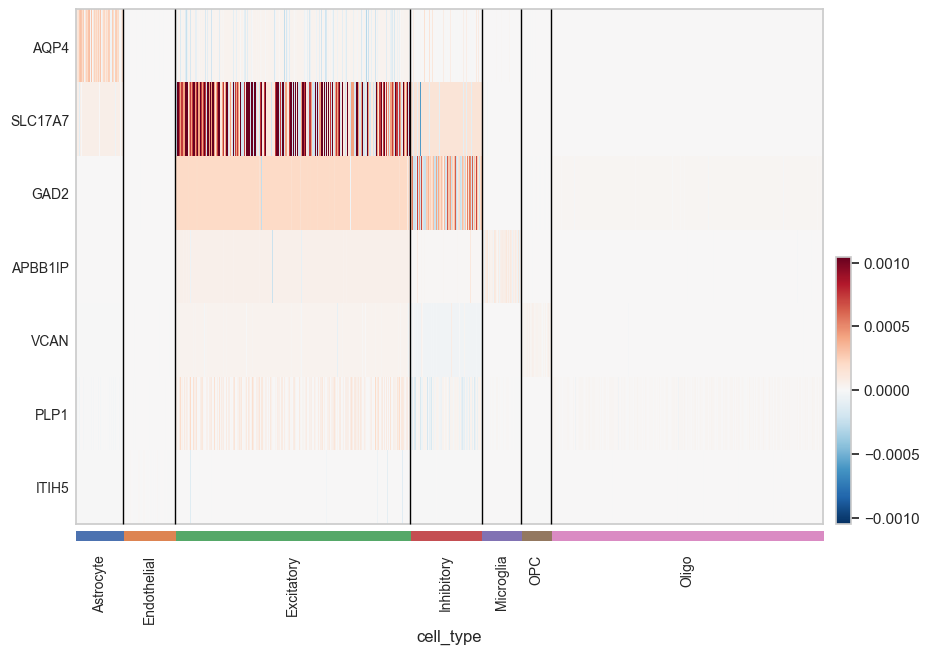

In [42]:
from SpCAST.visualization import feature_importance_identification

# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
shap_values_df = feature_importance_identification(scRNA_data, spRNA_data, biomarkers_list=biomarkers_list, device=device, batch_size=1, 
                                                      save_model_path=save_model_path, save_model_name=save_model_name)